In [1]:
"""
PointToles2Couples
For every deforestation point look for correspoding tile for after an before deforesttion event. 
"""


'\nPointToles2Couples\nFor every deforestation point look for correspoding tile for after an before deforesttion event. \n'

In [2]:
#Este codigo arma parejas de tiles planet deforestacion o no_deforestacion a partir de una lista de puntos
#Tambien optine estadisticos descriptivos de las imagenes.

In [3]:
#PLANET_API_KEY='cfb9acbc5bdb4cb496bcf33d57d28738'
#Librerias de laAPI Planet-------------------------
from planet import api
from requests.auth import HTTPBasicAuth
#Librerias para manejo de datos geoespaciales raster y vectoriales
from osgeo import ogr, gdal, osr
import rasterio
import geopandas as gpd #Para usar geodataframes
import geojson #para manejar archivos de texto en formaro geo-json
from pygeotile.tile import Tile #Libreria para transformar de sistema WGS84 EPSG4326  a google XYZ y viceversa
from pyproj import Proj, transform
#Librerias para hacer peticiones http get 
import xml.dom.minidom
import http.client
import requests
#librerias matematicas y estadisticas
import math
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import image
from matplotlib import pyplot
import matplotlib.pyplot as plt
#Librerias para manejo de So y sistema de archvios del so
import os
import shutil
#Linrerias para trabjo con imagenes y vicion artificial
from PIL import Image
import cv2
#Librerias Misicelaneas
import datetime, json
import time
import re
#Librerias para conexion a repositorios
from pymongo import MongoClient 


try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
    

## Primera parte: Conexion a repositorios (Planet API, Base de datos y archivo de puntos.)

In [4]:
%matplotlib inline

In [5]:
clientPlanet = api.ClientV1() # Creacion de objeto cliente Planet de la API planet

In [6]:
clientMongo = MongoClient('localhost', 27017) #Cliente mongo para conexion a repositorio de tiles y chips
db = clientMongo.deepAlerts

In [7]:
defPointsGeojsonFile='dfp2018_4.geojson'
gdf=gpd.GeoDataFrame.from_file(defPointsGeojsonFile)
gdf.head()

Name description timestamp begin   end altitudeMode  \
0  $[Dep_Schema/ID]        None      None  None  None         None   
1  $[Dep_Schema/ID]        None      None  None  None         None   
2  $[Dep_Schema/ID]        None      None  None  None         None   
3  $[Dep_Schema/ID]        None      None  None  None         None   
4  $[Dep_Schema/ID]        None      None  None  None         None   

   tessellate  extrude  visibility drawOrder  icon  \
0          -1        0          -1      None  None   
1          -1        0          -1      None  None   
2          -1        0          -1      None  None   
3          -1        0          -1      None  None   
4          -1        0          -1      None  None   

                                           geometry  
0  (POINT Z (-74.5688606380612 7.29003027246659 0))  
1   (POINT Z (-76.1368741087911 6.6162348924375 0))  
2     (POINT Z (-75.93997850867891 6.7052373064 0))  
3  (POINT Z (-76.1981572198183 6.77121137594168 0))  
4   (POINT Z (-76.7552679969417 6.5858235784038 0))

In [8]:
defPointsGeojsonFile='porFinNoDefPoints.geojson'
gdf=gpd.GeoDataFrame.from_file(defPointsGeojsonFile)
gdf["x"] = gdf.centroid.y
gdf["y"] = gdf.centroid.x
df=gdf[["x","y"]]
gdf.head()


AOI  Area Oferta_Amb UCVocacion Uso_Princi Vocacion  latitude  longitude  \
0  True   NaN       None       None       None     None  3.159793 -72.427688   
1  True   NaN       None       None       None     None  3.530542 -71.857250   
2  True   NaN       None       None       None     None  2.940334 -71.719211   
3  True   NaN       None       None       None     None  3.063170 -71.254869   
4  True   NaN       None       None       None     None  2.795312 -71.612834   

                                       geometry         x          y  
0  POINT (-72.42768792640778 3.159792782604546)  3.159793 -72.427688  
1  POINT (-71.85724951684485 3.530541797222579)  3.530542 -71.857250  
2  POINT (-71.71921129397688 2.940333857280984)  2.940334 -71.719211  
3  POINT (-71.25486862709027 3.063169500214145)  3.063170 -71.254869  
4  POINT (-71.61283400408156 2.795311785103015)  2.795312 -71.612834

## Segunda parte definicion de las funciones a Usar

In [9]:
#Codigo para cargar lista de puntos 
def loadDefPoints(defPointsGeojsonFile):#Falta especificar fecha o arvhivo en los argumentos.
    gdf=gpd.GeoDataFrame.from_file(defPointsGeojsonFile)
    gdf["x"] = gdf.centroid.y
    gdf["y"] = gdf.centroid.x
    df=gdf[["x","y"]]
    return df

In [10]:
#Codigo para optener el tile correspondiente a una coordenada. 
def point2Tile(p,z):
    latitude, longitude, zoom = p[0],p[1], z
    tile = Tile.for_latitude_longitude(latitude, longitude, zoom)
    tile= tile.google
    return tile

In [11]:
#Codigo Para georefernciar las imagenes y pasarlas de png a geotiff
"""
src_filename ='/path/to/source.tif'
dst_filename = '/path/to/destination.tif'
google_x, google_y, zoom = 9795, 16143, 15  #Cordenadas del tile en la grilla google o planet que es igual
pixels=256 #Numero de pixels de un lado del cuadrado
epsg = 4326 #Es el eps de los puntos del IDEAM y el que retorna pygeotile
"""
def png2GeoTif(src_filename,dst_filename,google_x,google_y,zoom,pixels,epsg):
    # Opens source dataset
    src_ds = gdal.Open(src_filename)
    format = "GTiff"
    driver = gdal.GetDriverByName(format)
    # Open destination dataset
    dst_ds = driver.CreateCopy(dst_filename, src_ds, 0)
    #Optener los puntos de referencia
    tile = Tile.from_google(google_x, google_y, zoom)
    bounds=tile.bounds #Retorna el punto sur occidental y el punto nororiental del tile.
    print(bounds)
    p1=bounds[0] #Point(latitude=2.6357885741666065, longitude=-72.388916015625)
    p2=bounds[1] 
    uperleftx=min([p1[1],p2[1]])
    uperlefty=max([p1[0],p2[0]])
    scalex=abs(p1[1]-p2[1])/pixels
    scaley=abs(p1[0]-p2[0])/pixels
    # Specify raster location through geotransform array
    # (uperleftx, scalex, skewx, uperlefty, skewy, scaley)
    # Scale = size of one pixel in units of raster projection
    # this example below assumes 100x100
    gt = [uperleftx, scalex, 0, uperlefty, 0, -scaley]
    print(gt)
    # Set location
    dst_ds.SetGeoTransform(gt)
    # Get raster projection
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    dest_wkt = srs.ExportToWkt()
    # Set projection
    dst_ds.SetProjection(dest_wkt)
    # Close files
    dst_ds = None
    src_ds = None

In [12]:
"""
src_filename ='C:\\Users\\Gus BeCa\\Documents\\CodigosExploratpriosProyecto\\PlanetAPI\\global_quarterly_2018q3_mosaic_NoDef\\global_quarterly_2018q3_mosaic_15_9462_16270.png'
dst_filename = 'C:\\Users\\Gus BeCa\\Documents\\Nueva\\global_quarterly_2018q3_mosaic_15_9462_16270.tif'
google_x, google_y, zoom = 9462, 16270, 15  #Cordenadas del tile en la grilla google o planet que es igual
pixels=256 #Numero de pixels de un lado del cuadrado
epsg = 4326 #Es el eps de los puntos del IDEAM y el que retorna pygeotile
png2GeoTif(src_filename,dst_filename,google_x,google_y,zoom,pixels,epsg)
"""

"\nsrc_filename ='C:\\Users\\Gus BeCa\\Documents\\CodigosExploratpriosProyecto\\PlanetAPI\\global_quarterly_2018q3_mosaic_NoDef\\global_quarterly_2018q3_mosaic_15_9462_16270.png'\ndst_filename = 'C:\\Users\\Gus BeCa\\Documents\\Nueva\\global_quarterly_2018q3_mosaic_15_9462_16270.tif'\ngoogle_x, google_y, zoom = 9462, 16270, 15  #Cordenadas del tile en la grilla google o planet que es igual\npixels=256 #Numero de pixels de un lado del cuadrado\nepsg = 4326 #Es el eps de los puntos del IDEAM y el que retorna pygeotile\npng2GeoTif(src_filename,dst_filename,google_x,google_y,zoom,pixels,epsg)\n"

In [13]:
#Codigo Para construir un vector de caracteristicas de las imagens para su analicis
def getFeatureVector(pathO):
    im=cv2.imread(pathO, cv2.IMREAD_UNCHANGED) 
    #CDefiniendo conlumnas del datset
    #Las primeras son estadisticos descriptivos basicos de la imganen
    columns=['imgSize', 'avRed', 'avGreen','avBlue','stdRed','stdGreen','stdBlue','minRed',
                               'minGreen','minBlue','maxRed','maxGreen','maxBlue' ]
    #Luego vamos a usar los datos de un histograma 3dimencional (Convinaciones de colores mas frecuents) 
    n=3
    nim = cv2.normalize(im, None, alpha=0, beta=256, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    hist = cv2.calcHist([nim], [0, 1, 2], None, [n, n, n], [0, 256, 0, 256, 0, 256])
    hist = hist.flatten()
    for i in range(n):
        for j in range(n):
            for k in range(n):
                columns.append('r'+str(i)+'g'+str(j)+'b'+str(k))

    #Luego vamos a tomar las 4 frecuencias de muestreo con mayor potencia para 8 segmentos de frecuencia equidistantes
    for i in range(8):
        for j in range(4):
            columns.append('frecbean'+str(i)+'pow'+str(j))

    #Luego vamos a tomar un version resumida del espectograma usando 32 beans.
    for i in range(32):
            columns.append(str(i))


    #Optenemos cada caracteristica y se guarda en undiccionario
    dic = {}
    #Primero optenemos los estaditicos descriptivos basicos.
    dic['imgSize']=os.path.getsize(pathO)
    average=im.mean(axis=0).mean(axis=0)
    dic['avRed'] = average[0]
    dic['avGreen'] = average[1]
    dic['avBlue'] = average[2]
    std = im.std(axis=0).std(axis=0)
    dic['stdRed'] = std[0]
    dic['stdGreen'] = std[1]
    dic['stdBlue'] = std[2]
    minimo = im.min(axis=0).min(axis=0)
    dic['minRed'] = minimo[0]
    dic['minGreen'] = minimo[1]
    dic['minBlue'] = minimo[2]
    maximo = im.max(axis=0).max(axis=0)
    dic['maxRed'] = maximo[0]
    dic['maxGreen'] = maximo[1]
    dic['maxBlue'] = maximo[2]
    #Aqui se optinen el histogramade colores
    nim = cv2.normalize(im, None, alpha=0, beta=265, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    hist = cv2.calcHist([nim], [0, 1, 2], None, [3, 3, 3], [0, 256, 0, 256, 0, 256])
    hist = hist.flatten()
    hist=hist.astype(int)
    l=0
    for i in range(n):
        for j in range(n):
            for k in range(n):
                dic[('r'+str(i)+'g'+str(j)+'b'+str(k))]=hist[l]
                l=l+1
    #Aqui se optinen las frecuencias mas relevantes por bean
    grayim = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)#Pasamos a escala de grises ya qu nos intersan las texturas y objetos no colores          
    df2 = pd.DataFrame()
    fltim=grayim.flatten()#Convertimos la imagenes de matriz a una serie
    nn=fltim.shape[-1]
    sp = np.fft.fft(fltim, n=nn) #Optenenos la trasformada de fourier de la seri
    freq = np.fft.fftfreq(nn)
    #Determinamos las frecuencias de muestreo.
    #como la imagen esta compuesa por 65mil pixeles la frecuencia maxima es 65mil muestras o una muestra por cada 5m^2
    df2 = pd.DataFrame()  
    df2['frec']=freq
    #Como se entiende mas facil por pixeles escalmos las frecuencias a 256, donde 256 significa que se muestrea pixel a pixel
    #128 Significaria que semuestrea cada 2 pixeles, 64 cada 4 pixeles... y 0 seria una sola muestra
    df2['frec']=df2['frec']*256*2
    df2['real']=(sp.real/max(sp.real))**2 #Tomamos la unicamente la componente real no usamos la imaginaria
    df2=df2.sort_values(by=['frec'])
    df2=df2[df2['frec']>0]
    n=int(df2.shape[0]/8)
    frecus=[]
    for i in range(8):
        x=n*i
        y=n*(1+i)
        temp=df2.loc[x:y]
        temp=temp.sort_values(by=['real'])
        frecus=frecus+temp.tail(4)['frec'].tolist()         
    l=0
    for i in range(8):
        for j in range(4):
                dic[('frecbean'+str(i)+'pow'+str(j))]=frecus[l]
                l=l+1

    #Ahora vamos a estimar un uspectrograma reducido a 32 beans 
    #es decir frecuencia de muestreo enrangos que van aumentando de a 8 pixeles y sacamos sa sumatoria en cada bean
    frecbeans=[]
    n=int(df2.shape[0]/32)
    for i in range(32):
        x=n*i
        y=n*(1+i)
        temp=df2.loc[x:y]
        temp=temp.real.sum()
        frecbeans.append(temp)
    l=0
    for i in range(32):
        dic[str(i)]=frecbeans[l]
        l=l+1

    #finalmente se adiciona el diccionario a una list on el fin d contrsruir un dataframe            
    return dic


In [14]:

def buildCouples(defPointsGeojsonFile,mosaicNameBefore,mosaicNameAfter,z,period,tipo,formato):
    start = time.time()
    """
    defPointsGeojsonFile: Nombre del archivo de puntos de deforestacion en formato geojson
    mosaicNameBefore, mosaicNameAfter: Nombre de los directorios con las imagenes correspondientes
    Las imgenes deben estar en formato png y con el nombre del archvio de las iguente forma:
    nombre_del_compuesto_zoom_x_y ejemplo: global_monthly_2017_12_mosaic_15_9455_16282.png
    z: Nivel de zoom de las imagenes tipico 15
    tipo: 'Si' si son pareja de deforestacion, 'No' si son parejas de no deforesacion
    """
    df=loadDefPoints(defPointsGeojsonFile)
    #Se contruye una tabla con las parejas de imagenes para cada punto
    z=15
    f = lambda x: point2Tile((x[0],x[1]),z) #Se dientifica el tile planet corespondiente a cad punto
    df['gtile']=df.apply(f, axis=1)
    
    f = lambda x: '%s_%s_%s_%s'%(mosaicNameBefore,z,x[2][0],x[2][1])#Se identifica el nombre del archvio de la imagen de antes
    df['before']=df.apply(f, axis=1)
    
    f = lambda x: '%s_%s_%s_%s'%(mosaicNameAfter,z,x[2][0],x[2][1])#Se identifica el nombre del archvio de la imagen de despues
    df['after']=df.apply(f, axis=1)
    
    f = lambda x: '%s_%s_%s_%s'%(period,z,x[0],x[0]) #Nombre del directorio donde se va a guradar la pareja
    df['defObservation']=df.apply(f, axis=1)
    
    #Inicializacion de variables
    total=0 #Contador para el total de puntos
    existed=0 #Contador de el total de imagenes encontrados
    sized=0 #Contador para el total de imagenes encontradas con tamaño en bytesapropiado
    passed=0 # Cantidad de puntos de cargados
    diclistb=[]#Lista con los vectores de caracteristicas de las imagenes de antes
    diclista=[]#Lista con los cectores de caacteristicas de las images de despues
    
    #Se reorreo la lista de puntos 
    for index,row in df.iterrows():
        total=total+1
        #try:
        cwd=os.getcwd()
        path=os.path.join(cwd,tipo+'_DeforestationCouples_'+period,row['defObservation'])

        pathb=os.path.join(path,'Before_'+row['before']+'.tif') 
        patha=os.path.join(path,'After_'+row['after']+'.tif')
        if tipo=='Si':
            pathbO=os.path.join(cwd,mosaicNameBefore,row['before']+'.png')
            pathaO=os.path.join(cwd,mosaicNameAfter,row['after']+'.png')
        elif tipo=='No':
            pathbO=os.path.join(cwd,mosaicNameBefore+'_NoDef',row['before']+'.png')
            pathaO=os.path.join(cwd,mosaicNameAfter+'_NoDef',row['after']+'.png')


        if os.path.exists(pathbO) and os.path.exists(pathaO) : #Se verifica si existen las imagenes
            existed=existed+1
            b = os.path.getsize(pathbO)
            a = os.path.getsize(pathaO)
            
            if b>45000 and a >45000:
                if b<103000 or a <103000:
                        print(pathbO,' --- ',pathaO)

            if b>103000 and a>103000: 
                
                    #Las imagenes con menos de 80000bytes suelen estar cubiertas de muchas nubes o sombras de nuves
                    #Las imagenes con menos de 45000 casisiempre son errores de descarga
                #Se cargan las imagenes y se construye su vector de caracteristicas para una analicis descriptivo
                #Las imagenes mensuales con menos de 100000 bytes sueles tenr bruma o nuves altas vaporosas
                   
                dic=getFeatureVector(pathbO)
                diclistb.append(dic)
                
                dic=getFeatureVector(pathaO)
                diclista.append(dic)
                sized=sized+1
                if os.path.exists(path) :
                    passed=passed+1
                    pass
                else:
                    os.mkdir(path)
                    if formato=='png':
                        newPath = shutil.copy(pathbO, pathb)
                        newPath = shutil.copy(pathaO, patha)
                    else: 
                        pixels=256 
                        epsg = 4326 

                        m = re.search('mosaic_(.*)', row['before'])
                        x = re.split("_", m.group(0))
                        google_x, google_y, zoom = int(x[2]),int(x[3]),int(x[1])
                        src_filename = pathbO
                        dst_filename = pathb

                        png2GeoTif(src_filename,dst_filename,google_x,google_y,zoom,pixels,epsg)#

                        m = re.search('mosaic_(.*)', row['after'])
                        x = re.split("_", m.group(0))
                        google_x, google_y, zoom = int(x[2]),int(x[3]),int(x[1])
                        src_filename = pathaO
                        dst_filename = patha

                        png2GeoTif(src_filename,dst_filename,google_x,google_y,zoom,pixels,epsg)#

                pass
        else:
            print(pathbO,' pathbO: ',os.path.exists(pathbO),' pathaO: ', os.path.exists(pathaO))
        if total%200==0:
            print(int(100*total/df.shape[0]),' % time enlapsed', int((time.time()-start)/60) ,' minutes')
    print('total,existed,sized',total,existed,sized, passed)
    dfb=pd.DataFrame(diclistb)
    dfa=pd.DataFrame(diclista)
    return [dfb,dfa]
    

In [17]:
defPointsGeojsonFile='dfp2018_4.geojson'
mosaicNameBefore="global_quarterly_2018q3_mosaic"#"global_monthly_2019_01_mosaic""
mosaicNameAfter="global_monthly_2019_01_mosaic"#"global_monthly_2019_01_mosaic"
period='2018_4'
z=15
tipo='Si'
formato='tif'
dfb,dfa = buildCouples(defPointsGeojsonFile,mosaicNameBefore,mosaicNameAfter,z,period,tipo,formato)

C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9596_15718.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9453_15780.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9471_15772.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9448_15766.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9397_15783.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quart

C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9621_15681.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9621_15677.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9618_15685.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9615_15672.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9613_15678.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quart

(Point(latitude=1.559865865343021, longitude=-74.28955078124999), Point(latitude=1.5708480935151505, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 1.5708480935151505, 0, -4.2899328797380704e-05]
(Point(latitude=1.559865865343021, longitude=-74.28955078124999), Point(latitude=1.5708480935151505, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 1.5708480935151505, 0, -4.2899328797380704e-05]
(Point(latitude=1.559865865343021, longitude=-74.278564453125), Point(latitude=1.5708480935151505, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.5708480935151505, 0, -4.2899328797380704e-05]
(Point(latitude=1.559865865343021, longitude=-74.278564453125), Point(latitude=1.5708480935151505, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.5708480935151505, 0, -4.2899328797380704e-05]
(Point(latitude=1.559865865343021, longitude=-74.28955078124999), Point(latitude=1.5708480935151505, lon

(Point(latitude=1.3951257897508365, longitude=-74.39941406250001), Point(latitude=1.4061088354351468, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 1.4061088354351468, 0, -4.290252220433711e-05]
(Point(latitude=1.3951257897508365, longitude=-74.39941406250001), Point(latitude=1.4061088354351468, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 1.4061088354351468, 0, -4.290252220433711e-05]
(Point(latitude=1.3951257897508365, longitude=-74.39941406250001), Point(latitude=1.4061088354351468, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 1.4061088354351468, 0, -4.290252220433711e-05]
(Point(latitude=1.3951257897508365, longitude=-74.39941406250001), Point(latitude=1.4061088354351468, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 1.4061088354351468, 0, -4.290252220433711e-05]
(Point(latitude=1.3841426927920284, longitude=-74.39941406250001), Point(latitude=1.3951257897508365

(Point(latitude=1.2962761196418344, longitude=-74.366455078125), Point(latitude=1.3072596122756777, longitude=-74.35546874999999))
[-74.366455078125, 4.291534423833676e-05, 0, 1.3072596122756777, 0, -4.290426810095015e-05]
(Point(latitude=1.2962761196418344, longitude=-74.366455078125), Point(latitude=1.3072596122756777, longitude=-74.35546874999999))
[-74.366455078125, 4.291534423833676e-05, 0, 1.3072596122756777, 0, -4.290426810095015e-05]
(Point(latitude=1.2962761196418344, longitude=-74.37744140624999), Point(latitude=1.3072596122756777, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.3072596122756777, 0, -4.290426810095015e-05]
(Point(latitude=1.2962761196418344, longitude=-74.37744140624999), Point(latitude=1.3072596122756777, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.3072596122756777, 0, -4.290426810095015e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global

(Point(latitude=1.2633253574893366, longitude=-74.278564453125), Point(latitude=1.2743089918452106, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-74.278564453125), Point(latitude=1.2743089918452106, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-74.278564453125), Point(latitude=1.2743089918452106, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2523416766996542, longitude=-74.28955078124999), Point(latitude=1.2633253574893366, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 1.2633253574893366, 0, -4.290500308469676e-05]
(Point(latitude=1.2523416766996542, longitude=-74.28955078124999), Point(latitude=1.2633253574893366, long

(Point(latitude=1.2193903597622147, longitude=-74.46533203125001), Point(latitude=1.2303741774326145, longitude=-74.454345703125))
[-74.46533203125001, 4.291534423833676e-05, 0, 1.2303741774326145, 0, -4.290553777499921e-05]
(Point(latitude=1.2193903597622147, longitude=-74.46533203125001), Point(latitude=1.2303741774326145, longitude=-74.454345703125))
[-74.46533203125001, 4.291534423833676e-05, 0, 1.2303741774326145, 0, -4.290553777499921e-05]
(Point(latitude=1.2193903597622147, longitude=-74.46533203125001), Point(latitude=1.2303741774326145, longitude=-74.454345703125))
[-74.46533203125001, 4.291534423833676e-05, 0, 1.2303741774326145, 0, -4.290553777499921e-05]
(Point(latitude=1.2193903597622147, longitude=-74.46533203125001), Point(latitude=1.2303741774326145, longitude=-74.454345703125))
[-74.46533203125001, 4.291534423833676e-05, 0, 1.2303741774326145, 0, -4.290553777499921e-05]
(Point(latitude=1.2193903597622147, longitude=-74.46533203125001), Point(latitude=1.2303741774326145

(Point(latitude=1.2743089918452106, longitude=-74.520263671875), Point(latitude=1.285292579363842, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.520263671875), Point(latitude=1.285292579363842, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2633253574893366, longitude=-74.520263671875), Point(latitude=1.2743089918452106, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-74.520263671875), Point(latitude=1.2743089918452106, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-74.520263671875), Point(latitude=1.2743089918452106, longitude=-7

(Point(latitude=1.2633253574893366, longitude=-74.35546874999999), Point(latitude=1.2743089918452106, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-74.35546874999999), Point(latitude=1.2743089918452106, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2523416766996542, longitude=-74.366455078125), Point(latitude=1.2633253574893366, longitude=-74.35546874999999))
[-74.366455078125, 4.291534423833676e-05, 0, 1.2633253574893366, 0, -4.290500308469676e-05]
(Point(latitude=1.2523416766996542, longitude=-74.366455078125), Point(latitude=1.2633253574893366, longitude=-74.35546874999999))
[-74.366455078125, 4.291534423833676e-05, 0, 1.2633253574893366, 0, -4.290500308469676e-05]
(Point(latitude=1.2413579498795597, longitude=-74.432373046875), Point(latitude=1.2523416766996542, long

(Point(latitude=1.2743089918452106, longitude=-74.73999023437501), Point(latitude=1.285292579363842, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.73999023437501), Point(latitude=1.285292579363842, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.73999023437501), Point(latitude=1.285292579363842, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.73999023437501), Point(latitude=1.285292579363842, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.175454644915912, longitude=-74.39941406250001), Point(latitude=1.1864386394452024, longitude=-

(Point(latitude=1.142502403706165, longitude=-74.37744140624999), Point(latitude=1.1534865266428573, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.1534865266428573, 0, -4.290673022145416e-05]
(Point(latitude=1.142502403706165, longitude=-74.37744140624999), Point(latitude=1.1534865266428573, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.1534865266428573, 0, -4.290673022145416e-05]
(Point(latitude=1.142502403706165, longitude=-74.388427734375), Point(latitude=1.1534865266428573, longitude=-74.37744140624999))
[-74.388427734375, 4.291534423833676e-05, 0, 1.1534865266428573, 0, -4.290673022145416e-05]
(Point(latitude=1.142502403706165, longitude=-74.388427734375), Point(latitude=1.1534865266428573, longitude=-74.37744140624999))
[-74.388427734375, 4.291534423833676e-05, 0, 1.1534865266428573, 0, -4.290673022145416e-05]
(Point(latitude=1.1315182387740648, longitude=-74.37744140624999), Point(latitude=1.142502403706165, longitu

(Point(latitude=1.02167436848739, longitude=-74.344482421875), Point(latitude=1.0326589311777759, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 1.0326589311777759, 0, -4.29084480093201e-05]
(Point(latitude=1.02167436848739, longitude=-74.344482421875), Point(latitude=1.0326589311777759, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 1.0326589311777759, 0, -4.29084480093201e-05]
(Point(latitude=1.0106897682409128, longitude=-74.35546874999999), Point(latitude=1.02167436848739, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 1.02167436848739, 0, -4.290859471280106e-05]
(Point(latitude=1.0106897682409128, longitude=-74.35546874999999), Point(latitude=1.02167436848739, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 1.02167436848739, 0, -4.290859471280106e-05]
(Point(latitude=1.0106897682409128, longitude=-74.35546874999999), Point(latitude=1.02167436848739, longitude=-74.3444

(Point(latitude=0.9777357462011963, longitude=-74.60815429687499), Point(latitude=0.9887204566941717, longitude=-74.59716796875))
[-74.60815429687499, 4.291534423822574e-05, 0, 0.9887204566941717, 0, -4.290902536318534e-05]
(Point(latitude=0.9777357462011963, longitude=-74.60815429687499), Point(latitude=0.9887204566941717, longitude=-74.59716796875))
[-74.60815429687499, 4.291534423822574e-05, 0, 0.9887204566941717, 0, -4.290902536318534e-05]
(Point(latitude=0.9777357462011963, longitude=-74.619140625), Point(latitude=0.9887204566941717, longitude=-74.60815429687499))
[-74.619140625, 4.291534423833676e-05, 0, 0.9887204566941717, 0, -4.290902536318534e-05]
(Point(latitude=0.9777357462011963, longitude=-74.619140625), Point(latitude=0.9887204566941717, longitude=-74.60815429687499))
[-74.619140625, 4.291534423833676e-05, 0, 0.9887204566941717, 0, -4.290902536318534e-05]
(Point(latitude=0.9557662177941737, longitude=-74.476318359375), Point(latitude=0.9667509997666425, longitude=-74.4653

(Point(latitude=0.9887204566941717, longitude=-74.31152343749999), Point(latitude=0.9997051308419946, longitude=-74.300537109375))
[-74.31152343749999, 4.291534423822574e-05, 0, 0.9997051308419946, 0, -4.2908883389933174e-05]
(Point(latitude=0.9887204566941717, longitude=-74.31152343749999), Point(latitude=0.9997051308419946, longitude=-74.300537109375))
[-74.31152343749999, 4.291534423822574e-05, 0, 0.9997051308419946, 0, -4.2908883389933174e-05]
(Point(latitude=0.9887204566941717, longitude=-74.31152343749999), Point(latitude=0.9997051308419946, longitude=-74.300537109375))
[-74.31152343749999, 4.291534423822574e-05, 0, 0.9997051308419946, 0, -4.2908883389933174e-05]
(Point(latitude=0.9887204566941717, longitude=-74.31152343749999), Point(latitude=0.9997051308419946, longitude=-74.300537109375))
[-74.31152343749999, 4.291534423822574e-05, 0, 0.9997051308419946, 0, -4.2908883389933174e-05]
(Point(latitude=0.9887204566941717, longitude=-74.322509765625), Point(latitude=0.99970513084199

(Point(latitude=0.7470491450051924, longitude=-75.10253906250001), Point(latitude=0.7580345254974181, longitude=-75.091552734375))
[-75.10253906250001, 4.291534423833676e-05, 0, 0.7580345254974181, 0, -4.291164254775683e-05]
(Point(latitude=0.7470491450051924, longitude=-75.10253906250001), Point(latitude=0.7580345254974181, longitude=-75.091552734375))
[-75.10253906250001, 4.291534423833676e-05, 0, 0.7580345254974181, 0, -4.291164254775683e-05]
(Point(latitude=0.736063737049195, longitude=-75.10253906250001), Point(latitude=0.7470491450051924, longitude=-75.091552734375))
[-75.10253906250001, 4.291534423833676e-05, 0, 0.7470491450051924, 0, -4.291174982811461e-05]
(Point(latitude=0.736063737049195, longitude=-75.10253906250001), Point(latitude=0.7470491450051924, longitude=-75.091552734375))
[-75.10253906250001, 4.291534423833676e-05, 0, 0.7470491450051924, 0, -4.291174982811461e-05]
(Point(latitude=0.7470491450051924, longitude=-75.10253906250001), Point(latitude=0.7580345254974181, 

(Point(latitude=0.38451859794901677, longitude=-74.19067382812501), Point(latitude=0.39550467153200675, longitude=-74.1796875))
[-74.19067382812501, 4.291534423833676e-05, 0, 0.39550467153200675, 0, -4.291434993355459e-05]
(Point(latitude=0.38451859794901677, longitude=-74.19067382812501), Point(latitude=0.39550467153200675, longitude=-74.1796875))
[-74.19067382812501, 4.291534423833676e-05, 0, 0.39550467153200675, 0, -4.291434993355459e-05]
(Point(latitude=0.38451859794901677, longitude=-74.1796875), Point(latitude=0.39550467153200675, longitude=-74.16870117187501))
[-74.1796875, 4.291534423822574e-05, 0, 0.39550467153200675, 0, -4.291434993355459e-05]
(Point(latitude=0.38451859794901677, longitude=-74.1796875), Point(latitude=0.39550467153200675, longitude=-74.16870117187501))
[-74.1796875, 4.291534423822574e-05, 0, 0.39550467153200675, 0, -4.291434993355459e-05]
(Point(latitude=0.38451859794901677, longitude=-74.19067382812501), Point(latitude=0.39550467153200675, longitude=-74.1796

(Point(latitude=1.2633253574893366, longitude=-74.35546874999999), Point(latitude=1.2743089918452106, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-74.35546874999999), Point(latitude=1.2743089918452106, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.559865865343021, longitude=-74.28955078124999), Point(latitude=1.5708480935151505, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 1.5708480935151505, 0, -4.2899328797380704e-05]
(Point(latitude=1.559865865343021, longitude=-74.28955078124999), Point(latitude=1.5708480935151505, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 1.5708480935151505, 0, -4.2899328797380704e-05]
(Point(latitude=1.0106897682409128, longitude=-74.35546874999999), Point(latitude=1.02167436848739, 

(Point(latitude=1.2633253574893366, longitude=-74.73999023437501), Point(latitude=1.2743089918452106, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-74.73999023437501), Point(latitude=1.2743089918452106, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2962761196418344, longitude=-74.37744140624999), Point(latitude=1.3072596122756777, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.3072596122756777, 0, -4.290426810095015e-05]
(Point(latitude=1.2962761196418344, longitude=-74.37744140624999), Point(latitude=1.3072596122756777, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.3072596122756777, 0, -4.290426810095015e-05]
16  % time enlapsed 1  minutes
(Point(latitude=1.1864386394452024, longitude=-74.410400390625), Point(

(Point(latitude=1.537901237431487, longitude=-74.28955078124999), Point(latitude=1.5488835798474108, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 1.5488835798474108, 0, -4.289977506220181e-05]
(Point(latitude=1.537901237431487, longitude=-74.28955078124999), Point(latitude=1.5488835798474108, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 1.5488835798474108, 0, -4.289977506220181e-05]
(Point(latitude=1.197422590365017, longitude=-74.520263671875), Point(latitude=1.2084064972718325, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=1.197422590365017, longitude=-74.520263671875), Point(latitude=1.2084064972718325, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=0.8569016474398004, longitude=-74.53125), Point(latitude=0.8678867310885294, longitude=-74.5

(Point(latitude=1.0546279422758997, longitude=-74.498291015625), Point(latitude=1.0656123898763876, longitude=-74.48730468750001))
[-74.498291015625, 4.291534423822574e-05, 0, 1.0656123898763876, 0, -4.290799843940582e-05]
(Point(latitude=1.0546279422758997, longitude=-74.498291015625), Point(latitude=1.0656123898763876, longitude=-74.48730468750001))
[-74.498291015625, 4.291534423822574e-05, 0, 1.0656123898763876, 0, -4.290799843940582e-05]
(Point(latitude=1.2193903597622147, longitude=-74.48730468750001), Point(latitude=1.2303741774326145, longitude=-74.476318359375))
[-74.48730468750001, 4.291534423833676e-05, 0, 1.2303741774326145, 0, -4.290553777499921e-05]
(Point(latitude=1.2193903597622147, longitude=-74.48730468750001), Point(latitude=1.2303741774326145, longitude=-74.476318359375))
[-74.48730468750001, 4.291534423833676e-05, 0, 1.2303741774326145, 0, -4.290553777499921e-05]
(Point(latitude=1.2962761196418344, longitude=-74.410400390625), Point(latitude=1.3072596122756777, long

(Point(latitude=1.2633253574893366, longitude=-74.33349609374999), Point(latitude=1.2743089918452106, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-74.33349609374999), Point(latitude=1.2743089918452106, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.1315182387740648, longitude=-74.498291015625), Point(latitude=1.142502403706165, longitude=-74.48730468750001))
[-74.498291015625, 4.291534423822574e-05, 0, 1.142502403706165, 0, -4.2906894266016814e-05]
(Point(latitude=1.1315182387740648, longitude=-74.498291015625), Point(latitude=1.142502403706165, longitude=-74.48730468750001))
[-74.498291015625, 4.291534423822574e-05, 0, 1.142502403706165, 0, -4.2906894266016814e-05]
(Point(latitude=1.472006010190348, longitude=-74.278564453125), Point(latitude=1.4829886856602814, longitu

(Point(latitude=1.515936383451699, longitude=-74.300537109375), Point(latitude=1.526918838498519, longitude=-74.28955078124999))
[-74.300537109375, 4.291534423833676e-05, 0, 1.526918838498519, 0, -4.290021502664082e-05]
(Point(latitude=1.515936383451699, longitude=-74.300537109375), Point(latitude=1.526918838498519, longitude=-74.28955078124999))
[-74.300537109375, 4.291534423833676e-05, 0, 1.526918838498519, 0, -4.290021502664082e-05]
(Point(latitude=1.2633253574893366, longitude=-74.322509765625), Point(latitude=1.2743089918452106, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-74.322509765625), Point(latitude=1.2743089918452106, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly

(Point(latitude=1.142502403706165, longitude=-74.344482421875), Point(latitude=1.1534865266428573, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 1.1534865266428573, 0, -4.290673022145416e-05]
(Point(latitude=1.0765967983063982, longitude=-74.564208984375), Point(latitude=1.0875811671623699, longitude=-74.55322265625))
[-74.564208984375, 4.291534423828125e-05, 0, 1.0875811671623699, 0, -4.2907690843639254e-05]
(Point(latitude=1.0765967983063982, longitude=-74.564208984375), Point(latitude=1.0875811671623699, longitude=-74.55322265625))
[-74.564208984375, 4.291534423828125e-05, 0, 1.0875811671623699, 0, -4.2907690843639254e-05]
(Point(latitude=1.0985654960406648, longitude=-74.476318359375), Point(latitude=1.1095497845377469, longitude=-74.46533203125001))
[-74.476318359375, 4.291534423822574e-05, 0, 1.1095497845377469, 0, -4.290737694172698e-05]
(Point(latitude=1.0985654960406648, longitude=-74.476318359375), Point(latitude=1.1095497845377469, longitude=-74

(Point(latitude=1.2633253574893366, longitude=-74.410400390625), Point(latitude=1.2743089918452106, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9597_16272.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9597_16272.png
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9611_16288.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9611_16288.png
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9612_16289.png  ---  C:\Users\Gus BeCa\Documents\

(Point(latitude=1.2962761196418344, longitude=-74.344482421875), Point(latitude=1.3072596122756777, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 1.3072596122756777, 0, -4.290426810095015e-05]
(Point(latitude=1.0656123898763876, longitude=-74.564208984375), Point(latitude=1.0765967983063982, longitude=-74.55322265625))
[-74.564208984375, 4.291534423828125e-05, 0, 1.0765967983063982, 0, -4.290784542972884e-05]
(Point(latitude=1.0656123898763876, longitude=-74.564208984375), Point(latitude=1.0765967983063982, longitude=-74.55322265625))
[-74.564208984375, 4.291534423828125e-05, 0, 1.0765967983063982, 0, -4.290784542972884e-05]
(Point(latitude=1.3072596122756777, longitude=-74.619140625), Point(latitude=1.3182430568620136, longitude=-74.60815429687499))
[-74.619140625, 4.291534423833676e-05, 0, 1.3182430568620136, 0, -4.290408041537474e-05]
(Point(latitude=1.3072596122756777, longitude=-74.619140625), Point(latitude=1.3182430568620136, longitude=-74.608154296

(Point(latitude=1.4390576608077637, longitude=-74.39941406250001), Point(latitude=1.4500404973607948, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 1.4500404973607948, 0, -4.29017052852778e-05]
(Point(latitude=1.4390576608077637, longitude=-74.39941406250001), Point(latitude=1.4500404973607948, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 1.4500404973607948, 0, -4.29017052852778e-05]
(Point(latitude=1.3731595449619782, longitude=-74.28955078124999), Point(latitude=1.3841426927920284, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 1.3841426927920284, 0, -4.290292121113346e-05]
(Point(latitude=1.3731595449619782, longitude=-74.28955078124999), Point(latitude=1.3841426927920284, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 1.3841426927920284, 0, -4.290292121113346e-05]
(Point(latitude=1.0546279422758997, longitude=-74.42138671875001), Point(latitude=1.0656123898763876, 

(Point(latitude=1.472006010190348, longitude=-74.256591796875), Point(latitude=1.4829886856602814, longitude=-74.24560546875))
[-74.256591796875, 4.291534423828125e-05, 0, 1.4829886856602814, 0, -4.2901076054427216e-05]
(Point(latitude=1.472006010190348, longitude=-74.256591796875), Point(latitude=1.4829886856602814, longitude=-74.24560546875))
[-74.256591796875, 4.291534423828125e-05, 0, 1.4829886856602814, 0, -4.2901076054427216e-05]
(Point(latitude=0.9008417889908868, longitude=-74.53125), Point(latitude=0.9118267425980833, longitude=-74.520263671875))
[-74.53125, 4.291534423828125e-05, 0, 0.9118267425980833, 0, -4.290997502811103e-05]
(Point(latitude=0.9008417889908868, longitude=-74.53125), Point(latitude=0.9118267425980833, longitude=-74.520263671875))
[-74.53125, 4.291534423828125e-05, 0, 0.9118267425980833, 0, -4.290997502811103e-05]
(Point(latitude=1.4061088354351468, longitude=-74.322509765625), Point(latitude=1.4170918294416264, longitude=-74.31152343749999))
[-74.3225097656

C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9613_16283.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9613_16283.png
(Point(latitude=1.2633253574893366, longitude=-74.24560546875), Point(latitude=1.2743089918452106, longitude=-74.234619140625))
[-74.24560546875, 4.291534423828125e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-74.24560546875), Point(latitude=1.2743089918452106, longitude=-74.234619140625))
[-74.24560546875, 4.291534423828125e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9612_16286.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly

(Point(latitude=1.537901237431487, longitude=-74.278564453125), Point(latitude=1.5488835798474108, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.5488835798474108, 0, -4.289977506220181e-05]
(Point(latitude=1.537901237431487, longitude=-74.278564453125), Point(latitude=1.5488835798474108, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.5488835798474108, 0, -4.289977506220181e-05]
(Point(latitude=1.4829886856602814, longitude=-74.31152343749999), Point(latitude=1.4939713066293239, longitude=-74.300537109375))
[-74.31152343749999, 4.291534423822574e-05, 0, 1.4939713066293239, 0, -4.290086316032209e-05]
(Point(latitude=1.4829886856602814, longitude=-74.31152343749999), Point(latitude=1.4939713066293239, longitude=-74.300537109375))
[-74.31152343749999, 4.291534423822574e-05, 0, 1.4939713066293239, 0, -4.290086316032209e-05]
(Point(latitude=1.4170918294416264, longitude=-74.28955078124999), Point(latitude=1.4280747713669428, long

(Point(latitude=1.1205340322500545, longitude=-74.6630859375), Point(latitude=1.1315182387740648, longitude=-74.65209960937499))
[-74.6630859375, 4.291534423833676e-05, 0, 1.1315182387740648, 0, -4.2907056734414924e-05]
(Point(latitude=1.1205340322500545, longitude=-74.6630859375), Point(latitude=1.1315182387740648, longitude=-74.65209960937499))
[-74.6630859375, 4.291534423833676e-05, 0, 1.1315182387740648, 0, -4.2907056734414924e-05]
(Point(latitude=1.4390576608077637, longitude=-74.63012695312499), Point(latitude=1.4500404973607948, longitude=-74.619140625))
[-74.63012695312499, 4.291534423822574e-05, 0, 1.4500404973607948, 0, -4.29017052852778e-05]
(Point(latitude=1.4390576608077637, longitude=-74.63012695312499), Point(latitude=1.4500404973607948, longitude=-74.619140625))
[-74.63012695312499, 4.291534423822574e-05, 0, 1.4500404973607948, 0, -4.29017052852778e-05]
(Point(latitude=1.0985654960406648, longitude=-74.69604492187501), Point(latitude=1.1095497845377469, longitude=-74.68

C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9614_16286.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9614_16286.png
(Point(latitude=1.0106897682409128, longitude=-74.6630859375), Point(latitude=1.02167436848739, longitude=-74.65209960937499))
[-74.6630859375, 4.291534423833676e-05, 0, 1.02167436848739, 0, -4.290859471280106e-05]
(Point(latitude=1.0106897682409128, longitude=-74.6630859375), Point(latitude=1.02167436848739, longitude=-74.65209960937499))
[-74.6630859375, 4.291534423833676e-05, 0, 1.02167436848739, 0, -4.290859471280106e-05]
(Point(latitude=1.526918838498519, longitude=-74.278564453125), Point(latitude=1.537901237431487, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.537901237431487, 0, -4.289999583190641e-05]
(Point(latitude=1.526918838498519, longitude=-74.278

(Point(latitude=1.1315182387740648, longitude=-74.67407226562499), Point(latitude=1.142502403706165, longitude=-74.6630859375))
[-74.67407226562499, 4.291534423822574e-05, 0, 1.142502403706165, 0, -4.2906894266016814e-05]
(Point(latitude=1.1315182387740648, longitude=-74.67407226562499), Point(latitude=1.142502403706165, longitude=-74.6630859375))
[-74.67407226562499, 4.291534423822574e-05, 0, 1.142502403706165, 0, -4.2906894266016814e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9613_16281.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9613_16281.png
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9611_16298.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_m

(Point(latitude=1.2633253574893366, longitude=-74.48730468750001), Point(latitude=1.2743089918452106, longitude=-74.476318359375))
[-74.48730468750001, 4.291534423833676e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-74.48730468750001), Point(latitude=1.2743089918452106, longitude=-74.476318359375))
[-74.48730468750001, 4.291534423833676e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.142502403706165, longitude=-74.344482421875), Point(latitude=1.1534865266428573, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 1.1534865266428573, 0, -4.290673022145416e-05]
(Point(latitude=1.142502403706165, longitude=-74.344482421875), Point(latitude=1.1534865266428573, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 1.1534865266428573, 0, -4.290673022145416e-05]
(Point(latitude=1.5488835798474108, longitude=-74.26757812499999), Point(latitude=1.559865865343021, longi

(Point(latitude=0.8349313860427184, longitude=-74.476318359375), Point(latitude=0.8459165322899798, longitude=-74.46533203125001))
[-74.476318359375, 4.291534423822574e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=0.8349313860427184, longitude=-74.476318359375), Point(latitude=0.8459165322899798, longitude=-74.46533203125001))
[-74.476318359375, 4.291534423822574e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=1.4170918294416264, longitude=-74.37744140624999), Point(latitude=1.4280747713669428, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.4280747713669428, 0, -4.2902116895767416e-05]
(Point(latitude=1.4170918294416264, longitude=-74.37744140624999), Point(latitude=1.4280747713669428, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.4280747713669428, 0, -4.2902116895767416e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\gl

(Point(latitude=1.7575368113082999, longitude=-74.33349609374999), Point(latitude=1.7685179387243082, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 1.7685179387243082, 0, -4.2895028968782493e-05]
(Point(latitude=1.7575368113082999, longitude=-74.33349609374999), Point(latitude=1.7685179387243082, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 1.7685179387243082, 0, -4.2895028968782493e-05]
(Point(latitude=1.7465556193132534, longitude=-74.37744140624999), Point(latitude=1.7575368113082999, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.7575368113082999, 0, -4.289528123065014e-05]
(Point(latitude=1.7465556193132534, longitude=-74.37744140624999), Point(latitude=1.7575368113082999, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.7575368113082999, 0, -4.289528123065014e-05]
(Point(latitude=1.6147764249055092, longitude=-74.26757812499999), Point(latitude=1.62575836041275

(Point(latitude=1.5488835798474108, longitude=-74.24560546875), Point(latitude=1.559865865343021, longitude=-74.234619140625))
[-74.24560546875, 4.291534423828125e-05, 0, 1.559865865343021, 0, -4.289955271722778e-05]
(Point(latitude=1.5488835798474108, longitude=-74.24560546875), Point(latitude=1.559865865343021, longitude=-74.234619140625))
[-74.24560546875, 4.291534423828125e-05, 0, 1.559865865343021, 0, -4.289955271722778e-05]
(Point(latitude=1.5708480935151505, longitude=-74.26757812499999), Point(latitude=1.5818302639606328, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 1.5818302639606328, 0, -4.289910330266492e-05]
(Point(latitude=1.5708480935151505, longitude=-74.26757812499999), Point(latitude=1.5818302639606328, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 1.5818302639606328, 0, -4.289910330266492e-05]
(Point(latitude=1.5708480935151505, longitude=-74.26757812499999), Point(latitude=1.5818302639606328, longitude=-74.

(Point(latitude=1.5488835798474108, longitude=-74.26757812499999), Point(latitude=1.559865865343021, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 1.559865865343021, 0, -4.289955271722778e-05]
(Point(latitude=1.5488835798474108, longitude=-74.26757812499999), Point(latitude=1.559865865343021, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 1.559865865343021, 0, -4.289955271722778e-05]
(Point(latitude=1.5488835798474108, longitude=-74.278564453125), Point(latitude=1.559865865343021, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.559865865343021, 0, -4.289955271722778e-05]
(Point(latitude=1.5488835798474108, longitude=-74.278564453125), Point(latitude=1.559865865343021, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.559865865343021, 0, -4.289955271722778e-05]
(Point(latitude=1.559865865343021, longitude=-74.2236328125), Point(latitude=1.5708480935151505, longitude=-74.2

(Point(latitude=1.472006010190348, longitude=-74.278564453125), Point(latitude=1.4829886856602814, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.4829886856602814, 0, -4.2901076054427216e-05]
(Point(latitude=1.472006010190348, longitude=-74.278564453125), Point(latitude=1.4829886856602814, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.4829886856602814, 0, -4.2901076054427216e-05]
(Point(latitude=1.472006010190348, longitude=-74.278564453125), Point(latitude=1.4829886856602814, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.4829886856602814, 0, -4.2901076054427216e-05]
(Point(latitude=1.472006010190348, longitude=-74.278564453125), Point(latitude=1.4829886856602814, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.4829886856602814, 0, -4.2901076054427216e-05]
(Point(latitude=1.472006010190348, longitude=-74.278564453125), Point(latitude=1.4829886856602814, longitude

(Point(latitude=1.285292579363842, longitude=-74.498291015625), Point(latitude=1.2962761196418344, longitude=-74.48730468750001))
[-74.498291015625, 4.291534423822574e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
(Point(latitude=1.285292579363842, longitude=-74.498291015625), Point(latitude=1.2962761196418344, longitude=-74.48730468750001))
[-74.498291015625, 4.291534423822574e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9613_16261.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9613_16261.png
(Point(latitude=1.3621763466641712, longitude=-74.26757812499999), Point(latitude=1.3731595449619782, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 1.3731595449619782, 0, -4.2903118350808706e-05]
(Point(latitude=1.36217634666417

(Point(latitude=1.285292579363842, longitude=-74.366455078125), Point(latitude=1.2962761196418344, longitude=-74.35546874999999))
[-74.366455078125, 4.291534423833676e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
(Point(latitude=1.2743089918452106, longitude=-74.322509765625), Point(latitude=1.285292579363842, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.322509765625), Point(latitude=1.285292579363842, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2413579498795597, longitude=-74.37744140624999), Point(latitude=1.2523416766996542, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.2523416766996542, 0, -4.2905182890994216e-05]
(Point(latitude=1.2413579498795597, longitude=-74.37744140624999), Point(latitude=1.2523416766996542, longitud

(Point(latitude=1.2413579498795597, longitude=-74.520263671875), Point(latitude=1.2523416766996542, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 1.2523416766996542, 0, -4.2905182890994216e-05]
(Point(latitude=1.2413579498795597, longitude=-74.520263671875), Point(latitude=1.2523416766996542, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 1.2523416766996542, 0, -4.2905182890994216e-05]
(Point(latitude=1.2413579498795597, longitude=-74.520263671875), Point(latitude=1.2523416766996542, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 1.2523416766996542, 0, -4.2905182890994216e-05]
(Point(latitude=1.2413579498795597, longitude=-74.520263671875), Point(latitude=1.2523416766996542, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 1.2523416766996542, 0, -4.2905182890994216e-05]
(Point(latitude=1.197422590365017, longitude=-74.520263671875), Point(latitude=1.2084064972718325, longi

(Point(latitude=1.1864386394452024, longitude=-74.410400390625), Point(latitude=1.197422590365017, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 1.197422590365017, 0, -4.290605828052591e-05]
(Point(latitude=1.1864386394452024, longitude=-74.410400390625), Point(latitude=1.197422590365017, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 1.197422590365017, 0, -4.290605828052591e-05]
(Point(latitude=1.175454644915912, longitude=-74.410400390625), Point(latitude=1.1864386394452024, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 1.1864386394452024, 0, -4.290622863004079e-05]
(Point(latitude=1.175454644915912, longitude=-74.410400390625), Point(latitude=1.1864386394452024, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 1.1864386394452024, 0, -4.290622863004079e-05]
(Point(latitude=1.1864386394452024, longitude=-74.44335937500001), Point(latitude=1.197422590365017, longitude=-74

(Point(latitude=1.175454644915912, longitude=-74.15771484375), Point(latitude=1.1864386394452024, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 1.1864386394452024, 0, -4.290622863004079e-05]
(Point(latitude=1.175454644915912, longitude=-74.15771484375), Point(latitude=1.1864386394452024, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 1.1864386394452024, 0, -4.290622863004079e-05]
(Point(latitude=1.175454644915912, longitude=-74.15771484375), Point(latitude=1.1864386394452024, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 1.1864386394452024, 0, -4.290622863004079e-05]
(Point(latitude=1.175454644915912, longitude=-74.15771484375), Point(latitude=1.1864386394452024, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 1.1864386394452024, 0, -4.290622863004079e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q

(Point(latitude=1.0546279422758997, longitude=-74.498291015625), Point(latitude=1.0656123898763876, longitude=-74.48730468750001))
[-74.498291015625, 4.291534423822574e-05, 0, 1.0656123898763876, 0, -4.290799843940582e-05]
(Point(latitude=1.0546279422758997, longitude=-74.498291015625), Point(latitude=1.0656123898763876, longitude=-74.48730468750001))
[-74.498291015625, 4.291534423822574e-05, 0, 1.0656123898763876, 0, -4.290799843940582e-05]
(Point(latitude=1.0656123898763876, longitude=-74.476318359375), Point(latitude=1.0765967983063982, longitude=-74.46533203125001))
[-74.476318359375, 4.291534423822574e-05, 0, 1.0765967983063982, 0, -4.290784542972884e-05]
(Point(latitude=1.0656123898763876, longitude=-74.476318359375), Point(latitude=1.0765967983063982, longitude=-74.46533203125001))
[-74.476318359375, 4.291534423822574e-05, 0, 1.0765967983063982, 0, -4.290784542972884e-05]
(Point(latitude=1.0765967983063982, longitude=-74.5751953125), Point(latitude=1.0875811671623699, longitude=

(Point(latitude=0.9118267425980833, longitude=-74.542236328125), Point(latitude=0.9228116626857066, longitude=-74.53125))
[-74.542236328125, 4.291534423828125e-05, 0, 0.9228116626857066, 0, -4.290984409227854e-05]
(Point(latitude=0.9118267425980833, longitude=-74.542236328125), Point(latitude=0.9228116626857066, longitude=-74.53125))
[-74.542236328125, 4.291534423828125e-05, 0, 0.9228116626857066, 0, -4.290984409227854e-05]
(Point(latitude=0.9008417889908868, longitude=-74.542236328125), Point(latitude=0.9118267425980833, longitude=-74.53125))
[-74.542236328125, 4.291534423828125e-05, 0, 0.9118267425980833, 0, -4.290997502811103e-05]
(Point(latitude=0.9008417889908868, longitude=-74.542236328125), Point(latitude=0.9118267425980833, longitude=-74.53125))
[-74.542236328125, 4.291534423828125e-05, 0, 0.9118267425980833, 0, -4.290997502811103e-05]
(Point(latitude=0.9118267425980833, longitude=-74.542236328125), Point(latitude=0.9228116626857066, longitude=-74.53125))
[-74.542236328125, 4.2

(Point(latitude=0.9887204566941717, longitude=-74.432373046875), Point(latitude=0.9997051308419946, longitude=-74.42138671875001))
[-74.432373046875, 4.291534423822574e-05, 0, 0.9997051308419946, 0, -4.2908883389933174e-05]
(Point(latitude=0.9887204566941717, longitude=-74.432373046875), Point(latitude=0.9997051308419946, longitude=-74.42138671875001))
[-74.432373046875, 4.291534423822574e-05, 0, 0.9997051308419946, 0, -4.2908883389933174e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9625_16298.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9625_16298.png
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9625_16297.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\glob

(Point(latitude=0.8239462091017431, longitude=-74.46533203125001), Point(latitude=0.8349313860427184, longitude=-74.454345703125))
[-74.46533203125001, 4.291534423833676e-05, 0, 0.8349313860427184, 0, -4.2910847425684916e-05]
(Point(latitude=0.8239462091017431, longitude=-74.46533203125001), Point(latitude=0.8349313860427184, longitude=-74.454345703125))
[-74.46533203125001, 4.291534423833676e-05, 0, 0.8349313860427184, 0, -4.2910847425684916e-05]
(Point(latitude=0.8239462091017431, longitude=-74.46533203125001), Point(latitude=0.8349313860427184, longitude=-74.454345703125))
[-74.46533203125001, 4.291534423833676e-05, 0, 0.8349313860427184, 0, -4.2910847425684916e-05]
(Point(latitude=0.8239462091017431, longitude=-74.46533203125001), Point(latitude=0.8349313860427184, longitude=-74.454345703125))
[-74.46533203125001, 4.291534423833676e-05, 0, 0.8349313860427184, 0, -4.2910847425684916e-05]
(Point(latitude=0.8129610018708315, longitude=-74.46533203125001), Point(latitude=0.823946209101

(Point(latitude=0.7250783020332547, longitude=-74.73999023437501), Point(latitude=0.736063737049195, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 0.736063737049195, 0, -4.291185553101677e-05]
(Point(latitude=0.7250783020332547, longitude=-74.73999023437501), Point(latitude=0.736063737049195, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 0.736063737049195, 0, -4.291185553101677e-05]
(Point(latitude=0.7140928403610983, longitude=-74.73999023437501), Point(latitude=0.7250783020332547, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 0.7250783020332547, 0, -4.2911959656861e-05]
(Point(latitude=0.7140928403610983, longitude=-74.73999023437501), Point(latitude=0.7250783020332547, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 0.7250783020332547, 0, -4.2911959656861e-05]
(Point(latitude=0.7140928403610983, longitude=-74.73999023437501), Point(latitude=0.7250783020332547, longitude=

(Point(latitude=0.7470491450051924, longitude=-74.78393554687501), Point(latitude=0.7580345254974181, longitude=-74.77294921875))
[-74.78393554687501, 4.291534423833676e-05, 0, 0.7580345254974181, 0, -4.291164254775683e-05]
(Point(latitude=0.7470491450051924, longitude=-74.78393554687501), Point(latitude=0.7580345254974181, longitude=-74.77294921875))
[-74.78393554687501, 4.291534423833676e-05, 0, 0.7580345254974181, 0, -4.291164254775683e-05]
(Point(latitude=0.736063737049195, longitude=-74.78393554687501), Point(latitude=0.7470491450051924, longitude=-74.77294921875))
[-74.78393554687501, 4.291534423833676e-05, 0, 0.7470491450051924, 0, -4.291174982811461e-05]
(Point(latitude=0.736063737049195, longitude=-74.78393554687501), Point(latitude=0.7470491450051924, longitude=-74.77294921875))
[-74.78393554687501, 4.291534423833676e-05, 0, 0.7470491450051924, 0, -4.291174982811461e-05]
(Point(latitude=0.736063737049195, longitude=-74.77294921875), Point(latitude=0.7470491450051924, longitud

(Point(latitude=0.7580345254974181, longitude=-74.827880859375), Point(latitude=0.7690198781221326, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 0.7690198781221326, 0, -4.291153369029082e-05]
(Point(latitude=0.7580345254974181, longitude=-74.827880859375), Point(latitude=0.7690198781221326, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 0.7690198781221326, 0, -4.291153369029082e-05]
(Point(latitude=0.7580345254974181, longitude=-74.827880859375), Point(latitude=0.7690198781221326, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 0.7690198781221326, 0, -4.291153369029082e-05]
(Point(latitude=0.7580345254974181, longitude=-74.827880859375), Point(latitude=0.7690198781221326, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 0.7690198781221326, 0, -4.291153369029082e-05]
(Point(latitude=0.7580345254974181, longitude=-74.827880859375), Point(latitude=0.7690198781221326, longitude=-74.816894

(Point(latitude=0.7140928403610983, longitude=-74.81689453125), Point(latitude=0.7250783020332547, longitude=-74.80590820312501))
[-74.81689453125, 4.291534423822574e-05, 0, 0.7250783020332547, 0, -4.2911959656861e-05]
(Point(latitude=0.7140928403610983, longitude=-74.81689453125), Point(latitude=0.7250783020332547, longitude=-74.80590820312501))
[-74.81689453125, 4.291534423822574e-05, 0, 0.7250783020332547, 0, -4.2911959656861e-05]
(Point(latitude=0.7140928403610983, longitude=-74.81689453125), Point(latitude=0.7250783020332547, longitude=-74.80590820312501))
[-74.81689453125, 4.291534423822574e-05, 0, 0.7250783020332547, 0, -4.2911959656861e-05]
(Point(latitude=0.7140928403610983, longitude=-74.81689453125), Point(latitude=0.7250783020332547, longitude=-74.80590820312501))
[-74.81689453125, 4.291534423822574e-05, 0, 0.7250783020332547, 0, -4.2911959656861e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mo

(Point(latitude=0.8129610018708315, longitude=-74.99267578124999), Point(latitude=0.8239462091017431, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 0.8239462091017431, 0, -4.29109657457483e-05]
(Point(latitude=0.8129610018708315, longitude=-74.99267578124999), Point(latitude=0.8239462091017431, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 0.8239462091017431, 0, -4.29109657457483e-05]
(Point(latitude=0.8129610018708315, longitude=-75.003662109375), Point(latitude=0.8239462091017431, longitude=-74.99267578124999))
[-75.003662109375, 4.291534423833676e-05, 0, 0.8239462091017431, 0, -4.29109657457483e-05]
(Point(latitude=0.8129610018708315, longitude=-75.003662109375), Point(latitude=0.8239462091017431, longitude=-74.99267578124999))
[-75.003662109375, 4.291534423833676e-05, 0, 0.8239462091017431, 0, -4.29109657457483e-05]
(Point(latitude=0.8129610018708315, longitude=-75.003662109375), Point(latitude=0.8239462091017431, longitud

(Point(latitude=0.8019757647536726, longitude=-75.16845703125), Point(latitude=0.8129610018708315, longitude=-75.157470703125))
[-75.16845703125, 4.291534423828125e-05, 0, 0.8129610018708315, 0, -4.291108248890207e-05]
(Point(latitude=0.8019757647536726, longitude=-75.16845703125), Point(latitude=0.8129610018708315, longitude=-75.157470703125))
[-75.16845703125, 4.291534423828125e-05, 0, 0.8129610018708315, 0, -4.291108248890207e-05]
(Point(latitude=0.8019757647536726, longitude=-75.16845703125), Point(latitude=0.8129610018708315, longitude=-75.157470703125))
[-75.16845703125, 4.291534423828125e-05, 0, 0.8129610018708315, 0, -4.291108248890207e-05]
(Point(latitude=0.8019757647536726, longitude=-75.16845703125), Point(latitude=0.8129610018708315, longitude=-75.157470703125))
[-75.16845703125, 4.291534423828125e-05, 0, 0.8129610018708315, 0, -4.291108248890207e-05]
(Point(latitude=0.8019757647536726, longitude=-75.16845703125), Point(latitude=0.8129610018708315, longitude=-75.15747070312

(Point(latitude=0.780005202475558, longitude=-75.157470703125), Point(latitude=0.7909904981540186, longitude=-75.146484375))
[-75.157470703125, 4.291534423828125e-05, 0, 0.7909904981540186, 0, -4.291131124398639e-05]
(Point(latitude=0.780005202475558, longitude=-75.157470703125), Point(latitude=0.7909904981540186, longitude=-75.146484375))
[-75.157470703125, 4.291534423828125e-05, 0, 0.7909904981540186, 0, -4.291131124398639e-05]
(Point(latitude=0.8678867310885294, longitude=-75.091552734375), Point(latitude=0.8788717828324276, longitude=-75.08056640625001))
[-75.091552734375, 4.291534423822574e-05, 0, 0.8788717828324276, 0, -4.29103583746023e-05]
(Point(latitude=0.8678867310885294, longitude=-75.091552734375), Point(latitude=0.8788717828324276, longitude=-75.08056640625001))
[-75.091552734375, 4.291534423822574e-05, 0, 0.8788717828324276, 0, -4.29103583746023e-05]
(Point(latitude=0.8678867310885294, longitude=-75.091552734375), Point(latitude=0.8788717828324276, longitude=-75.08056640

(Point(latitude=0.8129610018708315, longitude=-75.05859375000001), Point(latitude=0.8239462091017431, longitude=-75.047607421875))
[-75.05859375000001, 4.291534423833676e-05, 0, 0.8239462091017431, 0, -4.29109657457483e-05]
(Point(latitude=0.8129610018708315, longitude=-75.05859375000001), Point(latitude=0.8239462091017431, longitude=-75.047607421875))
[-75.05859375000001, 4.291534423833676e-05, 0, 0.8239462091017431, 0, -4.29109657457483e-05]
(Point(latitude=0.8129610018708315, longitude=-75.05859375000001), Point(latitude=0.8239462091017431, longitude=-75.047607421875))
[-75.05859375000001, 4.291534423833676e-05, 0, 0.8239462091017431, 0, -4.29109657457483e-05]
(Point(latitude=0.8129610018708315, longitude=-75.05859375000001), Point(latitude=0.8239462091017431, longitude=-75.047607421875))
[-75.05859375000001, 4.291534423833676e-05, 0, 0.8239462091017431, 0, -4.29109657457483e-05]
(Point(latitude=0.8129610018708315, longitude=-75.05859375000001), Point(latitude=0.8239462091017431, lo

(Point(latitude=0.8349313860427184, longitude=-75.047607421875), Point(latitude=0.8459165322899798, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=0.8349313860427184, longitude=-75.047607421875), Point(latitude=0.8459165322899798, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=0.8349313860427184, longitude=-75.047607421875), Point(latitude=0.8459165322899798, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=0.8349313860427184, longitude=-75.047607421875), Point(latitude=0.8459165322899798, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=0.8239462091017431, longitude=-75.047607421875), Point(latitude=0.8349313860427184, long

(Point(latitude=0.8349313860427184, longitude=-74.99267578124999), Point(latitude=0.8459165322899798, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=0.8349313860427184, longitude=-74.99267578124999), Point(latitude=0.8459165322899798, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=0.8349313860427184, longitude=-74.99267578124999), Point(latitude=0.8459165322899798, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=0.8349313860427184, longitude=-74.99267578124999), Point(latitude=0.8459165322899798, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=0.8349313860427184, longitude=-74.99267578124999), Point(latitude=0.845916532289

(Point(latitude=0.8349313860427184, longitude=-74.893798828125), Point(latitude=0.8459165322899798, longitude=-74.88281249999999))
[-74.893798828125, 4.291534423833676e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=0.8349313860427184, longitude=-74.893798828125), Point(latitude=0.8459165322899798, longitude=-74.88281249999999))
[-74.893798828125, 4.291534423833676e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=0.8349313860427184, longitude=-74.88281249999999), Point(latitude=0.8459165322899798, longitude=-74.871826171875))
[-74.88281249999999, 4.291534423822574e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=0.8349313860427184, longitude=-74.88281249999999), Point(latitude=0.8459165322899798, longitude=-74.871826171875))
[-74.88281249999999, 4.291534423822574e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=0.8569016474398004, longitude=-74.90478515624999), Point(latitude=0.8678867310885294

(Point(latitude=0.9557662177941737, longitude=-74.76196289062501), Point(latitude=0.9667509997666425, longitude=-74.7509765625))
[-74.76196289062501, 4.291534423833676e-05, 0, 0.9667509997666425, 0, -4.290930457995614e-05]
(Point(latitude=0.9557662177941737, longitude=-74.76196289062501), Point(latitude=0.9667509997666425, longitude=-74.7509765625))
[-74.76196289062501, 4.291534423833676e-05, 0, 0.9667509997666425, 0, -4.290930457995614e-05]
(Point(latitude=0.9447814006873896, longitude=-74.88281249999999), Point(latitude=0.9557662177941737, longitude=-74.871826171875))
[-74.88281249999999, 4.291534423822574e-05, 0, 0.9557662177941737, 0, -4.290944182337546e-05]
(Point(latitude=0.9447814006873896, longitude=-74.88281249999999), Point(latitude=0.9557662177941737, longitude=-74.871826171875))
[-74.88281249999999, 4.291534423822574e-05, 0, 0.9557662177941737, 0, -4.290944182337546e-05]
(Point(latitude=0.9337965488500297, longitude=-74.8388671875), Point(latitude=0.9447814006873896, longit

(Point(latitude=0.9557662177941737, longitude=-75.01464843750001), Point(latitude=0.9667509997666425, longitude=-75.003662109375))
[-75.01464843750001, 4.291534423833676e-05, 0, 0.9667509997666425, 0, -4.290930457995614e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9557_16297.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9557_16297.png
(Point(latitude=0.9777357462011963, longitude=-75.047607421875), Point(latitude=0.9887204566941717, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 0.9887204566941717, 0, -4.290902536318534e-05]
(Point(latitude=0.9777357462011963, longitude=-75.047607421875), Point(latitude=0.9887204566941717, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 0.9887204566941717, 0, -4.290902536318534e-05]
(Point(latitude=0.9777357462011

(Point(latitude=1.0985654960406648, longitude=-74.72900390625), Point(latitude=1.1095497845377469, longitude=-74.71801757812501))
[-74.72900390625, 4.291534423822574e-05, 0, 1.1095497845377469, 0, -4.290737694172698e-05]
(Point(latitude=1.0985654960406648, longitude=-74.72900390625), Point(latitude=1.1095497845377469, longitude=-74.71801757812501))
[-74.72900390625, 4.291534423822574e-05, 0, 1.1095497845377469, 0, -4.290737694172698e-05]
(Point(latitude=1.0985654960406648, longitude=-75.047607421875), Point(latitude=1.1095497845377469, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 1.1095497845377469, 0, -4.290737694172698e-05]
(Point(latitude=1.0985654960406648, longitude=-75.047607421875), Point(latitude=1.1095497845377469, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 1.1095497845377469, 0, -4.290737694172698e-05]
(Point(latitude=1.0875811671623699, longitude=-75.10253906250001), Point(latitude=1.0985654960406648, longitude=

(Point(latitude=0.7909904981540186, longitude=-74.454345703125), Point(latitude=0.8019757647536726, longitude=-74.44335937500001))
[-74.454345703125, 4.291534423822574e-05, 0, 0.8019757647536726, 0, -4.29111976548986e-05]
(Point(latitude=0.7909904981540186, longitude=-74.454345703125), Point(latitude=0.8019757647536726, longitude=-74.44335937500001))
[-74.454345703125, 4.291534423822574e-05, 0, 0.8019757647536726, 0, -4.29111976548986e-05]
(Point(latitude=0.7909904981540186, longitude=-74.42138671875001), Point(latitude=0.8019757647536726, longitude=-74.410400390625))
[-74.42138671875001, 4.291534423833676e-05, 0, 0.8019757647536726, 0, -4.29111976548986e-05]
(Point(latitude=0.7909904981540186, longitude=-74.42138671875001), Point(latitude=0.8019757647536726, longitude=-74.410400390625))
[-74.42138671875001, 4.291534423833676e-05, 0, 0.8019757647536726, 0, -4.29111976548986e-05]
(Point(latitude=0.780005202475558, longitude=-74.42138671875001), Point(latitude=0.7909904981540186, longitu

(Point(latitude=0.7690198781221326, longitude=-74.35546874999999), Point(latitude=0.780005202475558, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 0.780005202475558, 0, -4.291142325556826e-05]
(Point(latitude=0.7690198781221326, longitude=-74.35546874999999), Point(latitude=0.780005202475558, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 0.780005202475558, 0, -4.291142325556826e-05]
(Point(latitude=0.7580345254974181, longitude=-74.366455078125), Point(latitude=0.7690198781221326, longitude=-74.35546874999999))
[-74.366455078125, 4.291534423833676e-05, 0, 0.7690198781221326, 0, -4.291153369029082e-05]
(Point(latitude=0.7580345254974181, longitude=-74.366455078125), Point(latitude=0.7690198781221326, longitude=-74.35546874999999))
[-74.366455078125, 4.291534423833676e-05, 0, 0.7690198781221326, 0, -4.291153369029082e-05]
(Point(latitude=0.7690198781221326, longitude=-74.35546874999999), Point(latitude=0.780005202475558, longitu

(Point(latitude=0.736063737049195, longitude=-74.42138671875001), Point(latitude=0.7470491450051924, longitude=-74.410400390625))
[-74.42138671875001, 4.291534423833676e-05, 0, 0.7470491450051924, 0, -4.291174982811461e-05]
(Point(latitude=0.7140928403610983, longitude=-74.39941406250001), Point(latitude=0.7250783020332547, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 0.7250783020332547, 0, -4.2911959656861e-05]
(Point(latitude=0.7140928403610983, longitude=-74.39941406250001), Point(latitude=0.7250783020332547, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 0.7250783020332547, 0, -4.2911959656861e-05]
(Point(latitude=0.7140928403610983, longitude=-74.39941406250001), Point(latitude=0.7250783020332547, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 0.7250783020332547, 0, -4.2911959656861e-05]
(Point(latitude=0.7140928403610983, longitude=-74.39941406250001), Point(latitude=0.7250783020332547, longi

(Point(latitude=0.7690198781221326, longitude=-74.5751953125), Point(latitude=0.780005202475558, longitude=-74.564208984375))
[-74.5751953125, 4.291534423828125e-05, 0, 0.780005202475558, 0, -4.291142325556826e-05]
(Point(latitude=0.7690198781221326, longitude=-74.5751953125), Point(latitude=0.780005202475558, longitude=-74.564208984375))
[-74.5751953125, 4.291534423828125e-05, 0, 0.780005202475558, 0, -4.291142325556826e-05]
(Point(latitude=0.6921218386632358, longitude=-74.31152343749999), Point(latitude=0.7031073524365037, longitude=-74.300537109375))
[-74.31152343749999, 4.291534423822574e-05, 0, 0.7031073524365037, 0, -4.2912163176827504e-05]
(Point(latitude=0.6921218386632358, longitude=-74.31152343749999), Point(latitude=0.7031073524365037, longitude=-74.300537109375))
[-74.31152343749999, 4.291534423822574e-05, 0, 0.7031073524365037, 0, -4.2912163176827504e-05]
(Point(latitude=0.6811362994451107, longitude=-74.31152343749999), Point(latitude=0.6921218386632358, longitude=-74.30

(Point(latitude=0.7031073524365037, longitude=-74.410400390625), Point(latitude=0.7140928403610983, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 0.7140928403610983, 0, -4.291206220544781e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9611_16318.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9611_16318.png
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9611_16317.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9611_16317.png
(Point(latitude=0.6811362994451107, longitude=-74.344482421875), Point(latitude=0.6921218386632358, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 0.692

(Point(latitude=0.6811362994451107, longitude=-74.68505859375), Point(latitude=0.6921218386632358, longitude=-74.67407226562499))
[-74.68505859375, 4.291534423833676e-05, 0, 0.6921218386632358, 0, -4.291226257080146e-05]
(Point(latitude=0.6811362994451107, longitude=-74.68505859375), Point(latitude=0.6921218386632358, longitude=-74.67407226562499))
[-74.68505859375, 4.291534423833676e-05, 0, 0.6921218386632358, 0, -4.291226257080146e-05]
(Point(latitude=0.6811362994451107, longitude=-74.69604492187501), Point(latitude=0.6921218386632358, longitude=-74.68505859375))
[-74.69604492187501, 4.291534423833676e-05, 0, 0.6921218386632358, 0, -4.291226257080146e-05]
(Point(latitude=0.6811362994451107, longitude=-74.69604492187501), Point(latitude=0.6921218386632358, longitude=-74.68505859375))
[-74.69604492187501, 4.291534423833676e-05, 0, 0.6921218386632358, 0, -4.291226257080146e-05]
(Point(latitude=0.6481795331594965, longitude=-74.6630859375), Point(latitude=0.659165146289476, longitude=-74

(Point(latitude=0.6042368463810524, longitude=-74.619140625), Point(latitude=0.6152225524068664, longitude=-74.60815429687499))
[-74.619140625, 4.291534423833676e-05, 0, 0.6152225524068664, 0, -4.291291416333616e-05]
(Point(latitude=0.6152225524068664, longitude=-74.60815429687499), Point(latitude=0.6262082358143949, longitude=-74.59716796875))
[-74.60815429687499, 4.291534423822574e-05, 0, 0.6262082358143949, 0, -4.291282581065812e-05]
(Point(latitude=0.6152225524068664, longitude=-74.60815429687499), Point(latitude=0.6262082358143949, longitude=-74.59716796875))
[-74.60815429687499, 4.291534423822574e-05, 0, 0.6262082358143949, 0, -4.291282581065812e-05]
(Point(latitude=0.6042368463810524, longitude=-74.60815429687499), Point(latitude=0.6152225524068664, longitude=-74.59716796875))
[-74.60815429687499, 4.291534423822574e-05, 0, 0.6152225524068664, 0, -4.291291416333616e-05]
(Point(latitude=0.6042368463810524, longitude=-74.60815429687499), Point(latitude=0.6152225524068664, longitude

(Point(latitude=0.5273363048115043, longitude=-74.48730468750001), Point(latitude=0.5383221578577205, longitude=-74.476318359375))
[-74.48730468750001, 4.291534423833676e-05, 0, 0.5383221578577205, 0, -4.29134884617822e-05]
(Point(latitude=0.5273363048115043, longitude=-74.48730468750001), Point(latitude=0.5383221578577205, longitude=-74.476318359375))
[-74.48730468750001, 4.291534423833676e-05, 0, 0.5383221578577205, 0, -4.29134884617822e-05]
(Point(latitude=0.5053645409603004, longitude=-74.432373046875), Point(latitude=0.5163504323777589, longitude=-74.42138671875001))
[-74.432373046875, 4.291534423822574e-05, 0, 0.5163504323777589, 0, -4.291363834944741e-05]
(Point(latitude=0.5053645409603004, longitude=-74.432373046875), Point(latitude=0.5163504323777589, longitude=-74.42138671875001))
[-74.432373046875, 4.291534423822574e-05, 0, 0.5163504323777589, 0, -4.291363834944741e-05]
(Point(latitude=0.5053645409603004, longitude=-74.42138671875001), Point(latitude=0.5163504323777589, long

(Point(latitude=0.5712795966325267, longitude=-74.53125), Point(latitude=0.5822653680900984, longitude=-74.520263671875))
[-74.53125, 4.291534423828125e-05, 0, 0.5822653680900984, 0, -4.291316975613959e-05]
(Point(latitude=0.5712795966325267, longitude=-74.53125), Point(latitude=0.5822653680900984, longitude=-74.520263671875))
[-74.53125, 4.291534423828125e-05, 0, 0.5822653680900984, 0, -4.291316975613959e-05]
(Point(latitude=0.5712795966325267, longitude=-74.476318359375), Point(latitude=0.5822653680900984, longitude=-74.46533203125001))
[-74.476318359375, 4.291534423822574e-05, 0, 0.5822653680900984, 0, -4.291316975613959e-05]
(Point(latitude=0.5712795966325267, longitude=-74.476318359375), Point(latitude=0.5822653680900984, longitude=-74.46533203125001))
[-74.476318359375, 4.291534423822574e-05, 0, 0.5822653680900984, 0, -4.291316975613959e-05]
(Point(latitude=0.4504348132525614, longitude=-74.498291015625), Point(latitude=0.4614207935306211, longitude=-74.48730468750001))
[-74.4982

(Point(latitude=0.2856433479945312, longitude=-74.16870117187501), Point(latitude=0.2966295342722323, longitude=-74.15771484375))
[-74.16870117187501, 4.291534423833676e-05, 0, 0.2966295342722323, 0, -4.2914790147269895e-05]
(Point(latitude=0.2856433479945312, longitude=-74.16870117187501), Point(latitude=0.2966295342722323, longitude=-74.15771484375))
[-74.16870117187501, 4.291534423833676e-05, 0, 0.2966295342722323, 0, -4.2914790147269895e-05]
(Point(latitude=0.2856433479945312, longitude=-74.16870117187501), Point(latitude=0.2966295342722323, longitude=-74.15771484375))
[-74.16870117187501, 4.291534423833676e-05, 0, 0.2966295342722323, 0, -4.2914790147269895e-05]
(Point(latitude=0.2856433479945312, longitude=-74.16870117187501), Point(latitude=0.2966295342722323, longitude=-74.15771484375))
[-74.16870117187501, 4.291534423833676e-05, 0, 0.2966295342722323, 0, -4.2914790147269895e-05]
(Point(latitude=0.2856433479945312, longitude=-74.16870117187501), Point(latitude=0.2966295342722323

(Point(latitude=-0.04394530819134536, longitude=-74.388427734375), Point(latitude=-0.03295898255729738, longitude=-74.37744140624999))
[-74.388427734375, 4.291534423833676e-05, 0, -0.03295898255729738, 0, -4.291533450799992e-05]
(Point(latitude=-0.04394530819134536, longitude=-74.388427734375), Point(latitude=-0.03295898255729738, longitude=-74.37744140624999))
[-74.388427734375, 4.291534423833676e-05, 0, -0.03295898255729738, 0, -4.291533450799992e-05]
(Point(latitude=-0.09887690404680619, longitude=-74.50927734375001), Point(latitude=-0.08789059053082422, longitude=-74.498291015625))
[-74.50927734375001, 4.291534423833676e-05, 0, -0.08789059053082422, 0, -4.291528717180454e-05]
(Point(latitude=-0.09887690404680619, longitude=-74.50927734375001), Point(latitude=-0.08789059053082422, longitude=-74.498291015625))
[-74.50927734375001, 4.291534423833676e-05, 0, -0.08789059053082422, 0, -4.291528717180454e-05]
(Point(latitude=-0.14282211771735887, longitude=-74.432373046875), Point(latitud

(Point(latitude=0.23071226715248636, longitude=-74.71801757812501), Point(latitude=0.2416985019016627, longitude=-74.70703125))
[-74.71801757812501, 4.291534423833676e-05, 0, 0.2416985019016627, 0, -4.291497948897009e-05]
(Point(latitude=0.23071226715248636, longitude=-74.71801757812501), Point(latitude=0.2416985019016627, longitude=-74.70703125))
[-74.71801757812501, 4.291534423833676e-05, 0, 0.2416985019016627, 0, -4.291497948897009e-05]
(Point(latitude=0.23071226715248636, longitude=-74.71801757812501), Point(latitude=0.2416985019016627, longitude=-74.70703125))
[-74.71801757812501, 4.291534423833676e-05, 0, 0.2416985019016627, 0, -4.291497948897009e-05]
(Point(latitude=0.26367094433665017, longitude=-74.90478515624999), Point(latitude=0.2746571512146767, longitude=-74.893798828125))
[-74.90478515624999, 4.291534423822574e-05, 0, 0.2746571512146767, 0, -4.291487061729117e-05]
(Point(latitude=0.26367094433665017, longitude=-74.90478515624999), Point(latitude=0.2746571512146767, longi

(Point(latitude=1.4170918294416264, longitude=-74.091796875), Point(latitude=1.4280747713669428, longitude=-74.08081054687499))
[-74.091796875, 4.291534423833676e-05, 0, 1.4280747713669428, 0, -4.2902116895767416e-05]
(Point(latitude=1.4170918294416264, longitude=-74.10278320312501), Point(latitude=1.4280747713669428, longitude=-74.091796875))
[-74.10278320312501, 4.291534423833676e-05, 0, 1.4280747713669428, 0, -4.2902116895767416e-05]
(Point(latitude=1.4170918294416264, longitude=-74.10278320312501), Point(latitude=1.4280747713669428, longitude=-74.091796875))
[-74.10278320312501, 4.291534423833676e-05, 0, 1.4280747713669428, 0, -4.2902116895767416e-05]
(Point(latitude=1.4610232806227417, longitude=-73.98193359375), Point(latitude=1.472006010190348, longitude=-73.97094726562499))
[-73.98193359375, 4.291534423833676e-05, 0, 1.472006010190348, 0, -4.29012873734624e-05]
(Point(latitude=1.4610232806227417, longitude=-73.98193359375), Point(latitude=1.472006010190348, longitude=-73.970947

(Point(latitude=1.043643455908496, longitude=-74.46533203125001), Point(latitude=1.0546279422758997, longitude=-74.454345703125))
[-74.46533203125001, 4.291534423833676e-05, 0, 1.0546279422758997, 0, -4.290814987267105e-05]
(Point(latitude=1.043643455908496, longitude=-74.46533203125001), Point(latitude=1.0546279422758997, longitude=-74.454345703125))
[-74.46533203125001, 4.291534423833676e-05, 0, 1.0546279422758997, 0, -4.290814987267105e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9610_16286.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9610_16286.png
(Point(latitude=1.0546279422758997, longitude=-74.42138671875001), Point(latitude=1.0656123898763876, longitude=-74.410400390625))
[-74.42138671875001, 4.291534423833676e-05, 0, 1.0656123898763876, 0, -4.290799843940582e-05]
(Point(latitude=1.05462794227

(Point(latitude=2.1308562777325184, longitude=-75.24536132812499), Point(latitude=2.1418349697685715, longitude=-75.234375))
[-75.24536132812499, 4.291534423822574e-05, 0, 2.1418349697685715, 0, -4.288551576583227e-05]
(Point(latitude=2.1308562777325184, longitude=-75.24536132812499), Point(latitude=2.1418349697685715, longitude=-75.234375))
[-75.24536132812499, 4.291534423822574e-05, 0, 2.1418349697685715, 0, -4.288551576583227e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9543_16194.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9543_16194.png
(Point(latitude=2.3723687086440632, longitude=-74.88281249999999), Point(latitude=2.3833455768534364, longitude=-74.871826171875))
[-74.88281249999999, 4.291534423822574e-05, 0, 2.3833455768534364, 0, -4.28783914428639e-05]
(Point(latitude=2.3723687086440632, long

(Point(latitude=0.8788717828324276, longitude=-74.99267578124999), Point(latitude=0.8898568022677679, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 0.8898568022677679, 0, -4.2910232169297846e-05]
(Point(latitude=0.8788717828324276, longitude=-74.99267578124999), Point(latitude=0.8898568022677679, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 0.8898568022677679, 0, -4.2910232169297846e-05]
(Point(latitude=0.8569016474398004, longitude=-75.003662109375), Point(latitude=0.8678867310885294, longitude=-74.99267578124999))
[-75.003662109375, 4.291534423833676e-05, 0, 0.8678867310885294, 0, -4.291048300284796e-05]
(Point(latitude=0.8569016474398004, longitude=-75.003662109375), Point(latitude=0.8678867310885294, longitude=-74.99267578124999))
[-75.003662109375, 4.291534423833676e-05, 0, 0.8678867310885294, 0, -4.291048300284796e-05]
(Point(latitude=0.8678867310885294, longitude=-75.003662109375), Point(latitude=0.8788717828324276, lo

(Point(latitude=0.9228116626857066, longitude=-74.959716796875), Point(latitude=0.9337965488500297, longitude=-74.94873046874999))
[-74.959716796875, 4.291534423833676e-05, 0, 0.9337965488500297, 0, -4.2909711579387257e-05]
(Point(latitude=0.9118267425980833, longitude=-75.047607421875), Point(latitude=0.9228116626857066, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 0.9228116626857066, 0, -4.290984409227854e-05]
(Point(latitude=0.9118267425980833, longitude=-75.047607421875), Point(latitude=0.9228116626857066, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 0.9228116626857066, 0, -4.290984409227854e-05]
(Point(latitude=0.9228116626857066, longitude=-75.047607421875), Point(latitude=0.9337965488500297, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 0.9337965488500297, 0, -4.2909711579387257e-05]
(Point(latitude=0.9228116626857066, longitude=-75.047607421875), Point(latitude=0.9337965488500297, longit

(Point(latitude=0.8349313860427184, longitude=-75.12451171875), Point(latitude=0.8459165322899798, longitude=-75.113525390625))
[-75.12451171875, 4.291534423828125e-05, 0, 0.8459165322899798, 0, -4.2910727528364546e-05]
(Point(latitude=0.8678867310885294, longitude=-75.091552734375), Point(latitude=0.8788717828324276, longitude=-75.08056640625001))
[-75.091552734375, 4.291534423822574e-05, 0, 0.8788717828324276, 0, -4.29103583746023e-05]
(Point(latitude=0.8678867310885294, longitude=-75.091552734375), Point(latitude=0.8788717828324276, longitude=-75.08056640625001))
[-75.091552734375, 4.291534423822574e-05, 0, 0.8788717828324276, 0, -4.29103583746023e-05]
(Point(latitude=0.9228116626857066, longitude=-75.08056640625001), Point(latitude=0.9337965488500297, longitude=-75.069580078125))
[-75.08056640625001, 4.291534423833676e-05, 0, 0.9337965488500297, 0, -4.2909711579387257e-05]
(Point(latitude=0.9228116626857066, longitude=-75.08056640625001), Point(latitude=0.9337965488500297, longitud

(Point(latitude=0.7031073524365037, longitude=-75.135498046875), Point(latitude=0.7140928403610983, longitude=-75.12451171875))
[-75.135498046875, 4.291534423828125e-05, 0, 0.7140928403610983, 0, -4.291206220544781e-05]
(Point(latitude=0.7031073524365037, longitude=-75.12451171875), Point(latitude=0.7140928403610983, longitude=-75.113525390625))
[-75.12451171875, 4.291534423828125e-05, 0, 0.7140928403610983, 0, -4.291206220544781e-05]
(Point(latitude=0.7031073524365037, longitude=-75.12451171875), Point(latitude=0.7140928403610983, longitude=-75.113525390625))
[-75.12451171875, 4.291534423828125e-05, 0, 0.7140928403610983, 0, -4.291206220544781e-05]
(Point(latitude=0.7031073524365037, longitude=-75.12451171875), Point(latitude=0.7140928403610983, longitude=-75.113525390625))
[-75.12451171875, 4.291534423828125e-05, 0, 0.7140928403610983, 0, -4.291206220544781e-05]
(Point(latitude=0.7031073524365037, longitude=-75.12451171875), Point(latitude=0.7140928403610983, longitude=-75.1135253906

(Point(latitude=0.659165146289476, longitude=-75.10253906250001), Point(latitude=0.6701507351859315, longitude=-75.091552734375))
[-75.10253906250001, 4.291534423833676e-05, 0, 0.6701507351859315, 0, -4.291245662677934e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9544_16331.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9544_16331.png
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9544_16331.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9544_16331.png
(Point(latitude=0.6262082358143949, longitude=-75.179443359375), Point(latitude=0.6371938961998853, longitude=-75.16845703125))
[-75.179443359375, 4.291534423828125e-05, 0, 0.63719

(Point(latitude=0.5273363048115043, longitude=-75.069580078125), Point(latitude=0.5383221578577205, longitude=-75.05859375000001))
[-75.069580078125, 4.291534423822574e-05, 0, 0.5383221578577205, 0, -4.29134884617822e-05]
(Point(latitude=0.5273363048115043, longitude=-75.069580078125), Point(latitude=0.5383221578577205, longitude=-75.05859375000001))
[-75.069580078125, 4.291534423822574e-05, 0, 0.5383221578577205, 0, -4.29134884617822e-05]
(Point(latitude=0.5273363048115043, longitude=-75.069580078125), Point(latitude=0.5383221578577205, longitude=-75.05859375000001))
[-75.069580078125, 4.291534423822574e-05, 0, 0.5383221578577205, 0, -4.29134884617822e-05]
(Point(latitude=0.5273363048115043, longitude=-75.069580078125), Point(latitude=0.5383221578577205, longitude=-75.05859375000001))
[-75.069580078125, 4.291534423822574e-05, 0, 0.5383221578577205, 0, -4.29134884617822e-05]
(Point(latitude=0.6042368463810524, longitude=-75.179443359375), Point(latitude=0.6152225524068664, longitude=-7

(Point(latitude=0.6371938961998853, longitude=-74.28955078124999), Point(latitude=0.6481795331594965, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 0.6481795331594965, 0, -4.291264437348121e-05]
(Point(latitude=0.6371938961998853, longitude=-74.28955078124999), Point(latitude=0.6481795331594965, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 0.6481795331594965, 0, -4.291264437348121e-05]
(Point(latitude=0.5932511181408705, longitude=-74.26757812499999), Point(latitude=0.6042368463810524, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 0.6042368463810524, 0, -4.291300093821034e-05]
(Point(latitude=0.5932511181408705, longitude=-74.26757812499999), Point(latitude=0.6042368463810524, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 0.6042368463810524, 0, -4.291300093821034e-05]
(Point(latitude=0.5602938041720732, longitude=-74.14672851562501), Point(latitude=0.5712795966325267

(Point(latitude=1.4500404973607948, longitude=-74.01489257812499), Point(latitude=1.4610232806227417, longitude=-74.00390625))
[-74.01489257812499, 4.291534423822574e-05, 0, 1.4610232806227417, 0, -4.2901497116980096e-05]
(Point(latitude=1.4500404973607948, longitude=-74.01489257812499), Point(latitude=1.4610232806227417, longitude=-74.00390625))
[-74.01489257812499, 4.291534423822574e-05, 0, 1.4610232806227417, 0, -4.2901497116980096e-05]
(Point(latitude=1.4500404973607948, longitude=-74.00390625), Point(latitude=1.4610232806227417, longitude=-73.99291992187499))
[-74.00390625, 4.291534423833676e-05, 0, 1.4610232806227417, 0, -4.2901497116980096e-05]
(Point(latitude=1.4500404973607948, longitude=-74.00390625), Point(latitude=1.4610232806227417, longitude=-73.99291992187499))
[-74.00390625, 4.291534423833676e-05, 0, 1.4610232806227417, 0, -4.2901497116980096e-05]
(Point(latitude=1.4500404973607948, longitude=-74.00390625), Point(latitude=1.4610232806227417, longitude=-73.99291992187499

(Point(latitude=0.9777357462011963, longitude=-74.24560546875), Point(latitude=0.9887204566941717, longitude=-74.234619140625))
[-74.24560546875, 4.291534423828125e-05, 0, 0.9887204566941717, 0, -4.290902536318534e-05]
(Point(latitude=0.9777357462011963, longitude=-74.24560546875), Point(latitude=0.9887204566941717, longitude=-74.234619140625))
[-74.24560546875, 4.291534423828125e-05, 0, 0.9887204566941717, 0, -4.290902536318534e-05]
(Point(latitude=0.9777357462011963, longitude=-74.24560546875), Point(latitude=0.9887204566941717, longitude=-74.234619140625))
[-74.24560546875, 4.291534423828125e-05, 0, 0.9887204566941717, 0, -4.290902536318534e-05]
(Point(latitude=0.9777357462011963, longitude=-74.24560546875), Point(latitude=0.9887204566941717, longitude=-74.234619140625))
[-74.24560546875, 4.291534423828125e-05, 0, 0.9887204566941717, 0, -4.290902536318534e-05]
(Point(latitude=0.9667509997666425, longitude=-74.24560546875), Point(latitude=0.9777357462011963, longitude=-74.23461914062

C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9365_15824.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9368_15787.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9373_15761.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9364_15768.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9364_15770.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quart

(Point(latitude=2.306505683829097, longitude=-73.12499999999999), Point(latitude=2.3174830687583174, longitude=-73.114013671875))
[-73.12499999999999, 4.291534423822574e-05, 0, 2.3174830687583174, 0, -4.288040987976763e-05]
(Point(latitude=2.306505683829097, longitude=-73.12499999999999), Point(latitude=2.3174830687583174, longitude=-73.114013671875))
[-73.12499999999999, 4.291534423822574e-05, 0, 2.3174830687583174, 0, -4.288040987976763e-05]
(Point(latitude=2.2955282141879016, longitude=-73.12499999999999), Point(latitude=2.306505683829097, longitude=-73.114013671875))
[-73.12499999999999, 4.291534423822574e-05, 0, 2.306505683829097, 0, -4.2880740785919066e-05]
(Point(latitude=2.2955282141879016, longitude=-73.12499999999999), Point(latitude=2.306505683829097, longitude=-73.114013671875))
[-73.12499999999999, 4.291534423822574e-05, 0, 2.306505683829097, 0, -4.2880740785919066e-05]
(Point(latitude=2.2955282141879016, longitude=-73.114013671875), Point(latitude=2.306505683829097, longi

(Point(latitude=2.075961651504306, longitude=-73.048095703125), Point(latitude=2.086940730881094, longitude=-73.037109375))
[-73.048095703125, 4.291534423828125e-05, 0, 2.086940730881094, 0, -4.288702881557853e-05]
(Point(latitude=2.086940730881094, longitude=-73.048095703125), Point(latitude=2.0979197335948987, longitude=-73.037109375))
[-73.048095703125, 4.291534423828125e-05, 0, 2.0979197335948987, 0, -4.2886729350799166e-05]
(Point(latitude=2.086940730881094, longitude=-73.048095703125), Point(latitude=2.0979197335948987, longitude=-73.037109375))
[-73.048095703125, 4.291534423828125e-05, 0, 2.0979197335948987, 0, -4.2886729350799166e-05]
(Point(latitude=2.075961651504306, longitude=-73.048095703125), Point(latitude=2.086940730881094, longitude=-73.037109375))
[-73.048095703125, 4.291534423828125e-05, 0, 2.086940730881094, 0, -4.288702881557853e-05]
(Point(latitude=2.075961651504306, longitude=-73.048095703125), Point(latitude=2.086940730881094, longitude=-73.037109375))
[-73.04809

(Point(latitude=2.1637921174107735, longitude=-73.311767578125), Point(latitude=2.174770572211874, longitude=-73.30078125))
[-73.311767578125, 4.291534423828125e-05, 0, 2.174770572211874, 0, -4.288458906679879e-05]
(Point(latitude=2.1637921174107735, longitude=-73.311767578125), Point(latitude=2.174770572211874, longitude=-73.30078125))
[-73.311767578125, 4.291534423828125e-05, 0, 2.174770572211874, 0, -4.288458906679879e-05]
(Point(latitude=2.174770572211874, longitude=-73.311767578125), Point(latitude=2.185748947129679, longitude=-73.30078125))
[-73.311767578125, 4.291534423828125e-05, 0, 2.185748947129679, 0, -4.288427702267561e-05]
(Point(latitude=2.174770572211874, longitude=-73.311767578125), Point(latitude=2.185748947129679, longitude=-73.30078125))
[-73.311767578125, 4.291534423828125e-05, 0, 2.185748947129679, 0, -4.288427702267561e-05]
(Point(latitude=2.174770572211874, longitude=-73.311767578125), Point(latitude=2.185748947129679, longitude=-73.30078125))
[-73.311767578125, 

(Point(latitude=2.04302395742204, longitude=-73.4326171875), Point(latitude=2.0540032643721338, longitude=-73.42163085937499))
[-73.4326171875, 4.291534423833676e-05, 0, 2.0540032643721338, 0, -4.288791777380327e-05]
(Point(latitude=2.04302395742204, longitude=-73.4326171875), Point(latitude=2.0540032643721338, longitude=-73.42163085937499))
[-73.4326171875, 4.291534423833676e-05, 0, 2.0540032643721338, 0, -4.288791777380327e-05]
(Point(latitude=2.174770572211874, longitude=-73.10302734374999), Point(latitude=2.185748947129679, longitude=-73.092041015625))
[-73.10302734374999, 4.291534423822574e-05, 0, 2.185748947129679, 0, -4.288427702267561e-05]
(Point(latitude=2.174770572211874, longitude=-73.10302734374999), Point(latitude=2.185748947129679, longitude=-73.092041015625))
[-73.10302734374999, 4.291534423822574e-05, 0, 2.185748947129679, 0, -4.288427702267561e-05]
(Point(latitude=2.075961651504306, longitude=-73.092041015625), Point(latitude=2.086940730881094, longitude=-73.0810546874

(Point(latitude=2.7345569512697794, longitude=-72.22412109375), Point(latitude=2.745530718801965, longitude=-72.21313476562499))
[-72.22412109375, 4.291534423833676e-05, 0, 2.745530718801965, 0, -4.286627942260042e-05]
(Point(latitude=2.7345569512697794, longitude=-72.22412109375), Point(latitude=2.745530718801965, longitude=-72.21313476562499))
[-72.22412109375, 4.291534423833676e-05, 0, 2.745530718801965, 0, -4.286627942260042e-05]
(Point(latitude=2.471157337748159, longitude=-72.39990234375), Point(latitude=2.4821334037305887, longitude=-72.388916015625))
[-72.39990234375, 4.291534423828125e-05, 0, 2.4821334037305887, 0, -4.287525774386569e-05]
(Point(latitude=2.471157337748159, longitude=-72.39990234375), Point(latitude=2.4821334037305887, longitude=-72.388916015625))
[-72.39990234375, 4.291534423828125e-05, 0, 2.4821334037305887, 0, -4.287525774386569e-05]
(Point(latitude=2.4931093785661838, longitude=-72.410888671875), Point(latitude=2.5040852618529215, longitude=-72.39990234375)

(Point(latitude=2.1418349697685715, longitude=-72.982177734375), Point(latitude=2.152813583128859, longitude=-72.97119140625))
[-72.982177734375, 4.291534423828125e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2.1418349697685715, longitude=-72.982177734375), Point(latitude=2.152813583128859, longitude=-72.97119140625))
[-72.982177734375, 4.291534423828125e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2.1418349697685715, longitude=-72.982177734375), Point(latitude=2.152813583128859, longitude=-72.97119140625))
[-72.982177734375, 4.291534423828125e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2.1418349697685715, longitude=-72.982177734375), Point(latitude=2.152813583128859, longitude=-72.97119140625))
[-72.982177734375, 4.291534423828125e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2.1418349697685715, longitude=-72.94921875), Point(latitude=2.152813583128859, longitude=-72.93823242187501))
[-

(Point(latitude=2.1198775074231926, longitude=-72.3779296875), Point(latitude=2.1308562777325184, longitude=-72.36694335937501))
[-72.3779296875, 4.291534423822574e-05, 0, 2.1308562777325184, 0, -4.288582152080396e-05]
(Point(latitude=2.1198775074231926, longitude=-72.3779296875), Point(latitude=2.1308562777325184, longitude=-72.36694335937501))
[-72.3779296875, 4.291534423822574e-05, 0, 2.1308562777325184, 0, -4.288582152080396e-05]
(Point(latitude=2.4272521703917294, longitude=-72.13623046875), Point(latitude=2.4382285969406796, longitude=-72.12524414062499))
[-72.13623046875, 4.291534423833676e-05, 0, 2.4382285969406796, 0, -4.2876666206836944e-05]
(Point(latitude=2.4272521703917294, longitude=-72.13623046875), Point(latitude=2.4382285969406796, longitude=-72.12524414062499))
[-72.13623046875, 4.291534423833676e-05, 0, 2.4382285969406796, 0, -4.2876666206836944e-05]
(Point(latitude=2.4162756547063857, longitude=-72.26806640625), Point(latitude=2.4272521703917294, longitude=-72.25708

(Point(latitude=2.04302395742204, longitude=-72.79541015625), Point(latitude=2.0540032643721338, longitude=-72.78442382812499))
[-72.79541015625, 4.291534423833676e-05, 0, 2.0540032643721338, 0, -4.288791777380327e-05]
(Point(latitude=2.04302395742204, longitude=-72.79541015625), Point(latitude=2.0540032643721338, longitude=-72.78442382812499))
[-72.79541015625, 4.291534423833676e-05, 0, 2.0540032643721338, 0, -4.288791777380327e-05]
(Point(latitude=1.9881263049374847, longitude=-72.80639648437499), Point(latitude=1.9991059831233327, longitude=-72.79541015625))
[-72.80639648437499, 4.291534423822574e-05, 0, 1.9991059831233327, 0, -4.2889367913468736e-05]
(Point(latitude=1.9881263049374847, longitude=-72.80639648437499), Point(latitude=1.9991059831233327, longitude=-72.79541015625))
[-72.80639648437499, 4.291534423822574e-05, 0, 1.9991059831233327, 0, -4.2889367913468736e-05]
(Point(latitude=1.9661667298513326, longitude=-72.78442382812499), Point(latitude=1.97714655371259, longitude=-7

(Point(latitude=2.108898659243151, longitude=-73.05908203124999), Point(latitude=2.1198775074231926, longitude=-73.048095703125))
[-73.05908203124999, 4.291534423822574e-05, 0, 2.1198775074231926, 0, -4.288612570328698e-05]
(Point(latitude=2.108898659243151, longitude=-73.05908203124999), Point(latitude=2.1198775074231926, longitude=-73.048095703125))
[-73.05908203124999, 4.291534423822574e-05, 0, 2.1198775074231926, 0, -4.288612570328698e-05]
(Point(latitude=2.28455066023697, longitude=-73.223876953125), Point(latitude=2.2955282141879016, longitude=-73.21289062500001))
[-73.223876953125, 4.291534423822574e-05, 0, 2.2955282141879016, 0, -4.288107012082737e-05]
(Point(latitude=2.28455066023697, longitude=-73.223876953125), Point(latitude=2.2955282141879016, longitude=-73.21289062500001))
[-73.223876953125, 4.291534423822574e-05, 0, 2.2955282141879016, 0, -4.288107012082737e-05]
(Point(latitude=2.218683588558448, longitude=-73.157958984375), Point(latitude=2.229661639918375, longitude=-7

(Point(latitude=2.3723687086440632, longitude=-71.993408203125), Point(latitude=2.3833455768534364, longitude=-71.98242187500001))
[-71.993408203125, 4.291534423822574e-05, 0, 2.3833455768534364, 0, -4.28783914428639e-05]
(Point(latitude=2.3723687086440632, longitude=-71.993408203125), Point(latitude=2.3833455768534364, longitude=-71.98242187500001))
[-71.993408203125, 4.291534423822574e-05, 0, 2.3833455768534364, 0, -4.28783914428639e-05]
(Point(latitude=2.3723687086440632, longitude=-71.993408203125), Point(latitude=2.3833455768534364, longitude=-71.98242187500001))
[-71.993408203125, 4.291534423822574e-05, 0, 2.3833455768534364, 0, -4.28783914428639e-05]
(Point(latitude=2.3723687086440632, longitude=-71.98242187500001), Point(latitude=2.3833455768534364, longitude=-71.971435546875))
[-71.98242187500001, 4.291534423833676e-05, 0, 2.3833455768534364, 0, -4.28783914428639e-05]
(Point(latitude=2.3723687086440632, longitude=-71.98242187500001), Point(latitude=2.3833455768534364, longitud

(Point(latitude=1.911266535096585, longitude=-73.663330078125), Point(latitude=1.922246716098091, longitude=-73.65234374999999))
[-73.663330078125, 4.291534423833676e-05, 0, 1.922246716098091, 0, -4.2891332037132794e-05]
(Point(latitude=1.911266535096585, longitude=-73.663330078125), Point(latitude=1.922246716098091, longitude=-73.65234374999999))
[-73.663330078125, 4.291534423833676e-05, 0, 1.922246716098091, 0, -4.2891332037132794e-05]
(Point(latitude=1.922246716098091, longitude=-73.65234374999999), Point(latitude=1.933226826477136, longitude=-73.641357421875))
[-73.65234374999999, 4.291534423822574e-05, 0, 1.933226826477136, 0, -4.289105616814455e-05]
(Point(latitude=1.922246716098091, longitude=-73.65234374999999), Point(latitude=1.933226826477136, longitude=-73.641357421875))
[-73.65234374999999, 4.291534423822574e-05, 0, 1.933226826477136, 0, -4.289105616814455e-05]
(Point(latitude=1.922246716098091, longitude=-73.564453125), Point(latitude=1.933226826477136, longitude=-73.55346

(Point(latitude=2.218683588558448, longitude=-73.32275390625), Point(latitude=2.229661639918375, longitude=-73.311767578125))
[-73.32275390625, 4.291534423828125e-05, 0, 2.229661639918375, 0, -4.2883013124713626e-05]
(Point(latitude=2.218683588558448, longitude=-73.32275390625), Point(latitude=2.229661639918375, longitude=-73.311767578125))
[-73.32275390625, 4.291534423828125e-05, 0, 2.229661639918375, 0, -4.2883013124713626e-05]
(Point(latitude=2.273573022378642, longitude=-73.289794921875), Point(latitude=2.28455066023697, longitude=-73.27880859375001))
[-73.289794921875, 4.291534423822574e-05, 0, 2.28455066023697, 0, -4.288139788409355e-05]
(Point(latitude=2.273573022378642, longitude=-73.289794921875), Point(latitude=2.28455066023697, longitude=-73.27880859375001))
[-73.289794921875, 4.291534423822574e-05, 0, 2.28455066023697, 0, -4.288139788409355e-05]
(Point(latitude=2.2625953010152453, longitude=-73.289794921875), Point(latitude=2.273573022378642, longitude=-73.27880859375001))


(Point(latitude=2.2955282141879016, longitude=-73.25683593750001), Point(latitude=2.306505683829097, longitude=-73.245849609375))
[-73.25683593750001, 4.291534423833676e-05, 0, 2.306505683829097, 0, -4.2880740785919066e-05]
(Point(latitude=2.2955282141879016, longitude=-73.25683593750001), Point(latitude=2.306505683829097, longitude=-73.245849609375))
[-73.25683593750001, 4.291534423833676e-05, 0, 2.306505683829097, 0, -4.2880740785919066e-05]
(Point(latitude=2.174770572211874, longitude=-73.157958984375), Point(latitude=2.185748947129679, longitude=-73.14697265624999))
[-73.157958984375, 4.291534423833676e-05, 0, 2.185748947129679, 0, -4.288427702267561e-05]
(Point(latitude=2.174770572211874, longitude=-73.157958984375), Point(latitude=2.185748947129679, longitude=-73.14697265624999))
[-73.157958984375, 4.291534423833676e-05, 0, 2.185748947129679, 0, -4.288427702267561e-05]
(Point(latitude=2.1637921174107735, longitude=-73.16894531250001), Point(latitude=2.174770572211874, longitude=-

(Point(latitude=2.075961651504306, longitude=-72.9931640625), Point(latitude=2.086940730881094, longitude=-72.982177734375))
[-72.9931640625, 4.291534423828125e-05, 0, 2.086940730881094, 0, -4.288702881557853e-05]
(Point(latitude=2.2955282141879016, longitude=-73.004150390625), Point(latitude=2.306505683829097, longitude=-72.9931640625))
[-73.004150390625, 4.291534423828125e-05, 0, 2.306505683829097, 0, -4.2880740785919066e-05]
(Point(latitude=2.2955282141879016, longitude=-73.004150390625), Point(latitude=2.306505683829097, longitude=-72.9931640625))
[-73.004150390625, 4.291534423828125e-05, 0, 2.306505683829097, 0, -4.2880740785919066e-05]
(Point(latitude=2.0540032643721338, longitude=-72.79541015625), Point(latitude=2.064982495867117, longitude=-72.78442382812499))
[-72.79541015625, 4.291534423833676e-05, 0, 2.064982495867117, 0, -4.288762302727747e-05]
(Point(latitude=2.0540032643721338, longitude=-72.79541015625), Point(latitude=2.064982495867117, longitude=-72.78442382812499))
[-

(Point(latitude=1.8234225930141614, longitude=-72.586669921875), Point(latitude=1.834403324493515, longitude=-72.57568359375001))
[-72.586669921875, 4.291534423822574e-05, 0, 1.834403324493515, 0, -4.28934823412247e-05]
(Point(latitude=1.8234225930141614, longitude=-72.586669921875), Point(latitude=1.834403324493515, longitude=-72.57568359375001))
[-72.586669921875, 4.291534423822574e-05, 0, 1.834403324493515, 0, -4.28934823412247e-05]
(Point(latitude=1.8453839885732126, longitude=-72.542724609375), Point(latitude=1.8563645848503036, longitude=-72.53173828124999))
[-72.542724609375, 4.291534423833676e-05, 0, 1.8563645848503036, 0, -4.289295420738682e-05]
(Point(latitude=1.8453839885732126, longitude=-72.542724609375), Point(latitude=1.8563645848503036, longitude=-72.53173828124999))
[-72.542724609375, 4.291534423833676e-05, 0, 1.8563645848503036, 0, -4.289295420738682e-05]
(Point(latitude=1.8453839885732126, longitude=-72.55371093750001), Point(latitude=1.8563645848503036, longitude=-7

(Point(latitude=1.911266535096585, longitude=-72.3779296875), Point(latitude=1.922246716098091, longitude=-72.36694335937501))
[-72.3779296875, 4.291534423822574e-05, 0, 1.922246716098091, 0, -4.2891332037132794e-05]
(Point(latitude=1.911266535096585, longitude=-72.3779296875), Point(latitude=1.922246716098091, longitude=-72.36694335937501))
[-72.3779296875, 4.291534423822574e-05, 0, 1.922246716098091, 0, -4.2891332037132794e-05]
(Point(latitude=1.7245930431979128, longitude=-72.421875), Point(latitude=1.7355743631421323, longitude=-72.410888671875))
[-72.421875, 4.291534423828125e-05, 0, 1.7355743631421323, 0, -4.2895781032107304e-05]
(Point(latitude=1.7245930431979128, longitude=-72.421875), Point(latitude=1.7355743631421323, longitude=-72.410888671875))
[-72.421875, 4.291534423828125e-05, 0, 1.7355743631421323, 0, -4.2895781032107304e-05]
(Point(latitude=1.7136116598836095, longitude=-72.421875), Point(latitude=1.7245930431979128, longitude=-72.410888671875))
[-72.421875, 4.29153442

(Point(latitude=2.1637921174107735, longitude=-72.26806640625), Point(latitude=2.174770572211874, longitude=-72.25708007812501))
[-72.26806640625, 4.291534423822574e-05, 0, 2.174770572211874, 0, -4.288458906679879e-05]
(Point(latitude=2.1637921174107735, longitude=-72.26806640625), Point(latitude=2.174770572211874, longitude=-72.25708007812501))
[-72.26806640625, 4.291534423822574e-05, 0, 2.174770572211874, 0, -4.288458906679879e-05]
(Point(latitude=2.064982495867117, longitude=-72.22412109375), Point(latitude=2.075961651504306, longitude=-72.21313476562499))
[-72.22412109375, 4.291534423833676e-05, 0, 2.075961651504306, 0, -4.2887326707770346e-05]
(Point(latitude=2.064982495867117, longitude=-72.22412109375), Point(latitude=2.075961651504306, longitude=-72.21313476562499))
[-72.22412109375, 4.291534423833676e-05, 0, 2.075961651504306, 0, -4.2887326707770346e-05]
(Point(latitude=2.1967272417616712, longitude=-72.27905273437501), Point(latitude=2.2077054557054083, longitude=-72.26806640

(Point(latitude=2.6138389710984953, longitude=-72.02636718750001), Point(latitude=2.6248138208185074, longitude=-72.015380859375))
[-72.02636718750001, 4.291534423833676e-05, 0, 2.6248138208185074, 0, -4.287050671879754e-05]
(Point(latitude=2.6138389710984953, longitude=-72.02636718750001), Point(latitude=2.6248138208185074, longitude=-72.015380859375))
[-72.02636718750001, 4.291534423833676e-05, 0, 2.6248138208185074, 0, -4.287050671879754e-05]
(Point(latitude=2.5260367521718528, longitude=-72.059326171875), Point(latitude=2.5370123584000273, longitude=-72.04833984375001))
[-72.059326171875, 4.291534423822574e-05, 0, 2.5370123584000273, 0, -4.2873461828806664e-05]
(Point(latitude=2.5260367521718528, longitude=-72.059326171875), Point(latitude=2.5370123584000273, longitude=-72.04833984375001))
[-72.059326171875, 4.291534423822574e-05, 0, 2.5370123584000273, 0, -4.2873461828806664e-05]
(Point(latitude=2.5260367521718528, longitude=-71.971435546875), Point(latitude=2.5370123584000273, lo

(Point(latitude=2.85526278436657, longitude=-71.334228515625), Point(latitude=2.8662354211137453, longitude=-71.32324218749999))
[-71.334228515625, 4.291534423833676e-05, 0, 2.8662354211137453, 0, -4.286186229365309e-05]
(Point(latitude=2.85526278436657, longitude=-71.334228515625), Point(latitude=2.8662354211137453, longitude=-71.32324218749999))
[-71.334228515625, 4.291534423833676e-05, 0, 2.8662354211137453, 0, -4.286186229365309e-05]
(Point(latitude=2.185748947129679, longitude=-73.4326171875), Point(latitude=2.1967272417616712, longitude=-73.42163085937499))
[-73.4326171875, 4.291534423833676e-05, 0, 2.1967272417616712, 0, -4.288396340621989e-05]
(Point(latitude=2.185748947129679, longitude=-73.4326171875), Point(latitude=2.1967272417616712, longitude=-73.42163085937499))
[-73.4326171875, 4.291534423833676e-05, 0, 2.1967272417616712, 0, -4.288396340621989e-05]
(Point(latitude=2.218683588558448, longitude=-73.333740234375), Point(latitude=2.229661639918375, longitude=-73.3227539062

C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9678_15379.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9676_15378.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9669_15376.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9665_15377.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9665_15377.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quart

(Point(latitude=3.019841106168961, longitude=-74.28955078124999), Point(latitude=3.0308121226643703, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 3.0308121226643703, 0, -4.285553318519181e-05]
(Point(latitude=3.019841106168961, longitude=-74.28955078124999), Point(latitude=3.0308121226643703, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 3.0308121226643703, 0, -4.285553318519181e-05]
(Point(latitude=3.019841106168961, longitude=-74.278564453125), Point(latitude=3.0308121226643703, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 3.0308121226643703, 0, -4.285553318519181e-05]
(Point(latitude=3.019841106168961, longitude=-74.278564453125), Point(latitude=3.0308121226643703, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 3.0308121226643703, 0, -4.285553318519181e-05]
(Point(latitude=3.019841106168961, longitude=-74.28955078124999), Point(latitude=3.0308121226643703, longitu

(Point(latitude=2.85526278436657, longitude=-74.15771484375), Point(latitude=2.8662354211137453, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 2.8662354211137453, 0, -4.286186229365309e-05]
(Point(latitude=2.8662354211137453, longitude=-74.15771484375), Point(latitude=2.8772079526533494, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 2.8772079526533494, 0, -4.286145132657848e-05]
(Point(latitude=2.8662354211137453, longitude=-74.15771484375), Point(latitude=2.8772079526533494, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 2.8772079526533494, 0, -4.286145132657848e-05]
(Point(latitude=2.7345569512697794, longitude=-73.65234374999999), Point(latitude=2.745530718801965, longitude=-73.641357421875))
[-73.65234374999999, 4.291534423822574e-05, 0, 2.745530718801965, 0, -4.286627942260042e-05]
(Point(latitude=2.7345569512697794, longitude=-73.65234374999999), Point(latitude=2.745530718801965, longitude=-73.6

(Point(latitude=3.0966358718415634, longitude=-71.66381835937501), Point(latitude=3.1076061013286904, longitude=-71.65283203125))
[-71.66381835937501, 4.291534423833676e-05, 0, 3.1076061013286904, 0, -4.285245893408986e-05]
(Point(latitude=3.0966358718415634, longitude=-71.66381835937501), Point(latitude=3.1076061013286904, longitude=-71.65283203125))
[-71.66381835937501, 4.291534423833676e-05, 0, 3.1076061013286904, 0, -4.285245893408986e-05]
(Point(latitude=3.0966358718415634, longitude=-71.66381835937501), Point(latitude=3.1076061013286904, longitude=-71.65283203125))
[-71.66381835937501, 4.291534423833676e-05, 0, 3.1076061013286904, 0, -4.285245893408986e-05]
(Point(latitude=3.0966358718415634, longitude=-71.66381835937501), Point(latitude=3.1076061013286904, longitude=-71.65283203125))
[-71.66381835937501, 4.291534423833676e-05, 0, 3.1076061013286904, 0, -4.285245893408986e-05]
(Point(latitude=3.0966358718415634, longitude=-71.6748046875), Point(latitude=3.1076061013286904, longit

(Point(latitude=3.1405161039832485, longitude=-71.51000976562499), Point(latitude=3.1514858749293237, longitude=-71.4990234375))
[-71.51000976562499, 4.291534423822574e-05, 0, 3.1514858749293237, 0, -4.285066775810628e-05]
(Point(latitude=3.1405161039832485, longitude=-71.51000976562499), Point(latitude=3.1514858749293237, longitude=-71.4990234375))
[-71.51000976562499, 4.291534423822574e-05, 0, 3.1514858749293237, 0, -4.285066775810628e-05]
(Point(latitude=3.1405161039832485, longitude=-71.51000976562499), Point(latitude=3.1514858749293237, longitude=-71.4990234375))
[-71.51000976562499, 4.291534423822574e-05, 0, 3.1514858749293237, 0, -4.285066775810628e-05]
(Point(latitude=3.1405161039832485, longitude=-71.51000976562499), Point(latitude=3.1514858749293237, longitude=-71.4990234375))
[-71.51000976562499, 4.291534423822574e-05, 0, 3.1514858749293237, 0, -4.285066775810628e-05]
(Point(latitude=3.1514858749293237, longitude=-71.4990234375), Point(latitude=3.162455530237873, longitude=-

(Point(latitude=2.822344246894103, longitude=-73.6083984375), Point(latitude=2.833317196855306, longitude=-73.597412109375))
[-73.6083984375, 4.291534423828125e-05, 0, 2.833317196855306, 0, -4.286308578594841e-05]
75  % time enlapsed 7  minutes
(Point(latitude=2.8662354211137453, longitude=-73.44360351562499), Point(latitude=2.8772079526533494, longitude=-73.4326171875))
[-73.44360351562499, 4.291534423822574e-05, 0, 2.8772079526533494, 0, -4.286145132657848e-05]
(Point(latitude=2.8662354211137453, longitude=-73.44360351562499), Point(latitude=2.8772079526533494, longitude=-73.4326171875))
[-73.44360351562499, 4.291534423822574e-05, 0, 2.8772079526533494, 0, -4.286145132657848e-05]
(Point(latitude=2.8772079526533494, longitude=-73.39965820312499), Point(latitude=2.888180378583984, longitude=-73.388671875))
[-73.39965820312499, 4.291534423822574e-05, 0, 2.888180378583984, 0, -4.28610387915411e-05]
(Point(latitude=2.8772079526533494, longitude=-73.39965820312499), Point(latitude=2.888180

(Point(latitude=2.350414711250805, longitude=-73.99291992187499), Point(latitude=2.3613917533091064, longitude=-73.98193359375))
[-73.99291992187499, 4.291534423822574e-05, 0, 2.3613917533091064, 0, -4.2879070540239456e-05]
(Point(latitude=2.350414711250805, longitude=-73.99291992187499), Point(latitude=2.3613917533091064, longitude=-73.98193359375))
[-73.99291992187499, 4.291534423822574e-05, 0, 2.3613917533091064, 0, -4.2879070540239456e-05]
(Point(latitude=2.3613917533091064, longitude=-73.98193359375), Point(latitude=2.3723687086440632, longitude=-73.97094726562499))
[-73.98193359375, 4.291534423833676e-05, 0, 2.3723687086440632, 0, -4.287873177717498e-05]
(Point(latitude=2.3613917533091064, longitude=-73.98193359375), Point(latitude=2.3723687086440632, longitude=-73.97094726562499))
[-73.98193359375, 4.291534423833676e-05, 0, 2.3723687086440632, 0, -4.287873177717498e-05]
(Point(latitude=2.273573022378642, longitude=-74.05883789062499), Point(latitude=2.28455066023697, longitude=-

(Point(latitude=2.9540126939036693, longitude=-74.091796875), Point(latitude=2.9649843693339677, longitude=-74.08081054687499))
[-74.091796875, 4.291534423833676e-05, 0, 2.9649843693339677, 0, -4.285810714960321e-05]
(Point(latitude=2.9540126939036693, longitude=-74.091796875), Point(latitude=2.9649843693339677, longitude=-74.08081054687499))
[-74.091796875, 4.291534423833676e-05, 0, 2.9649843693339677, 0, -4.285810714960321e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9625_16130.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic\global_monthly_2019_01_mosaic_15_9625_16130.png
(Point(latitude=2.811371193331128, longitude=-74.24560546875), Point(latitude=2.822344246894103, longitude=-74.234619140625))
[-74.24560546875, 4.291534423828125e-05, 0, 2.822344246894103, 0, -4.286349048037222e-05]
(Point(latitude=2.811371193331128, longitude=-74.245

(Point(latitude=2.580913847725187, longitude=-72.96020507812501), Point(latitude=2.591888984149953, longitude=-72.94921875))
[-72.96020507812501, 4.291534423833676e-05, 0, 2.591888984149953, 0, -4.287162665924174e-05]
(Point(latitude=2.580913847725187, longitude=-72.96020507812501), Point(latitude=2.591888984149953, longitude=-72.94921875))
[-72.96020507812501, 4.291534423833676e-05, 0, 2.591888984149953, 0, -4.287162665924174e-05]
(Point(latitude=2.591888984149953, longitude=-72.96020507812501), Point(latitude=2.602864025408337, longitude=-72.94921875))
[-72.96020507812501, 4.291534423833676e-05, 0, 2.602864025408337, 0, -4.28712549155625e-05]
(Point(latitude=2.591888984149953, longitude=-72.96020507812501), Point(latitude=2.602864025408337, longitude=-72.94921875))
[-72.96020507812501, 4.291534423833676e-05, 0, 2.602864025408337, 0, -4.28712549155625e-05]
(Point(latitude=2.591888984149953, longitude=-72.96020507812501), Point(latitude=2.602864025408337, longitude=-72.94921875))
[-72.

(Point(latitude=2.449204933951163, longitude=-74.01489257812499), Point(latitude=2.4601811810210052, longitude=-74.00390625))
[-74.01489257812499, 4.291534423822574e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-74.01489257812499), Point(latitude=2.4601811810210052, longitude=-74.00390625))
[-74.01489257812499, 4.291534423822574e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-74.03686523437499), Point(latitude=2.4601811810210052, longitude=-74.02587890625))
[-74.03686523437499, 4.291534423822574e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-74.03686523437499), Point(latitude=2.4601811810210052, longitude=-74.02587890625))
[-74.03686523437499, 4.291534423822574e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=3.019841106168961, longitude=-74.410400390625), Point(latitude=3.0308121226643703, longitude=-74.3

(Point(latitude=2.756504385543263, longitude=-74.454345703125), Point(latitude=2.767477951092084, longitude=-74.44335937500001))
[-74.454345703125, 4.291534423822574e-05, 0, 2.767477951092084, 0, -4.286549042508206e-05]
(Point(latitude=2.756504385543263, longitude=-74.454345703125), Point(latitude=2.767477951092084, longitude=-74.44335937500001))
[-74.454345703125, 4.291534423822574e-05, 0, 2.767477951092084, 0, -4.286549042508206e-05]
(Point(latitude=3.1076061013286904, longitude=-74.48730468750001), Point(latitude=3.1185762167820164, longitude=-74.476318359375))
[-74.48730468750001, 4.291534423833676e-05, 0, 3.1185762167820164, 0, -4.285201348955443e-05]
(Point(latitude=3.1076061013286904, longitude=-74.48730468750001), Point(latitude=3.1185762167820164, longitude=-74.476318359375))
[-74.48730468750001, 4.291534423833676e-05, 0, 3.1185762167820164, 0, -4.285201348955443e-05]
(Point(latitude=3.1076061013286904, longitude=-74.48730468750001), Point(latitude=3.1185762167820164, longitud

(Point(latitude=2.833317196855306, longitude=-74.234619140625), Point(latitude=2.844290042813274, longitude=-74.2236328125))
[-74.234619140625, 4.291534423828125e-05, 0, 2.844290042813274, 0, -4.286267952331203e-05]
(Point(latitude=2.756504385543263, longitude=-74.322509765625), Point(latitude=2.767477951092084, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 2.767477951092084, 0, -4.286549042508206e-05]
(Point(latitude=2.756504385543263, longitude=-74.322509765625), Point(latitude=2.767477951092084, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 2.767477951092084, 0, -4.286549042508206e-05]
(Point(latitude=2.8003980365679313, longitude=-74.1796875), Point(latitude=2.811371193331128, longitude=-74.16870117187501))
[-74.1796875, 4.291534423822574e-05, 0, 2.811371193331128, 0, -4.2863893606236506e-05]
(Point(latitude=2.8003980365679313, longitude=-74.1796875), Point(latitude=2.811371193331128, longitude=-74.16870117187501))
[-74.17

(Point(latitude=2.811371193331128, longitude=-73.6083984375), Point(latitude=2.822344246894103, longitude=-73.597412109375))
[-73.6083984375, 4.291534423828125e-05, 0, 2.822344246894103, 0, -4.286349048037222e-05]
(Point(latitude=2.811371193331128, longitude=-73.6083984375), Point(latitude=2.822344246894103, longitude=-73.597412109375))
[-73.6083984375, 4.291534423828125e-05, 0, 2.822344246894103, 0, -4.286349048037222e-05]
(Point(latitude=2.833317196855306, longitude=-73.53149414062501), Point(latitude=2.844290042813274, longitude=-73.5205078125))
[-73.53149414062501, 4.291534423833676e-05, 0, 2.844290042813274, 0, -4.286267952331203e-05]
(Point(latitude=2.833317196855306, longitude=-73.53149414062501), Point(latitude=2.844290042813274, longitude=-73.5205078125))
[-73.53149414062501, 4.291534423833676e-05, 0, 2.844290042813274, 0, -4.286267952331203e-05]
(Point(latitude=2.844290042813274, longitude=-73.388671875), Point(latitude=2.85526278436657, longitude=-73.37768554687499))
[-73.38

(Point(latitude=2.5040852618529215, longitude=-74.01489257812499), Point(latitude=2.515061053188806, longitude=-74.00390625))
[-74.01489257812499, 4.291534423822574e-05, 0, 2.515061053188806, 0, -4.287418490579904e-05]
(Point(latitude=2.5040852618529215, longitude=-74.01489257812499), Point(latitude=2.515061053188806, longitude=-74.00390625))
[-74.01489257812499, 4.291534423822574e-05, 0, 2.515061053188806, 0, -4.287418490579904e-05]
(Point(latitude=2.4382285969406796, longitude=-74.02587890625), Point(latitude=2.449204933951163, longitude=-74.01489257812499))
[-74.02587890625, 4.291534423833676e-05, 0, 2.449204933951163, 0, -4.287631644720076e-05]
(Point(latitude=2.4382285969406796, longitude=-74.02587890625), Point(latitude=2.449204933951163, longitude=-74.01489257812499))
[-74.02587890625, 4.291534423833676e-05, 0, 2.449204933951163, 0, -4.287631644720076e-05]
(Point(latitude=2.449204933951163, longitude=-74.01489257812499), Point(latitude=2.4601811810210052, longitude=-74.00390625)

(Point(latitude=2.449204933951163, longitude=-74.300537109375), Point(latitude=2.4601811810210052, longitude=-74.28955078124999))
[-74.300537109375, 4.291534423833676e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-74.300537109375), Point(latitude=2.4601811810210052, longitude=-74.28955078124999))
[-74.300537109375, 4.291534423833676e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.4931093785661838, longitude=-74.28955078124999), Point(latitude=2.5040852618529215, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 2.5040852618529215, 0, -4.2874544088819175e-05]
(Point(latitude=2.4931093785661838, longitude=-74.28955078124999), Point(latitude=2.5040852618529215, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 2.5040852618529215, 0, -4.2874544088819175e-05]
(Point(latitude=2.4931093785661838, longitude=-74.28955078124999), Point(latitude=2.5040852618529215, lo

(Point(latitude=2.28455066023697, longitude=-74.12475585937501), Point(latitude=2.2955282141879016, longitude=-74.11376953125))
[-74.12475585937501, 4.291534423833676e-05, 0, 2.2955282141879016, 0, -4.288107012082737e-05]
(Point(latitude=2.28455066023697, longitude=-74.12475585937501), Point(latitude=2.2955282141879016, longitude=-74.11376953125))
[-74.12475585937501, 4.291534423833676e-05, 0, 2.2955282141879016, 0, -4.288107012082737e-05]
(Point(latitude=2.229661639918375, longitude=-74.15771484375), Point(latitude=2.2406396093827334, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 2.2406396093827334, 0, -4.2882693220150717e-05]
(Point(latitude=2.229661639918375, longitude=-74.15771484375), Point(latitude=2.2406396093827334, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 2.2406396093827334, 0, -4.2882693220150717e-05]
(Point(latitude=2.28455066023697, longitude=-74.02587890625), Point(latitude=2.2955282141879016, longitude=-74.014

(Point(latitude=3.1185762167820164, longitude=-71.70776367187501), Point(latitude=3.1295462178004994, longitude=-71.69677734375))
[-71.70776367187501, 4.291534423833676e-05, 0, 3.1295462178004994, 0, -4.285156647844922e-05]
(Point(latitude=3.1185762167820164, longitude=-71.70776367187501), Point(latitude=3.1295462178004994, longitude=-71.69677734375))
[-71.70776367187501, 4.291534423833676e-05, 0, 3.1295462178004994, 0, -4.285156647844922e-05]
(Point(latitude=3.1185762167820164, longitude=-71.70776367187501), Point(latitude=3.1295462178004994, longitude=-71.69677734375))
[-71.70776367187501, 4.291534423833676e-05, 0, 3.1295462178004994, 0, -4.285156647844922e-05]
(Point(latitude=3.1185762167820164, longitude=-71.70776367187501), Point(latitude=3.1295462178004994, longitude=-71.69677734375))
[-71.70776367187501, 4.291534423833676e-05, 0, 3.1295462178004994, 0, -4.285156647844922e-05]
(Point(latitude=3.1185762167820164, longitude=-71.71875), Point(latitude=3.1295462178004994, longitude=-

(Point(latitude=3.1843944923387464, longitude=-71.334228515625), Point(latitude=3.1953637983293928, longitude=-71.32324218749999))
[-71.334228515625, 4.291534423833676e-05, 0, 3.1953637983293928, 0, -4.2848851525962434e-05]
(Point(latitude=3.1843944923387464, longitude=-71.334228515625), Point(latitude=3.1953637983293928, longitude=-71.32324218749999))
[-71.334228515625, 4.291534423833676e-05, 0, 3.1953637983293928, 0, -4.2848851525962434e-05]
(Point(latitude=3.1843944923387464, longitude=-71.38916015625001), Point(latitude=3.1953637983293928, longitude=-71.378173828125))
[-71.38916015625001, 4.291534423833676e-05, 0, 3.1953637983293928, 0, -4.2848851525962434e-05]
(Point(latitude=3.1843944923387464, longitude=-71.38916015625001), Point(latitude=3.1953637983293928, longitude=-71.378173828125))
[-71.38916015625001, 4.291534423833676e-05, 0, 3.1953637983293928, 0, -4.2848851525962434e-05]
(Point(latitude=3.3050503438610943, longitude=-71.72973632812501), Point(latitude=3.3160183381615123

(Point(latitude=3.403757879577576, longitude=-71.5869140625), Point(latitude=3.41472476462413, longitude=-71.57592773437499))
[-71.5869140625, 4.291534423833676e-05, 0, 3.41472476462413, 0, -4.283939471310186e-05]
(Point(latitude=3.381823735328302, longitude=-71.65283203125), Point(latitude=3.392790869678844, longitude=-71.64184570312501))
[-71.65283203125, 4.291534423822574e-05, 0, 3.392790869678844, 0, -4.284036855680372e-05]
(Point(latitude=3.381823735328302, longitude=-71.65283203125), Point(latitude=3.392790869678844, longitude=-71.64184570312501))
[-71.65283203125, 4.291534423822574e-05, 0, 3.392790869678844, 0, -4.284036855680372e-05]
(Point(latitude=3.2721456350750255, longitude=-71.55395507812499), Point(latitude=3.283113991917241, longitude=-71.54296875))
[-71.55395507812499, 4.291534423822574e-05, 0, 3.283113991917241, 0, -4.284514391490399e-05]
(Point(latitude=3.2721456350750255, longitude=-71.55395507812499), Point(latitude=3.283113991917241, longitude=-71.54296875))
[-71.

(Point(latitude=1.97714655371259, longitude=-73.69628906249999), Point(latitude=1.9881263049374847, longitude=-73.685302734375))
[-73.69628906249999, 4.291534423822574e-05, 0, 1.9881263049374847, 0, -4.288965322224447e-05]
(Point(latitude=1.97714655371259, longitude=-73.69628906249999), Point(latitude=1.9881263049374847, longitude=-73.685302734375))
[-73.69628906249999, 4.291534423822574e-05, 0, 1.9881263049374847, 0, -4.288965322224447e-05]
(Point(latitude=1.97714655371259, longitude=-73.67431640624999), Point(latitude=1.9881263049374847, longitude=-73.663330078125))
[-73.67431640624999, 4.291534423822574e-05, 0, 1.9881263049374847, 0, -4.288965322224447e-05]
(Point(latitude=1.97714655371259, longitude=-73.67431640624999), Point(latitude=1.9881263049374847, longitude=-73.663330078125))
[-73.67431640624999, 4.291534423822574e-05, 0, 1.9881263049374847, 0, -4.288965322224447e-05]
(Point(latitude=1.933226826477136, longitude=-73.87207031250001), Point(latitude=1.9442068658308456, longitu

(Point(latitude=2.9759559359447683, longitude=-71.60888671875), Point(latitude=2.9869273933348506, longitude=-71.59790039062499))
[-71.60888671875, 4.291534423833676e-05, 0, 2.9869273933348506, 0, -4.285725543000905e-05]
(Point(latitude=2.9759559359447683, longitude=-71.60888671875), Point(latitude=2.9869273933348506, longitude=-71.59790039062499))
[-71.60888671875, 4.291534423833676e-05, 0, 2.9869273933348506, 0, -4.285725543000905e-05]
(Point(latitude=2.9649843693339677, longitude=-71.61987304687499), Point(latitude=2.9759559359447683, longitude=-71.60888671875))
[-71.61987304687499, 4.291534423822574e-05, 0, 2.9759559359447683, 0, -4.285768207343971e-05]
(Point(latitude=2.9649843693339677, longitude=-71.61987304687499), Point(latitude=2.9759559359447683, longitude=-71.60888671875))
[-71.61987304687499, 4.291534423822574e-05, 0, 2.9759559359447683, 0, -4.285768207343971e-05]
(Point(latitude=2.9869273933348506, longitude=-71.59790039062499), Point(latitude=2.9978987411030698, longitud

(Point(latitude=3.3160183381615123, longitude=-71.65283203125), Point(latitude=3.326986210813487, longitude=-71.64184570312501))
[-71.65283203125, 4.291534423822574e-05, 0, 3.326986210813487, 0, -4.28432525467759e-05]
(Point(latitude=3.3160183381615123, longitude=-71.65283203125), Point(latitude=3.326986210813487, longitude=-71.64184570312501))
[-71.65283203125, 4.291534423822574e-05, 0, 3.326986210813487, 0, -4.28432525467759e-05]
(Point(latitude=3.3160183381615123, longitude=-71.65283203125), Point(latitude=3.326986210813487, longitude=-71.64184570312501))
[-71.65283203125, 4.291534423822574e-05, 0, 3.326986210813487, 0, -4.28432525467759e-05]
(Point(latitude=3.3160183381615123, longitude=-71.65283203125), Point(latitude=3.326986210813487, longitude=-71.64184570312501))
[-71.65283203125, 4.291534423822574e-05, 0, 3.326986210813487, 0, -4.28432525467759e-05]
(Point(latitude=3.261177158186781, longitude=-71.59790039062499), Point(latitude=3.2721456350750255, longitude=-71.5869140625))


(Point(latitude=3.403757879577576, longitude=-71.455078125), Point(latitude=3.41472476462413, longitude=-71.444091796875))
[-71.455078125, 4.291534423828125e-05, 0, 3.41472476462413, 0, -4.283939471310186e-05]
(Point(latitude=3.403757879577576, longitude=-71.455078125), Point(latitude=3.41472476462413, longitude=-71.444091796875))
[-71.455078125, 4.291534423828125e-05, 0, 3.41472476462413, 0, -4.283939471310186e-05]
(Point(latitude=3.3050503438610943, longitude=-71.7626953125), Point(latitude=3.3160183381615123, longitude=-71.75170898437501))
[-71.7626953125, 4.291534423822574e-05, 0, 3.3160183381615123, 0, -4.2843727736007614e-05]
(Point(latitude=3.3050503438610943, longitude=-71.7626953125), Point(latitude=3.3160183381615123, longitude=-71.75170898437501))
[-71.7626953125, 4.291534423822574e-05, 0, 3.3160183381615123, 0, -4.2843727736007614e-05]
(Point(latitude=3.173425069507956, longitude=-71.883544921875), Point(latitude=3.1843944923387464, longitude=-71.87255859374999))
[-71.88354

(Point(latitude=2.7016350479445457, longitude=-72.94921875), Point(latitude=2.712609115439423, longitude=-72.93823242187501))
[-72.94921875, 4.291534423822574e-05, 0, 2.712609115439423, 0, -4.286745115186438e-05]
(Point(latitude=2.67968661580376, longitude=-72.982177734375), Point(latitude=2.690660881265394, longitude=-72.97119140625))
[-72.982177734375, 4.291534423828125e-05, 0, 2.690660881265394, 0, -4.286822445950626e-05]
(Point(latitude=2.67968661580376, longitude=-72.982177734375), Point(latitude=2.690660881265394, longitude=-72.97119140625))
[-72.982177734375, 4.291534423828125e-05, 0, 2.690660881265394, 0, -4.286822445950626e-05]
(Point(latitude=2.7016350479445457, longitude=-72.92724609375), Point(latitude=2.712609115439423, longitude=-72.91625976562501))
[-72.92724609375, 4.291534423822574e-05, 0, 2.712609115439423, 0, -4.286745115186438e-05]
(Point(latitude=2.7016350479445457, longitude=-72.92724609375), Point(latitude=2.712609115439423, longitude=-72.91625976562501))
[-72.92

(Point(latitude=2.405299050286798, longitude=-73.93798828125), Point(latitude=2.4162756547063857, longitude=-73.927001953125))
[-73.93798828125, 4.291534423828125e-05, 0, 2.4162756547063857, 0, -4.2877361014014015e-05]
(Point(latitude=2.3723687086440632, longitude=-74.14672851562501), Point(latitude=2.3833455768534364, longitude=-74.1357421875))
[-74.14672851562501, 4.291534423833676e-05, 0, 2.3833455768534364, 0, -4.28783914428639e-05]
(Point(latitude=2.3723687086440632, longitude=-74.14672851562501), Point(latitude=2.3833455768534364, longitude=-74.1357421875))
[-74.14672851562501, 4.291534423833676e-05, 0, 2.3833455768534364, 0, -4.28783914428639e-05]
(Point(latitude=2.4162756547063857, longitude=-74.1796875), Point(latitude=2.4272521703917294, longitude=-74.16870117187501))
[-74.1796875, 4.291534423822574e-05, 0, 2.4272521703917294, 0, -4.2877014395873575e-05]
(Point(latitude=2.4162756547063857, longitude=-74.1796875), Point(latitude=2.4272521703917294, longitude=-74.16870117187501

(Point(latitude=2.745530718801965, longitude=-73.80615234375001), Point(latitude=2.756504385543263, longitude=-73.795166015625))
[-73.80615234375001, 4.291534423833676e-05, 0, 2.756504385543263, 0, -4.286588570819559e-05]
(Point(latitude=2.745530718801965, longitude=-73.80615234375001), Point(latitude=2.756504385543263, longitude=-73.795166015625))
[-73.80615234375001, 4.291534423833676e-05, 0, 2.756504385543263, 0, -4.286588570819559e-05]
(Point(latitude=2.7345569512697794, longitude=-73.817138671875), Point(latitude=2.745530718801965, longitude=-73.80615234375001))
[-73.817138671875, 4.291534423822574e-05, 0, 2.745530718801965, 0, -4.286627942260042e-05]
(Point(latitude=2.7345569512697794, longitude=-73.817138671875), Point(latitude=2.745530718801965, longitude=-73.80615234375001))
[-73.817138671875, 4.291534423822574e-05, 0, 2.745530718801965, 0, -4.286627942260042e-05]
(Point(latitude=2.833317196855306, longitude=-73.76220703124999), Point(latitude=2.844290042813274, longitude=-73.

C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9754_15553.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9761_15557.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9759_15561.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9748_15568.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9749_15568.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quart

C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9472_16305.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9474_16320.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9474_16320.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9463_16307.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9470_16312.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quart

C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9496_16321.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9484_16316.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9497_16321.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9498_16318.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9496_16313.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quart

C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_10012_16012.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_10010_16013.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_10010_16013.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_10011_16013.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_10015_16012.png  pathbO:  False  pathaO:  True
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_

In [15]:
defPointsGeojsonFile='dfp2018_1.geojson'
mosaicNameBefore="global_monthly_2017_12_mosaic"#"global_monthly_2019_01_mosaic""
mosaicNameAfter="global_quarterly_2018q3_mosaic"#"global_monthly_2019_01_mosaic"
period='2018_1'
z=15
tipo='Si'
formato='tif'
dfb,dfa = buildCouples(defPointsGeojsonFile,mosaicNameBefore,mosaicNameAfter,z,period,tipo,formato)

C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_2017_12_mosaic_15_9421_15807.png  pathbO:  False  pathaO:  False
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_2017_12_mosaic_15_9427_15805.png  pathbO:  False  pathaO:  False
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_2017_12_mosaic_15_9427_15805.png  pathbO:  False  pathaO:  False
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_2017_12_mosaic_15_9427_15804.png  pathbO:  False  pathaO:  False
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_2017_12_mosaic_15_9427_15804.png  pathbO:  False  pathaO:  False
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_201

(Point(latitude=-0.12084951976865409, longitude=-74.60815429687499), Point(latitude=-0.10986321392742689, longitude=-74.59716796875))
[-74.60815429687499, 4.291534423822574e-05, 0, -0.10986321392742689, 0, -4.291525719229375e-05]
(Point(latitude=-0.12084951976865409, longitude=-74.60815429687499), Point(latitude=-0.10986321392742689, longitude=-74.59716796875))
[-74.60815429687499, 4.291534423822574e-05, 0, -0.10986321392742689, 0, -4.291525719229375e-05]
(Point(latitude=-0.10986321392742689, longitude=-74.60815429687499), Point(latitude=-0.09887690404680619, longitude=-74.59716796875))
[-74.60815429687499, 4.291534423822574e-05, 0, -0.09887690404680619, 0, -4.291527297117461e-05]
(Point(latitude=-0.10986321392742689, longitude=-74.60815429687499), Point(latitude=-0.09887690404680619, longitude=-74.59716796875))
[-74.60815429687499, 4.291534423822574e-05, 0, -0.09887690404680619, 0, -4.291527297117461e-05]
(Point(latitude=-0.10986321392742689, longitude=-74.619140625), Point(latitude=-

(Point(latitude=0.17578097424708533, longitude=-74.15771484375), Point(latitude=0.1867672473697048, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 0.1867672473697048, 0, -4.291512938523227e-05]
(Point(latitude=0.17578097424708533, longitude=-74.15771484375), Point(latitude=0.1867672473697048, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 0.1867672473697048, 0, -4.291512938523227e-05]
(Point(latitude=0.17578097424708533, longitude=-74.15771484375), Point(latitude=0.1867672473697048, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 0.1867672473697048, 0, -4.291512938523227e-05]
(Point(latitude=0.17578097424708533, longitude=-74.15771484375), Point(latitude=0.1867672473697048, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 0.1867672473697048, 0, -4.291512938523227e-05]
(Point(latitude=0.17578097424708533, longitude=-74.15771484375), Point(latitude=0.1867672473697048, longitude=-7

(Point(latitude=0.2966295342722323, longitude=-74.97070312499999), Point(latitude=0.3076157096439005, longitude=-74.959716796875))
[-74.97070312499999, 4.291534423822574e-05, 0, 0.3076157096439005, 0, -4.291474754557884e-05]
(Point(latitude=0.2966295342722323, longitude=-74.97070312499999), Point(latitude=0.3076157096439005, longitude=-74.959716796875))
[-74.97070312499999, 4.291534423822574e-05, 0, 0.3076157096439005, 0, -4.291474754557884e-05]
(Point(latitude=0.3076157096439005, longitude=-74.97070312499999), Point(latitude=0.3186018737056689, longitude=-74.959716796875))
[-74.97070312499999, 4.291534423822574e-05, 0, 0.3186018737056689, 0, -4.291470336628277e-05]
(Point(latitude=0.3076157096439005, longitude=-74.97070312499999), Point(latitude=0.3186018737056689, longitude=-74.959716796875))
[-74.97070312499999, 4.291534423822574e-05, 0, 0.3186018737056689, 0, -4.291470336628277e-05]
(Point(latitude=0.3186018737056689, longitude=-74.76196289062501), Point(latitude=0.3295880260535816

(Point(latitude=0.428462803418747, longitude=-74.2236328125), Point(latitude=0.4394488164139641, longitude=-74.212646484375))
[-74.2236328125, 4.291534423828125e-05, 0, 0.4394488164139641, 0, -4.2914113262566876e-05]
(Point(latitude=0.428462803418747, longitude=-74.2236328125), Point(latitude=0.4394488164139641, longitude=-74.212646484375))
[-74.2236328125, 4.291534423828125e-05, 0, 0.4394488164139641, 0, -4.2914113262566876e-05]
(Point(latitude=0.4394488164139641, longitude=-74.26757812499999), Point(latitude=0.4504348132525614, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 0.4504348132525614, 0, -4.2914050150770705e-05]
(Point(latitude=0.4394488164139641, longitude=-74.26757812499999), Point(latitude=0.4504348132525614, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 0.4504348132525614, 0, -4.2914050150770705e-05]
(Point(latitude=0.4504348132525614, longitude=-74.2236328125), Point(latitude=0.4614207935306211, longitude=-74.21

(Point(latitude=0.5493079911125155, longitude=-74.20166015625), Point(latitude=0.5602938041720732, longitude=-74.19067382812501))
[-74.20166015625, 4.291534423822574e-05, 0, 0.5602938041720732, 0, -4.291333226389728e-05]
(Point(latitude=0.5493079911125155, longitude=-74.520263671875), Point(latitude=0.5602938041720732, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 0.5602938041720732, 0, -4.291333226389728e-05]
(Point(latitude=0.5493079911125155, longitude=-74.520263671875), Point(latitude=0.5602938041720732, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 0.5602938041720732, 0, -4.291333226389728e-05]
(Point(latitude=0.5602938041720732, longitude=-74.60815429687499), Point(latitude=0.5712795966325267, longitude=-74.59716796875))
[-74.60815429687499, 4.291534423822574e-05, 0, 0.5712795966325267, 0, -4.2913251798646496e-05]
(Point(latitude=0.5602938041720732, longitude=-74.60815429687499), Point(latitude=0.5712795966325267, longit

(Point(latitude=0.6371938961998853, longitude=-74.81689453125), Point(latitude=0.6481795331594965, longitude=-74.80590820312501))
[-74.81689453125, 4.291534423822574e-05, 0, 0.6481795331594965, 0, -4.291264437348121e-05]
(Point(latitude=0.6371938961998853, longitude=-74.81689453125), Point(latitude=0.6481795331594965, longitude=-74.80590820312501))
[-74.81689453125, 4.291534423822574e-05, 0, 0.6481795331594965, 0, -4.291264437348121e-05]
(Point(latitude=0.6371938961998853, longitude=-74.81689453125), Point(latitude=0.6481795331594965, longitude=-74.80590820312501))
[-74.81689453125, 4.291534423822574e-05, 0, 0.6481795331594965, 0, -4.291264437348121e-05]
(Point(latitude=0.6371938961998853, longitude=-74.81689453125), Point(latitude=0.6481795331594965, longitude=-74.80590820312501))
[-74.81689453125, 4.291534423822574e-05, 0, 0.6481795331594965, 0, -4.291264437348121e-05]
(Point(latitude=0.6371938961998853, longitude=-74.76196289062501), Point(latitude=0.6481795331594965, longitude=-74.

(Point(latitude=0.6811362994451107, longitude=-74.827880859375), Point(latitude=0.6921218386632358, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 0.6921218386632358, 0, -4.291226257080146e-05]
(Point(latitude=0.6811362994451107, longitude=-75.10253906250001), Point(latitude=0.6921218386632358, longitude=-75.091552734375))
[-75.10253906250001, 4.291534423833676e-05, 0, 0.6921218386632358, 0, -4.291226257080146e-05]
(Point(latitude=0.6811362994451107, longitude=-75.10253906250001), Point(latitude=0.6921218386632358, longitude=-75.091552734375))
[-75.10253906250001, 4.291534423833676e-05, 0, 0.6921218386632358, 0, -4.291226257080146e-05]
(Point(latitude=0.6811362994451107, longitude=-74.69604492187501), Point(latitude=0.6921218386632358, longitude=-74.68505859375))
[-74.69604492187501, 4.291534423833676e-05, 0, 0.6921218386632358, 0, -4.291226257080146e-05]
(Point(latitude=0.6811362994451107, longitude=-74.69604492187501), Point(latitude=0.6921218386632358, long

(Point(latitude=0.7031073524365037, longitude=-74.71801757812501), Point(latitude=0.7140928403610983, longitude=-74.70703125))
[-74.71801757812501, 4.291534423833676e-05, 0, 0.7140928403610983, 0, -4.291206220544781e-05]
(Point(latitude=0.7031073524365037, longitude=-74.71801757812501), Point(latitude=0.7140928403610983, longitude=-74.70703125))
[-74.71801757812501, 4.291534423833676e-05, 0, 0.7140928403610983, 0, -4.291206220544781e-05]
(Point(latitude=0.7031073524365037, longitude=-74.48730468750001), Point(latitude=0.7140928403610983, longitude=-74.476318359375))
[-74.48730468750001, 4.291534423833676e-05, 0, 0.7140928403610983, 0, -4.291206220544781e-05]
(Point(latitude=0.7031073524365037, longitude=-74.48730468750001), Point(latitude=0.7140928403610983, longitude=-74.476318359375))
[-74.48730468750001, 4.291534423833676e-05, 0, 0.7140928403610983, 0, -4.291206220544781e-05]
(Point(latitude=0.7031073524365037, longitude=-74.8388671875), Point(latitude=0.7140928403610983, longitude=

(Point(latitude=0.7140928403610983, longitude=-74.70703125), Point(latitude=0.7250783020332547, longitude=-74.69604492187501))
[-74.70703125, 4.291534423822574e-05, 0, 0.7250783020332547, 0, -4.2911959656861e-05]
(Point(latitude=0.7140928403610983, longitude=-74.70703125), Point(latitude=0.7250783020332547, longitude=-74.69604492187501))
[-74.70703125, 4.291534423822574e-05, 0, 0.7250783020332547, 0, -4.2911959656861e-05]
(Point(latitude=0.7250783020332547, longitude=-74.81689453125), Point(latitude=0.736063737049195, longitude=-74.80590820312501))
[-74.81689453125, 4.291534423822574e-05, 0, 0.736063737049195, 0, -4.291185553101677e-05]
(Point(latitude=0.7250783020332547, longitude=-74.81689453125), Point(latitude=0.736063737049195, longitude=-74.80590820312501))
[-74.81689453125, 4.291534423822574e-05, 0, 0.736063737049195, 0, -4.291185553101677e-05]
(Point(latitude=0.7250783020332547, longitude=-74.37744140624999), Point(latitude=0.736063737049195, longitude=-74.366455078125))
[-74.3

(Point(latitude=0.736063737049195, longitude=-74.72900390625), Point(latitude=0.7470491450051924, longitude=-74.71801757812501))
[-74.72900390625, 4.291534423822574e-05, 0, 0.7470491450051924, 0, -4.291174982811461e-05]
(Point(latitude=0.736063737049195, longitude=-74.72900390625), Point(latitude=0.7470491450051924, longitude=-74.71801757812501))
[-74.72900390625, 4.291534423822574e-05, 0, 0.7470491450051924, 0, -4.291174982811461e-05]
(Point(latitude=0.736063737049195, longitude=-74.344482421875), Point(latitude=0.7470491450051924, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 0.7470491450051924, 0, -4.291174982811461e-05]
(Point(latitude=0.736063737049195, longitude=-74.344482421875), Point(latitude=0.7470491450051924, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 0.7470491450051924, 0, -4.291174982811461e-05]
(Point(latitude=0.736063737049195, longitude=-74.619140625), Point(latitude=0.7470491450051924, longitude=-74.608154

(Point(latitude=0.7470491450051924, longitude=-74.7509765625), Point(latitude=0.7580345254974181, longitude=-74.73999023437501))
[-74.7509765625, 4.291534423822574e-05, 0, 0.7580345254974181, 0, -4.291164254775683e-05]
(Point(latitude=0.7470491450051924, longitude=-74.7509765625), Point(latitude=0.7580345254974181, longitude=-74.73999023437501))
[-74.7509765625, 4.291534423822574e-05, 0, 0.7580345254974181, 0, -4.291164254775683e-05]
(Point(latitude=0.7470491450051924, longitude=-74.827880859375), Point(latitude=0.7580345254974181, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 0.7580345254974181, 0, -4.291164254775683e-05]
(Point(latitude=0.7470491450051924, longitude=-74.827880859375), Point(latitude=0.7580345254974181, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 0.7580345254974181, 0, -4.291164254775683e-05]
(Point(latitude=0.7470491450051924, longitude=-74.63012695312499), Point(latitude=0.7580345254974181, longitude=-74.619140

(Point(latitude=0.7690198781221326, longitude=-74.6630859375), Point(latitude=0.780005202475558, longitude=-74.65209960937499))
[-74.6630859375, 4.291534423833676e-05, 0, 0.780005202475558, 0, -4.291142325556826e-05]
(Point(latitude=0.780005202475558, longitude=-75.05859375000001), Point(latitude=0.7909904981540186, longitude=-75.047607421875))
[-75.05859375000001, 4.291534423833676e-05, 0, 0.7909904981540186, 0, -4.291131124398639e-05]
(Point(latitude=0.780005202475558, longitude=-75.05859375000001), Point(latitude=0.7909904981540186, longitude=-75.047607421875))
[-75.05859375000001, 4.291534423833676e-05, 0, 0.7909904981540186, 0, -4.291131124398639e-05]
(Point(latitude=0.780005202475558, longitude=-74.794921875), Point(latitude=0.7909904981540186, longitude=-74.78393554687501))
[-74.794921875, 4.291534423822574e-05, 0, 0.7909904981540186, 0, -4.291131124398639e-05]
(Point(latitude=0.780005202475558, longitude=-74.794921875), Point(latitude=0.7909904981540186, longitude=-74.783935546

(Point(latitude=0.8019757647536726, longitude=-75.01464843750001), Point(latitude=0.8129610018708315, longitude=-75.003662109375))
[-75.01464843750001, 4.291534423833676e-05, 0, 0.8129610018708315, 0, -4.291108248890207e-05]
(Point(latitude=0.8019757647536726, longitude=-75.01464843750001), Point(latitude=0.8129610018708315, longitude=-75.003662109375))
[-75.01464843750001, 4.291534423833676e-05, 0, 0.8129610018708315, 0, -4.291108248890207e-05]
(Point(latitude=0.8129610018708315, longitude=-74.454345703125), Point(latitude=0.8239462091017431, longitude=-74.44335937500001))
[-74.454345703125, 4.291534423822574e-05, 0, 0.8239462091017431, 0, -4.29109657457483e-05]
(Point(latitude=0.8129610018708315, longitude=-74.454345703125), Point(latitude=0.8239462091017431, longitude=-74.44335937500001))
[-74.454345703125, 4.291534423822574e-05, 0, 0.8239462091017431, 0, -4.29109657457483e-05]
(Point(latitude=0.8129610018708315, longitude=-74.937744140625), Point(latitude=0.8239462091017431, longit

(Point(latitude=0.8459165322899798, longitude=-75.08056640625001), Point(latitude=0.8569016474398004, longitude=-75.069580078125))
[-75.08056640625001, 4.291534423833676e-05, 0, 0.8569016474398004, 0, -4.291060605398668e-05]
(Point(latitude=0.8459165322899798, longitude=-75.08056640625001), Point(latitude=0.8569016474398004, longitude=-75.069580078125))
[-75.08056640625001, 4.291534423833676e-05, 0, 0.8569016474398004, 0, -4.291060605398668e-05]
(Point(latitude=0.8459165322899798, longitude=-75.10253906250001), Point(latitude=0.8569016474398004, longitude=-75.091552734375))
[-75.10253906250001, 4.291534423833676e-05, 0, 0.8569016474398004, 0, -4.291060605398668e-05]
(Point(latitude=0.8459165322899798, longitude=-75.10253906250001), Point(latitude=0.8569016474398004, longitude=-75.091552734375))
[-75.10253906250001, 4.291534423833676e-05, 0, 0.8569016474398004, 0, -4.291060605398668e-05]
(Point(latitude=0.8569016474398004, longitude=-74.937744140625), Point(latitude=0.8678867310885294, 

(Point(latitude=0.8898568022677679, longitude=-74.959716796875), Point(latitude=0.9008417889908868, longitude=-74.94873046874999))
[-74.959716796875, 4.291534423833676e-05, 0, 0.9008417889908868, 0, -4.291010438718353e-05]
(Point(latitude=0.8898568022677679, longitude=-75.091552734375), Point(latitude=0.9008417889908868, longitude=-75.08056640625001))
[-75.091552734375, 4.291534423822574e-05, 0, 0.9008417889908868, 0, -4.291010438718353e-05]
(Point(latitude=0.8898568022677679, longitude=-75.091552734375), Point(latitude=0.9008417889908868, longitude=-75.08056640625001))
[-75.091552734375, 4.291534423822574e-05, 0, 0.9008417889908868, 0, -4.291010438718353e-05]
(Point(latitude=0.8898568022677679, longitude=-74.893798828125), Point(latitude=0.9008417889908868, longitude=-74.88281249999999))
[-74.893798828125, 4.291534423833676e-05, 0, 0.9008417889908868, 0, -4.291010438718353e-05]
(Point(latitude=0.8898568022677679, longitude=-74.893798828125), Point(latitude=0.9008417889908868, longitud

(Point(latitude=0.9228116626857066, longitude=-74.65209960937499), Point(latitude=0.9337965488500297, longitude=-74.64111328125))
[-74.65209960937499, 4.291534423822574e-05, 0, 0.9337965488500297, 0, -4.2909711579387257e-05]
(Point(latitude=0.9228116626857066, longitude=-74.65209960937499), Point(latitude=0.9337965488500297, longitude=-74.64111328125))
[-74.65209960937499, 4.291534423822574e-05, 0, 0.9337965488500297, 0, -4.2909711579387257e-05]
(Point(latitude=0.9228116626857066, longitude=-75.41015625), Point(latitude=0.9337965488500297, longitude=-75.39916992187501))
[-75.41015625, 4.291534423822574e-05, 0, 0.9337965488500297, 0, -4.2909711579387257e-05]
(Point(latitude=0.9228116626857066, longitude=-75.41015625), Point(latitude=0.9337965488500297, longitude=-75.39916992187501))
[-75.41015625, 4.291534423822574e-05, 0, 0.9337965488500297, 0, -4.2909711579387257e-05]
(Point(latitude=0.9228116626857066, longitude=-74.94873046874999), Point(latitude=0.9337965488500297, longitude=-74.93

(Point(latitude=0.9777357462011963, longitude=-74.959716796875), Point(latitude=0.9887204566941717, longitude=-74.94873046874999))
[-74.959716796875, 4.291534423833676e-05, 0, 0.9887204566941717, 0, -4.290902536318534e-05]
(Point(latitude=0.9777357462011963, longitude=-74.959716796875), Point(latitude=0.9887204566941717, longitude=-74.94873046874999))
[-74.959716796875, 4.291534423833676e-05, 0, 0.9887204566941717, 0, -4.290902536318534e-05]
(Point(latitude=0.9777357462011963, longitude=-74.33349609374999), Point(latitude=0.9887204566941717, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 0.9887204566941717, 0, -4.290902536318534e-05]
(Point(latitude=0.9777357462011963, longitude=-74.33349609374999), Point(latitude=0.9887204566941717, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 0.9887204566941717, 0, -4.290902536318534e-05]
(Point(latitude=0.9777357462011963, longitude=-74.33349609374999), Point(latitude=0.9887204566941717, lo

(Point(latitude=1.0106897682409128, longitude=-74.344482421875), Point(latitude=1.02167436848739, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 1.02167436848739, 0, -4.290859471280106e-05]
(Point(latitude=1.0106897682409128, longitude=-74.344482421875), Point(latitude=1.02167436848739, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 1.02167436848739, 0, -4.290859471280106e-05]
(Point(latitude=1.0106897682409128, longitude=-74.46533203125001), Point(latitude=1.02167436848739, longitude=-74.454345703125))
[-74.46533203125001, 4.291534423833676e-05, 0, 1.02167436848739, 0, -4.290859471280106e-05]
(Point(latitude=1.0106897682409128, longitude=-74.46533203125001), Point(latitude=1.02167436848739, longitude=-74.454345703125))
[-74.46533203125001, 4.291534423833676e-05, 0, 1.02167436848739, 0, -4.290859471280106e-05]
(Point(latitude=1.0106897682409128, longitude=-74.344482421875), Point(latitude=1.02167436848739, longitude=-74.33349609

(Point(latitude=1.0326589311777759, longitude=-74.24560546875), Point(latitude=1.043643455908496, longitude=-74.234619140625))
[-74.24560546875, 4.291534423828125e-05, 0, 1.043643455908496, 0, -4.2908299729375356e-05]
(Point(latitude=1.0326589311777759, longitude=-74.24560546875), Point(latitude=1.043643455908496, longitude=-74.234619140625))
[-74.24560546875, 4.291534423828125e-05, 0, 1.043643455908496, 0, -4.2908299729375356e-05]
(Point(latitude=1.0326589311777759, longitude=-74.26757812499999), Point(latitude=1.043643455908496, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 1.043643455908496, 0, -4.2908299729375356e-05]
(Point(latitude=1.0326589311777759, longitude=-74.26757812499999), Point(latitude=1.043643455908496, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 1.043643455908496, 0, -4.2908299729375356e-05]
(Point(latitude=1.0326589311777759, longitude=-74.26757812499999), Point(latitude=1.043643455908496, longitude=-74.2

(Point(latitude=1.0546279422758997, longitude=-74.48730468750001), Point(latitude=1.0656123898763876, longitude=-74.476318359375))
[-74.48730468750001, 4.291534423833676e-05, 0, 1.0656123898763876, 0, -4.290799843940582e-05]
(Point(latitude=1.0546279422758997, longitude=-74.48730468750001), Point(latitude=1.0656123898763876, longitude=-74.476318359375))
[-74.48730468750001, 4.291534423833676e-05, 0, 1.0656123898763876, 0, -4.290799843940582e-05]
(Point(latitude=1.0546279422758997, longitude=-74.48730468750001), Point(latitude=1.0656123898763876, longitude=-74.476318359375))
[-74.48730468750001, 4.291534423833676e-05, 0, 1.0656123898763876, 0, -4.290799843940582e-05]
(Point(latitude=1.0546279422758997, longitude=-74.48730468750001), Point(latitude=1.0656123898763876, longitude=-74.476318359375))
[-74.48730468750001, 4.291534423833676e-05, 0, 1.0656123898763876, 0, -4.290799843940582e-05]
(Point(latitude=1.0546279422758997, longitude=-74.48730468750001), Point(latitude=1.0656123898763876

(Point(latitude=1.0875811671623699, longitude=-74.5751953125), Point(latitude=1.0985654960406648, longitude=-74.564208984375))
[-74.5751953125, 4.291534423828125e-05, 0, 1.0985654960406648, 0, -4.290753468083955e-05]
(Point(latitude=1.0875811671623699, longitude=-74.5751953125), Point(latitude=1.0985654960406648, longitude=-74.564208984375))
[-74.5751953125, 4.291534423828125e-05, 0, 1.0985654960406648, 0, -4.290753468083955e-05]
(Point(latitude=1.0875811671623699, longitude=-74.432373046875), Point(latitude=1.0985654960406648, longitude=-74.42138671875001))
[-74.432373046875, 4.291534423822574e-05, 0, 1.0985654960406648, 0, -4.290753468083955e-05]
(Point(latitude=1.0875811671623699, longitude=-74.432373046875), Point(latitude=1.0985654960406648, longitude=-74.42138671875001))
[-74.432373046875, 4.291534423822574e-05, 0, 1.0985654960406648, 0, -4.290753468083955e-05]
(Point(latitude=1.0875811671623699, longitude=-74.48730468750001), Point(latitude=1.0985654960406648, longitude=-74.4763

(Point(latitude=1.0985654960406648, longitude=-74.564208984375), Point(latitude=1.1095497845377469, longitude=-74.55322265625))
[-74.564208984375, 4.291534423828125e-05, 0, 1.1095497845377469, 0, -4.290737694172698e-05]
(Point(latitude=1.0985654960406648, longitude=-74.564208984375), Point(latitude=1.1095497845377469, longitude=-74.55322265625))
[-74.564208984375, 4.291534423828125e-05, 0, 1.1095497845377469, 0, -4.290737694172698e-05]
(Point(latitude=1.0985654960406648, longitude=-74.410400390625), Point(latitude=1.1095497845377469, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 1.1095497845377469, 0, -4.290737694172698e-05]
(Point(latitude=1.0985654960406648, longitude=-74.410400390625), Point(latitude=1.1095497845377469, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 1.1095497845377469, 0, -4.290737694172698e-05]
(Point(latitude=1.0985654960406648, longitude=-74.410400390625), Point(latitude=1.1095497845377469, longitude=-74.

(Point(latitude=1.1644706071805928, longitude=-74.68505859375), Point(latitude=1.175454644915912, longitude=-74.67407226562499))
[-74.68505859375, 4.291534423833676e-05, 0, 1.175454644915912, 0, -4.290639740359061e-05]
(Point(latitude=1.1644706071805928, longitude=-74.68505859375), Point(latitude=1.175454644915912, longitude=-74.67407226562499))
[-74.68505859375, 4.291534423833676e-05, 0, 1.175454644915912, 0, -4.290639740359061e-05]
(Point(latitude=1.175454644915912, longitude=-74.14672851562501), Point(latitude=1.1864386394452024, longitude=-74.1357421875))
[-74.14672851562501, 4.291534423833676e-05, 0, 1.1864386394452024, 0, -4.290622863004079e-05]
(Point(latitude=1.175454644915912, longitude=-74.14672851562501), Point(latitude=1.1864386394452024, longitude=-74.1357421875))
[-74.14672851562501, 4.291534423833676e-05, 0, 1.1864386394452024, 0, -4.290622863004079e-05]
(Point(latitude=1.175454644915912, longitude=-74.58618164062499), Point(latitude=1.1864386394452024, longitude=-74.575

(Point(latitude=1.1864386394452024, longitude=-74.55322265625), Point(latitude=1.197422590365017, longitude=-74.542236328125))
[-74.55322265625, 4.291534423828125e-05, 0, 1.197422590365017, 0, -4.290605828052591e-05]
(Point(latitude=1.1864386394452024, longitude=-74.55322265625), Point(latitude=1.197422590365017, longitude=-74.542236328125))
[-74.55322265625, 4.291534423828125e-05, 0, 1.197422590365017, 0, -4.290605828052591e-05]
(Point(latitude=1.1864386394452024, longitude=-74.476318359375), Point(latitude=1.197422590365017, longitude=-74.46533203125001))
[-74.476318359375, 4.291534423822574e-05, 0, 1.197422590365017, 0, -4.290605828052591e-05]
(Point(latitude=1.1864386394452024, longitude=-74.476318359375), Point(latitude=1.197422590365017, longitude=-74.46533203125001))
[-74.476318359375, 4.291534423822574e-05, 0, 1.197422590365017, 0, -4.290605828052591e-05]
(Point(latitude=1.1864386394452024, longitude=-74.498291015625), Point(latitude=1.197422590365017, longitude=-74.48730468750

(Point(latitude=1.197422590365017, longitude=-74.59716796875), Point(latitude=1.2084064972718325, longitude=-74.58618164062499))
[-74.59716796875, 4.291534423833676e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=1.197422590365017, longitude=-74.59716796875), Point(latitude=1.2084064972718325, longitude=-74.58618164062499))
[-74.59716796875, 4.291534423833676e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=1.197422590365017, longitude=-74.59716796875), Point(latitude=1.2084064972718325, longitude=-74.58618164062499))
[-74.59716796875, 4.291534423833676e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=1.197422590365017, longitude=-74.59716796875), Point(latitude=1.2084064972718325, longitude=-74.58618164062499))
[-74.59716796875, 4.291534423833676e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=1.197422590365017, longitude=-74.454345703125), Point(latitude=1.2084064972718325, longitude=-74.4433593

(Point(latitude=1.2084064972718325, longitude=-74.37744140624999), Point(latitude=1.2193903597622147, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.2193903597622147, 0, -4.290571285305543e-05]
(Point(latitude=1.2084064972718325, longitude=-74.42138671875001), Point(latitude=1.2193903597622147, longitude=-74.410400390625))
[-74.42138671875001, 4.291534423833676e-05, 0, 1.2193903597622147, 0, -4.290571285305543e-05]
(Point(latitude=1.2084064972718325, longitude=-74.42138671875001), Point(latitude=1.2193903597622147, longitude=-74.410400390625))
[-74.42138671875001, 4.291534423833676e-05, 0, 1.2193903597622147, 0, -4.290571285305543e-05]
(Point(latitude=1.2193903597622147, longitude=-74.67407226562499), Point(latitude=1.2303741774326145, longitude=-74.6630859375))
[-74.67407226562499, 4.291534423822574e-05, 0, 1.2303741774326145, 0, -4.290553777499921e-05]
(Point(latitude=1.2193903597622147, longitude=-74.67407226562499), Point(latitude=1.2303741774326145, 

(Point(latitude=1.2193903597622147, longitude=-74.71801757812501), Point(latitude=1.2303741774326145, longitude=-74.70703125))
[-74.71801757812501, 4.291534423833676e-05, 0, 1.2303741774326145, 0, -4.290553777499921e-05]
(Point(latitude=1.2193903597622147, longitude=-74.71801757812501), Point(latitude=1.2303741774326145, longitude=-74.70703125))
[-74.71801757812501, 4.291534423833676e-05, 0, 1.2303741774326145, 0, -4.290553777499921e-05]
(Point(latitude=1.2193903597622147, longitude=-74.50927734375001), Point(latitude=1.2303741774326145, longitude=-74.498291015625))
[-74.50927734375001, 4.291534423833676e-05, 0, 1.2303741774326145, 0, -4.290553777499921e-05]
(Point(latitude=1.2193903597622147, longitude=-74.50927734375001), Point(latitude=1.2303741774326145, longitude=-74.498291015625))
[-74.50927734375001, 4.291534423833676e-05, 0, 1.2303741774326145, 0, -4.290553777499921e-05]
(Point(latitude=1.2193903597622147, longitude=-74.68505859375), Point(latitude=1.2303741774326145, longitude

(Point(latitude=1.2303741774326145, longitude=-74.498291015625), Point(latitude=1.2413579498795597, longitude=-74.48730468750001))
[-74.498291015625, 4.291534423822574e-05, 0, 1.2413579498795597, 0, -4.290536112087993e-05]
(Point(latitude=1.2303741774326145, longitude=-74.498291015625), Point(latitude=1.2413579498795597, longitude=-74.48730468750001))
[-74.498291015625, 4.291534423822574e-05, 0, 1.2413579498795597, 0, -4.290536112087993e-05]
(Point(latitude=1.2303741774326145, longitude=-74.55322265625), Point(latitude=1.2413579498795597, longitude=-74.542236328125))
[-74.55322265625, 4.291534423828125e-05, 0, 1.2413579498795597, 0, -4.290536112087993e-05]
(Point(latitude=1.2303741774326145, longitude=-74.55322265625), Point(latitude=1.2413579498795597, longitude=-74.542236328125))
[-74.55322265625, 4.291534423828125e-05, 0, 1.2413579498795597, 0, -4.290536112087993e-05]
(Point(latitude=1.2303741774326145, longitude=-74.388427734375), Point(latitude=1.2413579498795597, longitude=-74.37

(Point(latitude=1.2413579498795597, longitude=-74.50927734375001), Point(latitude=1.2523416766996542, longitude=-74.498291015625))
[-74.50927734375001, 4.291534423833676e-05, 0, 1.2523416766996542, 0, -4.2905182890994216e-05]
(Point(latitude=1.2413579498795597, longitude=-74.50927734375001), Point(latitude=1.2523416766996542, longitude=-74.498291015625))
[-74.50927734375001, 4.291534423833676e-05, 0, 1.2523416766996542, 0, -4.2905182890994216e-05]
(Point(latitude=1.2413579498795597, longitude=-74.278564453125), Point(latitude=1.2523416766996542, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.2523416766996542, 0, -4.2905182890994216e-05]
(Point(latitude=1.2413579498795597, longitude=-74.278564453125), Point(latitude=1.2523416766996542, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.2523416766996542, 0, -4.2905182890994216e-05]
(Point(latitude=1.2413579498795597, longitude=-74.1357421875), Point(latitude=1.2523416766996542, lo

(Point(latitude=1.2523416766996542, longitude=-74.542236328125), Point(latitude=1.2633253574893366, longitude=-74.53125))
[-74.542236328125, 4.291534423828125e-05, 0, 1.2633253574893366, 0, -4.290500308469676e-05]
(Point(latitude=1.2523416766996542, longitude=-74.542236328125), Point(latitude=1.2633253574893366, longitude=-74.53125))
[-74.542236328125, 4.291534423828125e-05, 0, 1.2633253574893366, 0, -4.290500308469676e-05]
(Point(latitude=1.2523416766996542, longitude=-74.26757812499999), Point(latitude=1.2633253574893366, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 1.2633253574893366, 0, -4.290500308469676e-05]
(Point(latitude=1.2523416766996542, longitude=-74.26757812499999), Point(latitude=1.2633253574893366, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 1.2633253574893366, 0, -4.290500308469676e-05]
(Point(latitude=1.2523416766996542, longitude=-74.60815429687499), Point(latitude=1.2633253574893366, longitude=-74.597167

(Point(latitude=1.2743089918452106, longitude=-74.39941406250001), Point(latitude=1.285292579363842, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.39941406250001), Point(latitude=1.285292579363842, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.39941406250001), Point(latitude=1.285292579363842, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.39941406250001), Point(latitude=1.285292579363842, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.50927734375001), Point(latitude=1.285292579363842, longitu

(Point(latitude=1.2743089918452106, longitude=-74.410400390625), Point(latitude=1.285292579363842, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.410400390625), Point(latitude=1.285292579363842, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.33349609374999), Point(latitude=1.285292579363842, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.33349609374999), Point(latitude=1.285292579363842, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.53125), Point(latitude=1.285292579363842, longitude=-74.520263

(Point(latitude=1.2743089918452106, longitude=-74.454345703125), Point(latitude=1.285292579363842, longitude=-74.44335937500001))
[-74.454345703125, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.454345703125), Point(latitude=1.285292579363842, longitude=-74.44335937500001))
[-74.454345703125, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.520263671875), Point(latitude=1.285292579363842, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.520263671875), Point(latitude=1.285292579363842, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.520263671875), Point(latitude=1.285292579363842, longitude=-74.509

(Point(latitude=1.285292579363842, longitude=-74.68505859375), Point(latitude=1.2962761196418344, longitude=-74.67407226562499))
[-74.68505859375, 4.291534423833676e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
(Point(latitude=1.285292579363842, longitude=-74.68505859375), Point(latitude=1.2962761196418344, longitude=-74.67407226562499))
[-74.68505859375, 4.291534423833676e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
(Point(latitude=1.285292579363842, longitude=-74.37744140624999), Point(latitude=1.2962761196418344, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
(Point(latitude=1.285292579363842, longitude=-74.37744140624999), Point(latitude=1.2962761196418344, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
(Point(latitude=1.285292579363842, longitude=-74.31152343749999), Point(latitude=1.2962761196418344, longitude=-

(Point(latitude=1.285292579363842, longitude=-74.78393554687501), Point(latitude=1.2962761196418344, longitude=-74.77294921875))
[-74.78393554687501, 4.291534423833676e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
(Point(latitude=1.285292579363842, longitude=-74.78393554687501), Point(latitude=1.2962761196418344, longitude=-74.77294921875))
[-74.78393554687501, 4.291534423833676e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
(Point(latitude=1.285292579363842, longitude=-74.278564453125), Point(latitude=1.2962761196418344, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
(Point(latitude=1.285292579363842, longitude=-74.278564453125), Point(latitude=1.2962761196418344, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
(Point(latitude=1.285292579363842, longitude=-74.37744140624999), Point(latitude=1.2962761196418344, longitude

(Point(latitude=1.285292579363842, longitude=-74.33349609374999), Point(latitude=1.2962761196418344, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
(Point(latitude=1.285292579363842, longitude=-74.278564453125), Point(latitude=1.2962761196418344, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
(Point(latitude=1.285292579363842, longitude=-74.278564453125), Point(latitude=1.2962761196418344, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
(Point(latitude=1.285292579363842, longitude=-74.410400390625), Point(latitude=1.2962761196418344, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 1.2962761196418344, 0, -4.290445421090833e-05]
(Point(latitude=1.285292579363842, longitude=-74.410400390625), Point(latitude=1.2962761196418344, longitude=-

(Point(latitude=1.2962761196418344, longitude=-74.28955078124999), Point(latitude=1.3072596122756777, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 1.3072596122756777, 0, -4.290426810095015e-05]
(Point(latitude=1.2962761196418344, longitude=-74.28955078124999), Point(latitude=1.3072596122756777, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 1.3072596122756777, 0, -4.290426810095015e-05]
(Point(latitude=1.2962761196418344, longitude=-74.81689453125), Point(latitude=1.3072596122756777, longitude=-74.80590820312501))
[-74.81689453125, 4.291534423822574e-05, 0, 1.3072596122756777, 0, -4.290426810095015e-05]
(Point(latitude=1.2962761196418344, longitude=-74.81689453125), Point(latitude=1.3072596122756777, longitude=-74.80590820312501))
[-74.81689453125, 4.291534423822574e-05, 0, 1.3072596122756777, 0, -4.290426810095015e-05]
(Point(latitude=1.3072596122756777, longitude=-74.37744140624999), Point(latitude=1.3182430568620136, longit

(Point(latitude=1.3182430568620136, longitude=-74.388427734375), Point(latitude=1.3292264529974078, longitude=-74.37744140624999))
[-74.388427734375, 4.291534423833676e-05, 0, 1.3292264529974078, 0, -4.290389115388371e-05]
(Point(latitude=1.3182430568620136, longitude=-74.388427734375), Point(latitude=1.3292264529974078, longitude=-74.37744140624999))
[-74.388427734375, 4.291534423833676e-05, 0, 1.3292264529974078, 0, -4.290389115388371e-05]
(Point(latitude=1.3182430568620136, longitude=-74.388427734375), Point(latitude=1.3292264529974078, longitude=-74.37744140624999))
[-74.388427734375, 4.291534423833676e-05, 0, 1.3292264529974078, 0, -4.290389115388371e-05]
(Point(latitude=1.3292264529974078, longitude=-74.388427734375), Point(latitude=1.3402098002785154, longitude=-74.37744140624999))
[-74.388427734375, 4.291534423833676e-05, 0, 1.3402098002785154, 0, -4.2903700316826617e-05]
(Point(latitude=1.3292264529974078, longitude=-74.388427734375), Point(latitude=1.3402098002785154, longitu

(Point(latitude=1.3402098002785154, longitude=-74.81689453125), Point(latitude=1.3511930983018892, longitude=-74.80590820312501))
[-74.81689453125, 4.291534423822574e-05, 0, 1.3511930983018892, 0, -4.29035079038036e-05]
(Point(latitude=1.3402098002785154, longitude=-74.322509765625), Point(latitude=1.3511930983018892, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 1.3511930983018892, 0, -4.29035079038036e-05]
(Point(latitude=1.3402098002785154, longitude=-74.322509765625), Point(latitude=1.3511930983018892, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 1.3511930983018892, 0, -4.29035079038036e-05]
(Point(latitude=1.3511930983018892, longitude=-74.35546874999999), Point(latitude=1.3621763466641712, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 1.3621763466641712, 0, -4.2903313915164214e-05]
(Point(latitude=1.3511930983018892, longitude=-74.35546874999999), Point(latitude=1.3621763466641712, longitud

(Point(latitude=1.3731595449619782, longitude=-74.366455078125), Point(latitude=1.3841426927920284, longitude=-74.35546874999999))
[-74.366455078125, 4.291534423833676e-05, 0, 1.3841426927920284, 0, -4.290292121113346e-05]
(Point(latitude=1.3731595449619782, longitude=-74.366455078125), Point(latitude=1.3841426927920284, longitude=-74.35546874999999))
[-74.366455078125, 4.291534423833676e-05, 0, 1.3841426927920284, 0, -4.290292121113346e-05]
(Point(latitude=1.3731595449619782, longitude=-74.35546874999999), Point(latitude=1.3841426927920284, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 1.3841426927920284, 0, -4.290292121113346e-05]
(Point(latitude=1.3731595449619782, longitude=-74.35546874999999), Point(latitude=1.3841426927920284, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 1.3841426927920284, 0, -4.290292121113346e-05]
(Point(latitude=1.3841426927920284, longitude=-74.06982421875), Point(latitude=1.3951257897508365, longi

(Point(latitude=1.4061088354351468, longitude=-74.322509765625), Point(latitude=1.4170918294416264, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 1.4170918294416264, 0, -4.290232033781101e-05]
(Point(latitude=1.4061088354351468, longitude=-74.72900390625), Point(latitude=1.4170918294416264, longitude=-74.71801757812501))
[-74.72900390625, 4.291534423822574e-05, 0, 1.4170918294416264, 0, -4.290232033781101e-05]
(Point(latitude=1.4061088354351468, longitude=-74.72900390625), Point(latitude=1.4170918294416264, longitude=-74.71801757812501))
[-74.72900390625, 4.291534423822574e-05, 0, 1.4170918294416264, 0, -4.290232033781101e-05]
(Point(latitude=1.4061088354351468, longitude=-74.619140625), Point(latitude=1.4170918294416264, longitude=-74.60815429687499))
[-74.619140625, 4.291534423833676e-05, 0, 1.4170918294416264, 0, -4.290232033781101e-05]
(Point(latitude=1.4061088354351468, longitude=-74.619140625), Point(latitude=1.4170918294416264, longitude=-74.6081542

(Point(latitude=1.4280747713669428, longitude=-74.322509765625), Point(latitude=1.4390576608077637, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 1.4390576608077637, 0, -4.290191187820633e-05]
(Point(latitude=1.4280747713669428, longitude=-74.322509765625), Point(latitude=1.4390576608077637, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 1.4390576608077637, 0, -4.290191187820633e-05]
(Point(latitude=1.4280747713669428, longitude=-73.916015625), Point(latitude=1.4390576608077637, longitude=-73.905029296875))
[-73.916015625, 4.291534423828125e-05, 0, 1.4390576608077637, 0, -4.290191187820633e-05]
(Point(latitude=1.4280747713669428, longitude=-73.916015625), Point(latitude=1.4390576608077637, longitude=-73.905029296875))
[-73.916015625, 4.291534423828125e-05, 0, 1.4390576608077637, 0, -4.290191187820633e-05]
(Point(latitude=1.4280747713669428, longitude=-73.916015625), Point(latitude=1.4390576608077637, longitude=-73.905029296875)

(Point(latitude=1.4280747713669428, longitude=-74.827880859375), Point(latitude=1.4390576608077637, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 1.4390576608077637, 0, -4.290191187820633e-05]
(Point(latitude=1.4280747713669428, longitude=-74.827880859375), Point(latitude=1.4390576608077637, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 1.4390576608077637, 0, -4.290191187820633e-05]
(Point(latitude=1.4280747713669428, longitude=-74.67407226562499), Point(latitude=1.4390576608077637, longitude=-74.6630859375))
[-74.67407226562499, 4.291534423822574e-05, 0, 1.4390576608077637, 0, -4.290191187820633e-05]
(Point(latitude=1.4280747713669428, longitude=-74.67407226562499), Point(latitude=1.4390576608077637, longitude=-74.6630859375))
[-74.67407226562499, 4.291534423822574e-05, 0, 1.4390576608077637, 0, -4.290191187820633e-05]
(Point(latitude=1.4280747713669428, longitude=-74.827880859375), Point(latitude=1.4390576608077637, longitude=-74.

(Point(latitude=1.4610232806227417, longitude=-73.927001953125), Point(latitude=1.472006010190348, longitude=-73.916015625))
[-73.927001953125, 4.291534423828125e-05, 0, 1.472006010190348, 0, -4.29012873734624e-05]
(Point(latitude=1.4610232806227417, longitude=-74.68505859375), Point(latitude=1.472006010190348, longitude=-74.67407226562499))
[-74.68505859375, 4.291534423833676e-05, 0, 1.472006010190348, 0, -4.29012873734624e-05]
(Point(latitude=1.4610232806227417, longitude=-74.68505859375), Point(latitude=1.472006010190348, longitude=-74.67407226562499))
[-74.68505859375, 4.291534423833676e-05, 0, 1.472006010190348, 0, -4.29012873734624e-05]
(Point(latitude=1.4610232806227417, longitude=-74.5751953125), Point(latitude=1.472006010190348, longitude=-74.564208984375))
[-74.5751953125, 4.291534423828125e-05, 0, 1.472006010190348, 0, -4.29012873734624e-05]
(Point(latitude=1.4610232806227417, longitude=-74.5751953125), Point(latitude=1.472006010190348, longitude=-74.564208984375))
[-74.5751

(Point(latitude=1.504953872694194, longitude=-73.89404296875001), Point(latitude=1.515936383451699, longitude=-73.883056640625))
[-73.89404296875001, 4.291534423833676e-05, 0, 1.515936383451699, 0, -4.290043264650392e-05]
(Point(latitude=1.504953872694194, longitude=-73.89404296875001), Point(latitude=1.515936383451699, longitude=-73.883056640625))
[-73.89404296875001, 4.291534423833676e-05, 0, 1.515936383451699, 0, -4.290043264650392e-05]
(Point(latitude=1.504953872694194, longitude=-73.89404296875001), Point(latitude=1.515936383451699, longitude=-73.883056640625))
[-73.89404296875001, 4.291534423833676e-05, 0, 1.515936383451699, 0, -4.290043264650392e-05]
(Point(latitude=1.504953872694194, longitude=-73.89404296875001), Point(latitude=1.515936383451699, longitude=-73.883056640625))
[-73.89404296875001, 4.291534423833676e-05, 0, 1.515936383451699, 0, -4.290043264650392e-05]
(Point(latitude=1.515936383451699, longitude=-73.89404296875001), Point(latitude=1.526918838498519, longitude=-7

(Point(latitude=1.559865865343021, longitude=-73.861083984375), Point(latitude=1.5708480935151505, longitude=-73.85009765625001))
[-73.861083984375, 4.291534423822574e-05, 0, 1.5708480935151505, 0, -4.2899328797380704e-05]
(Point(latitude=1.559865865343021, longitude=-73.861083984375), Point(latitude=1.5708480935151505, longitude=-73.85009765625001))
[-73.861083984375, 4.291534423822574e-05, 0, 1.5708480935151505, 0, -4.2899328797380704e-05]
(Point(latitude=1.559865865343021, longitude=-73.883056640625), Point(latitude=1.5708480935151505, longitude=-73.87207031250001))
[-73.883056640625, 4.291534423822574e-05, 0, 1.5708480935151505, 0, -4.2899328797380704e-05]
(Point(latitude=1.559865865343021, longitude=-73.883056640625), Point(latitude=1.5708480935151505, longitude=-73.87207031250001))
[-73.883056640625, 4.291534423822574e-05, 0, 1.5708480935151505, 0, -4.2899328797380704e-05]
(Point(latitude=1.559865865343021, longitude=-73.87207031250001), Point(latitude=1.5708480935151505, longitu

(Point(latitude=1.8014609294680228, longitude=-75.135498046875), Point(latitude=1.812441794538039, longitude=-75.12451171875))
[-75.135498046875, 4.291534423828125e-05, 0, 1.812441794538039, 0, -4.289400417975108e-05]
(Point(latitude=1.8014609294680228, longitude=-75.135498046875), Point(latitude=1.812441794538039, longitude=-75.12451171875))
[-75.135498046875, 4.291534423828125e-05, 0, 1.812441794538039, 0, -4.289400417975108e-05]
(Point(latitude=1.812441794538039, longitude=-75.047607421875), Point(latitude=1.8234225930141614, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 1.8234225930141614, 0, -4.289374404735282e-05]
(Point(latitude=1.812441794538039, longitude=-75.047607421875), Point(latitude=1.8234225930141614, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 1.8234225930141614, 0, -4.289374404735282e-05]
(Point(latitude=1.812441794538039, longitude=-75.047607421875), Point(latitude=1.8234225930141614, longitude=-75.0366210

(Point(latitude=1.9002862838753904, longitude=-75.234375), Point(latitude=1.911266535096585, longitude=-75.22338867187499))
[-75.234375, 4.291534423833676e-05, 0, 1.911266535096585, 0, -4.289160633279103e-05]
(Point(latitude=1.9002862838753904, longitude=-75.52001953124999), Point(latitude=1.911266535096585, longitude=-75.509033203125))
[-75.52001953124999, 4.291534423822574e-05, 0, 1.911266535096585, 0, -4.289160633279103e-05]
(Point(latitude=1.9002862838753904, longitude=-75.52001953124999), Point(latitude=1.911266535096585, longitude=-75.509033203125))
[-75.52001953124999, 4.291534423822574e-05, 0, 1.911266535096585, 0, -4.289160633279103e-05]
(Point(latitude=1.9002862838753904, longitude=-75.52001953124999), Point(latitude=1.911266535096585, longitude=-75.509033203125))
[-75.52001953124999, 4.291534423822574e-05, 0, 1.911266535096585, 0, -4.289160633279103e-05]
(Point(latitude=1.9002862838753904, longitude=-75.52001953124999), Point(latitude=1.911266535096585, longitude=-75.5090332

(Point(latitude=2.0320445754194307, longitude=-74.94873046874999), Point(latitude=2.04302395742204, longitude=-74.937744140625))
[-74.94873046874999, 4.291534423822574e-05, 0, 2.04302395742204, 0, -4.288821094769295e-05]
(Point(latitude=2.0320445754194307, longitude=-74.94873046874999), Point(latitude=2.04302395742204, longitude=-74.937744140625))
[-74.94873046874999, 4.291534423822574e-05, 0, 2.04302395742204, 0, -4.288821094769295e-05]
(Point(latitude=2.0320445754194307, longitude=-74.94873046874999), Point(latitude=2.04302395742204, longitude=-74.937744140625))
[-74.94873046874999, 4.291534423822574e-05, 0, 2.04302395742204, 0, -4.288821094769295e-05]
(Point(latitude=2.0320445754194307, longitude=-74.94873046874999), Point(latitude=2.04302395742204, longitude=-74.937744140625))
[-74.94873046874999, 4.291534423822574e-05, 0, 2.04302395742204, 0, -4.288821094769295e-05]
(Point(latitude=2.0320445754194307, longitude=-74.94873046874999), Point(latitude=2.04302395742204, longitude=-74.93

(Point(latitude=2.0540032643721338, longitude=-74.99267578124999), Point(latitude=2.064982495867117, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 2.064982495867117, 0, -4.288762302727747e-05]
(Point(latitude=2.064982495867117, longitude=-74.92675781249999), Point(latitude=2.075961651504306, longitude=-74.915771484375))
[-74.92675781249999, 4.291534423822574e-05, 0, 2.075961651504306, 0, -4.2887326707770346e-05]
(Point(latitude=2.064982495867117, longitude=-74.92675781249999), Point(latitude=2.075961651504306, longitude=-74.915771484375))
[-74.92675781249999, 4.291534423822574e-05, 0, 2.075961651504306, 0, -4.2887326707770346e-05]
(Point(latitude=2.075961651504306, longitude=-75.069580078125), Point(latitude=2.086940730881094, longitude=-75.05859375000001))
[-75.069580078125, 4.291534423822574e-05, 0, 2.086940730881094, 0, -4.288702881557853e-05]
(Point(latitude=2.075961651504306, longitude=-75.069580078125), Point(latitude=2.086940730881094, longitude=-75

(Point(latitude=2.108898659243151, longitude=-75.146484375), Point(latitude=2.1198775074231926, longitude=-75.135498046875))
[-75.146484375, 4.291534423828125e-05, 0, 2.1198775074231926, 0, -4.288612570328698e-05]
(Point(latitude=2.108898659243151, longitude=-75.146484375), Point(latitude=2.1198775074231926, longitude=-75.135498046875))
[-75.146484375, 4.291534423828125e-05, 0, 2.1198775074231926, 0, -4.288612570328698e-05]
(Point(latitude=2.108898659243151, longitude=-74.99267578124999), Point(latitude=2.1198775074231926, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 2.1198775074231926, 0, -4.288612570328698e-05]
(Point(latitude=2.108898659243151, longitude=-74.99267578124999), Point(latitude=2.1198775074231926, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 2.1198775074231926, 0, -4.288612570328698e-05]
(Point(latitude=2.108898659243151, longitude=-75.135498046875), Point(latitude=2.1198775074231926, longitude=-75.12451171875

(Point(latitude=2.1418349697685715, longitude=-75.20141601562499), Point(latitude=2.152813583128859, longitude=-75.1904296875))
[-75.20141601562499, 4.291534423822574e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2.1418349697685715, longitude=-75.20141601562499), Point(latitude=2.152813583128859, longitude=-75.1904296875))
[-75.20141601562499, 4.291534423822574e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2.152813583128859, longitude=-75.091552734375), Point(latitude=2.1637921174107735, longitude=-75.08056640625001))
[-75.091552734375, 4.291534423822574e-05, 0, 2.1637921174107735, 0, -4.2884899538728205e-05]
(Point(latitude=2.152813583128859, longitude=-75.091552734375), Point(latitude=2.1637921174107735, longitude=-75.08056640625001))
[-75.091552734375, 4.291534423822574e-05, 0, 2.1637921174107735, 0, -4.2884899538728205e-05]
(Point(latitude=2.152813583128859, longitude=-75.10253906250001), Point(latitude=2.1637921174107735, longitude=-

(Point(latitude=2.1637921174107735, longitude=-75.01464843750001), Point(latitude=2.174770572211874, longitude=-75.003662109375))
[-75.01464843750001, 4.291534423833676e-05, 0, 2.174770572211874, 0, -4.288458906679879e-05]
(Point(latitude=2.174770572211874, longitude=-75.08056640625001), Point(latitude=2.185748947129679, longitude=-75.069580078125))
[-75.08056640625001, 4.291534423833676e-05, 0, 2.185748947129679, 0, -4.288427702267561e-05]
(Point(latitude=2.174770572211874, longitude=-75.08056640625001), Point(latitude=2.185748947129679, longitude=-75.069580078125))
[-75.08056640625001, 4.291534423833676e-05, 0, 2.185748947129679, 0, -4.288427702267561e-05]
(Point(latitude=2.174770572211874, longitude=-75.08056640625001), Point(latitude=2.185748947129679, longitude=-75.069580078125))
[-75.08056640625001, 4.291534423833676e-05, 0, 2.185748947129679, 0, -4.288427702267561e-05]
(Point(latitude=2.174770572211874, longitude=-75.08056640625001), Point(latitude=2.185748947129679, longitude=-

(Point(latitude=2.1967272417616712, longitude=-75.21240234375), Point(latitude=2.2077054557054083, longitude=-75.20141601562499))
[-75.21240234375, 4.291534423833676e-05, 0, 2.2077054557054083, 0, -4.288364821772306e-05]
(Point(latitude=2.1967272417616712, longitude=-75.21240234375), Point(latitude=2.2077054557054083, longitude=-75.20141601562499))
[-75.21240234375, 4.291534423833676e-05, 0, 2.2077054557054083, 0, -4.288364821772306e-05]
(Point(latitude=2.1967272417616712, longitude=-75.20141601562499), Point(latitude=2.2077054557054083, longitude=-75.1904296875))
[-75.20141601562499, 4.291534423822574e-05, 0, 2.2077054557054083, 0, -4.288364821772306e-05]
(Point(latitude=2.1967272417616712, longitude=-75.20141601562499), Point(latitude=2.2077054557054083, longitude=-75.1904296875))
[-75.20141601562499, 4.291534423822574e-05, 0, 2.2077054557054083, 0, -4.288364821772306e-05]
(Point(latitude=2.1967272417616712, longitude=-74.827880859375), Point(latitude=2.2077054557054083, longitude=-7

(Point(latitude=2.251617496549158, longitude=-74.827880859375), Point(latitude=2.2625953010152453, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 2.2625953010152453, 0, -4.288204869565271e-05]
(Point(latitude=2.251617496549158, longitude=-74.827880859375), Point(latitude=2.2625953010152453, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 2.2625953010152453, 0, -4.288204869565271e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_2017_12_mosaic_15_9558_16178.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9558_16178.png
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_2017_12_mosaic_15_9558_16178.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterl

(Point(latitude=2.28455066023697, longitude=-74.827880859375), Point(latitude=2.2955282141879016, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 2.2955282141879016, 0, -4.288107012082737e-05]
(Point(latitude=2.28455066023697, longitude=-75.025634765625), Point(latitude=2.2955282141879016, longitude=-75.01464843750001))
[-75.025634765625, 4.291534423822574e-05, 0, 2.2955282141879016, 0, -4.288107012082737e-05]
(Point(latitude=2.28455066023697, longitude=-75.025634765625), Point(latitude=2.2955282141879016, longitude=-75.01464843750001))
[-75.025634765625, 4.291534423822574e-05, 0, 2.2955282141879016, 0, -4.288107012082737e-05]
(Point(latitude=2.2955282141879016, longitude=-74.90478515624999), Point(latitude=2.306505683829097, longitude=-74.893798828125))
[-74.90478515624999, 4.291534423822574e-05, 0, 2.306505683829097, 0, -4.2880740785919066e-05]
(Point(latitude=2.2955282141879016, longitude=-74.90478515624999), Point(latitude=2.306505683829097, longitude=-74.8

(Point(latitude=2.3174830687583174, longitude=-74.88281249999999), Point(latitude=2.328460368573172, longitude=-74.871826171875))
[-74.88281249999999, 4.291534423822574e-05, 0, 2.328460368573172, 0, -4.288007740177631e-05]
(Point(latitude=2.3174830687583174, longitude=-74.88281249999999), Point(latitude=2.328460368573172, longitude=-74.871826171875))
[-74.88281249999999, 4.291534423822574e-05, 0, 2.328460368573172, 0, -4.288007740177631e-05]
(Point(latitude=2.3174830687583174, longitude=-74.88281249999999), Point(latitude=2.328460368573172, longitude=-74.871826171875))
[-74.88281249999999, 4.291534423822574e-05, 0, 2.328460368573172, 0, -4.288007740177631e-05]
(Point(latitude=2.3174830687583174, longitude=-74.915771484375), Point(latitude=2.328460368573172, longitude=-74.90478515624999))
[-74.915771484375, 4.291534423833676e-05, 0, 2.328460368573172, 0, -4.288007740177631e-05]
(Point(latitude=2.3174830687583174, longitude=-74.915771484375), Point(latitude=2.328460368573172, longitude=-

(Point(latitude=2.3174830687583174, longitude=-74.90478515624999), Point(latitude=2.328460368573172, longitude=-74.893798828125))
[-74.90478515624999, 4.291534423822574e-05, 0, 2.328460368573172, 0, -4.288007740177631e-05]
(Point(latitude=2.3174830687583174, longitude=-75.135498046875), Point(latitude=2.328460368573172, longitude=-75.12451171875))
[-75.135498046875, 4.291534423828125e-05, 0, 2.328460368573172, 0, -4.288007740177631e-05]
(Point(latitude=2.3174830687583174, longitude=-75.135498046875), Point(latitude=2.328460368573172, longitude=-75.12451171875))
[-75.135498046875, 4.291534423828125e-05, 0, 2.328460368573172, 0, -4.288007740177631e-05]
(Point(latitude=2.3174830687583174, longitude=-74.8388671875), Point(latitude=2.328460368573172, longitude=-74.827880859375))
[-74.8388671875, 4.291534423828125e-05, 0, 2.328460368573172, 0, -4.288007740177631e-05]
(Point(latitude=2.3174830687583174, longitude=-74.8388671875), Point(latitude=2.328460368573172, longitude=-74.827880859375))


(Point(latitude=2.328460368573172, longitude=-74.893798828125), Point(latitude=2.33943758287141, longitude=-74.88281249999999))
[-74.893798828125, 4.291534423833676e-05, 0, 2.33943758287141, 0, -4.287974335249155e-05]
(Point(latitude=2.328460368573172, longitude=-74.893798828125), Point(latitude=2.33943758287141, longitude=-74.88281249999999))
[-74.893798828125, 4.291534423833676e-05, 0, 2.33943758287141, 0, -4.287974335249155e-05]
(Point(latitude=2.328460368573172, longitude=-74.8388671875), Point(latitude=2.33943758287141, longitude=-74.827880859375))
[-74.8388671875, 4.291534423828125e-05, 0, 2.33943758287141, 0, -4.287974335249155e-05]
(Point(latitude=2.328460368573172, longitude=-74.8388671875), Point(latitude=2.33943758287141, longitude=-74.827880859375))
[-74.8388671875, 4.291534423828125e-05, 0, 2.33943758287141, 0, -4.287974335249155e-05]
(Point(latitude=2.328460368573172, longitude=-74.90478515624999), Point(latitude=2.33943758287141, longitude=-74.893798828125))
[-74.9047851

(Point(latitude=2.33943758287141, longitude=-74.68505859375), Point(latitude=2.350414711250805, longitude=-74.67407226562499))
[-74.68505859375, 4.291534423833676e-05, 0, 2.350414711250805, 0, -4.287940773201222e-05]
(Point(latitude=2.33943758287141, longitude=-74.86083984375), Point(latitude=2.350414711250805, longitude=-74.849853515625))
[-74.86083984375, 4.291534423828125e-05, 0, 2.350414711250805, 0, -4.287940773201222e-05]
(Point(latitude=2.33943758287141, longitude=-74.86083984375), Point(latitude=2.350414711250805, longitude=-74.849853515625))
[-74.86083984375, 4.291534423828125e-05, 0, 2.350414711250805, 0, -4.287940773201222e-05]
(Point(latitude=2.350414711250805, longitude=-74.86083984375), Point(latitude=2.3613917533091064, longitude=-74.849853515625))
[-74.86083984375, 4.291534423828125e-05, 0, 2.3613917533091064, 0, -4.2879070540239456e-05]
(Point(latitude=2.350414711250805, longitude=-74.86083984375), Point(latitude=2.3613917533091064, longitude=-74.849853515625))
[-74.86

(Point(latitude=2.3723687086440632, longitude=-74.67407226562499), Point(latitude=2.3833455768534364, longitude=-74.6630859375))
[-74.67407226562499, 4.291534423822574e-05, 0, 2.3833455768534364, 0, -4.28783914428639e-05]
(Point(latitude=2.3723687086440632, longitude=-74.67407226562499), Point(latitude=2.3833455768534364, longitude=-74.6630859375))
[-74.67407226562499, 4.291534423822574e-05, 0, 2.3833455768534364, 0, -4.28783914428639e-05]
(Point(latitude=2.3723687086440632, longitude=-74.67407226562499), Point(latitude=2.3833455768534364, longitude=-74.6630859375))
[-74.67407226562499, 4.291534423822574e-05, 0, 2.3833455768534364, 0, -4.28783914428639e-05]
(Point(latitude=2.3723687086440632, longitude=-74.67407226562499), Point(latitude=2.3833455768534364, longitude=-74.6630859375))
[-74.67407226562499, 4.291534423822574e-05, 0, 2.3833455768534364, 0, -4.28783914428639e-05]
(Point(latitude=2.3723687086440632, longitude=-74.86083984375), Point(latitude=2.3833455768534364, longitude=-74

(Point(latitude=2.4272521703917294, longitude=-74.86083984375), Point(latitude=2.4382285969406796, longitude=-74.849853515625))
[-74.86083984375, 4.291534423828125e-05, 0, 2.4382285969406796, 0, -4.2876666206836944e-05]
(Point(latitude=2.4272521703917294, longitude=-74.86083984375), Point(latitude=2.4382285969406796, longitude=-74.849853515625))
[-74.86083984375, 4.291534423828125e-05, 0, 2.4382285969406796, 0, -4.2876666206836944e-05]
(Point(latitude=2.4272521703917294, longitude=-74.97070312499999), Point(latitude=2.4382285969406796, longitude=-74.959716796875))
[-74.97070312499999, 4.291534423822574e-05, 0, 2.4382285969406796, 0, -4.2876666206836944e-05]
(Point(latitude=2.4272521703917294, longitude=-74.97070312499999), Point(latitude=2.4382285969406796, longitude=-74.959716796875))
[-74.97070312499999, 4.291534423822574e-05, 0, 2.4382285969406796, 0, -4.2876666206836944e-05]
(Point(latitude=2.4382285969406796, longitude=-74.81689453125), Point(latitude=2.449204933951163, longitude=

(Point(latitude=2.4601811810210052, longitude=-74.86083984375), Point(latitude=2.471157337748159, longitude=-74.849853515625))
[-74.86083984375, 4.291534423828125e-05, 0, 2.471157337748159, 0, -4.287561221544452e-05]
(Point(latitude=2.4601811810210052, longitude=-74.86083984375), Point(latitude=2.471157337748159, longitude=-74.849853515625))
[-74.86083984375, 4.291534423828125e-05, 0, 2.471157337748159, 0, -4.287561221544452e-05]
(Point(latitude=2.4601811810210052, longitude=-74.86083984375), Point(latitude=2.471157337748159, longitude=-74.849853515625))
[-74.86083984375, 4.291534423828125e-05, 0, 2.471157337748159, 0, -4.287561221544452e-05]
(Point(latitude=2.4601811810210052, longitude=-74.849853515625), Point(latitude=2.471157337748159, longitude=-74.8388671875))
[-74.849853515625, 4.291534423828125e-05, 0, 2.471157337748159, 0, -4.287561221544452e-05]
(Point(latitude=2.4601811810210052, longitude=-74.849853515625), Point(latitude=2.471157337748159, longitude=-74.8388671875))
[-74.8

(Point(latitude=2.4931093785661838, longitude=-74.8388671875), Point(latitude=2.5040852618529215, longitude=-74.827880859375))
[-74.8388671875, 4.291534423828125e-05, 0, 2.5040852618529215, 0, -4.2874544088819175e-05]
(Point(latitude=2.4931093785661838, longitude=-74.8388671875), Point(latitude=2.5040852618529215, longitude=-74.827880859375))
[-74.8388671875, 4.291534423828125e-05, 0, 2.5040852618529215, 0, -4.2874544088819175e-05]
(Point(latitude=2.4931093785661838, longitude=-74.86083984375), Point(latitude=2.5040852618529215, longitude=-74.849853515625))
[-74.86083984375, 4.291534423828125e-05, 0, 2.5040852618529215, 0, -4.2874544088819175e-05]
(Point(latitude=2.4931093785661838, longitude=-74.86083984375), Point(latitude=2.5040852618529215, longitude=-74.849853515625))
[-74.86083984375, 4.291534423828125e-05, 0, 2.5040852618529215, 0, -4.2874544088819175e-05]
(Point(latitude=2.4931093785661838, longitude=-74.849853515625), Point(latitude=2.5040852618529215, longitude=-74.8388671875

(Point(latitude=1.0656123898763876, longitude=-71.971435546875), Point(latitude=1.0765967983063982, longitude=-71.96044921875001))
[-71.971435546875, 4.291534423822574e-05, 0, 1.0765967983063982, 0, -4.290784542972884e-05]
(Point(latitude=1.0656123898763876, longitude=-71.971435546875), Point(latitude=1.0765967983063982, longitude=-71.96044921875001))
[-71.971435546875, 4.291534423822574e-05, 0, 1.0765967983063982, 0, -4.290784542972884e-05]
(Point(latitude=1.0656123898763876, longitude=-71.971435546875), Point(latitude=1.0765967983063982, longitude=-71.96044921875001))
[-71.971435546875, 4.291534423822574e-05, 0, 1.0765967983063982, 0, -4.290784542972884e-05]
(Point(latitude=1.0656123898763876, longitude=-71.971435546875), Point(latitude=1.0765967983063982, longitude=-71.96044921875001))
[-71.971435546875, 4.291534423822574e-05, 0, 1.0765967983063982, 0, -4.290784542972884e-05]
(Point(latitude=1.0765967983063982, longitude=-71.971435546875), Point(latitude=1.0875811671623699, longitud

(Point(latitude=1.8014609294680228, longitude=-72.64160156250001), Point(latitude=1.812441794538039, longitude=-72.630615234375))
[-72.64160156250001, 4.291534423833676e-05, 0, 1.812441794538039, 0, -4.289400417975108e-05]
(Point(latitude=1.8014609294680228, longitude=-72.64160156250001), Point(latitude=1.812441794538039, longitude=-72.630615234375))
[-72.64160156250001, 4.291534423833676e-05, 0, 1.812441794538039, 0, -4.289400417975108e-05]
(Point(latitude=1.8014609294680228, longitude=-72.61962890625001), Point(latitude=1.812441794538039, longitude=-72.608642578125))
[-72.61962890625001, 4.291534423833676e-05, 0, 1.812441794538039, 0, -4.289400417975108e-05]
(Point(latitude=1.8014609294680228, longitude=-72.61962890625001), Point(latitude=1.812441794538039, longitude=-72.608642578125))
[-72.61962890625001, 4.291534423833676e-05, 0, 1.812441794538039, 0, -4.289400417975108e-05]
(Point(latitude=1.8014609294680228, longitude=-72.61962890625001), Point(latitude=1.812441794538039, longitu

(Point(latitude=1.8234225930141614, longitude=-72.66357421875001), Point(latitude=1.834403324493515, longitude=-72.652587890625))
[-72.66357421875001, 4.291534423833676e-05, 0, 1.834403324493515, 0, -4.28934823412247e-05]
(Point(latitude=1.8234225930141614, longitude=-72.66357421875001), Point(latitude=1.834403324493515, longitude=-72.652587890625))
[-72.66357421875001, 4.291534423833676e-05, 0, 1.834403324493515, 0, -4.28934823412247e-05]
(Point(latitude=1.834403324493515, longitude=-72.39990234375), Point(latitude=1.8453839885732126, longitude=-72.388916015625))
[-72.39990234375, 4.291534423828125e-05, 0, 1.8453839885732126, 0, -4.289321906131901e-05]
(Point(latitude=1.834403324493515, longitude=-72.39990234375), Point(latitude=1.8453839885732126, longitude=-72.388916015625))
[-72.39990234375, 4.291534423828125e-05, 0, 1.8453839885732126, 0, -4.289321906131901e-05]
(Point(latitude=1.834403324493515, longitude=-72.608642578125), Point(latitude=1.8453839885732126, longitude=-72.5976562

(Point(latitude=1.8783255723852057, longitude=-73.641357421875), Point(latitude=1.8893059628373312, longitude=-73.63037109375))
[-73.641357421875, 4.291534423828125e-05, 0, 1.8893059628373312, 0, -4.2892150203615274e-05]
(Point(latitude=1.8783255723852057, longitude=-73.641357421875), Point(latitude=1.8893059628373312, longitude=-73.63037109375))
[-73.641357421875, 4.291534423828125e-05, 0, 1.8893059628373312, 0, -4.2892150203615274e-05]
(Point(latitude=1.8783255723852057, longitude=-72.75146484375), Point(latitude=1.8893059628373312, longitude=-72.74047851562499))
[-72.75146484375, 4.291534423833676e-05, 0, 1.8893059628373312, 0, -4.2892150203615274e-05]
(Point(latitude=1.8783255723852057, longitude=-72.75146484375), Point(latitude=1.8893059628373312, longitude=-72.74047851562499))
[-72.75146484375, 4.291534423833676e-05, 0, 1.8893059628373312, 0, -4.2892150203615274e-05]
(Point(latitude=1.8783255723852057, longitude=-73.641357421875), Point(latitude=1.8893059628373312, longitude=-73.

(Point(latitude=1.8893059628373312, longitude=-73.641357421875), Point(latitude=1.9002862838753904, longitude=-73.63037109375))
[-73.641357421875, 4.291534423828125e-05, 0, 1.9002862838753904, 0, -4.28918790549189e-05]
(Point(latitude=1.8893059628373312, longitude=-73.641357421875), Point(latitude=1.9002862838753904, longitude=-73.63037109375))
[-73.641357421875, 4.291534423828125e-05, 0, 1.9002862838753904, 0, -4.28918790549189e-05]
(Point(latitude=1.8893059628373312, longitude=-73.65234374999999), Point(latitude=1.9002862838753904, longitude=-73.641357421875))
[-73.65234374999999, 4.291534423822574e-05, 0, 1.9002862838753904, 0, -4.28918790549189e-05]
(Point(latitude=1.8893059628373312, longitude=-73.65234374999999), Point(latitude=1.9002862838753904, longitude=-73.641357421875))
[-73.65234374999999, 4.291534423822574e-05, 0, 1.9002862838753904, 0, -4.28918790549189e-05]
(Point(latitude=1.8893059628373312, longitude=-73.641357421875), Point(latitude=1.9002862838753904, longitude=-73.

(Point(latitude=1.922246716098091, longitude=-73.65234374999999), Point(latitude=1.933226826477136, longitude=-73.641357421875))
[-73.65234374999999, 4.291534423822574e-05, 0, 1.933226826477136, 0, -4.289105616814455e-05]
(Point(latitude=1.922246716098091, longitude=-73.65234374999999), Point(latitude=1.933226826477136, longitude=-73.641357421875))
[-73.65234374999999, 4.291534423822574e-05, 0, 1.933226826477136, 0, -4.289105616814455e-05]
(Point(latitude=1.922246716098091, longitude=-73.663330078125), Point(latitude=1.933226826477136, longitude=-73.65234374999999))
[-73.663330078125, 4.291534423833676e-05, 0, 1.933226826477136, 0, -4.289105616814455e-05]
(Point(latitude=1.922246716098091, longitude=-73.663330078125), Point(latitude=1.933226826477136, longitude=-73.65234374999999))
[-73.663330078125, 4.291534423833676e-05, 0, 1.933226826477136, 0, -4.289105616814455e-05]
(Point(latitude=1.922246716098091, longitude=-73.663330078125), Point(latitude=1.933226826477136, longitude=-73.6523

(Point(latitude=1.9551868337565106, longitude=-73.65234374999999), Point(latitude=1.9661667298513326, longitude=-73.641357421875))
[-73.65234374999999, 4.291534423822574e-05, 0, 1.9661667298513326, 0, -4.289021912039833e-05]
(Point(latitude=1.9551868337565106, longitude=-73.65234374999999), Point(latitude=1.9661667298513326, longitude=-73.641357421875))
[-73.65234374999999, 4.291534423822574e-05, 0, 1.9661667298513326, 0, -4.289021912039833e-05]
(Point(latitude=1.9551868337565106, longitude=-72.44384765624999), Point(latitude=1.9661667298513326, longitude=-72.432861328125))
[-72.44384765624999, 4.291534423822574e-05, 0, 1.9661667298513326, 0, -4.289021912039833e-05]
(Point(latitude=1.9551868337565106, longitude=-72.44384765624999), Point(latitude=1.9661667298513326, longitude=-72.432861328125))
[-72.44384765624999, 4.291534423822574e-05, 0, 1.9661667298513326, 0, -4.289021912039833e-05]
(Point(latitude=1.9661667298513326, longitude=-73.663330078125), Point(latitude=1.97714655371259, lo

(Point(latitude=1.9991059831233327, longitude=-72.861328125), Point(latitude=2.0100855878673873, longitude=-72.85034179687499))
[-72.861328125, 4.291534423833676e-05, 0, 2.0100855878673873, 0, -4.2889081031463605e-05]
(Point(latitude=1.9991059831233327, longitude=-72.861328125), Point(latitude=2.0100855878673873, longitude=-72.85034179687499))
[-72.861328125, 4.291534423833676e-05, 0, 2.0100855878673873, 0, -4.2889081031463605e-05]
(Point(latitude=1.9991059831233327, longitude=-73.54248046875), Point(latitude=2.0100855878673873, longitude=-73.53149414062501))
[-73.54248046875, 4.291534423822574e-05, 0, 2.0100855878673873, 0, -4.2889081031463605e-05]
(Point(latitude=1.9991059831233327, longitude=-73.54248046875), Point(latitude=2.0100855878673873, longitude=-73.53149414062501))
[-73.54248046875, 4.291534423822574e-05, 0, 2.0100855878673873, 0, -4.2889081031463605e-05]
(Point(latitude=1.9991059831233327, longitude=-73.54248046875), Point(latitude=2.0100855878673873, longitude=-73.5314941

(Point(latitude=2.021065118767002, longitude=-72.75146484375), Point(latitude=2.0320445754194307, longitude=-72.74047851562499))
[-72.75146484375, 4.291534423833676e-05, 0, 2.0320445754194307, 0, -4.2888502548549257e-05]
(Point(latitude=2.021065118767002, longitude=-72.75146484375), Point(latitude=2.0320445754194307, longitude=-72.74047851562499))
[-72.75146484375, 4.291534423833676e-05, 0, 2.0320445754194307, 0, -4.2888502548549257e-05]
(Point(latitude=2.021065118767002, longitude=-73.54248046875), Point(latitude=2.0320445754194307, longitude=-73.53149414062501))
[-73.54248046875, 4.291534423822574e-05, 0, 2.0320445754194307, 0, -4.2888502548549257e-05]
(Point(latitude=2.021065118767002, longitude=-73.54248046875), Point(latitude=2.0320445754194307, longitude=-73.53149414062501))
[-73.54248046875, 4.291534423822574e-05, 0, 2.0320445754194307, 0, -4.2888502548549257e-05]
(Point(latitude=2.0320445754194307, longitude=-73.54248046875), Point(latitude=2.04302395742204, longitude=-73.53149

(Point(latitude=2.04302395742204, longitude=-72.92724609375), Point(latitude=2.0540032643721338, longitude=-72.91625976562501))
[-72.92724609375, 4.291534423822574e-05, 0, 2.0540032643721338, 0, -4.288791777380327e-05]
(Point(latitude=2.04302395742204, longitude=-72.92724609375), Point(latitude=2.0540032643721338, longitude=-72.91625976562501))
[-72.92724609375, 4.291534423822574e-05, 0, 2.0540032643721338, 0, -4.288791777380327e-05]
(Point(latitude=2.04302395742204, longitude=-72.7734375), Point(latitude=2.0540032643721338, longitude=-72.76245117187499))
[-72.7734375, 4.291534423833676e-05, 0, 2.0540032643721338, 0, -4.288791777380327e-05]
(Point(latitude=2.04302395742204, longitude=-72.7734375), Point(latitude=2.0540032643721338, longitude=-72.76245117187499))
[-72.7734375, 4.291534423833676e-05, 0, 2.0540032643721338, 0, -4.288791777380327e-05]
(Point(latitude=2.04302395742204, longitude=-72.32299804687501), Point(latitude=2.0540032643721338, longitude=-72.31201171875))
[-72.3229980

(Point(latitude=2.064982495867117, longitude=-72.44384765624999), Point(latitude=2.075961651504306, longitude=-72.432861328125))
[-72.44384765624999, 4.291534423822574e-05, 0, 2.075961651504306, 0, -4.2887326707770346e-05]
(Point(latitude=2.064982495867117, longitude=-72.44384765624999), Point(latitude=2.075961651504306, longitude=-72.432861328125))
[-72.44384765624999, 4.291534423822574e-05, 0, 2.075961651504306, 0, -4.2887326707770346e-05]
(Point(latitude=2.064982495867117, longitude=-72.34497070312501), Point(latitude=2.075961651504306, longitude=-72.333984375))
[-72.34497070312501, 4.291534423833676e-05, 0, 2.075961651504306, 0, -4.2887326707770346e-05]
(Point(latitude=2.064982495867117, longitude=-72.34497070312501), Point(latitude=2.075961651504306, longitude=-72.333984375))
[-72.34497070312501, 4.291534423833676e-05, 0, 2.075961651504306, 0, -4.2887326707770346e-05]
(Point(latitude=2.064982495867117, longitude=-73.53149414062501), Point(latitude=2.075961651504306, longitude=-73.

(Point(latitude=2.086940730881094, longitude=-72.78442382812499), Point(latitude=2.0979197335948987, longitude=-72.7734375))
[-72.78442382812499, 4.291534423822574e-05, 0, 2.0979197335948987, 0, -4.2886729350799166e-05]
(Point(latitude=2.086940730881094, longitude=-72.78442382812499), Point(latitude=2.0979197335948987, longitude=-72.7734375))
[-72.78442382812499, 4.291534423822574e-05, 0, 2.0979197335948987, 0, -4.2886729350799166e-05]
(Point(latitude=2.086940730881094, longitude=-73.597412109375), Point(latitude=2.0979197335948987, longitude=-73.58642578125))
[-73.597412109375, 4.291534423828125e-05, 0, 2.0979197335948987, 0, -4.2886729350799166e-05]
(Point(latitude=2.086940730881094, longitude=-73.597412109375), Point(latitude=2.0979197335948987, longitude=-73.58642578125))
[-73.597412109375, 4.291534423828125e-05, 0, 2.0979197335948987, 0, -4.2886729350799166e-05]
(Point(latitude=2.086940730881094, longitude=-73.46557617187499), Point(latitude=2.0979197335948987, longitude=-73.45458

(Point(latitude=2.1198775074231926, longitude=-73.08105468749999), Point(latitude=2.1308562777325184, longitude=-73.070068359375))
[-73.08105468749999, 4.291534423822574e-05, 0, 2.1308562777325184, 0, -4.288582152080396e-05]
(Point(latitude=2.1198775074231926, longitude=-73.50952148437501), Point(latitude=2.1308562777325184, longitude=-73.49853515625))
[-73.50952148437501, 4.291534423833676e-05, 0, 2.1308562777325184, 0, -4.288582152080396e-05]
(Point(latitude=2.1198775074231926, longitude=-73.50952148437501), Point(latitude=2.1308562777325184, longitude=-73.49853515625))
[-73.50952148437501, 4.291534423833676e-05, 0, 2.1308562777325184, 0, -4.288582152080396e-05]
(Point(latitude=2.1198775074231926, longitude=-73.50952148437501), Point(latitude=2.1308562777325184, longitude=-73.49853515625))
[-73.50952148437501, 4.291534423833676e-05, 0, 2.1308562777325184, 0, -4.288582152080396e-05]
(Point(latitude=2.1198775074231926, longitude=-73.50952148437501), Point(latitude=2.1308562777325184, l

(Point(latitude=2.1308562777325184, longitude=-73.53149414062501), Point(latitude=2.1418349697685715, longitude=-73.5205078125))
[-73.53149414062501, 4.291534423833676e-05, 0, 2.1418349697685715, 0, -4.288551576583227e-05]
(Point(latitude=2.1308562777325184, longitude=-73.53149414062501), Point(latitude=2.1418349697685715, longitude=-73.5205078125))
[-73.53149414062501, 4.291534423833676e-05, 0, 2.1418349697685715, 0, -4.288551576583227e-05]
55  % time enlapsed 5  minutes
(Point(latitude=2.1308562777325184, longitude=-73.53149414062501), Point(latitude=2.1418349697685715, longitude=-73.5205078125))
[-73.53149414062501, 4.291534423833676e-05, 0, 2.1418349697685715, 0, -4.288551576583227e-05]
(Point(latitude=2.1308562777325184, longitude=-73.53149414062501), Point(latitude=2.1418349697685715, longitude=-73.5205078125))
[-73.53149414062501, 4.291534423833676e-05, 0, 2.1418349697685715, 0, -4.288551576583227e-05]
(Point(latitude=2.1308562777325184, longitude=-73.388671875), Point(latitude=

[-73.08105468749999, 4.291534423822574e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2.1418349697685715, longitude=-73.50952148437501), Point(latitude=2.152813583128859, longitude=-73.49853515625))
[-73.50952148437501, 4.291534423833676e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2.1418349697685715, longitude=-73.50952148437501), Point(latitude=2.152813583128859, longitude=-73.49853515625))
[-73.50952148437501, 4.291534423833676e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2.1418349697685715, longitude=-73.08105468749999), Point(latitude=2.152813583128859, longitude=-73.070068359375))
[-73.08105468749999, 4.291534423822574e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2.1418349697685715, longitude=-73.08105468749999), Point(latitude=2.152813583128859, longitude=-73.070068359375))
[-73.08105468749999, 4.291534423822574e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2

(Point(latitude=2.1418349697685715, longitude=-73.6083984375), Point(latitude=2.152813583128859, longitude=-73.597412109375))
[-73.6083984375, 4.291534423828125e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2.1418349697685715, longitude=-73.6083984375), Point(latitude=2.152813583128859, longitude=-73.597412109375))
[-73.6083984375, 4.291534423828125e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2.1418349697685715, longitude=-73.37768554687499), Point(latitude=2.152813583128859, longitude=-73.36669921875))
[-73.37768554687499, 4.291534423822574e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2.1418349697685715, longitude=-73.37768554687499), Point(latitude=2.152813583128859, longitude=-73.36669921875))
[-73.37768554687499, 4.291534423822574e-05, 0, 2.152813583128859, 0, -4.288520843862345e-05]
(Point(latitude=2.152813583128859, longitude=-73.026123046875), Point(latitude=2.1637921174107735, longitude=-73.01513671875))

(Point(latitude=2.1637921174107735, longitude=-73.41064453125), Point(latitude=2.174770572211874, longitude=-73.39965820312499))
[-73.41064453125, 4.291534423833676e-05, 0, 2.174770572211874, 0, -4.288458906679879e-05]
(Point(latitude=2.1637921174107735, longitude=-73.30078125), Point(latitude=2.174770572211874, longitude=-73.289794921875))
[-73.30078125, 4.291534423828125e-05, 0, 2.174770572211874, 0, -4.288458906679879e-05]
(Point(latitude=2.1637921174107735, longitude=-73.30078125), Point(latitude=2.174770572211874, longitude=-73.289794921875))
[-73.30078125, 4.291534423828125e-05, 0, 2.174770572211874, 0, -4.288458906679879e-05]
(Point(latitude=2.1637921174107735, longitude=-73.4326171875), Point(latitude=2.174770572211874, longitude=-73.42163085937499))
[-73.4326171875, 4.291534423833676e-05, 0, 2.174770572211874, 0, -4.288458906679879e-05]
(Point(latitude=2.1637921174107735, longitude=-73.4326171875), Point(latitude=2.174770572211874, longitude=-73.42163085937499))
[-73.432617187

(Point(latitude=2.174770572211874, longitude=-73.37768554687499), Point(latitude=2.185748947129679, longitude=-73.36669921875))
[-73.37768554687499, 4.291534423822574e-05, 0, 2.185748947129679, 0, -4.288427702267561e-05]
(Point(latitude=2.174770572211874, longitude=-73.37768554687499), Point(latitude=2.185748947129679, longitude=-73.36669921875))
[-73.37768554687499, 4.291534423822574e-05, 0, 2.185748947129679, 0, -4.288427702267561e-05]
(Point(latitude=2.174770572211874, longitude=-73.30078125), Point(latitude=2.185748947129679, longitude=-73.289794921875))
[-73.30078125, 4.291534423828125e-05, 0, 2.185748947129679, 0, -4.288427702267561e-05]
(Point(latitude=2.174770572211874, longitude=-73.30078125), Point(latitude=2.185748947129679, longitude=-73.289794921875))
[-73.30078125, 4.291534423828125e-05, 0, 2.185748947129679, 0, -4.288427702267561e-05]
(Point(latitude=2.174770572211874, longitude=-73.30078125), Point(latitude=2.185748947129679, longitude=-73.289794921875))
[-73.30078125, 

(Point(latitude=2.1967272417616712, longitude=-73.44360351562499), Point(latitude=2.2077054557054083, longitude=-73.4326171875))
[-73.44360351562499, 4.291534423822574e-05, 0, 2.2077054557054083, 0, -4.288364821772306e-05]
(Point(latitude=2.1967272417616712, longitude=-73.44360351562499), Point(latitude=2.2077054557054083, longitude=-73.4326171875))
[-73.44360351562499, 4.291534423822574e-05, 0, 2.2077054557054083, 0, -4.288364821772306e-05]
(Point(latitude=2.1967272417616712, longitude=-73.157958984375), Point(latitude=2.2077054557054083, longitude=-73.14697265624999))
[-73.157958984375, 4.291534423833676e-05, 0, 2.2077054557054083, 0, -4.288364821772306e-05]
(Point(latitude=2.1967272417616712, longitude=-73.157958984375), Point(latitude=2.2077054557054083, longitude=-73.14697265624999))
[-73.157958984375, 4.291534423833676e-05, 0, 2.2077054557054083, 0, -4.288364821772306e-05]
(Point(latitude=2.1967272417616712, longitude=-73.267822265625), Point(latitude=2.2077054557054083, longitud

(Point(latitude=2.218683588558448, longitude=-73.37768554687499), Point(latitude=2.229661639918375, longitude=-73.36669921875))
[-73.37768554687499, 4.291534423822574e-05, 0, 2.229661639918375, 0, -4.2883013124713626e-05]
(Point(latitude=2.218683588558448, longitude=-73.08105468749999), Point(latitude=2.229661639918375, longitude=-73.070068359375))
[-73.08105468749999, 4.291534423822574e-05, 0, 2.229661639918375, 0, -4.2883013124713626e-05]
(Point(latitude=2.218683588558448, longitude=-73.08105468749999), Point(latitude=2.229661639918375, longitude=-73.070068359375))
[-73.08105468749999, 4.291534423822574e-05, 0, 2.229661639918375, 0, -4.2883013124713626e-05]
(Point(latitude=2.218683588558448, longitude=-73.42163085937499), Point(latitude=2.229661639918375, longitude=-73.41064453125))
[-73.42163085937499, 4.291534423822574e-05, 0, 2.229661639918375, 0, -4.2883013124713626e-05]
(Point(latitude=2.218683588558448, longitude=-73.42163085937499), Point(latitude=2.229661639918375, longitude=

(Point(latitude=2.2406396093827334, longitude=-73.48754882812501), Point(latitude=2.251617496549158, longitude=-73.4765625))
[-73.48754882812501, 4.291534423833676e-05, 0, 2.251617496549158, 0, -4.2882371743846806e-05]
(Point(latitude=2.2406396093827334, longitude=-73.48754882812501), Point(latitude=2.251617496549158, longitude=-73.4765625))
[-73.48754882812501, 4.291534423833676e-05, 0, 2.251617496549158, 0, -4.2882371743846806e-05]
(Point(latitude=2.2406396093827334, longitude=-73.44360351562499), Point(latitude=2.251617496549158, longitude=-73.4326171875))
[-73.44360351562499, 4.291534423822574e-05, 0, 2.251617496549158, 0, -4.2882371743846806e-05]
(Point(latitude=2.2406396093827334, longitude=-73.44360351562499), Point(latitude=2.251617496549158, longitude=-73.4326171875))
[-73.44360351562499, 4.291534423822574e-05, 0, 2.251617496549158, 0, -4.2882371743846806e-05]
(Point(latitude=2.2406396093827334, longitude=-73.44360351562499), Point(latitude=2.251617496549158, longitude=-73.432

(Point(latitude=2.251617496549158, longitude=-73.45458984375), Point(latitude=2.2625953010152453, longitude=-73.44360351562499))
[-73.45458984375, 4.291534423833676e-05, 0, 2.2625953010152453, 0, -4.288204869565271e-05]
(Point(latitude=2.251617496549158, longitude=-73.45458984375), Point(latitude=2.2625953010152453, longitude=-73.44360351562499))
[-73.45458984375, 4.291534423833676e-05, 0, 2.2625953010152453, 0, -4.288204869565271e-05]
(Point(latitude=2.251617496549158, longitude=-73.12499999999999), Point(latitude=2.2625953010152453, longitude=-73.114013671875))
[-73.12499999999999, 4.291534423822574e-05, 0, 2.2625953010152453, 0, -4.288204869565271e-05]
(Point(latitude=2.251617496549158, longitude=-73.12499999999999), Point(latitude=2.2625953010152453, longitude=-73.114013671875))
[-73.12499999999999, 4.291534423822574e-05, 0, 2.2625953010152453, 0, -4.288204869565271e-05]
(Point(latitude=2.2625953010152453, longitude=-73.48754882812501), Point(latitude=2.273573022378642, longitude=-

(Point(latitude=2.273573022378642, longitude=-73.48754882812501), Point(latitude=2.28455066023697, longitude=-73.4765625))
[-73.48754882812501, 4.291534423833676e-05, 0, 2.28455066023697, 0, -4.288139788409355e-05]
(Point(latitude=2.273573022378642, longitude=-73.48754882812501), Point(latitude=2.28455066023697, longitude=-73.4765625))
[-73.48754882812501, 4.291534423833676e-05, 0, 2.28455066023697, 0, -4.288139788409355e-05]
(Point(latitude=2.273573022378642, longitude=-73.4326171875), Point(latitude=2.28455066023697, longitude=-73.42163085937499))
[-73.4326171875, 4.291534423833676e-05, 0, 2.28455066023697, 0, -4.288139788409355e-05]
(Point(latitude=2.273573022378642, longitude=-73.4326171875), Point(latitude=2.28455066023697, longitude=-73.42163085937499))
[-73.4326171875, 4.291534423833676e-05, 0, 2.28455066023697, 0, -4.288139788409355e-05]
(Point(latitude=2.273573022378642, longitude=-73.267822265625), Point(latitude=2.28455066023697, longitude=-73.25683593750001))
[-73.267822265

(Point(latitude=2.28455066023697, longitude=-73.223876953125), Point(latitude=2.2955282141879016, longitude=-73.21289062500001))
[-73.223876953125, 4.291534423822574e-05, 0, 2.2955282141879016, 0, -4.288107012082737e-05]
(Point(latitude=2.28455066023697, longitude=-73.223876953125), Point(latitude=2.2955282141879016, longitude=-73.21289062500001))
[-73.223876953125, 4.291534423822574e-05, 0, 2.2955282141879016, 0, -4.288107012082737e-05]
(Point(latitude=2.28455066023697, longitude=-73.23486328125001), Point(latitude=2.2955282141879016, longitude=-73.223876953125))
[-73.23486328125001, 4.291534423833676e-05, 0, 2.2955282141879016, 0, -4.288107012082737e-05]
(Point(latitude=2.28455066023697, longitude=-73.23486328125001), Point(latitude=2.2955282141879016, longitude=-73.223876953125))
[-73.23486328125001, 4.291534423833676e-05, 0, 2.2955282141879016, 0, -4.288107012082737e-05]
(Point(latitude=2.28455066023697, longitude=-73.23486328125001), Point(latitude=2.2955282141879016, longitude=-7

(Point(latitude=2.2955282141879016, longitude=-72.02636718750001), Point(latitude=2.306505683829097, longitude=-72.015380859375))
[-72.02636718750001, 4.291534423833676e-05, 0, 2.306505683829097, 0, -4.2880740785919066e-05]
(Point(latitude=2.2955282141879016, longitude=-72.02636718750001), Point(latitude=2.306505683829097, longitude=-72.015380859375))
[-72.02636718750001, 4.291534423833676e-05, 0, 2.306505683829097, 0, -4.2880740785919066e-05]
(Point(latitude=2.306505683829097, longitude=-73.54248046875), Point(latitude=2.3174830687583174, longitude=-73.53149414062501))
[-73.54248046875, 4.291534423822574e-05, 0, 2.3174830687583174, 0, -4.288040987976763e-05]
(Point(latitude=2.306505683829097, longitude=-73.54248046875), Point(latitude=2.3174830687583174, longitude=-73.53149414062501))
[-73.54248046875, 4.291534423822574e-05, 0, 2.3174830687583174, 0, -4.288040987976763e-05]
(Point(latitude=2.306505683829097, longitude=-73.564453125), Point(latitude=2.3174830687583174, longitude=-73.55

(Point(latitude=2.3833455768534364, longitude=-72.24609375), Point(latitude=2.3943223575350645, longitude=-72.23510742187499))
[-72.24609375, 4.291534423833676e-05, 0, 2.3943223575350645, 0, -4.287804953760979e-05]
(Point(latitude=2.3833455768534364, longitude=-72.36694335937501), Point(latitude=2.3943223575350645, longitude=-72.35595703125))
[-72.36694335937501, 4.291534423833676e-05, 0, 2.3943223575350645, 0, -4.287804953760979e-05]
(Point(latitude=2.3833455768534364, longitude=-72.36694335937501), Point(latitude=2.3943223575350645, longitude=-72.35595703125))
[-72.36694335937501, 4.291534423833676e-05, 0, 2.3943223575350645, 0, -4.287804953760979e-05]
(Point(latitude=2.3833455768534364, longitude=-72.24609375), Point(latitude=2.3943223575350645, longitude=-72.23510742187499))
[-72.24609375, 4.291534423833676e-05, 0, 2.3943223575350645, 0, -4.287804953760979e-05]
(Point(latitude=2.3833455768534364, longitude=-72.24609375), Point(latitude=2.3943223575350645, longitude=-72.235107421874

(Point(latitude=1.6367402361776193, longitude=-73.817138671875), Point(latitude=1.647722051796948, longitude=-73.80615234375001))
[-73.817138671875, 4.291534423822574e-05, 0, 1.647722051796948, 0, -4.289771726300254e-05]
(Point(latitude=1.6367402361776193, longitude=-73.817138671875), Point(latitude=1.647722051796948, longitude=-73.80615234375001))
[-73.817138671875, 4.291534423822574e-05, 0, 1.647722051796948, 0, -4.289771726300254e-05]
(Point(latitude=1.6367402361776193, longitude=-73.817138671875), Point(latitude=1.647722051796948, longitude=-73.80615234375001))
[-73.817138671875, 4.291534423822574e-05, 0, 1.647722051796948, 0, -4.289771726300254e-05]
(Point(latitude=1.6367402361776193, longitude=-73.817138671875), Point(latitude=1.647722051796948, longitude=-73.80615234375001))
[-73.817138671875, 4.291534423822574e-05, 0, 1.647722051796948, 0, -4.289771726300254e-05]
(Point(latitude=1.6367402361776193, longitude=-73.80615234375001), Point(latitude=1.647722051796948, longitude=-73.7

(Point(latitude=1.922246716098091, longitude=-73.773193359375), Point(latitude=1.933226826477136, longitude=-73.76220703124999))
[-73.773193359375, 4.291534423833676e-05, 0, 1.933226826477136, 0, -4.289105616814455e-05]
(Point(latitude=1.922246716098091, longitude=-73.773193359375), Point(latitude=1.933226826477136, longitude=-73.76220703124999))
[-73.773193359375, 4.291534423833676e-05, 0, 1.933226826477136, 0, -4.289105616814455e-05]
(Point(latitude=1.922246716098091, longitude=-73.80615234375001), Point(latitude=1.933226826477136, longitude=-73.795166015625))
[-73.80615234375001, 4.291534423833676e-05, 0, 1.933226826477136, 0, -4.289105616814455e-05]
(Point(latitude=1.922246716098091, longitude=-73.80615234375001), Point(latitude=1.933226826477136, longitude=-73.795166015625))
[-73.80615234375001, 4.291534423833676e-05, 0, 1.933226826477136, 0, -4.289105616814455e-05]
(Point(latitude=1.922246716098091, longitude=-73.773193359375), Point(latitude=1.933226826477136, longitude=-73.7622

(Point(latitude=1.933226826477136, longitude=-73.89404296875001), Point(latitude=1.9442068658308456, longitude=-73.883056640625))
[-73.89404296875001, 4.291534423833676e-05, 0, 1.9442068658308456, 0, -4.289077872542818e-05]
(Point(latitude=1.933226826477136, longitude=-73.89404296875001), Point(latitude=1.9442068658308456, longitude=-73.883056640625))
[-73.89404296875001, 4.291534423833676e-05, 0, 1.9442068658308456, 0, -4.289077872542818e-05]
(Point(latitude=1.933226826477136, longitude=-73.751220703125), Point(latitude=1.9442068658308456, longitude=-73.74023437499999))
[-73.751220703125, 4.291534423833676e-05, 0, 1.9442068658308456, 0, -4.289077872542818e-05]
(Point(latitude=1.933226826477136, longitude=-73.751220703125), Point(latitude=1.9442068658308456, longitude=-73.74023437499999))
[-73.751220703125, 4.291534423833676e-05, 0, 1.9442068658308456, 0, -4.289077872542818e-05]
(Point(latitude=1.933226826477136, longitude=-73.74023437499999), Point(latitude=1.9442068658308456, longitu

(Point(latitude=2.04302395742204, longitude=-73.69628906249999), Point(latitude=2.0540032643721338, longitude=-73.685302734375))
[-73.69628906249999, 4.291534423822574e-05, 0, 2.0540032643721338, 0, -4.288791777380327e-05]
(Point(latitude=2.04302395742204, longitude=-73.69628906249999), Point(latitude=2.0540032643721338, longitude=-73.685302734375))
[-73.69628906249999, 4.291534423822574e-05, 0, 2.0540032643721338, 0, -4.288791777380327e-05]
(Point(latitude=2.04302395742204, longitude=-73.729248046875), Point(latitude=2.0540032643721338, longitude=-73.71826171874999))
[-73.729248046875, 4.291534423833676e-05, 0, 2.0540032643721338, 0, -4.288791777380327e-05]
(Point(latitude=2.04302395742204, longitude=-73.729248046875), Point(latitude=2.0540032643721338, longitude=-73.71826171874999))
[-73.729248046875, 4.291534423833676e-05, 0, 2.0540032643721338, 0, -4.288791777380327e-05]
(Point(latitude=2.0540032643721338, longitude=-73.729248046875), Point(latitude=2.064982495867117, longitude=-73

(Point(latitude=2.3174830687583174, longitude=-74.0478515625), Point(latitude=2.328460368573172, longitude=-74.03686523437499))
[-74.0478515625, 4.291534423833676e-05, 0, 2.328460368573172, 0, -4.288007740177631e-05]
(Point(latitude=2.3174830687583174, longitude=-74.0478515625), Point(latitude=2.328460368573172, longitude=-74.03686523437499))
[-74.0478515625, 4.291534423833676e-05, 0, 2.328460368573172, 0, -4.288007740177631e-05]
(Point(latitude=2.3174830687583174, longitude=-74.03686523437499), Point(latitude=2.328460368573172, longitude=-74.02587890625))
[-74.03686523437499, 4.291534423822574e-05, 0, 2.328460368573172, 0, -4.288007740177631e-05]
(Point(latitude=2.3174830687583174, longitude=-74.03686523437499), Point(latitude=2.328460368573172, longitude=-74.02587890625))
[-74.03686523437499, 4.291534423822574e-05, 0, 2.328460368573172, 0, -4.288007740177631e-05]
(Point(latitude=2.3174830687583174, longitude=-74.0478515625), Point(latitude=2.328460368573172, longitude=-74.03686523437

(Point(latitude=2.33943758287141, longitude=-74.344482421875), Point(latitude=2.350414711250805, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 2.350414711250805, 0, -4.287940773201222e-05]
(Point(latitude=2.33943758287141, longitude=-74.344482421875), Point(latitude=2.350414711250805, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 2.350414711250805, 0, -4.287940773201222e-05]
(Point(latitude=2.33943758287141, longitude=-73.97094726562499), Point(latitude=2.350414711250805, longitude=-73.9599609375))
[-73.97094726562499, 4.291534423822574e-05, 0, 2.350414711250805, 0, -4.287940773201222e-05]
(Point(latitude=2.33943758287141, longitude=-73.97094726562499), Point(latitude=2.350414711250805, longitude=-73.9599609375))
[-73.97094726562499, 4.291534423822574e-05, 0, 2.350414711250805, 0, -4.287940773201222e-05]
(Point(latitude=2.33943758287141, longitude=-74.091796875), Point(latitude=2.350414711250805, longitude=-74.08081054687499))

(Point(latitude=2.3613917533091064, longitude=-74.12475585937501), Point(latitude=2.3723687086440632, longitude=-74.11376953125))
[-74.12475585937501, 4.291534423833676e-05, 0, 2.3723687086440632, 0, -4.287873177717498e-05]
(Point(latitude=2.3613917533091064, longitude=-74.12475585937501), Point(latitude=2.3723687086440632, longitude=-74.11376953125))
[-74.12475585937501, 4.291534423833676e-05, 0, 2.3723687086440632, 0, -4.287873177717498e-05]
(Point(latitude=2.3613917533091064, longitude=-74.11376953125), Point(latitude=2.3723687086440632, longitude=-74.10278320312501))
[-74.11376953125, 4.291534423822574e-05, 0, 2.3723687086440632, 0, -4.287873177717498e-05]
(Point(latitude=2.3613917533091064, longitude=-74.11376953125), Point(latitude=2.3723687086440632, longitude=-74.10278320312501))
[-74.11376953125, 4.291534423822574e-05, 0, 2.3723687086440632, 0, -4.287873177717498e-05]
(Point(latitude=2.3613917533091064, longitude=-74.16870117187501), Point(latitude=2.3723687086440632, longitud

(Point(latitude=2.3723687086440632, longitude=-74.14672851562501), Point(latitude=2.3833455768534364, longitude=-74.1357421875))
[-74.14672851562501, 4.291534423833676e-05, 0, 2.3833455768534364, 0, -4.28783914428639e-05]
(Point(latitude=2.3723687086440632, longitude=-74.14672851562501), Point(latitude=2.3833455768534364, longitude=-74.1357421875))
[-74.14672851562501, 4.291534423833676e-05, 0, 2.3833455768534364, 0, -4.28783914428639e-05]
(Point(latitude=2.3833455768534364, longitude=-74.37744140624999), Point(latitude=2.3943223575350645, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 2.3943223575350645, 0, -4.287804953760979e-05]
(Point(latitude=2.3833455768534364, longitude=-74.37744140624999), Point(latitude=2.3943223575350645, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 2.3943223575350645, 0, -4.287804953760979e-05]
(Point(latitude=2.3833455768534364, longitude=-74.08081054687499), Point(latitude=2.3943223575350645, long

(Point(latitude=2.3943223575350645, longitude=-74.091796875), Point(latitude=2.405299050286798, longitude=-74.08081054687499))
[-74.091796875, 4.291534423833676e-05, 0, 2.405299050286798, 0, -4.287770606145949e-05]
(Point(latitude=2.3943223575350645, longitude=-74.091796875), Point(latitude=2.405299050286798, longitude=-74.08081054687499))
[-74.091796875, 4.291534423833676e-05, 0, 2.405299050286798, 0, -4.287770606145949e-05]
(Point(latitude=2.3943223575350645, longitude=-74.01489257812499), Point(latitude=2.405299050286798, longitude=-74.00390625))
[-74.01489257812499, 4.291534423822574e-05, 0, 2.405299050286798, 0, -4.287770606145949e-05]
(Point(latitude=2.3943223575350645, longitude=-74.01489257812499), Point(latitude=2.405299050286798, longitude=-74.00390625))
[-74.01489257812499, 4.291534423822574e-05, 0, 2.405299050286798, 0, -4.287770606145949e-05]
(Point(latitude=2.405299050286798, longitude=-74.10278320312501), Point(latitude=2.4162756547063857, longitude=-74.091796875))
[-74.

(Point(latitude=2.4162756547063857, longitude=-73.98193359375), Point(latitude=2.4272521703917294, longitude=-73.97094726562499))
[-73.98193359375, 4.291534423833676e-05, 0, 2.4272521703917294, 0, -4.2877014395873575e-05]
(Point(latitude=2.4162756547063857, longitude=-73.98193359375), Point(latitude=2.4272521703917294, longitude=-73.97094726562499))
[-73.98193359375, 4.291534423833676e-05, 0, 2.4272521703917294, 0, -4.2877014395873575e-05]
(Point(latitude=2.4162756547063857, longitude=-74.05883789062499), Point(latitude=2.4272521703917294, longitude=-74.0478515625))
[-74.05883789062499, 4.291534423822574e-05, 0, 2.4272521703917294, 0, -4.2877014395873575e-05]
(Point(latitude=2.4162756547063857, longitude=-74.05883789062499), Point(latitude=2.4272521703917294, longitude=-74.0478515625))
[-74.05883789062499, 4.291534423822574e-05, 0, 2.4272521703917294, 0, -4.2877014395873575e-05]
(Point(latitude=2.4162756547063857, longitude=-73.98193359375), Point(latitude=2.4272521703917294, longitude

(Point(latitude=2.4272521703917294, longitude=-73.135986328125), Point(latitude=2.4382285969406796, longitude=-73.12499999999999))
[-73.135986328125, 4.291534423833676e-05, 0, 2.4382285969406796, 0, -4.2876666206836944e-05]
(Point(latitude=2.4272521703917294, longitude=-73.135986328125), Point(latitude=2.4382285969406796, longitude=-73.12499999999999))
[-73.135986328125, 4.291534423833676e-05, 0, 2.4382285969406796, 0, -4.2876666206836944e-05]
(Point(latitude=2.4272521703917294, longitude=-73.311767578125), Point(latitude=2.4382285969406796, longitude=-73.30078125))
[-73.311767578125, 4.291534423828125e-05, 0, 2.4382285969406796, 0, -4.2876666206836944e-05]
(Point(latitude=2.4272521703917294, longitude=-73.311767578125), Point(latitude=2.4382285969406796, longitude=-73.30078125))
[-73.311767578125, 4.291534423828125e-05, 0, 2.4382285969406796, 0, -4.2876666206836944e-05]
(Point(latitude=2.4272521703917294, longitude=-74.0478515625), Point(latitude=2.4382285969406796, longitude=-74.0368

(Point(latitude=2.449204933951163, longitude=-73.97094726562499), Point(latitude=2.4601811810210052, longitude=-73.9599609375))
[-73.97094726562499, 4.291534423822574e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-73.97094726562499), Point(latitude=2.4601811810210052, longitude=-73.9599609375))
[-73.97094726562499, 4.291534423822574e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-74.300537109375), Point(latitude=2.4601811810210052, longitude=-74.28955078124999))
[-74.300537109375, 4.291534423833676e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-74.300537109375), Point(latitude=2.4601811810210052, longitude=-74.28955078124999))
[-74.300537109375, 4.291534423833676e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-73.97094726562499), Point(latitude=2.4601811810210052, longitude=-

(Point(latitude=2.449204933951163, longitude=-74.212646484375), Point(latitude=2.4601811810210052, longitude=-74.20166015625))
[-74.212646484375, 4.291534423828125e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-74.212646484375), Point(latitude=2.4601811810210052, longitude=-74.20166015625))
[-74.212646484375, 4.291534423828125e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-74.278564453125), Point(latitude=2.4601811810210052, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-74.278564453125), Point(latitude=2.4601811810210052, longitude=-74.26757812499999))
[-74.278564453125, 4.291534423833676e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-74.06982421875), Point(latitude=2.4601811810210052, longitude=-74.058837

(Point(latitude=2.471157337748159, longitude=-74.322509765625), Point(latitude=2.4821334037305887, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 2.4821334037305887, 0, -4.287525774386569e-05]
(Point(latitude=2.471157337748159, longitude=-74.322509765625), Point(latitude=2.4821334037305887, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 2.4821334037305887, 0, -4.287525774386569e-05]
(Point(latitude=2.471157337748159, longitude=-74.08081054687499), Point(latitude=2.4821334037305887, longitude=-74.06982421875))
[-74.08081054687499, 4.291534423822574e-05, 0, 2.4821334037305887, 0, -4.287525774386569e-05]
(Point(latitude=2.471157337748159, longitude=-74.08081054687499), Point(latitude=2.4821334037305887, longitude=-74.06982421875))
[-74.08081054687499, 4.291534423822574e-05, 0, 2.4821334037305887, 0, -4.287525774386569e-05]
(Point(latitude=2.471157337748159, longitude=-74.11376953125), Point(latitude=2.4821334037305887, longitude=-7

(Point(latitude=2.4821334037305887, longitude=-74.366455078125), Point(latitude=2.4931093785661838, longitude=-74.35546874999999))
[-74.366455078125, 4.291534423833676e-05, 0, 2.4931093785661838, 0, -4.287490170154333e-05]
(Point(latitude=2.4821334037305887, longitude=-74.366455078125), Point(latitude=2.4931093785661838, longitude=-74.35546874999999))
[-74.366455078125, 4.291534423833676e-05, 0, 2.4931093785661838, 0, -4.287490170154333e-05]
(Point(latitude=2.4821334037305887, longitude=-73.97094726562499), Point(latitude=2.4931093785661838, longitude=-73.9599609375))
[-73.97094726562499, 4.291534423822574e-05, 0, 2.4931093785661838, 0, -4.287490170154333e-05]
(Point(latitude=2.4821334037305887, longitude=-73.97094726562499), Point(latitude=2.4931093785661838, longitude=-73.9599609375))
[-73.97094726562499, 4.291534423822574e-05, 0, 2.4931093785661838, 0, -4.287490170154333e-05]
(Point(latitude=2.4821334037305887, longitude=-74.19067382812501), Point(latitude=2.4931093785661838, longit

(Point(latitude=2.4931093785661838, longitude=-74.091796875), Point(latitude=2.5040852618529215, longitude=-74.08081054687499))
[-74.091796875, 4.291534423833676e-05, 0, 2.5040852618529215, 0, -4.2874544088819175e-05]
(Point(latitude=2.4931093785661838, longitude=-74.091796875), Point(latitude=2.5040852618529215, longitude=-74.08081054687499))
[-74.091796875, 4.291534423833676e-05, 0, 2.5040852618529215, 0, -4.2874544088819175e-05]
(Point(latitude=2.4931093785661838, longitude=-74.300537109375), Point(latitude=2.5040852618529215, longitude=-74.28955078124999))
[-74.300537109375, 4.291534423833676e-05, 0, 2.5040852618529215, 0, -4.2874544088819175e-05]
(Point(latitude=2.4931093785661838, longitude=-74.300537109375), Point(latitude=2.5040852618529215, longitude=-74.28955078124999))
[-74.300537109375, 4.291534423833676e-05, 0, 2.5040852618529215, 0, -4.2874544088819175e-05]
(Point(latitude=2.4931093785661838, longitude=-74.256591796875), Point(latitude=2.5040852618529215, longitude=-74.24

(Point(latitude=2.515061053188806, longitude=-73.916015625), Point(latitude=2.5260367521718528, longitude=-73.905029296875))
[-73.916015625, 4.291534423828125e-05, 0, 2.5260367521718528, 0, -4.28738241525263e-05]
(Point(latitude=2.515061053188806, longitude=-73.916015625), Point(latitude=2.5260367521718528, longitude=-73.905029296875))
[-73.916015625, 4.291534423828125e-05, 0, 2.5260367521718528, 0, -4.28738241525263e-05]
(Point(latitude=2.515061053188806, longitude=-73.707275390625), Point(latitude=2.5260367521718528, longitude=-73.69628906249999))
[-73.707275390625, 4.291534423833676e-05, 0, 2.5260367521718528, 0, -4.28738241525263e-05]
(Point(latitude=2.515061053188806, longitude=-73.707275390625), Point(latitude=2.5260367521718528, longitude=-73.69628906249999))
[-73.707275390625, 4.291534423833676e-05, 0, 2.5260367521718528, 0, -4.28738241525263e-05]
(Point(latitude=2.515061053188806, longitude=-74.02587890625), Point(latitude=2.5260367521718528, longitude=-74.01489257812499))
[-7

(Point(latitude=2.5370123584000273, longitude=-74.03686523437499), Point(latitude=2.5479878714713835, longitude=-74.02587890625))
[-74.03686523437499, 4.291534423822574e-05, 0, 2.5479878714713835, 0, -4.287309793498534e-05]
(Point(latitude=2.5370123584000273, longitude=-73.99291992187499), Point(latitude=2.5479878714713835, longitude=-73.98193359375))
[-73.99291992187499, 4.291534423822574e-05, 0, 2.5479878714713835, 0, -4.287309793498534e-05]
(Point(latitude=2.5370123584000273, longitude=-73.99291992187499), Point(latitude=2.5479878714713835, longitude=-73.98193359375))
[-73.99291992187499, 4.291534423822574e-05, 0, 2.5479878714713835, 0, -4.287309793498534e-05]
(Point(latitude=2.5370123584000273, longitude=-74.03686523437499), Point(latitude=2.5479878714713835, longitude=-74.02587890625))
[-74.03686523437499, 4.291534423822574e-05, 0, 2.5479878714713835, 0, -4.287309793498534e-05]
(Point(latitude=2.5370123584000273, longitude=-74.03686523437499), Point(latitude=2.5479878714713835, lo

(Point(latitude=2.602864025408337, longitude=-72.74047851562499), Point(latitude=2.6138389710984953, longitude=-72.7294921875))
[-72.74047851562499, 4.291534423822574e-05, 0, 2.6138389710984953, 0, -4.2870881602180555e-05]
(Point(latitude=2.602864025408337, longitude=-72.74047851562499), Point(latitude=2.6138389710984953, longitude=-72.7294921875))
[-72.74047851562499, 4.291534423822574e-05, 0, 2.6138389710984953, 0, -4.2870881602180555e-05]
(Point(latitude=2.6138389710984953, longitude=-72.74047851562499), Point(latitude=2.6248138208185074, longitude=-72.7294921875))
[-72.74047851562499, 4.291534423822574e-05, 0, 2.6248138208185074, 0, -4.287050671879754e-05]
(Point(latitude=2.6138389710984953, longitude=-72.74047851562499), Point(latitude=2.6248138208185074, longitude=-72.7294921875))
[-72.74047851562499, 4.291534423822574e-05, 0, 2.6248138208185074, 0, -4.287050671879754e-05]
(Point(latitude=2.6357885741666065, longitude=-72.96020507812501), Point(latitude=2.64676323074096, longitud

(Point(latitude=2.712609115439423, longitude=-74.322509765625), Point(latitude=2.7235830833483856, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 2.7235830833483856, 0, -4.2867062144385376e-05]
(Point(latitude=2.712609115439423, longitude=-74.322509765625), Point(latitude=2.7235830833483856, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 2.7235830833483856, 0, -4.2867062144385376e-05]
(Point(latitude=2.712609115439423, longitude=-73.267822265625), Point(latitude=2.7235830833483856, longitude=-73.25683593750001))
[-73.267822265625, 4.291534423822574e-05, 0, 2.7235830833483856, 0, -4.2867062144385376e-05]
(Point(latitude=2.712609115439423, longitude=-73.267822265625), Point(latitude=2.7235830833483856, longitude=-73.25683593750001))
[-73.267822265625, 4.291534423822574e-05, 0, 2.7235830833483856, 0, -4.2867062144385376e-05]
(Point(latitude=2.712609115439423, longitude=-74.31152343749999), Point(latitude=2.7235830833483856, longitu

(Point(latitude=2.7345569512697794, longitude=-74.33349609374999), Point(latitude=2.745530718801965, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 2.745530718801965, 0, -4.286627942260042e-05]
(Point(latitude=2.7345569512697794, longitude=-73.267822265625), Point(latitude=2.745530718801965, longitude=-73.25683593750001))
[-73.267822265625, 4.291534423822574e-05, 0, 2.745530718801965, 0, -4.286627942260042e-05]
(Point(latitude=2.7345569512697794, longitude=-73.267822265625), Point(latitude=2.745530718801965, longitude=-73.25683593750001))
[-73.267822265625, 4.291534423822574e-05, 0, 2.745530718801965, 0, -4.286627942260042e-05]
(Point(latitude=2.7345569512697794, longitude=-74.33349609374999), Point(latitude=2.745530718801965, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 2.745530718801965, 0, -4.286627942260042e-05]
(Point(latitude=2.7345569512697794, longitude=-74.33349609374999), Point(latitude=2.745530718801965, longitude=-

(Point(latitude=2.745530718801965, longitude=-74.344482421875), Point(latitude=2.756504385543263, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 2.756504385543263, 0, -4.286588570819559e-05]
(Point(latitude=2.745530718801965, longitude=-74.344482421875), Point(latitude=2.756504385543263, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 2.756504385543263, 0, -4.286588570819559e-05]
(Point(latitude=2.745530718801965, longitude=-74.33349609374999), Point(latitude=2.756504385543263, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 2.756504385543263, 0, -4.286588570819559e-05]
(Point(latitude=2.745530718801965, longitude=-74.33349609374999), Point(latitude=2.756504385543263, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 2.756504385543263, 0, -4.286588570819559e-05]
(Point(latitude=2.745530718801965, longitude=-73.597412109375), Point(latitude=2.756504385543263, longitude=-73.5864

(Point(latitude=2.767477951092084, longitude=-74.46533203125001), Point(latitude=2.7784514150468644, longitude=-74.454345703125))
[-74.46533203125001, 4.291534423833676e-05, 0, 2.7784514150468644, 0, -4.2865093573360435e-05]
(Point(latitude=2.767477951092084, longitude=-74.46533203125001), Point(latitude=2.7784514150468644, longitude=-74.454345703125))
[-74.46533203125001, 4.291534423833676e-05, 0, 2.7784514150468644, 0, -4.2865093573360435e-05]
(Point(latitude=2.767477951092084, longitude=-74.20166015625), Point(latitude=2.7784514150468644, longitude=-74.19067382812501))
[-74.20166015625, 4.291534423822574e-05, 0, 2.7784514150468644, 0, -4.2865093573360435e-05]
(Point(latitude=2.767477951092084, longitude=-74.20166015625), Point(latitude=2.7784514150468644, longitude=-74.19067382812501))
[-74.20166015625, 4.291534423822574e-05, 0, 2.7784514150468644, 0, -4.2865093573360435e-05]
(Point(latitude=2.767477951092084, longitude=-74.16870117187501), Point(latitude=2.7784514150468644, longitu

(Point(latitude=2.7784514150468644, longitude=-74.19067382812501), Point(latitude=2.7894247770060017, longitude=-74.1796875))
[-74.19067382812501, 4.291534423833676e-05, 0, 2.7894247770060017, 0, -4.28646951528798e-05]
(Point(latitude=2.7784514150468644, longitude=-74.19067382812501), Point(latitude=2.7894247770060017, longitude=-74.1796875))
[-74.19067382812501, 4.291534423833676e-05, 0, 2.7894247770060017, 0, -4.28646951528798e-05]
(Point(latitude=2.7784514150468644, longitude=-74.322509765625), Point(latitude=2.7894247770060017, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 2.7894247770060017, 0, -4.28646951528798e-05]
(Point(latitude=2.7784514150468644, longitude=-74.322509765625), Point(latitude=2.7894247770060017, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 2.7894247770060017, 0, -4.28646951528798e-05]
(Point(latitude=2.7784514150468644, longitude=-74.19067382812501), Point(latitude=2.7894247770060017, longitude=-74.17

(Point(latitude=2.7784514150468644, longitude=-74.19067382812501), Point(latitude=2.7894247770060017, longitude=-74.1796875))
[-74.19067382812501, 4.291534423833676e-05, 0, 2.7894247770060017, 0, -4.28646951528798e-05]
(Point(latitude=2.7784514150468644, longitude=-74.19067382812501), Point(latitude=2.7894247770060017, longitude=-74.1796875))
[-74.19067382812501, 4.291534423833676e-05, 0, 2.7894247770060017, 0, -4.28646951528798e-05]
(Point(latitude=2.7784514150468644, longitude=-74.322509765625), Point(latitude=2.7894247770060017, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 2.7894247770060017, 0, -4.28646951528798e-05]
(Point(latitude=2.7784514150468644, longitude=-74.322509765625), Point(latitude=2.7894247770060017, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 2.7894247770060017, 0, -4.28646951528798e-05]
(Point(latitude=2.7784514150468644, longitude=-74.20166015625), Point(latitude=2.7894247770060017, longitude=-74.19067

(Point(latitude=2.7894247770060017, longitude=-74.28955078124999), Point(latitude=2.8003980365679313, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 2.8003980365679313, 0, -4.2864295163787605e-05]
(Point(latitude=2.7894247770060017, longitude=-74.28955078124999), Point(latitude=2.8003980365679313, longitude=-74.278564453125))
[-74.28955078124999, 4.291534423822574e-05, 0, 2.8003980365679313, 0, -4.2864295163787605e-05]
(Point(latitude=2.7894247770060017, longitude=-74.15771484375), Point(latitude=2.8003980365679313, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 2.8003980365679313, 0, -4.2864295163787605e-05]
(Point(latitude=2.7894247770060017, longitude=-74.15771484375), Point(latitude=2.8003980365679313, longitude=-74.14672851562501))
[-74.15771484375, 4.291534423822574e-05, 0, 2.8003980365679313, 0, -4.2864295163787605e-05]
(Point(latitude=2.7894247770060017, longitude=-74.344482421875), Point(latitude=2.8003980365679313, long

(Point(latitude=2.811371193331128, longitude=-74.14672851562501), Point(latitude=2.822344246894103, longitude=-74.1357421875))
[-74.14672851562501, 4.291534423833676e-05, 0, 2.822344246894103, 0, -4.286349048037222e-05]
(Point(latitude=2.811371193331128, longitude=-74.14672851562501), Point(latitude=2.822344246894103, longitude=-74.1357421875))
[-74.14672851562501, 4.291534423833676e-05, 0, 2.822344246894103, 0, -4.286349048037222e-05]
(Point(latitude=2.811371193331128, longitude=-73.685302734375), Point(latitude=2.822344246894103, longitude=-73.67431640624999))
[-73.685302734375, 4.291534423833676e-05, 0, 2.822344246894103, 0, -4.286349048037222e-05]
(Point(latitude=2.811371193331128, longitude=-73.685302734375), Point(latitude=2.822344246894103, longitude=-73.67431640624999))
[-73.685302734375, 4.291534423833676e-05, 0, 2.822344246894103, 0, -4.286349048037222e-05]
(Point(latitude=2.811371193331128, longitude=-74.1796875), Point(latitude=2.822344246894103, longitude=-74.1687011718750

(Point(latitude=2.822344246894103, longitude=-74.388427734375), Point(latitude=2.833317196855306, longitude=-74.37744140624999))
[-74.388427734375, 4.291534423833676e-05, 0, 2.833317196855306, 0, -4.286308578594841e-05]
(Point(latitude=2.822344246894103, longitude=-73.71826171874999), Point(latitude=2.833317196855306, longitude=-73.707275390625))
[-73.71826171874999, 4.291534423822574e-05, 0, 2.833317196855306, 0, -4.286308578594841e-05]
(Point(latitude=2.822344246894103, longitude=-73.71826171874999), Point(latitude=2.833317196855306, longitude=-73.707275390625))
[-73.71826171874999, 4.291534423822574e-05, 0, 2.833317196855306, 0, -4.286308578594841e-05]
(Point(latitude=2.822344246894103, longitude=-74.1796875), Point(latitude=2.833317196855306, longitude=-74.16870117187501))
[-74.1796875, 4.291534423822574e-05, 0, 2.833317196855306, 0, -4.286308578594841e-05]
(Point(latitude=2.822344246894103, longitude=-74.1796875), Point(latitude=2.833317196855306, longitude=-74.16870117187501))
[-

(Point(latitude=2.844290042813274, longitude=-74.31152343749999), Point(latitude=2.85526278436657, longitude=-74.300537109375))
[-74.31152343749999, 4.291534423822574e-05, 0, 2.85526278436657, 0, -4.2862271692563694e-05]
(Point(latitude=2.844290042813274, longitude=-74.31152343749999), Point(latitude=2.85526278436657, longitude=-74.300537109375))
[-74.31152343749999, 4.291534423822574e-05, 0, 2.85526278436657, 0, -4.2862271692563694e-05]
(Point(latitude=2.844290042813274, longitude=-74.33349609374999), Point(latitude=2.85526278436657, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 2.85526278436657, 0, -4.2862271692563694e-05]
(Point(latitude=2.844290042813274, longitude=-74.33349609374999), Point(latitude=2.85526278436657, longitude=-74.322509765625))
[-74.33349609374999, 4.291534423822574e-05, 0, 2.85526278436657, 0, -4.2862271692563694e-05]
(Point(latitude=2.844290042813274, longitude=-74.322509765625), Point(latitude=2.85526278436657, longitude=-74.31152

(Point(latitude=2.85526278436657, longitude=-73.663330078125), Point(latitude=2.8662354211137453, longitude=-73.65234374999999))
[-73.663330078125, 4.291534423833676e-05, 0, 2.8662354211137453, 0, -4.286186229365309e-05]
(Point(latitude=2.85526278436657, longitude=-74.37744140624999), Point(latitude=2.8662354211137453, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 2.8662354211137453, 0, -4.286186229365309e-05]
(Point(latitude=2.85526278436657, longitude=-74.37744140624999), Point(latitude=2.8662354211137453, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 2.8662354211137453, 0, -4.286186229365309e-05]
(Point(latitude=2.85526278436657, longitude=-74.37744140624999), Point(latitude=2.8662354211137453, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 2.8662354211137453, 0, -4.286186229365309e-05]
(Point(latitude=2.85526278436657, longitude=-74.37744140624999), Point(latitude=2.8662354211137453, longitude=

(Point(latitude=2.888180378583984, longitude=-73.41064453125), Point(latitude=2.8991526985043006, longitude=-73.39965820312499))
[-73.41064453125, 4.291534423833676e-05, 0, 2.8991526985043006, 0, -4.286062468873697e-05]
(Point(latitude=2.888180378583984, longitude=-73.41064453125), Point(latitude=2.8991526985043006, longitude=-73.39965820312499))
[-73.41064453125, 4.291534423833676e-05, 0, 2.8991526985043006, 0, -4.286062468873697e-05]
(Point(latitude=2.888180378583984, longitude=-74.388427734375), Point(latitude=2.8991526985043006, longitude=-74.37744140624999))
[-74.388427734375, 4.291534423833676e-05, 0, 2.8991526985043006, 0, -4.286062468873697e-05]
(Point(latitude=2.888180378583984, longitude=-74.388427734375), Point(latitude=2.8991526985043006, longitude=-74.37744140624999))
[-74.388427734375, 4.291534423833676e-05, 0, 2.8991526985043006, 0, -4.286062468873697e-05]
(Point(latitude=2.888180378583984, longitude=-74.388427734375), Point(latitude=2.8991526985043006, longitude=-74.377

(Point(latitude=2.888180378583984, longitude=-74.37744140624999), Point(latitude=2.8991526985043006, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 2.8991526985043006, 0, -4.286062468873697e-05]
(Point(latitude=2.888180378583984, longitude=-74.37744140624999), Point(latitude=2.8991526985043006, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 2.8991526985043006, 0, -4.286062468873697e-05]
(Point(latitude=2.888180378583984, longitude=-74.37744140624999), Point(latitude=2.8991526985043006, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 2.8991526985043006, 0, -4.286062468873697e-05]
(Point(latitude=2.888180378583984, longitude=-74.37744140624999), Point(latitude=2.8991526985043006, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 2.8991526985043006, 0, -4.286062468873697e-05]
(Point(latitude=2.888180378583984, longitude=-74.37744140624999), Point(latitude=2.8991526985043006, lon

(Point(latitude=2.8991526985043006, longitude=-74.37744140624999), Point(latitude=2.910124912012927, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 2.910124912012927, 0, -4.2860209018072415e-05]
(Point(latitude=2.8991526985043006, longitude=-74.37744140624999), Point(latitude=2.910124912012927, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 2.910124912012927, 0, -4.2860209018072415e-05]
(Point(latitude=2.8991526985043006, longitude=-73.65234374999999), Point(latitude=2.910124912012927, longitude=-73.641357421875))
[-73.65234374999999, 4.291534423822574e-05, 0, 2.910124912012927, 0, -4.2860209018072415e-05]
(Point(latitude=2.8991526985043006, longitude=-73.65234374999999), Point(latitude=2.910124912012927, longitude=-73.641357421875))
[-73.65234374999999, 4.291534423822574e-05, 0, 2.910124912012927, 0, -4.2860209018072415e-05]
(Point(latitude=2.8991526985043006, longitude=-71.817626953125), Point(latitude=2.910124912012927, longi

(Point(latitude=2.9210970187084637, longitude=-74.322509765625), Point(latitude=2.9320690181896394, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 2.9320690181896394, 0, -4.285937297334244e-05]
(Point(latitude=2.9210970187084637, longitude=-74.322509765625), Point(latitude=2.9320690181896394, longitude=-74.31152343749999))
[-74.322509765625, 4.291534423833676e-05, 0, 2.9320690181896394, 0, -4.285937297334244e-05]
(Point(latitude=2.9210970187084637, longitude=-74.11376953125), Point(latitude=2.9320690181896394, longitude=-74.10278320312501))
[-74.11376953125, 4.291534423822574e-05, 0, 2.9320690181896394, 0, -4.285937297334244e-05]
(Point(latitude=2.9210970187084637, longitude=-74.11376953125), Point(latitude=2.9320690181896394, longitude=-74.10278320312501))
[-74.11376953125, 4.291534423822574e-05, 0, 2.9320690181896394, 0, -4.285937297334244e-05]
(Point(latitude=2.9210970187084637, longitude=-71.6748046875), Point(latitude=2.9320690181896394, longitude=-71.

(Point(latitude=2.943040910055132, longitude=-73.6083984375), Point(latitude=2.9540126939036693, longitude=-73.597412109375))
[-73.6083984375, 4.291534423828125e-05, 0, 2.9540126939036693, 0, -4.2858530658348645e-05]
(Point(latitude=2.943040910055132, longitude=-73.6083984375), Point(latitude=2.9540126939036693, longitude=-73.597412109375))
[-73.6083984375, 4.291534423828125e-05, 0, 2.9540126939036693, 0, -4.2858530658348645e-05]
(Point(latitude=2.943040910055132, longitude=-73.619384765625), Point(latitude=2.9540126939036693, longitude=-73.6083984375))
[-73.619384765625, 4.291534423828125e-05, 0, 2.9540126939036693, 0, -4.2858530658348645e-05]
(Point(latitude=2.943040910055132, longitude=-73.619384765625), Point(latitude=2.9540126939036693, longitude=-73.6083984375))
[-73.619384765625, 4.291534423828125e-05, 0, 2.9540126939036693, 0, -4.2858530658348645e-05]
(Point(latitude=2.943040910055132, longitude=-73.619384765625), Point(latitude=2.9540126939036693, longitude=-73.6083984375))
[-

(Point(latitude=2.9540126939036693, longitude=-74.31152343749999), Point(latitude=2.9649843693339677, longitude=-74.300537109375))
[-74.31152343749999, 4.291534423822574e-05, 0, 2.9649843693339677, 0, -4.285810714960321e-05]
(Point(latitude=2.9540126939036693, longitude=-74.31152343749999), Point(latitude=2.9649843693339677, longitude=-74.300537109375))
[-74.31152343749999, 4.291534423822574e-05, 0, 2.9649843693339677, 0, -4.285810714960321e-05]
(Point(latitude=2.9649843693339677, longitude=-74.366455078125), Point(latitude=2.9759559359447683, longitude=-74.35546874999999))
[-74.366455078125, 4.291534423833676e-05, 0, 2.9759559359447683, 0, -4.285768207343971e-05]
(Point(latitude=2.9649843693339677, longitude=-74.366455078125), Point(latitude=2.9759559359447683, longitude=-74.35546874999999))
[-74.366455078125, 4.291534423833676e-05, 0, 2.9759559359447683, 0, -4.285768207343971e-05]
(Point(latitude=2.9649843693339677, longitude=-74.366455078125), Point(latitude=2.9759559359447683, long

(Point(latitude=2.9869273933348506, longitude=-74.410400390625), Point(latitude=2.9978987411030698, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 2.9978987411030698, 0, -4.285682721960615e-05]
(Point(latitude=2.9869273933348506, longitude=-74.410400390625), Point(latitude=2.9978987411030698, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 2.9978987411030698, 0, -4.285682721960615e-05]
(Point(latitude=2.9869273933348506, longitude=-74.410400390625), Point(latitude=2.9978987411030698, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 2.9978987411030698, 0, -4.285682721960615e-05]
(Point(latitude=2.9869273933348506, longitude=-74.410400390625), Point(latitude=2.9978987411030698, longitude=-74.39941406250001))
[-74.410400390625, 4.291534423822574e-05, 0, 2.9978987411030698, 0, -4.285682721960615e-05]
(Point(latitude=2.9869273933348506, longitude=-74.410400390625), Point(latitude=2.9978987411030698, longitud

(Point(latitude=3.019841106168961, longitude=-74.35546874999999), Point(latitude=3.0308121226643703, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 3.0308121226643703, 0, -4.285553318519181e-05]
(Point(latitude=3.019841106168961, longitude=-74.35546874999999), Point(latitude=3.0308121226643703, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 3.0308121226643703, 0, -4.285553318519181e-05]
(Point(latitude=3.019841106168961, longitude=-74.14672851562501), Point(latitude=3.0308121226643703, longitude=-74.1357421875))
[-74.14672851562501, 4.291534423833676e-05, 0, 3.0308121226643703, 0, -4.285553318519181e-05]
(Point(latitude=3.019841106168961, longitude=-74.14672851562501), Point(latitude=3.0308121226643703, longitude=-74.1357421875))
[-74.14672851562501, 4.291534423833676e-05, 0, 3.0308121226643703, 0, -4.285553318519181e-05]
(Point(latitude=3.019841106168961, longitude=-74.410400390625), Point(latitude=3.0308121226643703, longitude

(Point(latitude=3.0417830279332634, longitude=-74.44335937500001), Point(latitude=3.052753821574483, longitude=-74.432373046875))
[-74.44335937500001, 4.291534423833676e-05, 0, 3.052753821574483, 0, -4.285466266101476e-05]
(Point(latitude=3.0417830279332634, longitude=-74.44335937500001), Point(latitude=3.052753821574483, longitude=-74.432373046875))
[-74.44335937500001, 4.291534423833676e-05, 0, 3.052753821574483, 0, -4.285466266101476e-05]
(Point(latitude=3.052753821574483, longitude=-74.26757812499999), Point(latitude=3.0637245031869744, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 3.0637245031869744, 0, -4.285422504879399e-05]
(Point(latitude=3.052753821574483, longitude=-74.26757812499999), Point(latitude=3.0637245031869744, longitude=-74.256591796875))
[-74.26757812499999, 4.291534423822574e-05, 0, 3.0637245031869744, 0, -4.285422504879399e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_mo

(Point(latitude=3.0856655287215635, longitude=-74.39941406250001), Point(latitude=3.0966358718415634, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 3.0966358718415634, 0, -4.285290281249958e-05]
(Point(latitude=3.0856655287215635, longitude=-74.39941406250001), Point(latitude=3.0966358718415634, longitude=-74.388427734375))
[-74.39941406250001, 4.291534423833676e-05, 0, 3.0966358718415634, 0, -4.285290281249958e-05]
(Point(latitude=3.0856655287215635, longitude=-74.388427734375), Point(latitude=3.0966358718415634, longitude=-74.37744140624999))
[-74.388427734375, 4.291534423833676e-05, 0, 3.0966358718415634, 0, -4.285290281249958e-05]
(Point(latitude=3.0856655287215635, longitude=-74.388427734375), Point(latitude=3.0966358718415634, longitude=-74.37744140624999))
[-74.388427734375, 4.291534423833676e-05, 0, 3.0966358718415634, 0, -4.285290281249958e-05]
(Point(latitude=3.0856655287215635, longitude=-74.388427734375), Point(latitude=3.0966358718415634, long

(Point(latitude=3.1076061013286904, longitude=-74.31152343749999), Point(latitude=3.1185762167820164, longitude=-74.300537109375))
[-74.31152343749999, 4.291534423822574e-05, 0, 3.1185762167820164, 0, -4.285201348955443e-05]
(Point(latitude=3.1076061013286904, longitude=-74.476318359375), Point(latitude=3.1185762167820164, longitude=-74.46533203125001))
[-74.476318359375, 4.291534423822574e-05, 0, 3.1185762167820164, 0, -4.285201348955443e-05]
(Point(latitude=3.1076061013286904, longitude=-74.476318359375), Point(latitude=3.1185762167820164, longitude=-74.46533203125001))
[-74.476318359375, 4.291534423822574e-05, 0, 3.1185762167820164, 0, -4.285201348955443e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_2017_12_mosaic_15_9603_16099.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic\global_quarterly_2018q3_mosaic_15_9603_16099.png
(Point(latitude=3.1295462178004

(Point(latitude=3.1843944923387464, longitude=-74.091796875), Point(latitude=3.1953637983293928, longitude=-74.08081054687499))
[-74.091796875, 4.291534423833676e-05, 0, 3.1953637983293928, 0, -4.2848851525962434e-05]
(Point(latitude=3.1843944923387464, longitude=-74.091796875), Point(latitude=3.1953637983293928, longitude=-74.08081054687499))
[-74.091796875, 4.291534423833676e-05, 0, 3.1953637983293928, 0, -4.2848851525962434e-05]
(Point(latitude=3.1843944923387464, longitude=-74.10278320312501), Point(latitude=3.1953637983293928, longitude=-74.091796875))
[-74.10278320312501, 4.291534423833676e-05, 0, 3.1953637983293928, 0, -4.2848851525962434e-05]
(Point(latitude=3.1843944923387464, longitude=-74.10278320312501), Point(latitude=3.1953637983293928, longitude=-74.091796875))
[-74.10278320312501, 4.291534423833676e-05, 0, 3.1953637983293928, 0, -4.2848851525962434e-05]
(Point(latitude=3.1953637983293928, longitude=-74.33349609374999), Point(latitude=3.2063329870791573, longitude=-74.32

C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_2017_12_mosaic_15_9590_16397.png  pathbO:  False  pathaO:  False
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_2017_12_mosaic_15_9572_16396.png  pathbO:  False  pathaO:  False
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_2017_12_mosaic_15_9595_16395.png  pathbO:  False  pathaO:  False
(Point(latitude=-0.12084951976865409, longitude=-74.63012695312499), Point(latitude=-0.10986321392742689, longitude=-74.619140625))
[-74.63012695312499, 4.291534423822574e-05, 0, -0.10986321392742689, 0, -4.291525719229375e-05]
(Point(latitude=-0.12084951976865409, longitude=-74.63012695312499), Point(latitude=-0.10986321392742689, longitude=-74.619140625))
[-74.63012695312499, 4.291534423822574e-05, 0, -0.10986321392742689, 0, -4.291525719229375e-05]
(Point(latitu

C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_2017_12_mosaic_15_9456_16304.png  pathbO:  False  pathaO:  False
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_2017_12_mosaic_15_9426_16303.png  pathbO:  False  pathaO:  False
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2017_12_mosaic\global_monthly_2017_12_mosaic_15_9428_16018.png  pathbO:  False  pathaO:  False
total,existed,sized 3247 2524 2519 1


In [18]:
defPointsGeojsonFile='porFinNoDefPoints.geojson'
mosaicNameBefore="global_quarterly_2018q3_mosaic"#"global_monthly_2019_01_mosaic""
mosaicNameAfter="global_monthly_2019_01_mosaic"#"global_monthly_2019_01_mosaic"
period='2018_4'
z=15
tipo='No'
formato='tif'
dfb,dfa = buildCouples(defPointsGeojsonFile,mosaicNameBefore,mosaicNameAfter,z,period,tipo,formato)

(Point(latitude=3.1514858749293237, longitude=-72.432861328125), Point(latitude=3.162455530237873, longitude=-72.421875))
[-72.432861328125, 4.291534423828125e-05, 0, 3.162455530237873, 0, -4.2850216049021214e-05]
(Point(latitude=3.1514858749293237, longitude=-72.432861328125), Point(latitude=3.162455530237873, longitude=-72.421875))
[-72.432861328125, 4.291534423828125e-05, 0, 3.162455530237873, 0, -4.2850216049021214e-05]
(Point(latitude=3.524386660147965, longitude=-71.861572265625), Point(latitude=3.535352145400865, longitude=-71.85058593749999))
[-71.861572265625, 4.291534423833676e-05, 0, 3.535352145400865, 0, -4.28339267691414e-05]
(Point(latitude=3.524386660147965, longitude=-71.861572265625), Point(latitude=3.535352145400865, longitude=-71.85058593749999))
[-71.861572265625, 4.291534423833676e-05, 0, 3.535352145400865, 0, -4.28339267691414e-05]
(Point(latitude=2.9320690181896394, longitude=-71.72973632812501), Point(latitude=2.943040910055132, longitude=-71.71875))
[-71.729736

(Point(latitude=1.9002862838753904, longitude=-71.70776367187501), Point(latitude=1.911266535096585, longitude=-71.69677734375))
[-71.70776367187501, 4.291534423833676e-05, 0, 1.911266535096585, 0, -4.289160633279103e-05]
(Point(latitude=1.9002862838753904, longitude=-71.70776367187501), Point(latitude=1.911266535096585, longitude=-71.69677734375))
[-71.70776367187501, 4.291534423833676e-05, 0, 1.911266535096585, 0, -4.289160633279103e-05]
(Point(latitude=2.3833455768534364, longitude=-72.564697265625), Point(latitude=2.3943223575350645, longitude=-72.55371093750001))
[-72.564697265625, 4.291534423822574e-05, 0, 2.3943223575350645, 0, -4.287804953760979e-05]
(Point(latitude=2.3833455768534364, longitude=-72.564697265625), Point(latitude=2.3943223575350645, longitude=-72.55371093750001))
[-72.564697265625, 4.291534423822574e-05, 0, 2.3943223575350645, 0, -4.287804953760979e-05]
(Point(latitude=1.6806671337507475, longitude=-73.39965820312499), Point(latitude=1.6916487047569997, longitud

(Point(latitude=2.811371193331128, longitude=-74.454345703125), Point(latitude=2.822344246894103, longitude=-74.44335937500001))
[-74.454345703125, 4.291534423822574e-05, 0, 2.822344246894103, 0, -4.286349048037222e-05]
(Point(latitude=2.2955282141879016, longitude=-71.630859375), Point(latitude=2.306505683829097, longitude=-71.61987304687499))
[-71.630859375, 4.291534423833676e-05, 0, 2.306505683829097, 0, -4.2880740785919066e-05]
(Point(latitude=2.2955282141879016, longitude=-71.630859375), Point(latitude=2.306505683829097, longitude=-71.61987304687499))
[-71.630859375, 4.291534423833676e-05, 0, 2.306505683829097, 0, -4.2880740785919066e-05]
(Point(latitude=1.1315182387740648, longitude=-74.99267578124999), Point(latitude=1.142502403706165, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 1.142502403706165, 0, -4.2906894266016814e-05]
(Point(latitude=1.1315182387740648, longitude=-74.99267578124999), Point(latitude=1.142502403706165, longitude=-74.981689453

(Point(latitude=0.9008417889908868, longitude=-73.4765625), Point(latitude=0.9118267425980833, longitude=-73.46557617187499))
[-73.4765625, 4.291534423833676e-05, 0, 0.9118267425980833, 0, -4.290997502811103e-05]
(Point(latitude=0.9008417889908868, longitude=-73.4765625), Point(latitude=0.9118267425980833, longitude=-73.46557617187499))
[-73.4765625, 4.291534423833676e-05, 0, 0.9118267425980833, 0, -4.290997502811103e-05]
(Point(latitude=1.4390576608077637, longitude=-72.83935546875), Point(latitude=1.4500404973607948, longitude=-72.82836914062499))
[-72.83935546875, 4.291534423833676e-05, 0, 1.4500404973607948, 0, -4.29017052852778e-05]
(Point(latitude=1.4390576608077637, longitude=-72.83935546875), Point(latitude=1.4500404973607948, longitude=-72.82836914062499))
[-72.83935546875, 4.291534423833676e-05, 0, 1.4500404973607948, 0, -4.29017052852778e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic

(Point(latitude=1.4939713066293239, longitude=-73.44360351562499), Point(latitude=1.504953872694194, longitude=-73.4326171875))
[-73.44360351562499, 4.291534423822574e-05, 0, 1.504953872694194, 0, -4.290064869089897e-05]
(Point(latitude=1.4939713066293239, longitude=-73.44360351562499), Point(latitude=1.504953872694194, longitude=-73.4326171875))
[-73.44360351562499, 4.291534423822574e-05, 0, 1.504953872694194, 0, -4.290064869089897e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9659_16266.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9659_16266.png
(Point(latitude=1.2962761196418344, longitude=-75.03662109375001), Point(latitude=1.3072596122756777, longitude=-75.025634765625))
[-75.03662109375001, 4.291534423833676e-05, 0, 1.3072596122756777, 0, -4.290426810095015e-05]
(Point(latitude=1.29627

(Point(latitude=1.1534865266428573, longitude=-73.333740234375), Point(latitude=1.1644706071805928, longitude=-73.32275390625))
[-73.333740234375, 4.291534423828125e-05, 0, 1.1644706071805928, 0, -4.29065646005292e-05]
(Point(latitude=1.1534865266428573, longitude=-73.333740234375), Point(latitude=1.1644706071805928, longitude=-73.32275390625))
[-73.333740234375, 4.291534423828125e-05, 0, 1.1644706071805928, 0, -4.29065646005292e-05]
(Point(latitude=0.17578097424708533, longitude=-74.58618164062499), Point(latitude=0.1867672473697048, longitude=-74.5751953125))
[-74.58618164062499, 4.291534423822574e-05, 0, 0.1867672473697048, 0, -4.291512938523227e-05]
(Point(latitude=0.17578097424708533, longitude=-74.58618164062499), Point(latitude=0.1867672473697048, longitude=-74.5751953125))
[-74.58618164062499, 4.291534423822574e-05, 0, 0.1867672473697048, 0, -4.291512938523227e-05]
(Point(latitude=0.5822653680900984, longitude=-74.410400390625), Point(latitude=0.5932511181408705, longitude=-74.

(Point(latitude=1.0326589311777759, longitude=-74.19067382812501), Point(latitude=1.043643455908496, longitude=-74.1796875))
[-74.19067382812501, 4.291534423833676e-05, 0, 1.043643455908496, 0, -4.2908299729375356e-05]
(Point(latitude=1.0326589311777759, longitude=-74.19067382812501), Point(latitude=1.043643455908496, longitude=-74.1796875))
[-74.19067382812501, 4.291534423833676e-05, 0, 1.043643455908496, 0, -4.2908299729375356e-05]
(Point(latitude=2.9320690181896394, longitude=-73.30078125), Point(latitude=2.943040910055132, longitude=-73.289794921875))
[-73.30078125, 4.291534423828125e-05, 0, 2.943040910055132, 0, -4.28589525995806e-05]
(Point(latitude=2.9320690181896394, longitude=-73.30078125), Point(latitude=2.943040910055132, longitude=-73.289794921875))
[-73.30078125, 4.291534423828125e-05, 0, 2.943040910055132, 0, -4.28589525995806e-05]
(Point(latitude=2.021065118767002, longitude=-73.245849609375), Point(latitude=2.0320445754194307, longitude=-73.23486328125001))
[-73.2458496

(Point(latitude=2.449204933951163, longitude=-73.82812500000001), Point(latitude=2.4601811810210052, longitude=-73.817138671875))
[-73.82812500000001, 4.291534423833676e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-73.82812500000001), Point(latitude=2.4601811810210052, longitude=-73.817138671875))
[-73.82812500000001, 4.291534423833676e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.4931093785661838, longitude=-73.25683593750001), Point(latitude=2.5040852618529215, longitude=-73.245849609375))
[-73.25683593750001, 4.291534423833676e-05, 0, 2.5040852618529215, 0, -4.2874544088819175e-05]
(Point(latitude=2.4931093785661838, longitude=-73.25683593750001), Point(latitude=2.5040852618529215, longitude=-73.245849609375))
[-73.25683593750001, 4.291534423833676e-05, 0, 2.5040852618529215, 0, -4.2874544088819175e-05]
(Point(latitude=1.4829886856602814, longitude=-75.640869140625), Point(latitude=1.4939713066293239, 

(Point(latitude=1.97714655371259, longitude=-74.90478515624999), Point(latitude=1.9881263049374847, longitude=-74.893798828125))
[-74.90478515624999, 4.291534423822574e-05, 0, 1.9881263049374847, 0, -4.288965322224447e-05]
(Point(latitude=1.97714655371259, longitude=-74.90478515624999), Point(latitude=1.9881263049374847, longitude=-74.893798828125))
[-74.90478515624999, 4.291534423822574e-05, 0, 1.9881263049374847, 0, -4.288965322224447e-05]
(Point(latitude=3.359889094873377, longitude=-74.35546874999999), Point(latitude=3.3708564769263445, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 3.3708564769263445, 0, -4.284133614440404e-05]
(Point(latitude=3.359889094873377, longitude=-74.35546874999999), Point(latitude=3.3708564769263445, longitude=-74.344482421875))
[-74.35546874999999, 4.291534423822574e-05, 0, 3.3708564769263445, 0, -4.284133614440404e-05]
(Point(latitude=2.5479878714713835, longitude=-73.55346679687501), Point(latitude=2.558963290983976, longi

(Point(latitude=2.5699386165359095, longitude=-73.12499999999999), Point(latitude=2.580913847725187, longitude=-73.114013671875))
[-73.12499999999999, 4.291534423822574e-05, 0, 2.580913847725187, 0, -4.287199683311593e-05]
(Point(latitude=2.5699386165359095, longitude=-73.12499999999999), Point(latitude=2.580913847725187, longitude=-73.114013671875))
[-73.12499999999999, 4.291534423822574e-05, 0, 2.580913847725187, 0, -4.287199683311593e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9654_16231.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9654_16231.png
(Point(latitude=1.1534865266428573, longitude=-75.26733398437499), Point(latitude=1.1644706071805928, longitude=-75.25634765625))
[-75.26733398437499, 4.291534423822574e-05, 0, 1.1644706071805928, 0, -4.29065646005292e-05]
(Point(latitude=1.153

(Point(latitude=1.812441794538039, longitude=-74.344482421875), Point(latitude=1.8234225930141614, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 1.8234225930141614, 0, -4.289374404735282e-05]
(Point(latitude=1.812441794538039, longitude=-74.344482421875), Point(latitude=1.8234225930141614, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 1.8234225930141614, 0, -4.289374404735282e-05]
(Point(latitude=3.283113991917241, longitude=-73.619384765625), Point(latitude=3.29408222831283, longitude=-73.6083984375))
[-73.619384765625, 4.291534423828125e-05, 0, 3.29408222831283, 0, -4.2844673420269416e-05]
(Point(latitude=3.283113991917241, longitude=-73.619384765625), Point(latitude=3.29408222831283, longitude=-73.6083984375))
[-73.619384765625, 4.291534423828125e-05, 0, 3.29408222831283, 0, -4.2844673420269416e-05]
(Point(latitude=1.790479998207114, longitude=-74.60815429687499), Point(latitude=1.8014609294680228, longitude=-74.59716796875

(Point(latitude=1.97714655371259, longitude=-71.25732421874999), Point(latitude=1.9881263049374847, longitude=-71.246337890625))
[-71.25732421874999, 4.291534423822574e-05, 0, 1.9881263049374847, 0, -4.288965322224447e-05]
(Point(latitude=1.5708480935151505, longitude=-75.26733398437499), Point(latitude=1.5818302639606328, longitude=-75.25634765625))
[-75.26733398437499, 4.291534423822574e-05, 0, 1.5818302639606328, 0, -4.289910330266492e-05]
(Point(latitude=1.5708480935151505, longitude=-75.26733398437499), Point(latitude=1.5818302639606328, longitude=-75.25634765625))
[-75.26733398437499, 4.291534423822574e-05, 0, 1.5818302639606328, 0, -4.289910330266492e-05]
(Point(latitude=1.8453839885732126, longitude=-71.400146484375), Point(latitude=1.8563645848503036, longitude=-71.38916015625001))
[-71.400146484375, 4.291534423822574e-05, 0, 1.8563645848503036, 0, -4.289295420738682e-05]
(Point(latitude=1.8453839885732126, longitude=-71.400146484375), Point(latitude=1.8563645848503036, longit

(Point(latitude=1.1864386394452024, longitude=-74.6630859375), Point(latitude=1.197422590365017, longitude=-74.65209960937499))
[-74.6630859375, 4.291534423833676e-05, 0, 1.197422590365017, 0, -4.290605828052591e-05]
(Point(latitude=1.1864386394452024, longitude=-74.6630859375), Point(latitude=1.197422590365017, longitude=-74.65209960937499))
[-74.6630859375, 4.291534423833676e-05, 0, 1.197422590365017, 0, -4.290605828052591e-05]
(Point(latitude=1.0656123898763876, longitude=-73.267822265625), Point(latitude=1.0765967983063982, longitude=-73.25683593750001))
[-73.267822265625, 4.291534423822574e-05, 0, 1.0765967983063982, 0, -4.290784542972884e-05]
(Point(latitude=1.0656123898763876, longitude=-73.267822265625), Point(latitude=1.0765967983063982, longitude=-73.25683593750001))
[-73.267822265625, 4.291534423822574e-05, 0, 1.0765967983063982, 0, -4.290784542972884e-05]
(Point(latitude=1.647722051796948, longitude=-71.971435546875), Point(latitude=1.6587038068676119, longitude=-71.9604492

(Point(latitude=2.064982495867117, longitude=-74.091796875), Point(latitude=2.075961651504306, longitude=-74.08081054687499))
[-74.091796875, 4.291534423833676e-05, 0, 2.075961651504306, 0, -4.2887326707770346e-05]
(Point(latitude=2.064982495867117, longitude=-74.091796875), Point(latitude=2.075961651504306, longitude=-74.08081054687499))
[-74.091796875, 4.291534423833676e-05, 0, 2.075961651504306, 0, -4.2887326707770346e-05]
(Point(latitude=0.7909904981540186, longitude=-73.3447265625), Point(latitude=0.8019757647536726, longitude=-73.333740234375))
[-73.3447265625, 4.291534423828125e-05, 0, 0.8019757647536726, 0, -4.29111976548986e-05]
(Point(latitude=0.7909904981540186, longitude=-73.3447265625), Point(latitude=0.8019757647536726, longitude=-73.333740234375))
[-73.3447265625, 4.291534423828125e-05, 0, 0.8019757647536726, 0, -4.29111976548986e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_

(Point(latitude=1.0765967983063982, longitude=-72.97119140625), Point(latitude=1.0875811671623699, longitude=-72.96020507812501))
[-72.97119140625, 4.291534423822574e-05, 0, 1.0875811671623699, 0, -4.2907690843639254e-05]
(Point(latitude=1.0765967983063982, longitude=-72.97119140625), Point(latitude=1.0875811671623699, longitude=-72.96020507812501))
[-72.97119140625, 4.291534423822574e-05, 0, 1.0875811671623699, 0, -4.2907690843639254e-05]
(Point(latitude=1.2633253574893366, longitude=-75.22338867187499), Point(latitude=1.2743089918452106, longitude=-75.21240234375))
[-75.22338867187499, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-75.22338867187499), Point(latitude=1.2743089918452106, longitude=-75.21240234375))
[-75.22338867187499, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=0.34057416628374637, longitude=-74.60815429687499), Point(latitude=0.3515602939922582, longi

(Point(latitude=2.0979197335948987, longitude=-71.78466796875), Point(latitude=2.108898659243151, longitude=-71.773681640625))
[-71.78466796875, 4.291534423828125e-05, 0, 2.108898659243151, 0, -4.288642831348603e-05]
(Point(latitude=2.8662354211137453, longitude=-72.1142578125), Point(latitude=2.8772079526533494, longitude=-72.103271484375))
[-72.1142578125, 4.291534423828125e-05, 0, 2.8772079526533494, 0, -4.286145132657848e-05]
(Point(latitude=2.8662354211137453, longitude=-72.1142578125), Point(latitude=2.8772079526533494, longitude=-72.103271484375))
[-72.1142578125, 4.291534423828125e-05, 0, 2.8772079526533494, 0, -4.286145132657848e-05]
(Point(latitude=1.8234225930141614, longitude=-72.861328125), Point(latitude=1.834403324493515, longitude=-72.85034179687499))
[-72.861328125, 4.291534423833676e-05, 0, 1.834403324493515, 0, -4.28934823412247e-05]
(Point(latitude=1.8234225930141614, longitude=-72.861328125), Point(latitude=1.834403324493515, longitude=-72.85034179687499))
[-72.861

(Point(latitude=2.9649843693339677, longitude=-72.542724609375), Point(latitude=2.9759559359447683, longitude=-72.53173828124999))
[-72.542724609375, 4.291534423833676e-05, 0, 2.9759559359447683, 0, -4.285768207343971e-05]
(Point(latitude=2.9649843693339677, longitude=-72.542724609375), Point(latitude=2.9759559359447683, longitude=-72.53173828124999))
[-72.542724609375, 4.291534423833676e-05, 0, 2.9759559359447683, 0, -4.285768207343971e-05]
(Point(latitude=2.833317196855306, longitude=-72.8173828125), Point(latitude=2.844290042813274, longitude=-72.80639648437499))
[-72.8173828125, 4.291534423833676e-05, 0, 2.844290042813274, 0, -4.286267952331203e-05]
(Point(latitude=2.833317196855306, longitude=-72.8173828125), Point(latitude=2.844290042813274, longitude=-72.80639648437499))
[-72.8173828125, 4.291534423833676e-05, 0, 2.844290042813274, 0, -4.286267952331203e-05]
(Point(latitude=1.9002862838753904, longitude=-71.30126953124999), Point(latitude=1.911266535096585, longitude=-71.2902832

(Point(latitude=1.7465556193132534, longitude=-72.09228515625), Point(latitude=1.7575368113082999, longitude=-72.081298828125))
[-72.09228515625, 4.291534423828125e-05, 0, 1.7575368113082999, 0, -4.289528123065014e-05]
(Point(latitude=1.7465556193132534, longitude=-72.09228515625), Point(latitude=1.7575368113082999, longitude=-72.081298828125))
[-72.09228515625, 4.291534423828125e-05, 0, 1.7575368113082999, 0, -4.289528123065014e-05]
(Point(latitude=2.471157337748159, longitude=-72.630615234375), Point(latitude=2.4821334037305887, longitude=-72.61962890625001))
[-72.630615234375, 4.291534423822574e-05, 0, 2.4821334037305887, 0, -4.287525774386569e-05]
(Point(latitude=2.471157337748159, longitude=-72.630615234375), Point(latitude=2.4821334037305887, longitude=-72.61962890625001))
[-72.630615234375, 4.291534423822574e-05, 0, 2.4821334037305887, 0, -4.287525774386569e-05]
(Point(latitude=2.5370123584000273, longitude=-72.85034179687499), Point(latitude=2.5479878714713835, longitude=-72.83

(Point(latitude=1.5818302639606328, longitude=-75.31127929687501), Point(latitude=1.5928123762763253, longitude=-75.30029296875))
[-75.31127929687501, 4.291534423833676e-05, 0, 1.5928123762763253, 0, -4.289887623317411e-05]
(Point(latitude=1.5818302639606328, longitude=-75.31127929687501), Point(latitude=1.5928123762763253, longitude=-75.30029296875))
[-75.31127929687501, 4.291534423833676e-05, 0, 1.5928123762763253, 0, -4.289887623317411e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9807_16076.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9807_16076.png
(Point(latitude=0.8239462091017431, longitude=-72.861328125), Point(latitude=0.8349313860427184, longitude=-72.85034179687499))
[-72.861328125, 4.291534423833676e-05, 0, 0.8349313860427184, 0, -4.2910847425684916e-05]
(Point(latitude=0.823946

(Point(latitude=2.910124912012927, longitude=-73.157958984375), Point(latitude=2.9210970187084637, longitude=-73.14697265624999))
[-73.157958984375, 4.291534423833676e-05, 0, 2.9210970187084637, 0, -4.285979177943988e-05]
(Point(latitude=2.910124912012927, longitude=-73.157958984375), Point(latitude=2.9210970187084637, longitude=-73.14697265624999))
[-73.157958984375, 4.291534423833676e-05, 0, 2.9210970187084637, 0, -4.285979177943988e-05]
(Point(latitude=1.4170918294416264, longitude=-75.31127929687501), Point(latitude=1.4280747713669428, longitude=-75.30029296875))
[-75.31127929687501, 4.291534423833676e-05, 0, 1.4280747713669428, 0, -4.2902116895767416e-05]
(Point(latitude=1.4170918294416264, longitude=-75.31127929687501), Point(latitude=1.4280747713669428, longitude=-75.30029296875))
[-75.31127929687501, 4.291534423833676e-05, 0, 1.4280747713669428, 0, -4.2902116895767416e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\gl

(Point(latitude=1.197422590365017, longitude=-75.465087890625), Point(latitude=1.2084064972718325, longitude=-75.4541015625))
[-75.465087890625, 4.291534423828125e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=1.197422590365017, longitude=-75.465087890625), Point(latitude=1.2084064972718325, longitude=-75.4541015625))
[-75.465087890625, 4.291534423828125e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=0.9228116626857066, longitude=-73.30078125), Point(latitude=0.9337965488500297, longitude=-73.289794921875))
[-73.30078125, 4.291534423828125e-05, 0, 0.9337965488500297, 0, -4.2909711579387257e-05]
(Point(latitude=0.9228116626857066, longitude=-73.30078125), Point(latitude=0.9337965488500297, longitude=-73.289794921875))
[-73.30078125, 4.291534423828125e-05, 0, 0.9337965488500297, 0, -4.2909711579387257e-05]
(Point(latitude=1.7355743631421323, longitude=-74.937744140625), Point(latitude=1.7465556193132534, longitude=-74.92675781249999))
[-74.

(Point(latitude=1.5818302639606328, longitude=-71.61987304687499), Point(latitude=1.5928123762763253, longitude=-71.60888671875))
[-71.61987304687499, 4.291534423822574e-05, 0, 1.5928123762763253, 0, -4.289887623317411e-05]
(Point(latitude=1.5818302639606328, longitude=-71.61987304687499), Point(latitude=1.5928123762763253, longitude=-71.60888671875))
[-71.61987304687499, 4.291534423822574e-05, 0, 1.5928123762763253, 0, -4.289887623317411e-05]
(Point(latitude=1.4610232806227417, longitude=-71.949462890625), Point(latitude=1.472006010190348, longitude=-71.93847656249999))
[-71.949462890625, 4.291534423833676e-05, 0, 1.472006010190348, 0, -4.29012873734624e-05]
(Point(latitude=1.4610232806227417, longitude=-71.949462890625), Point(latitude=1.472006010190348, longitude=-71.93847656249999))
[-71.949462890625, 4.291534423833676e-05, 0, 1.472006010190348, 0, -4.29012873734624e-05]
(Point(latitude=1.790479998207114, longitude=-71.883544921875), Point(latitude=1.8014609294680228, longitude=-71

(Point(latitude=1.6037944300589855, longitude=-75.65185546875001), Point(latitude=1.6147764249055092, longitude=-75.640869140625))
[-75.65185546875001, 4.291534423833676e-05, 0, 1.6147764249055092, 0, -4.289841736923334e-05]
(Point(latitude=1.6037944300589855, longitude=-75.65185546875001), Point(latitude=1.6147764249055092, longitude=-75.640869140625))
[-75.65185546875001, 4.291534423833676e-05, 0, 1.6147764249055092, 0, -4.289841736923334e-05]
(Point(latitude=2.4162756547063857, longitude=-74.5751953125), Point(latitude=2.4272521703917294, longitude=-74.564208984375))
[-74.5751953125, 4.291534423828125e-05, 0, 2.4272521703917294, 0, -4.2877014395873575e-05]
(Point(latitude=2.4162756547063857, longitude=-74.5751953125), Point(latitude=2.4272521703917294, longitude=-74.564208984375))
[-74.5751953125, 4.291534423828125e-05, 0, 2.4272521703917294, 0, -4.2877014395873575e-05]
(Point(latitude=1.3841426927920284, longitude=-75.25634765625), Point(latitude=1.3951257897508365, longitude=-75.2

(Point(latitude=2.185748947129679, longitude=-74.6630859375), Point(latitude=2.1967272417616712, longitude=-74.65209960937499))
[-74.6630859375, 4.291534423833676e-05, 0, 2.1967272417616712, 0, -4.288396340621989e-05]
(Point(latitude=2.185748947129679, longitude=-74.6630859375), Point(latitude=2.1967272417616712, longitude=-74.65209960937499))
[-74.6630859375, 4.291534423833676e-05, 0, 2.1967272417616712, 0, -4.288396340621989e-05]
(Point(latitude=2.591888984149953, longitude=-73.916015625), Point(latitude=2.602864025408337, longitude=-73.905029296875))
[-73.916015625, 4.291534423828125e-05, 0, 2.602864025408337, 0, -4.28712549155625e-05]
(Point(latitude=2.591888984149953, longitude=-73.916015625), Point(latitude=2.602864025408337, longitude=-73.905029296875))
[-73.916015625, 4.291534423828125e-05, 0, 2.602864025408337, 0, -4.28712549155625e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9749

(Point(latitude=1.0765967983063982, longitude=-74.794921875), Point(latitude=1.0875811671623699, longitude=-74.78393554687501))
[-74.794921875, 4.291534423822574e-05, 0, 1.0875811671623699, 0, -4.2907690843639254e-05]
(Point(latitude=1.0765967983063982, longitude=-74.794921875), Point(latitude=1.0875811671623699, longitude=-74.78393554687501))
[-74.794921875, 4.291534423822574e-05, 0, 1.0875811671623699, 0, -4.2907690843639254e-05]
(Point(latitude=2.0100855878673873, longitude=-73.27880859375001), Point(latitude=2.021065118767002, longitude=-73.267822265625))
[-73.27880859375001, 4.291534423833676e-05, 0, 2.021065118767002, 0, -4.288879257662026e-05]
(Point(latitude=2.0100855878673873, longitude=-73.27880859375001), Point(latitude=2.021065118767002, longitude=-73.267822265625))
[-73.27880859375001, 4.291534423833676e-05, 0, 2.021065118767002, 0, -4.288879257662026e-05]
(Point(latitude=3.337953961416485, longitude=-73.65234374999999), Point(latitude=3.348921589569947, longitude=-73.6413

(Point(latitude=1.1095497845377469, longitude=-75.322265625), Point(latitude=1.1205340322500545, longitude=-75.31127929687501))
[-75.322265625, 4.291534423822574e-05, 0, 1.1205340322500545, 0, -4.2907217626201796e-05]
(Point(latitude=3.601142320158735, longitude=-73.795166015625), Point(latitude=3.612106889424813, longitude=-73.78417968750001))
[-73.795166015625, 4.291534423822574e-05, 0, 3.612106889424813, 0, -4.2830348695618164e-05]
(Point(latitude=3.601142320158735, longitude=-73.795166015625), Point(latitude=3.612106889424813, longitude=-73.78417968750001))
[-73.795166015625, 4.291534423822574e-05, 0, 3.612106889424813, 0, -4.2830348695618164e-05]
(Point(latitude=2.2625953010152453, longitude=-72.78442382812499), Point(latitude=2.273573022378642, longitude=-72.7734375))
[-72.78442382812499, 4.291534423822574e-05, 0, 2.273573022378642, 0, -4.2881724075767916e-05]
(Point(latitude=2.2625953010152453, longitude=-72.78442382812499), Point(latitude=2.273573022378642, longitude=-72.773437

(Point(latitude=1.8014609294680228, longitude=-74.1796875), Point(latitude=1.812441794538039, longitude=-74.16870117187501))
[-74.1796875, 4.291534423822574e-05, 0, 1.812441794538039, 0, -4.289400417975108e-05]
(Point(latitude=1.8014609294680228, longitude=-74.1796875), Point(latitude=1.812441794538039, longitude=-74.16870117187501))
[-74.1796875, 4.291534423822574e-05, 0, 1.812441794538039, 0, -4.289400417975108e-05]
(Point(latitude=1.7465556193132534, longitude=-73.76220703124999), Point(latitude=1.7575368113082999, longitude=-73.751220703125))
[-73.76220703124999, 4.291534423822574e-05, 0, 1.7575368113082999, 0, -4.289528123065014e-05]
(Point(latitude=1.7465556193132534, longitude=-73.76220703124999), Point(latitude=1.7575368113082999, longitude=-73.751220703125))
[-73.76220703124999, 4.291534423822574e-05, 0, 1.7575368113082999, 0, -4.289528123065014e-05]
(Point(latitude=1.2303741774326145, longitude=-75.8056640625), Point(latitude=1.2413579498795597, longitude=-75.794677734375))
[

(Point(latitude=2.152813583128859, longitude=-73.78417968750001), Point(latitude=2.1637921174107735, longitude=-73.773193359375))
[-73.78417968750001, 4.291534423833676e-05, 0, 2.1637921174107735, 0, -4.2884899538728205e-05]
(Point(latitude=1.5928123762763253, longitude=-74.37744140624999), Point(latitude=1.6037944300589855, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.6037944300589855, 0, -4.289864758851621e-05]
(Point(latitude=1.5928123762763253, longitude=-74.37744140624999), Point(latitude=1.6037944300589855, longitude=-74.366455078125))
[-74.37744140624999, 4.291534423822574e-05, 0, 1.6037944300589855, 0, -4.289864758851621e-05]
(Point(latitude=2.350414711250805, longitude=-71.60888671875), Point(latitude=2.3613917533091064, longitude=-71.59790039062499))
[-71.60888671875, 4.291534423833676e-05, 0, 2.3613917533091064, 0, -4.2879070540239456e-05]
(Point(latitude=2.350414711250805, longitude=-71.60888671875), Point(latitude=2.3613917533091064, longit

(Point(latitude=1.8014609294680228, longitude=-72.50976562499999), Point(latitude=1.812441794538039, longitude=-72.498779296875))
[-72.50976562499999, 4.291534423822574e-05, 0, 1.812441794538039, 0, -4.289400417975108e-05]
(Point(latitude=1.8014609294680228, longitude=-72.50976562499999), Point(latitude=1.812441794538039, longitude=-72.498779296875))
[-72.50976562499999, 4.291534423822574e-05, 0, 1.812441794538039, 0, -4.289400417975108e-05]
(Point(latitude=1.6037944300589855, longitude=-73.46557617187499), Point(latitude=1.6147764249055092, longitude=-73.45458984375))
[-73.46557617187499, 4.291534423822574e-05, 0, 1.6147764249055092, 0, -4.289841736923334e-05]
(Point(latitude=1.6037944300589855, longitude=-73.46557617187499), Point(latitude=1.6147764249055092, longitude=-73.45458984375))
[-73.46557617187499, 4.291534423822574e-05, 0, 1.6147764249055092, 0, -4.289841736923334e-05]
(Point(latitude=1.669685500986571, longitude=-75.26733398437499), Point(latitude=1.6806671337507475, longi

(Point(latitude=3.4585910482810895, longitude=-72.081298828125), Point(latitude=3.469557303061473, longitude=-72.0703125))
[-72.081298828125, 4.291534423828125e-05, 0, 3.469557303061473, 0, -4.2836932735872135e-05]
(Point(latitude=3.4585910482810895, longitude=-72.081298828125), Point(latitude=3.469557303061473, longitude=-72.0703125))
[-72.081298828125, 4.291534423828125e-05, 0, 3.469557303061473, 0, -4.2836932735872135e-05]
(Point(latitude=1.5488835798474108, longitude=-73.223876953125), Point(latitude=1.559865865343021, longitude=-73.21289062500001))
[-73.223876953125, 4.291534423822574e-05, 0, 1.559865865343021, 0, -4.289955271722778e-05]
(Point(latitude=1.5488835798474108, longitude=-73.223876953125), Point(latitude=1.559865865343021, longitude=-73.21289062500001))
[-73.223876953125, 4.291534423822574e-05, 0, 1.559865865343021, 0, -4.289955271722778e-05]
(Point(latitude=2.67968661580376, longitude=-73.6083984375), Point(latitude=2.690660881265394, longitude=-73.597412109375))
[-73

(Point(latitude=3.4585910482810895, longitude=-72.23510742187499), Point(latitude=3.469557303061473, longitude=-72.22412109375))
[-72.23510742187499, 4.291534423822574e-05, 0, 3.469557303061473, 0, -4.2836932735872135e-05]
(Point(latitude=3.4585910482810895, longitude=-72.23510742187499), Point(latitude=3.469557303061473, longitude=-72.22412109375))
[-72.23510742187499, 4.291534423822574e-05, 0, 3.469557303061473, 0, -4.2836932735872135e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9845_16068.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9845_16068.png
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9654_16214.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_201

(Point(latitude=2.8662354211137453, longitude=-72.7734375), Point(latitude=2.8772079526533494, longitude=-72.76245117187499))
[-72.7734375, 4.291534423833676e-05, 0, 2.8772079526533494, 0, -4.286145132657848e-05]
(Point(latitude=2.943040910055132, longitude=-72.35595703125), Point(latitude=2.9540126939036693, longitude=-72.34497070312501))
[-72.35595703125, 4.291534423822574e-05, 0, 2.9540126939036693, 0, -4.2858530658348645e-05]
(Point(latitude=2.943040910055132, longitude=-72.35595703125), Point(latitude=2.9540126939036693, longitude=-72.34497070312501))
[-72.35595703125, 4.291534423822574e-05, 0, 2.9540126939036693, 0, -4.2858530658348645e-05]
(Point(latitude=2.64676323074096, longitude=-74.53125), Point(latitude=2.657737790139801, longitude=-74.520263671875))
[-74.53125, 4.291534423828125e-05, 0, 2.657737790139801, 0, -4.2869372651722915e-05]
(Point(latitude=2.64676323074096, longitude=-74.53125), Point(latitude=2.657737790139801, longitude=-74.520263671875))
[-74.53125, 4.29153442

(Point(latitude=2.33943758287141, longitude=-73.30078125), Point(latitude=2.350414711250805, longitude=-73.289794921875))
[-73.30078125, 4.291534423828125e-05, 0, 2.350414711250805, 0, -4.287940773201222e-05]
(Point(latitude=2.33943758287141, longitude=-73.30078125), Point(latitude=2.350414711250805, longitude=-73.289794921875))
[-73.30078125, 4.291534423828125e-05, 0, 2.350414711250805, 0, -4.287940773201222e-05]
(Point(latitude=3.0746950723697073, longitude=-71.87255859374999), Point(latitude=3.0856655287215635, longitude=-71.861572265625))
[-71.87255859374999, 4.291534423822574e-05, 0, 3.0856655287215635, 0, -4.285334512443839e-05]
(Point(latitude=3.0746950723697073, longitude=-71.87255859374999), Point(latitude=3.0856655287215635, longitude=-71.861572265625))
[-71.87255859374999, 4.291534423822574e-05, 0, 3.0856655287215635, 0, -4.285334512443839e-05]
(Point(latitude=2.6138389710984953, longitude=-73.01513671875), Point(latitude=2.6248138208185074, longitude=-73.004150390625))
[-73

(Point(latitude=1.5708480935151505, longitude=-73.619384765625), Point(latitude=1.5818302639606328, longitude=-73.6083984375))
[-73.619384765625, 4.291534423828125e-05, 0, 1.5818302639606328, 0, -4.289910330266492e-05]
(Point(latitude=2.0979197335948987, longitude=-74.90478515624999), Point(latitude=2.108898659243151, longitude=-74.893798828125))
[-74.90478515624999, 4.291534423822574e-05, 0, 2.108898659243151, 0, -4.288642831348603e-05]
(Point(latitude=2.0979197335948987, longitude=-74.90478515624999), Point(latitude=2.108898659243151, longitude=-74.893798828125))
[-74.90478515624999, 4.291534423822574e-05, 0, 2.108898659243151, 0, -4.288642831348603e-05]
(Point(latitude=0.4943786309630084, longitude=-73.45458984375), Point(latitude=0.5053645409603004, longitude=-73.44360351562499))
[-73.45458984375, 4.291534423833676e-05, 0, 0.5053645409603004, 0, -4.2913710926921825e-05]
(Point(latitude=0.4943786309630084, longitude=-73.45458984375), Point(latitude=0.5053645409603004, longitude=-73.

(Point(latitude=2.1967272417616712, longitude=-74.6630859375), Point(latitude=2.2077054557054083, longitude=-74.65209960937499))
[-74.6630859375, 4.291534423833676e-05, 0, 2.2077054557054083, 0, -4.288364821772306e-05]
(Point(latitude=2.1967272417616712, longitude=-74.6630859375), Point(latitude=2.2077054557054083, longitude=-74.65209960937499))
[-74.6630859375, 4.291534423833676e-05, 0, 2.2077054557054083, 0, -4.288364821772306e-05]
(Point(latitude=0.36254640877527566, longitude=-74.564208984375), Point(latitude=0.37353251022880474, longitude=-74.55322265625))
[-74.564208984375, 4.291534423828125e-05, 0, 0.37353251022880474, 0, -4.2914458802847943e-05]
(Point(latitude=0.36254640877527566, longitude=-74.564208984375), Point(latitude=0.37353251022880474, longitude=-74.55322265625))
[-74.564208984375, 4.291534423828125e-05, 0, 0.37353251022880474, 0, -4.2914458802847943e-05]
(Point(latitude=0.4614207935306211, longitude=-73.74023437499999), Point(latitude=0.4724067568442892, longitude=-7

(Point(latitude=0.2966295342722323, longitude=-73.39965820312499), Point(latitude=0.3076157096439005, longitude=-73.388671875))
[-73.39965820312499, 4.291534423822574e-05, 0, 0.3076157096439005, 0, -4.291474754557884e-05]
(Point(latitude=0.2966295342722323, longitude=-73.39965820312499), Point(latitude=0.3076157096439005, longitude=-73.388671875))
[-73.39965820312499, 4.291534423822574e-05, 0, 0.3076157096439005, 0, -4.291474754557884e-05]
(Point(latitude=1.3182430568620136, longitude=-75.10253906250001), Point(latitude=1.3292264529974078, longitude=-75.091552734375))
[-75.10253906250001, 4.291534423833676e-05, 0, 1.3292264529974078, 0, -4.290389115388371e-05]
(Point(latitude=1.3182430568620136, longitude=-75.10253906250001), Point(latitude=1.3292264529974078, longitude=-75.091552734375))
[-75.10253906250001, 4.291534423833676e-05, 0, 1.3292264529974078, 0, -4.290389115388371e-05]
(Point(latitude=0.2746571512146767, longitude=-74.68505859375), Point(latitude=0.2856433479945312, longitu

(Point(latitude=2.7784514150468644, longitude=-72.92724609375), Point(latitude=2.7894247770060017, longitude=-72.91625976562501))
[-72.92724609375, 4.291534423822574e-05, 0, 2.7894247770060017, 0, -4.28646951528798e-05]
(Point(latitude=2.7784514150468644, longitude=-72.92724609375), Point(latitude=2.7894247770060017, longitude=-72.91625976562501))
[-72.92724609375, 4.291534423822574e-05, 0, 2.7894247770060017, 0, -4.28646951528798e-05]
(Point(latitude=1.3402098002785154, longitude=-75.16845703125), Point(latitude=1.3511930983018892, longitude=-75.157470703125))
[-75.16845703125, 4.291534423828125e-05, 0, 1.3511930983018892, 0, -4.29035079038036e-05]
(Point(latitude=1.3402098002785154, longitude=-75.16845703125), Point(latitude=1.3511930983018892, longitude=-75.157470703125))
[-75.16845703125, 4.291534423828125e-05, 0, 1.3511930983018892, 0, -4.29035079038036e-05]
(Point(latitude=1.472006010190348, longitude=-72.09228515625), Point(latitude=1.4829886856602814, longitude=-72.081298828125

(Point(latitude=0.7031073524365037, longitude=-75.025634765625), Point(latitude=0.7140928403610983, longitude=-75.01464843750001))
[-75.025634765625, 4.291534423822574e-05, 0, 0.7140928403610983, 0, -4.291206220544781e-05]
(Point(latitude=0.7031073524365037, longitude=-75.025634765625), Point(latitude=0.7140928403610983, longitude=-75.01464843750001))
[-75.025634765625, 4.291534423822574e-05, 0, 0.7140928403610983, 0, -4.291206220544781e-05]
(Point(latitude=1.4829886856602814, longitude=-73.663330078125), Point(latitude=1.4939713066293239, longitude=-73.65234374999999))
[-73.663330078125, 4.291534423833676e-05, 0, 1.4939713066293239, 0, -4.290086316032209e-05]
(Point(latitude=1.4829886856602814, longitude=-73.663330078125), Point(latitude=1.4939713066293239, longitude=-73.65234374999999))
[-73.663330078125, 4.291534423833676e-05, 0, 1.4939713066293239, 0, -4.290086316032209e-05]
(Point(latitude=2.9759559359447683, longitude=-72.410888671875), Point(latitude=2.9869273933348506, longitud

(Point(latitude=3.1953637983293928, longitude=-73.4765625), Point(latitude=3.2063329870791573, longitude=-73.46557617187499))
[-73.4765625, 4.291534423833676e-05, 0, 3.2063329870791573, 0, -4.2848393553767544e-05]
(Point(latitude=3.1953637983293928, longitude=-73.4765625), Point(latitude=3.2063329870791573, longitude=-73.46557617187499))
[-73.4765625, 4.291534423833676e-05, 0, 3.2063329870791573, 0, -4.2848393553767544e-05]
(Point(latitude=0.8129610018708315, longitude=-74.05883789062499), Point(latitude=0.8239462091017431, longitude=-74.0478515625))
[-74.05883789062499, 4.291534423822574e-05, 0, 0.8239462091017431, 0, -4.29109657457483e-05]
(Point(latitude=0.8129610018708315, longitude=-74.05883789062499), Point(latitude=0.8239462091017431, longitude=-74.0478515625))
[-74.05883789062499, 4.291534423822574e-05, 0, 0.8239462091017431, 0, -4.29109657457483e-05]
(Point(latitude=0.6262082358143949, longitude=-72.74047851562499), Point(latitude=0.6371938961998853, longitude=-72.7294921875))

(Point(latitude=3.469557303061473, longitude=-74.00390625), Point(latitude=3.480523430587787, longitude=-73.99291992187499))
[-74.00390625, 4.291534423833676e-05, 0, 3.480523430587787, 0, -4.283643564966487e-05]
(Point(latitude=2.844290042813274, longitude=-73.98193359375), Point(latitude=2.85526278436657, longitude=-73.97094726562499))
[-73.98193359375, 4.291534423833676e-05, 0, 2.85526278436657, 0, -4.2862271692563694e-05]
(Point(latitude=2.844290042813274, longitude=-73.98193359375), Point(latitude=2.85526278436657, longitude=-73.97094726562499))
[-73.98193359375, 4.291534423833676e-05, 0, 2.85526278436657, 0, -4.2862271692563694e-05]
(Point(latitude=1.834403324493515, longitude=-72.96020507812501), Point(latitude=1.8453839885732126, longitude=-72.94921875))
[-72.96020507812501, 4.291534423833676e-05, 0, 1.8453839885732126, 0, -4.289321906131901e-05]
(Point(latitude=1.834403324493515, longitude=-72.96020507812501), Point(latitude=1.8453839885732126, longitude=-72.94921875))
[-72.960

(Point(latitude=2.449204933951163, longitude=-73.037109375), Point(latitude=2.4601811810210052, longitude=-73.026123046875))
[-73.037109375, 4.291534423828125e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-73.037109375), Point(latitude=2.4601811810210052, longitude=-73.026123046875))
[-73.037109375, 4.291534423828125e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.9210970187084637, longitude=-72.93823242187501), Point(latitude=2.9320690181896394, longitude=-72.92724609375))
[-72.93823242187501, 4.291534423833676e-05, 0, 2.9320690181896394, 0, -4.285937297334244e-05]
(Point(latitude=2.9210970187084637, longitude=-72.93823242187501), Point(latitude=2.9320690181896394, longitude=-72.92724609375))
[-72.93823242187501, 4.291534423833676e-05, 0, 2.9320690181896394, 0, -4.285937297334244e-05]
(Point(latitude=2.2077054557054083, longitude=-72.70751953125), Point(latitude=2.218683588558448, longitude=-72.696533203125

(Point(latitude=2.3833455768534364, longitude=-73.729248046875), Point(latitude=2.3943223575350645, longitude=-73.71826171874999))
[-73.729248046875, 4.291534423833676e-05, 0, 2.3943223575350645, 0, -4.287804953760979e-05]
(Point(latitude=2.85526278436657, longitude=-71.795654296875), Point(latitude=2.8662354211137453, longitude=-71.78466796875))
[-71.795654296875, 4.291534423828125e-05, 0, 2.8662354211137453, 0, -4.286186229365309e-05]
(Point(latitude=2.85526278436657, longitude=-71.795654296875), Point(latitude=2.8662354211137453, longitude=-71.78466796875))
[-71.795654296875, 4.291534423828125e-05, 0, 2.8662354211137453, 0, -4.286186229365309e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9797_16121.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9797_16121.png
(Point(latitude=1.9332268264771

(Point(latitude=2.8003980365679313, longitude=-73.905029296875), Point(latitude=2.811371193331128, longitude=-73.89404296875001))
[-73.905029296875, 4.291534423822574e-05, 0, 2.811371193331128, 0, -4.2863893606236506e-05]
(Point(latitude=2.8003980365679313, longitude=-73.905029296875), Point(latitude=2.811371193331128, longitude=-73.89404296875001))
[-73.905029296875, 4.291534423822574e-05, 0, 2.811371193331128, 0, -4.2863893606236506e-05]
(Point(latitude=1.6367402361776193, longitude=-74.344482421875), Point(latitude=1.647722051796948, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 1.647722051796948, 0, -4.289771726300254e-05]
(Point(latitude=1.6367402361776193, longitude=-74.344482421875), Point(latitude=1.647722051796948, longitude=-74.33349609374999))
[-74.344482421875, 4.291534423833676e-05, 0, 1.647722051796948, 0, -4.289771726300254e-05]
(Point(latitude=1.9661667298513326, longitude=-71.806640625), Point(latitude=1.97714655371259, longitude=-71.79565

(Point(latitude=2.833317196855306, longitude=-73.3447265625), Point(latitude=2.844290042813274, longitude=-73.333740234375))
[-73.3447265625, 4.291534423828125e-05, 0, 2.844290042813274, 0, -4.286267952331203e-05]
(Point(latitude=2.833317196855306, longitude=-73.3447265625), Point(latitude=2.844290042813274, longitude=-73.333740234375))
[-73.3447265625, 4.291534423828125e-05, 0, 2.844290042813274, 0, -4.286267952331203e-05]
(Point(latitude=2.558963290983976, longitude=-73.663330078125), Point(latitude=2.5699386165359095, longitude=-73.65234374999999))
[-73.663330078125, 4.291534423833676e-05, 0, 2.5699386165359095, 0, -4.2872365437240587e-05]
(Point(latitude=2.558963290983976, longitude=-73.663330078125), Point(latitude=2.5699386165359095, longitude=-73.65234374999999))
[-73.663330078125, 4.291534423833676e-05, 0, 2.5699386165359095, 0, -4.2872365437240587e-05]
(Point(latitude=2.086940730881094, longitude=-75.2783203125), Point(latitude=2.0979197335948987, longitude=-75.26733398437499)

(Point(latitude=2.1308562777325184, longitude=-73.21289062500001), Point(latitude=2.1418349697685715, longitude=-73.201904296875))
[-73.21289062500001, 4.291534423833676e-05, 0, 2.1418349697685715, 0, -4.288551576583227e-05]
(Point(latitude=2.1308562777325184, longitude=-73.21289062500001), Point(latitude=2.1418349697685715, longitude=-73.201904296875))
[-73.21289062500001, 4.291534423833676e-05, 0, 2.1418349697685715, 0, -4.288551576583227e-05]
(Point(latitude=3.250208561653181, longitude=-74.44335937500001), Point(latitude=3.261177158186781, longitude=-74.432373046875))
[-74.44335937500001, 4.291534423833676e-05, 0, 3.261177158186781, 0, -4.284608020937476e-05]
(Point(latitude=3.250208561653181, longitude=-74.44335937500001), Point(latitude=3.261177158186781, longitude=-74.432373046875))
[-74.44335937500001, 4.291534423833676e-05, 0, 3.261177158186781, 0, -4.284608020937476e-05]
(Point(latitude=2.9869273933348506, longitude=-74.498291015625), Point(latitude=2.9978987411030698, longit

(Point(latitude=1.3951257897508365, longitude=-75.08056640625001), Point(latitude=1.4061088354351468, longitude=-75.069580078125))
[-75.08056640625001, 4.291534423833676e-05, 0, 1.4061088354351468, 0, -4.290252220433711e-05]
(Point(latitude=1.3951257897508365, longitude=-75.08056640625001), Point(latitude=1.4061088354351468, longitude=-75.069580078125))
[-75.08056640625001, 4.291534423833676e-05, 0, 1.4061088354351468, 0, -4.290252220433711e-05]
(Point(latitude=2.2955282141879016, longitude=-74.63012695312499), Point(latitude=2.306505683829097, longitude=-74.619140625))
[-74.63012695312499, 4.291534423822574e-05, 0, 2.306505683829097, 0, -4.2880740785919066e-05]
(Point(latitude=2.2955282141879016, longitude=-74.63012695312499), Point(latitude=2.306505683829097, longitude=-74.619140625))
[-74.63012695312499, 4.291534423822574e-05, 0, 2.306505683829097, 0, -4.2880740785919066e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\glob

(Point(latitude=1.790479998207114, longitude=-73.245849609375), Point(latitude=1.8014609294680228, longitude=-73.23486328125001))
[-73.245849609375, 4.291534423822574e-05, 0, 1.8014609294680228, 0, -4.2894262737925085e-05]
(Point(latitude=2.251617496549158, longitude=-73.87207031250001), Point(latitude=2.2625953010152453, longitude=-73.861083984375))
[-73.87207031250001, 4.291534423833676e-05, 0, 2.2625953010152453, 0, -4.288204869565271e-05]
(Point(latitude=2.251617496549158, longitude=-73.87207031250001), Point(latitude=2.2625953010152453, longitude=-73.861083984375))
[-73.87207031250001, 4.291534423833676e-05, 0, 2.2625953010152453, 0, -4.288204869565271e-05]
(Point(latitude=1.8893059628373312, longitude=-74.80590820312501), Point(latitude=1.9002862838753904, longitude=-74.794921875))
[-74.80590820312501, 4.291534423833676e-05, 0, 1.9002862838753904, 0, -4.28918790549189e-05]
(Point(latitude=1.8893059628373312, longitude=-74.80590820312501), Point(latitude=1.9002862838753904, longit

(Point(latitude=1.3841426927920284, longitude=-75.487060546875), Point(latitude=1.3951257897508365, longitude=-75.47607421875))
[-75.487060546875, 4.291534423828125e-05, 0, 1.3951257897508365, 0, -4.290272249534398e-05]
(Point(latitude=1.3841426927920284, longitude=-75.487060546875), Point(latitude=1.3951257897508365, longitude=-75.47607421875))
[-75.487060546875, 4.291534423828125e-05, 0, 1.3951257897508365, 0, -4.290272249534398e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9637_16214.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9637_16214.png
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9706_16261.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_m

(Point(latitude=2.4601811810210052, longitude=-73.619384765625), Point(latitude=2.471157337748159, longitude=-73.6083984375))
[-73.619384765625, 4.291534423828125e-05, 0, 2.471157337748159, 0, -4.287561221544452e-05]
(Point(latitude=2.4601811810210052, longitude=-73.619384765625), Point(latitude=2.471157337748159, longitude=-73.6083984375))
[-73.619384765625, 4.291534423828125e-05, 0, 2.471157337748159, 0, -4.287561221544452e-05]
(Point(latitude=1.6037944300589855, longitude=-72.696533203125), Point(latitude=1.6147764249055092, longitude=-72.685546875))
[-72.696533203125, 4.291534423828125e-05, 0, 1.6147764249055092, 0, -4.289841736923334e-05]
(Point(latitude=1.6037944300589855, longitude=-72.696533203125), Point(latitude=1.6147764249055092, longitude=-72.685546875))
[-72.696533203125, 4.291534423828125e-05, 0, 1.6147764249055092, 0, -4.289841736923334e-05]
(Point(latitude=1.7026302136023004, longitude=-74.68505859375), Point(latitude=1.7136116598836095, longitude=-74.67407226562499))


C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9531_16215.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9531_16215.png
(Point(latitude=1.3621763466641712, longitude=-74.937744140625), Point(latitude=1.3731595449619782, longitude=-74.92675781249999))
[-74.937744140625, 4.291534423833676e-05, 0, 1.3731595449619782, 0, -4.2903118350808706e-05]
(Point(latitude=1.3621763466641712, longitude=-74.937744140625), Point(latitude=1.3731595449619782, longitude=-74.92675781249999))
[-74.937744140625, 4.291534423833676e-05, 0, 1.3731595449619782, 0, -4.2903118350808706e-05]
(Point(latitude=1.0656123898763876, longitude=-74.68505859375), Point(latitude=1.0765967983063982, longitude=-74.67407226562499))
[-74.68505859375, 4.291534423833676e-05, 0, 1.0765967983063982, 0, -4.290784542972884e-05]
(Point(latitude=1.065

(Point(latitude=2.745530718801965, longitude=-74.06982421875), Point(latitude=2.756504385543263, longitude=-74.05883789062499))
[-74.06982421875, 4.291534423833676e-05, 0, 2.756504385543263, 0, -4.286588570819559e-05]
(Point(latitude=2.745530718801965, longitude=-74.06982421875), Point(latitude=2.756504385543263, longitude=-74.05883789062499))
[-74.06982421875, 4.291534423833676e-05, 0, 2.756504385543263, 0, -4.286588570819559e-05]
(Point(latitude=1.9991059831233327, longitude=-73.87207031250001), Point(latitude=2.0100855878673873, longitude=-73.861083984375))
[-73.87207031250001, 4.291534423833676e-05, 0, 2.0100855878673873, 0, -4.2889081031463605e-05]
(Point(latitude=1.9991059831233327, longitude=-73.87207031250001), Point(latitude=2.0100855878673873, longitude=-73.861083984375))
[-73.87207031250001, 4.291534423833676e-05, 0, 2.0100855878673873, 0, -4.2889081031463605e-05]
(Point(latitude=1.6037944300589855, longitude=-74.97070312499999), Point(latitude=1.6147764249055092, longitude=

(Point(latitude=2.690660881265394, longitude=-71.78466796875), Point(latitude=2.7016350479445457, longitude=-71.773681640625))
[-71.78466796875, 4.291534423828125e-05, 0, 2.7016350479445457, 0, -4.286783859043693e-05]
(Point(latitude=2.690660881265394, longitude=-71.78466796875), Point(latitude=2.7016350479445457, longitude=-71.773681640625))
[-71.78466796875, 4.291534423828125e-05, 0, 2.7016350479445457, 0, -4.286783859043693e-05]
(Point(latitude=3.2721456350750255, longitude=-73.685302734375), Point(latitude=3.283113991917241, longitude=-73.67431640624999))
[-73.685302734375, 4.291534423833676e-05, 0, 3.283113991917241, 0, -4.284514391490399e-05]
(Point(latitude=3.2721456350750255, longitude=-73.685302734375), Point(latitude=3.283113991917241, longitude=-73.67431640624999))
[-73.685302734375, 4.291534423833676e-05, 0, 3.283113991917241, 0, -4.284514391490399e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2

(Point(latitude=1.2303741774326145, longitude=-72.64160156250001), Point(latitude=1.2413579498795597, longitude=-72.630615234375))
[-72.64160156250001, 4.291534423833676e-05, 0, 1.2413579498795597, 0, -4.290536112087993e-05]
(Point(latitude=1.2303741774326145, longitude=-72.64160156250001), Point(latitude=1.2413579498795597, longitude=-72.630615234375))
[-72.64160156250001, 4.291534423833676e-05, 0, 1.2413579498795597, 0, -4.290536112087993e-05]
(Point(latitude=1.6367402361776193, longitude=-74.10278320312501), Point(latitude=1.647722051796948, longitude=-74.091796875))
[-74.10278320312501, 4.291534423833676e-05, 0, 1.647722051796948, 0, -4.289771726300254e-05]
(Point(latitude=1.6367402361776193, longitude=-74.10278320312501), Point(latitude=1.647722051796948, longitude=-74.091796875))
[-74.10278320312501, 4.291534423833676e-05, 0, 1.647722051796948, 0, -4.289771726300254e-05]
(Point(latitude=2.67968661580376, longitude=-72.674560546875), Point(latitude=2.690660881265394, longitude=-72

(Point(latitude=1.5928123762763253, longitude=-72.2021484375), Point(latitude=1.6037944300589855, longitude=-72.19116210937499))
[-72.2021484375, 4.291534423833676e-05, 0, 1.6037944300589855, 0, -4.289864758851621e-05]
(Point(latitude=1.5928123762763253, longitude=-72.2021484375), Point(latitude=1.6037944300589855, longitude=-72.19116210937499))
[-72.2021484375, 4.291534423833676e-05, 0, 1.6037944300589855, 0, -4.289864758851621e-05]
(Point(latitude=1.4061088354351468, longitude=-72.09228515625), Point(latitude=1.4170918294416264, longitude=-72.081298828125))
[-72.09228515625, 4.291534423828125e-05, 0, 1.4170918294416264, 0, -4.290232033781101e-05]
(Point(latitude=1.4061088354351468, longitude=-72.09228515625), Point(latitude=1.4170918294416264, longitude=-72.081298828125))
[-72.09228515625, 4.291534423828125e-05, 0, 1.4170918294416264, 0, -4.290232033781101e-05]
(Point(latitude=1.8893059628373312, longitude=-72.27905273437501), Point(latitude=1.9002862838753904, longitude=-72.26806640

(Point(latitude=2.1198775074231926, longitude=-72.85034179687499), Point(latitude=2.1308562777325184, longitude=-72.83935546875))
[-72.85034179687499, 4.291534423822574e-05, 0, 2.1308562777325184, 0, -4.288582152080396e-05]
(Point(latitude=1.1644706071805928, longitude=-74.80590820312501), Point(latitude=1.175454644915912, longitude=-74.794921875))
[-74.80590820312501, 4.291534423833676e-05, 0, 1.175454644915912, 0, -4.290639740359061e-05]
(Point(latitude=1.1644706071805928, longitude=-74.80590820312501), Point(latitude=1.175454644915912, longitude=-74.794921875))
[-74.80590820312501, 4.291534423833676e-05, 0, 1.175454644915912, 0, -4.290639740359061e-05]
(Point(latitude=2.9540126939036693, longitude=-74.16870117187501), Point(latitude=2.9649843693339677, longitude=-74.15771484375))
[-74.16870117187501, 4.291534423833676e-05, 0, 2.9649843693339677, 0, -4.285810714960321e-05]
(Point(latitude=2.9540126939036693, longitude=-74.16870117187501), Point(latitude=2.9649843693339677, longitude=

(Point(latitude=0.736063737049195, longitude=-73.729248046875), Point(latitude=0.7470491450051924, longitude=-73.71826171874999))
[-73.729248046875, 4.291534423833676e-05, 0, 0.7470491450051924, 0, -4.291174982811461e-05]
(Point(latitude=0.736063737049195, longitude=-73.729248046875), Point(latitude=0.7470491450051924, longitude=-73.71826171874999))
[-73.729248046875, 4.291534423833676e-05, 0, 0.7470491450051924, 0, -4.291174982811461e-05]
(Point(latitude=1.7026302136023004, longitude=-72.12524414062499), Point(latitude=1.7136116598836095, longitude=-72.1142578125))
[-72.12524414062499, 4.291534423822574e-05, 0, 1.7136116598836095, 0, -4.289627453636386e-05]
(Point(latitude=1.7026302136023004, longitude=-72.12524414062499), Point(latitude=1.7136116598836095, longitude=-72.1142578125))
[-72.12524414062499, 4.291534423822574e-05, 0, 1.7136116598836095, 0, -4.289627453636386e-05]
(Point(latitude=2.6357885741666065, longitude=-72.61962890625001), Point(latitude=2.64676323074096, longitude=

(Point(latitude=2.152813583128859, longitude=-71.55395507812499), Point(latitude=2.1637921174107735, longitude=-71.54296875))
[-71.55395507812499, 4.291534423822574e-05, 0, 2.1637921174107735, 0, -4.2884899538728205e-05]
(Point(latitude=2.152813583128859, longitude=-71.55395507812499), Point(latitude=2.1637921174107735, longitude=-71.54296875))
[-71.55395507812499, 4.291534423822574e-05, 0, 2.1637921174107735, 0, -4.2884899538728205e-05]
(Point(latitude=0.6042368463810524, longitude=-75.025634765625), Point(latitude=0.6152225524068664, longitude=-75.01464843750001))
[-75.025634765625, 4.291534423822574e-05, 0, 0.6152225524068664, 0, -4.291291416333616e-05]
(Point(latitude=0.6042368463810524, longitude=-75.025634765625), Point(latitude=0.6152225524068664, longitude=-75.01464843750001))
[-75.025634765625, 4.291534423822574e-05, 0, 0.6152225524068664, 0, -4.291291416333616e-05]
(Point(latitude=0.8569016474398004, longitude=-73.157958984375), Point(latitude=0.8678867310885294, longitude=-7

(Point(latitude=2.9540126939036693, longitude=-71.422119140625), Point(latitude=2.9649843693339677, longitude=-71.41113281250001))
[-71.422119140625, 4.291534423822574e-05, 0, 2.9649843693339677, 0, -4.285810714960321e-05]
(Point(latitude=2.9540126939036693, longitude=-71.422119140625), Point(latitude=2.9649843693339677, longitude=-71.41113281250001))
[-71.422119140625, 4.291534423822574e-05, 0, 2.9649843693339677, 0, -4.285810714960321e-05]
(Point(latitude=2.64676323074096, longitude=-73.9599609375), Point(latitude=2.657737790139801, longitude=-73.948974609375))
[-73.9599609375, 4.291534423828125e-05, 0, 2.657737790139801, 0, -4.2869372651722915e-05]
(Point(latitude=2.64676323074096, longitude=-73.9599609375), Point(latitude=2.657737790139801, longitude=-73.948974609375))
[-73.9599609375, 4.291534423828125e-05, 0, 2.657737790139801, 0, -4.2869372651722915e-05]
(Point(latitude=2.306505683829097, longitude=-71.93847656249999), Point(latitude=2.3174830687583174, longitude=-71.92749023437

(Point(latitude=1.02167436848739, longitude=-73.092041015625), Point(latitude=1.0326589311777759, longitude=-73.08105468749999))
[-73.092041015625, 4.291534423833676e-05, 0, 1.0326589311777759, 0, -4.29084480093201e-05]
(Point(latitude=1.02167436848739, longitude=-73.092041015625), Point(latitude=1.0326589311777759, longitude=-73.08105468749999))
[-73.092041015625, 4.291534423833676e-05, 0, 1.0326589311777759, 0, -4.29084480093201e-05]
(Point(latitude=0.5602938041720732, longitude=-73.45458984375), Point(latitude=0.5712795966325267, longitude=-73.44360351562499))
[-73.45458984375, 4.291534423833676e-05, 0, 0.5712795966325267, 0, -4.2913251798646496e-05]
(Point(latitude=0.5602938041720732, longitude=-73.45458984375), Point(latitude=0.5712795966325267, longitude=-73.44360351562499))
[-73.45458984375, 4.291534423833676e-05, 0, 0.5712795966325267, 0, -4.2913251798646496e-05]
(Point(latitude=1.285292579363842, longitude=-75.179443359375), Point(latitude=1.2962761196418344, longitude=-75.168

(Point(latitude=1.526918838498519, longitude=-73.76220703124999), Point(latitude=1.537901237431487, longitude=-73.751220703125))
[-73.76220703124999, 4.291534423822574e-05, 0, 1.537901237431487, 0, -4.289999583190641e-05]
(Point(latitude=1.526918838498519, longitude=-73.76220703124999), Point(latitude=1.537901237431487, longitude=-73.751220703125))
[-73.76220703124999, 4.291534423822574e-05, 0, 1.537901237431487, 0, -4.289999583190641e-05]
(Point(latitude=1.5708480935151505, longitude=-72.21313476562499), Point(latitude=1.5818302639606328, longitude=-72.2021484375))
[-72.21313476562499, 4.291534423822574e-05, 0, 1.5818302639606328, 0, -4.289910330266492e-05]
(Point(latitude=1.5708480935151505, longitude=-72.21313476562499), Point(latitude=1.5818302639606328, longitude=-72.2021484375))
[-72.21313476562499, 4.291534423822574e-05, 0, 1.5818302639606328, 0, -4.289910330266492e-05]
(Point(latitude=2.888180378583984, longitude=-73.16894531250001), Point(latitude=2.8991526985043006, longitude

(Point(latitude=3.0637245031869744, longitude=-71.91650390624999), Point(latitude=3.0746950723697073, longitude=-71.905517578125))
[-71.91650390624999, 4.291534423822574e-05, 0, 3.0746950723697073, 0, -4.285378587005027e-05]
(Point(latitude=3.0637245031869744, longitude=-71.91650390624999), Point(latitude=3.0746950723697073, longitude=-71.905517578125))
[-71.91650390624999, 4.291534423822574e-05, 0, 3.0746950723697073, 0, -4.285378587005027e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9800_16091.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9800_16091.png
(Point(latitude=2.7345569512697794, longitude=-71.795654296875), Point(latitude=2.745530718801965, longitude=-71.78466796875))
[-71.795654296875, 4.291534423828125e-05, 0, 2.745530718801965, 0, -4.286627942260042e-05]
(Point(latitude=2.7345

(Point(latitude=1.3841426927920284, longitude=-74.20166015625), Point(latitude=1.3951257897508365, longitude=-74.19067382812501))
[-74.20166015625, 4.291534423822574e-05, 0, 1.3951257897508365, 0, -4.290272249534398e-05]
(Point(latitude=1.3841426927920284, longitude=-74.20166015625), Point(latitude=1.3951257897508365, longitude=-74.19067382812501))
[-74.20166015625, 4.291534423822574e-05, 0, 1.3951257897508365, 0, -4.290272249534398e-05]
(Point(latitude=1.7136116598836095, longitude=-72.630615234375), Point(latitude=1.7245930431979128, longitude=-72.61962890625001))
[-72.630615234375, 4.291534423822574e-05, 0, 1.7245930431979128, 0, -4.289602857149733e-05]
(Point(latitude=1.7136116598836095, longitude=-72.630615234375), Point(latitude=1.7245930431979128, longitude=-72.61962890625001))
[-72.630615234375, 4.291534423822574e-05, 0, 1.7245930431979128, 0, -4.289602857149733e-05]
(Point(latitude=0.8019757647536726, longitude=-73.85009765625001), Point(latitude=0.8129610018708315, longitude=

(Point(latitude=2.8991526985043006, longitude=-74.44335937500001), Point(latitude=2.910124912012927, longitude=-74.432373046875))
[-74.44335937500001, 4.291534423833676e-05, 0, 2.910124912012927, 0, -4.2860209018072415e-05]
(Point(latitude=2.8991526985043006, longitude=-74.44335937500001), Point(latitude=2.910124912012927, longitude=-74.432373046875))
[-74.44335937500001, 4.291534423833676e-05, 0, 2.910124912012927, 0, -4.2860209018072415e-05]
(Point(latitude=1.175454644915912, longitude=-73.4326171875), Point(latitude=1.1864386394452024, longitude=-73.42163085937499))
[-73.4326171875, 4.291534423833676e-05, 0, 1.1864386394452024, 0, -4.290622863004079e-05]
(Point(latitude=1.175454644915912, longitude=-73.4326171875), Point(latitude=1.1864386394452024, longitude=-73.42163085937499))
[-73.4326171875, 4.291534423833676e-05, 0, 1.1864386394452024, 0, -4.290622863004079e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quart

(Point(latitude=1.8014609294680228, longitude=-74.70703125), Point(latitude=1.812441794538039, longitude=-74.69604492187501))
[-74.70703125, 4.291534423822574e-05, 0, 1.812441794538039, 0, -4.289400417975108e-05]
(Point(latitude=1.8014609294680228, longitude=-74.70703125), Point(latitude=1.812441794538039, longitude=-74.69604492187501))
[-74.70703125, 4.291534423822574e-05, 0, 1.812441794538039, 0, -4.289400417975108e-05]
(Point(latitude=3.524386660147965, longitude=-73.98193359375), Point(latitude=3.535352145400865, longitude=-73.97094726562499))
[-73.98193359375, 4.291534423833676e-05, 0, 3.535352145400865, 0, -4.28339267691414e-05]
(Point(latitude=3.524386660147965, longitude=-73.98193359375), Point(latitude=3.535352145400865, longitude=-73.97094726562499))
[-73.98193359375, 4.291534423833676e-05, 0, 3.535352145400865, 0, -4.28339267691414e-05]
(Point(latitude=2.086940730881094, longitude=-74.72900390625), Point(latitude=2.0979197335948987, longitude=-74.71801757812501))
[-74.729003

(Point(latitude=2.668712251961311, longitude=-73.30078125), Point(latitude=2.67968661580376, longitude=-73.289794921875))
[-73.30078125, 4.291534423828125e-05, 0, 2.67968661580376, 0, -4.286860875956679e-05]
(Point(latitude=2.3943223575350645, longitude=-74.5751953125), Point(latitude=2.405299050286798, longitude=-74.564208984375))
[-74.5751953125, 4.291534423828125e-05, 0, 2.405299050286798, 0, -4.287770606145949e-05]
(Point(latitude=2.3943223575350645, longitude=-74.5751953125), Point(latitude=2.405299050286798, longitude=-74.564208984375))
[-74.5751953125, 4.291534423828125e-05, 0, 2.405299050286798, 0, -4.287770606145949e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9661_16214.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9661_16214.png
(Point(latitude=2.5699386165359095, longitude=-74.14

(Point(latitude=3.798483975036987, longitude=-73.93798828125), Point(latitude=3.80944609894099, longitude=-73.927001953125))
[-73.93798828125, 4.291534423828125e-05, 0, 3.80944609894099, 0, -4.282079650001075e-05]
(Point(latitude=3.798483975036987, longitude=-73.93798828125), Point(latitude=3.80944609894099, longitude=-73.927001953125))
[-73.93798828125, 4.291534423828125e-05, 0, 3.80944609894099, 0, -4.282079650001075e-05]
(Point(latitude=2.108898659243151, longitude=-73.751220703125), Point(latitude=2.1198775074231926, longitude=-73.74023437499999))
[-73.751220703125, 4.291534423833676e-05, 0, 2.1198775074231926, 0, -4.288612570328698e-05]
(Point(latitude=2.108898659243151, longitude=-73.751220703125), Point(latitude=2.1198775074231926, longitude=-73.74023437499999))
[-73.751220703125, 4.291534423833676e-05, 0, 2.1198775074231926, 0, -4.288612570328698e-05]
(Point(latitude=2.5479878714713835, longitude=-73.070068359375), Point(latitude=2.558963290983976, longitude=-73.05908203124999)

(Point(latitude=1.3621763466641712, longitude=-75.62988281250001), Point(latitude=1.3731595449619782, longitude=-75.618896484375))
[-75.62988281250001, 4.291534423833676e-05, 0, 1.3731595449619782, 0, -4.2903118350808706e-05]
(Point(latitude=1.3621763466641712, longitude=-75.62988281250001), Point(latitude=1.3731595449619782, longitude=-75.618896484375))
[-75.62988281250001, 4.291534423833676e-05, 0, 1.3731595449619782, 0, -4.2903118350808706e-05]
(Point(latitude=1.3621763466641712, longitude=-75.41015625), Point(latitude=1.3731595449619782, longitude=-75.39916992187501))
[-75.41015625, 4.291534423822574e-05, 0, 1.3731595449619782, 0, -4.2903118350808706e-05]
(Point(latitude=1.3621763466641712, longitude=-75.41015625), Point(latitude=1.3731595449619782, longitude=-75.39916992187501))
[-75.41015625, 4.291534423822574e-05, 0, 1.3731595449619782, 0, -4.2903118350808706e-05]
(Point(latitude=1.3182430568620136, longitude=-75.531005859375), Point(latitude=1.3292264529974078, longitude=-75.52

[-75.83862304687499, 4.291534423822574e-05, 0, 1.4061088354351468, 0, -4.290252220433711e-05]
(Point(latitude=1.3951257897508365, longitude=-75.83862304687499), Point(latitude=1.4061088354351468, longitude=-75.82763671875))
[-75.83862304687499, 4.291534423822574e-05, 0, 1.4061088354351468, 0, -4.290252220433711e-05]
(Point(latitude=1.2633253574893366, longitude=-75.81665039062499), Point(latitude=1.2743089918452106, longitude=-75.8056640625))
[-75.81665039062499, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-75.81665039062499), Point(latitude=1.2743089918452106, longitude=-75.8056640625))
[-75.81665039062499, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.175454644915912, longitude=-75.90454101562499), Point(latitude=1.1864386394452024, longitude=-75.8935546875))
[-75.90454101562499, 4.291534423822574e-05, 0, 1.1864386394452024, 0, -4.290622863004079e-05]
(Point(latitud

(Point(latitude=1.1095497845377469, longitude=-75.849609375), Point(latitude=1.1205340322500545, longitude=-75.83862304687499))
[-75.849609375, 4.291534423833676e-05, 0, 1.1205340322500545, 0, -4.2907217626201796e-05]
(Point(latitude=1.1095497845377469, longitude=-75.849609375), Point(latitude=1.1205340322500545, longitude=-75.83862304687499))
[-75.849609375, 4.291534423833676e-05, 0, 1.1205340322500545, 0, -4.2907217626201796e-05]
(Point(latitude=1.2084064972718325, longitude=-75.87158203125), Point(latitude=1.2193903597622147, longitude=-75.86059570312499))
[-75.87158203125, 4.291534423833676e-05, 0, 1.2193903597622147, 0, -4.290571285305543e-05]
(Point(latitude=1.2084064972718325, longitude=-75.87158203125), Point(latitude=1.2193903597622147, longitude=-75.86059570312499))
[-75.87158203125, 4.291534423833676e-05, 0, 1.2193903597622147, 0, -4.290571285305543e-05]
(Point(latitude=1.1864386394452024, longitude=-76.00341796875), Point(latitude=1.197422590365017, longitude=-75.9924316406

(Point(latitude=1.3072596122756777, longitude=-75.67382812500001), Point(latitude=1.3182430568620136, longitude=-75.662841796875))
[-75.67382812500001, 4.291534423833676e-05, 0, 1.3182430568620136, 0, -4.290408041537474e-05]
(Point(latitude=1.3072596122756777, longitude=-75.67382812500001), Point(latitude=1.3182430568620136, longitude=-75.662841796875))
[-75.67382812500001, 4.291534423833676e-05, 0, 1.3182430568620136, 0, -4.290408041537474e-05]
(Point(latitude=1.3402098002785154, longitude=-75.76171875), Point(latitude=1.3511930983018892, longitude=-75.750732421875))
[-75.76171875, 4.291534423828125e-05, 0, 1.3511930983018892, 0, -4.29035079038036e-05]
(Point(latitude=1.3402098002785154, longitude=-75.76171875), Point(latitude=1.3511930983018892, longitude=-75.750732421875))
[-75.76171875, 4.291534423828125e-05, 0, 1.3511930983018892, 0, -4.29035079038036e-05]
(Point(latitude=1.3511930983018892, longitude=-75.574951171875), Point(latitude=1.3621763466641712, longitude=-75.563964843749

(Point(latitude=1.4610232806227417, longitude=-75.58593749999999), Point(latitude=1.472006010190348, longitude=-75.574951171875))
[-75.58593749999999, 4.291534423822574e-05, 0, 1.472006010190348, 0, -4.29012873734624e-05]
(Point(latitude=1.4610232806227417, longitude=-75.58593749999999), Point(latitude=1.472006010190348, longitude=-75.574951171875))
[-75.58593749999999, 4.291534423822574e-05, 0, 1.472006010190348, 0, -4.29012873734624e-05]
(Point(latitude=1.2523416766996542, longitude=-75.662841796875), Point(latitude=1.2633253574893366, longitude=-75.65185546875001))
[-75.662841796875, 4.291534423822574e-05, 0, 1.2633253574893366, 0, -4.290500308469676e-05]
(Point(latitude=1.2523416766996542, longitude=-75.662841796875), Point(latitude=1.2633253574893366, longitude=-75.65185546875001))
[-75.662841796875, 4.291534423822574e-05, 0, 1.2633253574893366, 0, -4.290500308469676e-05]
(Point(latitude=1.2413579498795597, longitude=-75.618896484375), Point(latitude=1.2523416766996542, longitude=

(Point(latitude=1.7026302136023004, longitude=-75.52001953124999), Point(latitude=1.7136116598836095, longitude=-75.509033203125))
[-75.52001953124999, 4.291534423822574e-05, 0, 1.7136116598836095, 0, -4.289627453636386e-05]
(Point(latitude=1.7245930431979128, longitude=-75.443115234375), Point(latitude=1.7355743631421323, longitude=-75.43212890625))
[-75.443115234375, 4.291534423828125e-05, 0, 1.7355743631421323, 0, -4.2895781032107304e-05]
(Point(latitude=1.7245930431979128, longitude=-75.443115234375), Point(latitude=1.7355743631421323, longitude=-75.43212890625))
[-75.443115234375, 4.291534423828125e-05, 0, 1.7355743631421323, 0, -4.2895781032107304e-05]
(Point(latitude=1.6806671337507475, longitude=-75.60791015624999), Point(latitude=1.6916487047569997, longitude=-75.596923828125))
[-75.60791015624999, 4.291534423822574e-05, 0, 1.6916487047569997, 0, -4.289676174317261e-05]
(Point(latitude=1.6806671337507475, longitude=-75.60791015624999), Point(latitude=1.6916487047569997, longit

(Point(latitude=1.5818302639606328, longitude=-75.706787109375), Point(latitude=1.5928123762763253, longitude=-75.69580078125001))
[-75.706787109375, 4.291534423822574e-05, 0, 1.5928123762763253, 0, -4.289887623317411e-05]
(Point(latitude=1.5818302639606328, longitude=-75.706787109375), Point(latitude=1.5928123762763253, longitude=-75.69580078125001))
[-75.706787109375, 4.291534423822574e-05, 0, 1.5928123762763253, 0, -4.289887623317411e-05]
(Point(latitude=1.5708480935151505, longitude=-75.73974609375), Point(latitude=1.5818302639606328, longitude=-75.728759765625))
[-75.73974609375, 4.291534423828125e-05, 0, 1.5818302639606328, 0, -4.289910330266492e-05]
(Point(latitude=1.5708480935151505, longitude=-75.73974609375), Point(latitude=1.5818302639606328, longitude=-75.728759765625))
[-75.73974609375, 4.291534423828125e-05, 0, 1.5818302639606328, 0, -4.289910330266492e-05]
(Point(latitude=1.4829886856602814, longitude=-75.76171875), Point(latitude=1.4939713066293239, longitude=-75.750732

(Point(latitude=1.2193903597622147, longitude=-75.146484375), Point(latitude=1.2303741774326145, longitude=-75.135498046875))
[-75.146484375, 4.291534423828125e-05, 0, 1.2303741774326145, 0, -4.290553777499921e-05]
(Point(latitude=1.2193903597622147, longitude=-75.146484375), Point(latitude=1.2303741774326145, longitude=-75.135498046875))
[-75.146484375, 4.291534423828125e-05, 0, 1.2303741774326145, 0, -4.290553777499921e-05]
(Point(latitude=1.3182430568620136, longitude=-75.069580078125), Point(latitude=1.3292264529974078, longitude=-75.05859375000001))
[-75.069580078125, 4.291534423822574e-05, 0, 1.3292264529974078, 0, -4.290389115388371e-05]
(Point(latitude=1.3182430568620136, longitude=-75.069580078125), Point(latitude=1.3292264529974078, longitude=-75.05859375000001))
[-75.069580078125, 4.291534423822574e-05, 0, 1.3292264529974078, 0, -4.290389115388371e-05]
(Point(latitude=1.197422590365017, longitude=-75.091552734375), Point(latitude=1.2084064972718325, longitude=-75.08056640625

(Point(latitude=1.4500404973607948, longitude=-75.146484375), Point(latitude=1.4610232806227417, longitude=-75.135498046875))
[-75.146484375, 4.291534423828125e-05, 0, 1.4610232806227417, 0, -4.2901497116980096e-05]
(Point(latitude=1.4500404973607948, longitude=-75.146484375), Point(latitude=1.4610232806227417, longitude=-75.135498046875))
[-75.146484375, 4.291534423828125e-05, 0, 1.4610232806227417, 0, -4.2901497116980096e-05]
(Point(latitude=1.2743089918452106, longitude=-74.99267578124999), Point(latitude=1.285292579363842, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-74.99267578124999), Point(latitude=1.285292579363842, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2413579498795597, longitude=-75.12451171875), Point(latitude=1.2523416766996542, longitude=-75.113525390

(Point(latitude=1.2743089918452106, longitude=-75.113525390625), Point(latitude=1.285292579363842, longitude=-75.10253906250001))
[-75.113525390625, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-75.113525390625), Point(latitude=1.285292579363842, longitude=-75.10253906250001))
[-75.113525390625, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.3841426927920284, longitude=-75.157470703125), Point(latitude=1.3951257897508365, longitude=-75.146484375))
[-75.157470703125, 4.291534423828125e-05, 0, 1.3951257897508365, 0, -4.290272249534398e-05]
(Point(latitude=1.3841426927920284, longitude=-75.157470703125), Point(latitude=1.3951257897508365, longitude=-75.146484375))
[-75.157470703125, 4.291534423828125e-05, 0, 1.3951257897508365, 0, -4.290272249534398e-05]
(Point(latitude=1.4280747713669428, longitude=-75.16845703125), Point(latitude=1.4390576608077637, longitude=-75.157470703

(Point(latitude=1.197422590365017, longitude=-74.97070312499999), Point(latitude=1.2084064972718325, longitude=-74.959716796875))
[-74.97070312499999, 4.291534423822574e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=1.197422590365017, longitude=-74.97070312499999), Point(latitude=1.2084064972718325, longitude=-74.959716796875))
[-74.97070312499999, 4.291534423822574e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=1.2303741774326145, longitude=-75.025634765625), Point(latitude=1.2413579498795597, longitude=-75.01464843750001))
[-75.025634765625, 4.291534423822574e-05, 0, 1.2413579498795597, 0, -4.290536112087993e-05]
(Point(latitude=1.2303741774326145, longitude=-75.025634765625), Point(latitude=1.2413579498795597, longitude=-75.01464843750001))
[-75.025634765625, 4.291534423822574e-05, 0, 1.2413579498795597, 0, -4.290536112087993e-05]
(Point(latitude=1.2523416766996542, longitude=-74.959716796875), Point(latitude=1.2633253574893366, longit

(Point(latitude=1.526918838498519, longitude=-75.091552734375), Point(latitude=1.537901237431487, longitude=-75.08056640625001))
[-75.091552734375, 4.291534423822574e-05, 0, 1.537901237431487, 0, -4.289999583190641e-05]
(Point(latitude=1.526918838498519, longitude=-75.091552734375), Point(latitude=1.537901237431487, longitude=-75.08056640625001))
[-75.091552734375, 4.291534423822574e-05, 0, 1.537901237431487, 0, -4.289999583190641e-05]
(Point(latitude=1.669685500986571, longitude=-75.025634765625), Point(latitude=1.6806671337507475, longitude=-75.01464843750001))
[-75.025634765625, 4.291534423822574e-05, 0, 1.6806671337507475, 0, -4.2897002985064527e-05]
(Point(latitude=1.669685500986571, longitude=-75.025634765625), Point(latitude=1.6806671337507475, longitude=-75.01464843750001))
[-75.025634765625, 4.291534423822574e-05, 0, 1.6806671337507475, 0, -4.2897002985064527e-05]
(Point(latitude=1.6587038068676119, longitude=-74.981689453125), Point(latitude=1.669685500986571, longitude=-74.9

(Point(latitude=1.1864386394452024, longitude=-75.1904296875), Point(latitude=1.197422590365017, longitude=-75.179443359375))
[-75.1904296875, 4.291534423828125e-05, 0, 1.197422590365017, 0, -4.290605828052591e-05]
(Point(latitude=1.1864386394452024, longitude=-75.1904296875), Point(latitude=1.197422590365017, longitude=-75.179443359375))
[-75.1904296875, 4.291534423828125e-05, 0, 1.197422590365017, 0, -4.290605828052591e-05]
(Point(latitude=1.4610232806227417, longitude=-75.322265625), Point(latitude=1.472006010190348, longitude=-75.31127929687501))
[-75.322265625, 4.291534423822574e-05, 0, 1.472006010190348, 0, -4.29012873734624e-05]
(Point(latitude=1.4610232806227417, longitude=-75.322265625), Point(latitude=1.472006010190348, longitude=-75.31127929687501))
[-75.322265625, 4.291534423822574e-05, 0, 1.472006010190348, 0, -4.29012873734624e-05]
(Point(latitude=1.2413579498795597, longitude=-75.22338867187499), Point(latitude=1.2523416766996542, longitude=-75.21240234375))
[-75.2233886

(Point(latitude=1.2633253574893366, longitude=-75.22338867187499), Point(latitude=1.2743089918452106, longitude=-75.21240234375))
[-75.22338867187499, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-75.22338867187499), Point(latitude=1.2743089918452106, longitude=-75.21240234375))
[-75.22338867187499, 4.291534423822574e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.197422590365017, longitude=-75.28930664062499), Point(latitude=1.2084064972718325, longitude=-75.2783203125))
[-75.28930664062499, 4.291534423822574e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=1.197422590365017, longitude=-75.28930664062499), Point(latitude=1.2084064972718325, longitude=-75.2783203125))
[-75.28930664062499, 4.291534423822574e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=1.559865865343021, longitude=-75.26733398437499), Point(latitude=1.5708480935151505, longitu

(Point(latitude=2.8772079526533494, longitude=-71.993408203125), Point(latitude=2.888180378583984, longitude=-71.98242187500001))
[-71.993408203125, 4.291534423822574e-05, 0, 2.888180378583984, 0, -4.28610387915411e-05]
(Point(latitude=2.8772079526533494, longitude=-71.993408203125), Point(latitude=2.888180378583984, longitude=-71.98242187500001))
[-71.993408203125, 4.291534423822574e-05, 0, 2.888180378583984, 0, -4.28610387915411e-05]
(Point(latitude=2.8662354211137453, longitude=-72.2900390625), Point(latitude=2.8772079526533494, longitude=-72.27905273437501))
[-72.2900390625, 4.291534423822574e-05, 0, 2.8772079526533494, 0, -4.286145132657848e-05]
(Point(latitude=2.8662354211137453, longitude=-72.2900390625), Point(latitude=2.8772079526533494, longitude=-72.27905273437501))
[-72.2900390625, 4.291534423822574e-05, 0, 2.8772079526533494, 0, -4.286145132657848e-05]
(Point(latitude=2.910124912012927, longitude=-72.18017578125), Point(latitude=2.9210970187084637, longitude=-72.1691894531

(Point(latitude=3.348921589569947, longitude=-72.18017578125), Point(latitude=3.359889094873377, longitude=-72.16918945312499))
[-72.18017578125, 4.291534423833676e-05, 0, 3.359889094873377, 0, -4.2841817591524056e-05]
(Point(latitude=3.348921589569947, longitude=-72.18017578125), Point(latitude=3.359889094873377, longitude=-72.16918945312499))
[-72.18017578125, 4.291534423833676e-05, 0, 3.359889094873377, 0, -4.2841817591524056e-05]
(Point(latitude=3.348921589569947, longitude=-72.14721679687499), Point(latitude=3.359889094873377, longitude=-72.13623046875))
[-72.14721679687499, 4.291534423822574e-05, 0, 3.359889094873377, 0, -4.2841817591524056e-05]
(Point(latitude=3.348921589569947, longitude=-72.14721679687499), Point(latitude=3.359889094873377, longitude=-72.13623046875))
[-72.14721679687499, 4.291534423822574e-05, 0, 3.359889094873377, 0, -4.2841817591524056e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarter

(Point(latitude=2.8003980365679313, longitude=-72.081298828125), Point(latitude=2.811371193331128, longitude=-72.0703125))
[-72.081298828125, 4.291534423828125e-05, 0, 2.811371193331128, 0, -4.2863893606236506e-05]
(Point(latitude=2.8003980365679313, longitude=-72.081298828125), Point(latitude=2.811371193331128, longitude=-72.0703125))
[-72.081298828125, 4.291534423828125e-05, 0, 2.811371193331128, 0, -4.2863893606236506e-05]
(Point(latitude=2.811371193331128, longitude=-71.773681640625), Point(latitude=2.822344246894103, longitude=-71.7626953125))
[-71.773681640625, 4.291534423828125e-05, 0, 2.822344246894103, 0, -4.286349048037222e-05]
(Point(latitude=2.811371193331128, longitude=-71.773681640625), Point(latitude=2.822344246894103, longitude=-71.7626953125))
[-71.773681640625, 4.291534423828125e-05, 0, 2.822344246894103, 0, -4.286349048037222e-05]
(Point(latitude=2.833317196855306, longitude=-72.158203125), Point(latitude=2.844290042813274, longitude=-72.14721679687499))
[-72.1582031

(Point(latitude=3.381823735328302, longitude=-71.839599609375), Point(latitude=3.392790869678844, longitude=-71.82861328124999))
[-71.839599609375, 4.291534423833676e-05, 0, 3.392790869678844, 0, -4.284036855680372e-05]
(Point(latitude=3.381823735328302, longitude=-71.839599609375), Point(latitude=3.392790869678844, longitude=-71.82861328124999))
[-71.839599609375, 4.291534423833676e-05, 0, 3.392790869678844, 0, -4.284036855680372e-05]
(Point(latitude=3.392790869678844, longitude=-71.773681640625), Point(latitude=3.403757879577576, longitude=-71.7626953125))
[-71.773681640625, 4.291534423828125e-05, 0, 3.403757879577576, 0, -4.2839882416921896e-05]
(Point(latitude=3.392790869678844, longitude=-71.773681640625), Point(latitude=3.403757879577576, longitude=-71.7626953125))
[-71.773681640625, 4.291534423828125e-05, 0, 3.403757879577576, 0, -4.2839882416921896e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q

(Point(latitude=3.29408222831283, longitude=-71.971435546875), Point(latitude=3.3050503438610943, longitude=-71.96044921875001))
[-71.971435546875, 4.291534423822574e-05, 0, 3.3050503438610943, 0, -4.284420136040773e-05]
(Point(latitude=3.29408222831283, longitude=-71.971435546875), Point(latitude=3.3050503438610943, longitude=-71.96044921875001))
[-71.971435546875, 4.291534423822574e-05, 0, 3.3050503438610943, 0, -4.284420136040773e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9818_16084.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9818_16084.png
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9814_16089.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01

(Point(latitude=3.29408222831283, longitude=-72.27905273437501), Point(latitude=3.3050503438610943, longitude=-72.26806640625))
[-72.27905273437501, 4.291534423833676e-05, 0, 3.3050503438610943, 0, -4.284420136040773e-05]
(Point(latitude=3.29408222831283, longitude=-72.27905273437501), Point(latitude=3.3050503438610943, longitude=-72.26806640625))
[-72.27905273437501, 4.291534423833676e-05, 0, 3.3050503438610943, 0, -4.284420136040773e-05]
(Point(latitude=3.173425069507956, longitude=-72.22412109375), Point(latitude=3.1843944923387464, longitude=-72.21313476562499))
[-72.22412109375, 4.291534423833676e-05, 0, 3.1843944923387464, 0, -4.284930793277408e-05]
(Point(latitude=3.173425069507956, longitude=-72.22412109375), Point(latitude=3.1843944923387464, longitude=-72.21313476562499))
[-72.22412109375, 4.291534423833676e-05, 0, 3.1843944923387464, 0, -4.284930793277408e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quart

(Point(latitude=3.261177158186781, longitude=-72.037353515625), Point(latitude=3.2721456350750255, longitude=-72.02636718750001))
[-72.037353515625, 4.291534423822574e-05, 0, 3.2721456350750255, 0, -4.284561284470523e-05]
(Point(latitude=3.261177158186781, longitude=-72.037353515625), Point(latitude=3.2721456350750255, longitude=-72.02636718750001))
[-72.037353515625, 4.291534423822574e-05, 0, 3.2721456350750255, 0, -4.284561284470523e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9837_16085.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9837_16085.png
(Point(latitude=3.29408222831283, longitude=-72.14721679687499), Point(latitude=3.3050503438610943, longitude=-72.13623046875))
[-72.14721679687499, 4.291534423822574e-05, 0, 3.3050503438610943, 0, -4.284420136040773e-05]
(Point(latitude=3.294082

(Point(latitude=3.326986210813487, longitude=-72.02636718750001), Point(latitude=3.337953961416485, longitude=-72.015380859375))
[-72.02636718750001, 4.291534423833676e-05, 0, 3.337953961416485, 0, -4.2842775792960655e-05]
(Point(latitude=3.326986210813487, longitude=-72.02636718750001), Point(latitude=3.337953961416485, longitude=-72.015380859375))
[-72.02636718750001, 4.291534423833676e-05, 0, 3.337953961416485, 0, -4.2842775792960655e-05]
(Point(latitude=3.337953961416485, longitude=-71.773681640625), Point(latitude=3.348921589569947, longitude=-71.7626953125))
[-71.773681640625, 4.291534423828125e-05, 0, 3.348921589569947, 0, -4.284229747446126e-05]
(Point(latitude=3.337953961416485, longitude=-71.773681640625), Point(latitude=3.348921589569947, longitude=-71.7626953125))
[-71.773681640625, 4.291534423828125e-05, 0, 3.348921589569947, 0, -4.284229747446126e-05]
(Point(latitude=3.403757879577576, longitude=-71.806640625), Point(latitude=3.41472476462413, longitude=-71.795654296875))

(Point(latitude=2.7784514150468644, longitude=-72.31201171875), Point(latitude=2.7894247770060017, longitude=-72.30102539062501))
[-72.31201171875, 4.291534423822574e-05, 0, 2.7894247770060017, 0, -4.28646951528798e-05]
(Point(latitude=2.7784514150468644, longitude=-72.31201171875), Point(latitude=2.7894247770060017, longitude=-72.30102539062501))
[-72.31201171875, 4.291534423822574e-05, 0, 2.7894247770060017, 0, -4.28646951528798e-05]
(Point(latitude=2.811371193331128, longitude=-72.12524414062499), Point(latitude=2.822344246894103, longitude=-72.1142578125))
[-72.12524414062499, 4.291534423822574e-05, 0, 2.822344246894103, 0, -4.286349048037222e-05]
(Point(latitude=2.811371193331128, longitude=-72.12524414062499), Point(latitude=2.822344246894103, longitude=-72.1142578125))
[-72.12524414062499, 4.291534423822574e-05, 0, 2.822344246894103, 0, -4.286349048037222e-05]
(Point(latitude=2.833317196855306, longitude=-71.68579101562501), Point(latitude=2.844290042813274, longitude=-71.674804

(Point(latitude=2.9759559359447683, longitude=-71.74072265625), Point(latitude=2.9869273933348506, longitude=-71.72973632812501))
[-71.74072265625, 4.291534423822574e-05, 0, 2.9869273933348506, 0, -4.285725543000905e-05]
(Point(latitude=2.9759559359447683, longitude=-71.74072265625), Point(latitude=2.9869273933348506, longitude=-71.72973632812501))
[-71.74072265625, 4.291534423822574e-05, 0, 2.9869273933348506, 0, -4.285725543000905e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9820_16111.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9820_16111.png
(Point(latitude=2.9869273933348506, longitude=-72.14721679687499), Point(latitude=2.9978987411030698, longitude=-72.13623046875))
[-72.14721679687499, 4.291534423822574e-05, 0, 2.9978987411030698, 0, -4.285682721960615e-05]
(Point(latitude=2.986927

(Point(latitude=3.1405161039832485, longitude=-71.905517578125), Point(latitude=3.1514858749293237, longitude=-71.89453124999999))
[-71.905517578125, 4.291534423833676e-05, 0, 3.1514858749293237, 0, -4.285066775810628e-05]
(Point(latitude=3.1405161039832485, longitude=-71.905517578125), Point(latitude=3.1514858749293237, longitude=-71.89453124999999))
[-71.905517578125, 4.291534423833676e-05, 0, 3.1514858749293237, 0, -4.285066775810628e-05]
(Point(latitude=3.1514858749293237, longitude=-72.037353515625), Point(latitude=3.162455530237873, longitude=-72.02636718750001))
[-72.037353515625, 4.291534423822574e-05, 0, 3.162455530237873, 0, -4.2850216049021214e-05]
(Point(latitude=3.1514858749293237, longitude=-72.037353515625), Point(latitude=3.162455530237873, longitude=-72.02636718750001))
[-72.037353515625, 4.291534423822574e-05, 0, 3.162455530237873, 0, -4.2850216049021214e-05]
(Point(latitude=2.33943758287141, longitude=-74.76196289062501), Point(latitude=2.350414711250805, longitude=-

(Point(latitude=2.4272521703917294, longitude=-74.90478515624999), Point(latitude=2.4382285969406796, longitude=-74.893798828125))
[-74.90478515624999, 4.291534423822574e-05, 0, 2.4382285969406796, 0, -4.2876666206836944e-05]
(Point(latitude=2.4272521703917294, longitude=-74.90478515624999), Point(latitude=2.4382285969406796, longitude=-74.893798828125))
[-74.90478515624999, 4.291534423822574e-05, 0, 2.4382285969406796, 0, -4.2876666206836944e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9564_16163.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9564_16163.png
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9555_16171.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_month

(Point(latitude=1.6587038068676119, longitude=-73.388671875), Point(latitude=1.669685500986571, longitude=-73.37768554687499))
[-73.388671875, 4.291534423833676e-05, 0, 1.669685500986571, 0, -4.289724265218401e-05]
(Point(latitude=1.6587038068676119, longitude=-73.388671875), Point(latitude=1.669685500986571, longitude=-73.37768554687499))
[-73.388671875, 4.291534423833676e-05, 0, 1.669685500986571, 0, -4.289724265218401e-05]
(Point(latitude=2.2077054557054083, longitude=-73.839111328125), Point(latitude=2.218683588558448, longitude=-73.82812500000001))
[-73.839111328125, 4.291534423822574e-05, 0, 2.218683588558448, 0, -4.2883331457186855e-05]
(Point(latitude=2.2077054557054083, longitude=-73.839111328125), Point(latitude=2.218683588558448, longitude=-73.82812500000001))
[-73.839111328125, 4.291534423822574e-05, 0, 2.218683588558448, 0, -4.2883331457186855e-05]
(Point(latitude=2.229661639918375, longitude=-73.861083984375), Point(latitude=2.2406396093827334, longitude=-73.8500976562500

(Point(latitude=-0.010986328057668812, longitude=-74.20166015625), Point(latitude=0.0, longitude=-74.19067382812501))
[-74.20166015625, 4.291534423822574e-05, 0, 0.0, 0, -4.29153439752688e-05]
(Point(latitude=-0.010986328057668812, longitude=-74.20166015625), Point(latitude=0.0, longitude=-74.19067382812501))
[-74.20166015625, 4.291534423822574e-05, 0, 0.0, 0, -4.29153439752688e-05]
(Point(latitude=0.483392702789686, longitude=-74.234619140625), Point(latitude=0.4943786309630084, longitude=-74.2236328125))
[-74.234619140625, 4.291534423828125e-05, 0, 0.4943786309630084, 0, -4.2913781927040586e-05]
(Point(latitude=0.483392702789686, longitude=-74.234619140625), Point(latitude=0.4943786309630084, longitude=-74.2236328125))
[-74.234619140625, 4.291534423828125e-05, 0, 0.4943786309630084, 0, -4.2913781927040586e-05]
(Point(latitude=0.5932511181408705, longitude=-74.24560546875), Point(latitude=0.6042368463810524, longitude=-74.234619140625))
[-74.24560546875, 4.291534423828125e-05, 0, 0.60

(Point(latitude=1.2303741774326145, longitude=-74.234619140625), Point(latitude=1.2413579498795597, longitude=-74.2236328125))
[-74.234619140625, 4.291534423828125e-05, 0, 1.2413579498795597, 0, -4.290536112087993e-05]
(Point(latitude=1.2303741774326145, longitude=-74.234619140625), Point(latitude=1.2413579498795597, longitude=-74.2236328125))
[-74.234619140625, 4.291534423828125e-05, 0, 1.2413579498795597, 0, -4.290536112087993e-05]
(Point(latitude=2.108898659243151, longitude=-73.65234374999999), Point(latitude=2.1198775074231926, longitude=-73.641357421875))
[-73.65234374999999, 4.291534423822574e-05, 0, 2.1198775074231926, 0, -4.288612570328698e-05]
(Point(latitude=2.108898659243151, longitude=-73.65234374999999), Point(latitude=2.1198775074231926, longitude=-73.641357421875))
[-73.65234374999999, 4.291534423822574e-05, 0, 2.1198775074231926, 0, -4.288612570328698e-05]
(Point(latitude=1.2743089918452106, longitude=-74.12475585937501), Point(latitude=1.285292579363842, longitude=-74

(Point(latitude=1.5708480935151505, longitude=-74.19067382812501), Point(latitude=1.5818302639606328, longitude=-74.1796875))
[-74.19067382812501, 4.291534423833676e-05, 0, 1.5818302639606328, 0, -4.289910330266492e-05]
(Point(latitude=1.5708480935151505, longitude=-74.19067382812501), Point(latitude=1.5818302639606328, longitude=-74.1796875))
[-74.19067382812501, 4.291534423833676e-05, 0, 1.5818302639606328, 0, -4.289910330266492e-05]
(Point(latitude=1.4170918294416264, longitude=-74.19067382812501), Point(latitude=1.4280747713669428, longitude=-74.1796875))
[-74.19067382812501, 4.291534423833676e-05, 0, 1.4280747713669428, 0, -4.2902116895767416e-05]
(Point(latitude=1.4170918294416264, longitude=-74.19067382812501), Point(latitude=1.4280747713669428, longitude=-74.1796875))
[-74.19067382812501, 4.291534423833676e-05, 0, 1.4280747713669428, 0, -4.2902116895767416e-05]
(Point(latitude=1.472006010190348, longitude=-74.20166015625), Point(latitude=1.4829886856602814, longitude=-74.190673

(Point(latitude=2.152813583128859, longitude=-72.454833984375), Point(latitude=2.1637921174107735, longitude=-72.44384765624999))
[-72.454833984375, 4.291534423833676e-05, 0, 2.1637921174107735, 0, -4.2884899538728205e-05]
(Point(latitude=2.152813583128859, longitude=-72.454833984375), Point(latitude=2.1637921174107735, longitude=-72.44384765624999))
[-72.454833984375, 4.291534423833676e-05, 0, 2.1637921174107735, 0, -4.2884899538728205e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9700_16275.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9700_16275.png
(Point(latitude=1.7136116598836095, longitude=-73.50952148437501), Point(latitude=1.7245930431979128, longitude=-73.49853515625))
[-73.50952148437501, 4.291534423833676e-05, 0, 1.7245930431979128, 0, -4.289602857149733e-05]
(Point(latitude=1.71

(Point(latitude=1.0765967983063982, longitude=-75.772705078125), Point(latitude=1.0875811671623699, longitude=-75.76171875))
[-75.772705078125, 4.291534423828125e-05, 0, 1.0875811671623699, 0, -4.2907690843639254e-05]
(Point(latitude=1.0765967983063982, longitude=-75.772705078125), Point(latitude=1.0875811671623699, longitude=-75.76171875))
[-75.772705078125, 4.291534423828125e-05, 0, 1.0875811671623699, 0, -4.2907690843639254e-05]
(Point(latitude=1.0765967983063982, longitude=-75.531005859375), Point(latitude=1.0875811671623699, longitude=-75.52001953124999))
[-75.531005859375, 4.291534423833676e-05, 0, 1.0875811671623699, 0, -4.2907690843639254e-05]
(Point(latitude=1.0765967983063982, longitude=-75.531005859375), Point(latitude=1.0875811671623699, longitude=-75.52001953124999))
[-75.531005859375, 4.291534423833676e-05, 0, 1.0875811671623699, 0, -4.2907690843639254e-05]
(Point(latitude=0.9447814006873896, longitude=-75.640869140625), Point(latitude=0.9557662177941737, longitude=-75.62

(Point(latitude=0.9887204566941717, longitude=-74.72900390625), Point(latitude=0.9997051308419946, longitude=-74.71801757812501))
[-74.72900390625, 4.291534423822574e-05, 0, 0.9997051308419946, 0, -4.2908883389933174e-05]
(Point(latitude=0.9887204566941717, longitude=-74.72900390625), Point(latitude=0.9997051308419946, longitude=-74.71801757812501))
[-74.72900390625, 4.291534423822574e-05, 0, 0.9997051308419946, 0, -4.2908883389933174e-05]
(Point(latitude=0.9997051308419946, longitude=-74.827880859375), Point(latitude=1.0106897682409128, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 1.0106897682409128, 0, -4.29087398395242e-05]
(Point(latitude=0.9997051308419946, longitude=-74.827880859375), Point(latitude=1.0106897682409128, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 1.0106897682409128, 0, -4.29087398395242e-05]
(Point(latitude=1.0546279422758997, longitude=-74.70703125), Point(latitude=1.0656123898763876, longitude=-74.69604492

(Point(latitude=0.9337965488500297, longitude=-74.70703125), Point(latitude=0.9447814006873896, longitude=-74.69604492187501))
[-74.70703125, 4.291534423822574e-05, 0, 0.9447814006873896, 0, -4.2909577489686976e-05]
(Point(latitude=0.9337965488500297, longitude=-74.70703125), Point(latitude=0.9447814006873896, longitude=-74.69604492187501))
[-74.70703125, 4.291534423822574e-05, 0, 0.9447814006873896, 0, -4.2909577489686976e-05]
(Point(latitude=0.8788717828324276, longitude=-74.65209960937499), Point(latitude=0.8898568022677679, longitude=-74.64111328125))
[-74.65209960937499, 4.291534423822574e-05, 0, 0.8898568022677679, 0, -4.2910232169297846e-05]
(Point(latitude=0.8788717828324276, longitude=-74.65209960937499), Point(latitude=0.8898568022677679, longitude=-74.64111328125))
[-74.65209960937499, 4.291534423822574e-05, 0, 0.8898568022677679, 0, -4.2910232169297846e-05]
(Point(latitude=0.9008417889908868, longitude=-74.67407226562499), Point(latitude=0.9118267425980833, longitude=-74.66

(Point(latitude=1.0985654960406648, longitude=-74.893798828125), Point(latitude=1.1095497845377469, longitude=-74.88281249999999))
[-74.893798828125, 4.291534423833676e-05, 0, 1.1095497845377469, 0, -4.290737694172698e-05]
(Point(latitude=1.0985654960406648, longitude=-74.893798828125), Point(latitude=1.1095497845377469, longitude=-74.88281249999999))
[-74.893798828125, 4.291534423833676e-05, 0, 1.1095497845377469, 0, -4.290737694172698e-05]
(Point(latitude=0.9337965488500297, longitude=-74.58618164062499), Point(latitude=0.9447814006873896, longitude=-74.5751953125))
[-74.58618164062499, 4.291534423822574e-05, 0, 0.9447814006873896, 0, -4.2909577489686976e-05]
(Point(latitude=0.9337965488500297, longitude=-74.58618164062499), Point(latitude=0.9447814006873896, longitude=-74.5751953125))
[-74.58618164062499, 4.291534423822574e-05, 0, 0.9447814006873896, 0, -4.2909577489686976e-05]
(Point(latitude=1.0106897682409128, longitude=-75.10253906250001), Point(latitude=1.02167436848739, longit

(Point(latitude=1.0546279422758997, longitude=-75.20141601562499), Point(latitude=1.0656123898763876, longitude=-75.1904296875))
[-75.20141601562499, 4.291534423822574e-05, 0, 1.0656123898763876, 0, -4.290799843940582e-05]
(Point(latitude=1.0546279422758997, longitude=-75.20141601562499), Point(latitude=1.0656123898763876, longitude=-75.1904296875))
[-75.20141601562499, 4.291534423822574e-05, 0, 1.0656123898763876, 0, -4.290799843940582e-05]
(Point(latitude=1.0765967983063982, longitude=-75.2783203125), Point(latitude=1.0875811671623699, longitude=-75.26733398437499))
[-75.2783203125, 4.291534423833676e-05, 0, 1.0875811671623699, 0, -4.2907690843639254e-05]
(Point(latitude=1.0765967983063982, longitude=-75.2783203125), Point(latitude=1.0875811671623699, longitude=-75.26733398437499))
[-75.2783203125, 4.291534423833676e-05, 0, 1.0875811671623699, 0, -4.2907690843639254e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_qua

(Point(latitude=1.197422590365017, longitude=-75.728759765625), Point(latitude=1.2084064972718325, longitude=-75.71777343750001))
[-75.728759765625, 4.291534423822574e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=1.197422590365017, longitude=-75.728759765625), Point(latitude=1.2084064972718325, longitude=-75.71777343750001))
[-75.728759765625, 4.291534423822574e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=1.3292264529974078, longitude=-75.794677734375), Point(latitude=1.3402098002785154, longitude=-75.78369140625))
[-75.794677734375, 4.291534423828125e-05, 0, 1.3402098002785154, 0, -4.2903700316826617e-05]
(Point(latitude=1.3292264529974078, longitude=-75.794677734375), Point(latitude=1.3402098002785154, longitude=-75.78369140625))
[-75.794677734375, 4.291534423828125e-05, 0, 1.3402098002785154, 0, -4.2903700316826617e-05]
(Point(latitude=1.6367402361776193, longitude=-75.60791015624999), Point(latitude=1.647722051796948, longitude=-75

(Point(latitude=1.197422590365017, longitude=-75.86059570312499), Point(latitude=1.2084064972718325, longitude=-75.849609375))
[-75.86059570312499, 4.291534423822574e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=1.197422590365017, longitude=-75.86059570312499), Point(latitude=1.2084064972718325, longitude=-75.849609375))
[-75.86059570312499, 4.291534423822574e-05, 0, 1.2084064972718325, 0, -4.290588635474761e-05]
(Point(latitude=1.4829886856602814, longitude=-75.42114257812501), Point(latitude=1.4939713066293239, longitude=-75.41015625))
[-75.42114257812501, 4.291534423833676e-05, 0, 1.4939713066293239, 0, -4.290086316032209e-05]
(Point(latitude=1.4829886856602814, longitude=-75.42114257812501), Point(latitude=1.4939713066293239, longitude=-75.41015625))
[-75.42114257812501, 4.291534423833676e-05, 0, 1.4939713066293239, 0, -4.290086316032209e-05]
(Point(latitude=1.4829886856602814, longitude=-75.52001953124999), Point(latitude=1.4939713066293239, longitude=-75.

(Point(latitude=1.559865865343021, longitude=-75.3662109375), Point(latitude=1.5708480935151505, longitude=-75.35522460937501))
[-75.3662109375, 4.291534423822574e-05, 0, 1.5708480935151505, 0, -4.2899328797380704e-05]
(Point(latitude=1.559865865343021, longitude=-75.3662109375), Point(latitude=1.5708480935151505, longitude=-75.35522460937501))
[-75.3662109375, 4.291534423822574e-05, 0, 1.5708480935151505, 0, -4.2899328797380704e-05]
(Point(latitude=1.4829886856602814, longitude=-75.1904296875), Point(latitude=1.4939713066293239, longitude=-75.179443359375))
[-75.1904296875, 4.291534423828125e-05, 0, 1.4939713066293239, 0, -4.290086316032209e-05]
(Point(latitude=1.4829886856602814, longitude=-75.1904296875), Point(latitude=1.4939713066293239, longitude=-75.179443359375))
[-75.1904296875, 4.291534423828125e-05, 0, 1.4939713066293239, 0, -4.290086316032209e-05]
(Point(latitude=1.5818302639606328, longitude=-75.34423828125), Point(latitude=1.5928123762763253, longitude=-75.33325195312501)

(Point(latitude=1.5818302639606328, longitude=-74.76196289062501), Point(latitude=1.5928123762763253, longitude=-74.7509765625))
[-74.76196289062501, 4.291534423833676e-05, 0, 1.5928123762763253, 0, -4.289887623317411e-05]
(Point(latitude=1.5818302639606328, longitude=-74.76196289062501), Point(latitude=1.5928123762763253, longitude=-74.7509765625))
[-74.76196289062501, 4.291534423833676e-05, 0, 1.5928123762763253, 0, -4.289887623317411e-05]
(Point(latitude=1.5818302639606328, longitude=-74.70703125), Point(latitude=1.5928123762763253, longitude=-74.69604492187501))
[-74.70703125, 4.291534423822574e-05, 0, 1.5928123762763253, 0, -4.289887623317411e-05]
(Point(latitude=1.5818302639606328, longitude=-74.70703125), Point(latitude=1.5928123762763253, longitude=-74.69604492187501))
[-74.70703125, 4.291534423822574e-05, 0, 1.5928123762763253, 0, -4.289887623317411e-05]
(Point(latitude=1.3182430568620136, longitude=-74.76196289062501), Point(latitude=1.3292264529974078, longitude=-74.75097656

(Point(latitude=1.1864386394452024, longitude=-74.80590820312501), Point(latitude=1.197422590365017, longitude=-74.794921875))
[-74.80590820312501, 4.291534423833676e-05, 0, 1.197422590365017, 0, -4.290605828052591e-05]
(Point(latitude=1.1864386394452024, longitude=-74.80590820312501), Point(latitude=1.197422590365017, longitude=-74.794921875))
[-74.80590820312501, 4.291534423833676e-05, 0, 1.197422590365017, 0, -4.290605828052591e-05]
(Point(latitude=1.3951257897508365, longitude=-74.794921875), Point(latitude=1.4061088354351468, longitude=-74.78393554687501))
[-74.794921875, 4.291534423822574e-05, 0, 1.4061088354351468, 0, -4.290252220433711e-05]
(Point(latitude=1.3951257897508365, longitude=-74.794921875), Point(latitude=1.4061088354351468, longitude=-74.78393554687501))
[-74.794921875, 4.291534423822574e-05, 0, 1.4061088354351468, 0, -4.290252220433711e-05]
(Point(latitude=1.3951257897508365, longitude=-74.76196289062501), Point(latitude=1.4061088354351468, longitude=-74.7509765625

(Point(latitude=1.2633253574893366, longitude=-74.86083984375), Point(latitude=1.2743089918452106, longitude=-74.849853515625))
[-74.86083984375, 4.291534423828125e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.2633253574893366, longitude=-74.86083984375), Point(latitude=1.2743089918452106, longitude=-74.849853515625))
[-74.86083984375, 4.291534423828125e-05, 0, 1.2743089918452106, 0, -4.290482170263288e-05]
(Point(latitude=1.3731595449619782, longitude=-74.88281249999999), Point(latitude=1.3841426927920284, longitude=-74.871826171875))
[-74.88281249999999, 4.291534423822574e-05, 0, 1.3841426927920284, 0, -4.290292121113346e-05]
(Point(latitude=1.3731595449619782, longitude=-74.88281249999999), Point(latitude=1.3841426927920284, longitude=-74.871826171875))
[-74.88281249999999, 4.291534423822574e-05, 0, 1.3841426927920284, 0, -4.290292121113346e-05]
(Point(latitude=1.1205340322500545, longitude=-74.78393554687501), Point(latitude=1.1315182387740648, longitude=

(Point(latitude=1.3731595449619782, longitude=-74.73999023437501), Point(latitude=1.3841426927920284, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 1.3841426927920284, 0, -4.290292121113346e-05]
(Point(latitude=1.3731595449619782, longitude=-74.73999023437501), Point(latitude=1.3841426927920284, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 1.3841426927920284, 0, -4.290292121113346e-05]
(Point(latitude=1.3951257897508365, longitude=-74.55322265625), Point(latitude=1.4061088354351468, longitude=-74.542236328125))
[-74.55322265625, 4.291534423828125e-05, 0, 1.4061088354351468, 0, -4.290252220433711e-05]
(Point(latitude=1.3951257897508365, longitude=-74.55322265625), Point(latitude=1.4061088354351468, longitude=-74.542236328125))
[-74.55322265625, 4.291534423828125e-05, 0, 1.4061088354351468, 0, -4.290252220433711e-05]
(Point(latitude=1.3951257897508365, longitude=-74.67407226562499), Point(latitude=1.4061088354351468, longitude=-7

(Point(latitude=1.504953872694194, longitude=-74.619140625), Point(latitude=1.515936383451699, longitude=-74.60815429687499))
[-74.619140625, 4.291534423833676e-05, 0, 1.515936383451699, 0, -4.290043264650392e-05]
(Point(latitude=1.5928123762763253, longitude=-74.60815429687499), Point(latitude=1.6037944300589855, longitude=-74.59716796875))
[-74.60815429687499, 4.291534423822574e-05, 0, 1.6037944300589855, 0, -4.289864758851621e-05]
(Point(latitude=1.5928123762763253, longitude=-74.60815429687499), Point(latitude=1.6037944300589855, longitude=-74.59716796875))
[-74.60815429687499, 4.291534423822574e-05, 0, 1.6037944300589855, 0, -4.289864758851621e-05]
(Point(latitude=1.625758360412755, longitude=-74.827880859375), Point(latitude=1.6367402361776193, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 1.6367402361776193, 0, -4.289795220650122e-05]
(Point(latitude=1.625758360412755, longitude=-74.827880859375), Point(latitude=1.6367402361776193, longitude=-74.816894

(Point(latitude=1.8453839885732126, longitude=-75.12451171875), Point(latitude=1.8563645848503036, longitude=-75.113525390625))
[-75.12451171875, 4.291534423828125e-05, 0, 1.8563645848503036, 0, -4.289295420738682e-05]
(Point(latitude=1.8453839885732126, longitude=-75.12451171875), Point(latitude=1.8563645848503036, longitude=-75.113525390625))
[-75.12451171875, 4.291534423828125e-05, 0, 1.8563645848503036, 0, -4.289295420738682e-05]
(Point(latitude=1.7575368113082999, longitude=-75.135498046875), Point(latitude=1.7685179387243082, longitude=-75.12451171875))
[-75.135498046875, 4.291534423828125e-05, 0, 1.7685179387243082, 0, -4.2895028968782493e-05]
(Point(latitude=1.7575368113082999, longitude=-75.135498046875), Point(latitude=1.7685179387243082, longitude=-75.12451171875))
[-75.135498046875, 4.291534423828125e-05, 0, 1.7685179387243082, 0, -4.2895028968782493e-05]
(Point(latitude=1.97714655371259, longitude=-75.091552734375), Point(latitude=1.9881263049374847, longitude=-75.08056640

(Point(latitude=2.108898659243151, longitude=-74.92675781249999), Point(latitude=2.1198775074231926, longitude=-74.915771484375))
[-74.92675781249999, 4.291534423822574e-05, 0, 2.1198775074231926, 0, -4.288612570328698e-05]
(Point(latitude=2.108898659243151, longitude=-74.92675781249999), Point(latitude=2.1198775074231926, longitude=-74.915771484375))
[-74.92675781249999, 4.291534423822574e-05, 0, 2.1198775074231926, 0, -4.288612570328698e-05]
(Point(latitude=1.867345112921926, longitude=-75.05859375000001), Point(latitude=1.8783255723852057, longitude=-75.047607421875))
[-75.05859375000001, 4.291534423833676e-05, 0, 1.8783255723852057, 0, -4.2892419778436074e-05]
(Point(latitude=1.867345112921926, longitude=-75.05859375000001), Point(latitude=1.8783255723852057, longitude=-75.047607421875))
[-75.05859375000001, 4.291534423833676e-05, 0, 1.8783255723852057, 0, -4.2892419778436074e-05]
(Point(latitude=2.0320445754194307, longitude=-74.981689453125), Point(latitude=2.04302395742204, long

(Point(latitude=1.7575368113082999, longitude=-75.28930664062499), Point(latitude=1.7685179387243082, longitude=-75.2783203125))
[-75.28930664062499, 4.291534423822574e-05, 0, 1.7685179387243082, 0, -4.2895028968782493e-05]
(Point(latitude=1.7575368113082999, longitude=-75.28930664062499), Point(latitude=1.7685179387243082, longitude=-75.2783203125))
[-75.28930664062499, 4.291534423822574e-05, 0, 1.7685179387243082, 0, -4.2895028968782493e-05]
(Point(latitude=1.7355743631421323, longitude=-75.30029296875), Point(latitude=1.7465556193132534, longitude=-75.28930664062499))
[-75.30029296875, 4.291534423833676e-05, 0, 1.7465556193132534, 0, -4.2895531918441844e-05]
(Point(latitude=1.7355743631421323, longitude=-75.30029296875), Point(latitude=1.7465556193132534, longitude=-75.28930664062499))
[-75.30029296875, 4.291534423833676e-05, 0, 1.7465556193132534, 0, -4.2895531918441844e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\glob

(Point(latitude=1.812441794538039, longitude=-74.53125), Point(latitude=1.8234225930141614, longitude=-74.520263671875))
[-74.53125, 4.291534423828125e-05, 0, 1.8234225930141614, 0, -4.289374404735282e-05]
(Point(latitude=1.812441794538039, longitude=-74.53125), Point(latitude=1.8234225930141614, longitude=-74.520263671875))
[-74.53125, 4.291534423828125e-05, 0, 1.8234225930141614, 0, -4.289374404735282e-05]
(Point(latitude=1.8234225930141614, longitude=-74.73999023437501), Point(latitude=1.834403324493515, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 1.834403324493515, 0, -4.28934823412247e-05]
(Point(latitude=1.8234225930141614, longitude=-74.73999023437501), Point(latitude=1.834403324493515, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 1.834403324493515, 0, -4.28934823412247e-05]
(Point(latitude=2.152813583128859, longitude=-74.67407226562499), Point(latitude=2.1637921174107735, longitude=-74.6630859375))
[-74.6740722656249

(Point(latitude=2.0320445754194307, longitude=-74.76196289062501), Point(latitude=2.04302395742204, longitude=-74.7509765625))
[-74.76196289062501, 4.291534423833676e-05, 0, 2.04302395742204, 0, -4.288821094769295e-05]
(Point(latitude=2.0100855878673873, longitude=-74.849853515625), Point(latitude=2.021065118767002, longitude=-74.8388671875))
[-74.849853515625, 4.291534423828125e-05, 0, 2.021065118767002, 0, -4.288879257662026e-05]
(Point(latitude=2.0100855878673873, longitude=-74.849853515625), Point(latitude=2.021065118767002, longitude=-74.8388671875))
[-74.849853515625, 4.291534423828125e-05, 0, 2.021065118767002, 0, -4.288879257662026e-05]
(Point(latitude=1.7026302136023004, longitude=-74.794921875), Point(latitude=1.7136116598836095, longitude=-74.78393554687501))
[-74.794921875, 4.291534423822574e-05, 0, 1.7136116598836095, 0, -4.289627453636386e-05]
(Point(latitude=1.7026302136023004, longitude=-74.794921875), Point(latitude=1.7136116598836095, longitude=-74.78393554687501))
[-

(Point(latitude=1.922246716098091, longitude=-74.67407226562499), Point(latitude=1.933226826477136, longitude=-74.6630859375))
[-74.67407226562499, 4.291534423822574e-05, 0, 1.933226826477136, 0, -4.289105616814455e-05]
(Point(latitude=1.922246716098091, longitude=-74.67407226562499), Point(latitude=1.933226826477136, longitude=-74.6630859375))
[-74.67407226562499, 4.291534423822574e-05, 0, 1.933226826477136, 0, -4.289105616814455e-05]
(Point(latitude=2.021065118767002, longitude=-74.794921875), Point(latitude=2.0320445754194307, longitude=-74.78393554687501))
[-74.794921875, 4.291534423822574e-05, 0, 2.0320445754194307, 0, -4.2888502548549257e-05]
(Point(latitude=2.021065118767002, longitude=-74.794921875), Point(latitude=2.0320445754194307, longitude=-74.78393554687501))
[-74.794921875, 4.291534423822574e-05, 0, 2.0320445754194307, 0, -4.2888502548549257e-05]
(Point(latitude=2.0320445754194307, longitude=-74.69604492187501), Point(latitude=2.04302395742204, longitude=-74.68505859375)

(Point(latitude=1.2743089918452106, longitude=-72.12524414062499), Point(latitude=1.285292579363842, longitude=-72.1142578125))
[-72.12524414062499, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.2743089918452106, longitude=-72.12524414062499), Point(latitude=1.285292579363842, longitude=-72.1142578125))
[-72.12524414062499, 4.291534423822574e-05, 0, 1.285292579363842, 0, -4.290463874465338e-05]
(Point(latitude=1.1534865266428573, longitude=-72.14721679687499), Point(latitude=1.1644706071805928, longitude=-72.13623046875))
[-72.14721679687499, 4.291534423822574e-05, 0, 1.1644706071805928, 0, -4.29065646005292e-05]
(Point(latitude=1.1534865266428573, longitude=-72.14721679687499), Point(latitude=1.1644706071805928, longitude=-72.13623046875))
[-72.14721679687499, 4.291534423822574e-05, 0, 1.1644706071805928, 0, -4.29065646005292e-05]
(Point(latitude=1.5488835798474108, longitude=-72.2021484375), Point(latitude=1.559865865343021, longitude=-72.1

(Point(latitude=1.3402098002785154, longitude=-72.158203125), Point(latitude=1.3511930983018892, longitude=-72.14721679687499))
[-72.158203125, 4.291534423833676e-05, 0, 1.3511930983018892, 0, -4.29035079038036e-05]
(Point(latitude=1.3402098002785154, longitude=-72.158203125), Point(latitude=1.3511930983018892, longitude=-72.14721679687499))
[-72.158203125, 4.291534423833676e-05, 0, 1.3511930983018892, 0, -4.29035079038036e-05]
(Point(latitude=2.2077054557054083, longitude=-71.87255859374999), Point(latitude=2.218683588558448, longitude=-71.861572265625))
[-71.87255859374999, 4.291534423822574e-05, 0, 2.218683588558448, 0, -4.2883331457186855e-05]
(Point(latitude=2.2077054557054083, longitude=-71.87255859374999), Point(latitude=2.218683588558448, longitude=-71.861572265625))
[-71.87255859374999, 4.291534423822574e-05, 0, 2.218683588558448, 0, -4.2883331457186855e-05]
(Point(latitude=2.2406396093827334, longitude=-71.927490234375), Point(latitude=2.251617496549158, longitude=-71.9165039

(Point(latitude=1.537901237431487, longitude=-72.059326171875), Point(latitude=1.5488835798474108, longitude=-72.04833984375001))
[-72.059326171875, 4.291534423822574e-05, 0, 1.5488835798474108, 0, -4.289977506220181e-05]
(Point(latitude=1.5818302639606328, longitude=-72.31201171875), Point(latitude=1.5928123762763253, longitude=-72.30102539062501))
[-72.31201171875, 4.291534423822574e-05, 0, 1.5928123762763253, 0, -4.289887623317411e-05]
(Point(latitude=1.5818302639606328, longitude=-72.31201171875), Point(latitude=1.5928123762763253, longitude=-72.30102539062501))
[-72.31201171875, 4.291534423822574e-05, 0, 1.5928123762763253, 0, -4.289887623317411e-05]
(Point(latitude=1.2523416766996542, longitude=-72.00439453125001), Point(latitude=1.2633253574893366, longitude=-71.993408203125))
[-72.00439453125001, 4.291534423833676e-05, 0, 1.2633253574893366, 0, -4.290500308469676e-05]
(Point(latitude=1.2523416766996542, longitude=-72.00439453125001), Point(latitude=1.2633253574893366, longitude

(Point(latitude=1.3731595449619782, longitude=-72.12524414062499), Point(latitude=1.3841426927920284, longitude=-72.1142578125))
[-72.12524414062499, 4.291534423822574e-05, 0, 1.3841426927920284, 0, -4.290292121113346e-05]
(Point(latitude=1.3182430568620136, longitude=-72.059326171875), Point(latitude=1.3292264529974078, longitude=-72.04833984375001))
[-72.059326171875, 4.291534423822574e-05, 0, 1.3292264529974078, 0, -4.290389115388371e-05]
(Point(latitude=1.3182430568620136, longitude=-72.059326171875), Point(latitude=1.3292264529974078, longitude=-72.04833984375001))
[-72.059326171875, 4.291534423822574e-05, 0, 1.3292264529974078, 0, -4.290389115388371e-05]
(Point(latitude=1.7026302136023004, longitude=-72.09228515625), Point(latitude=1.7136116598836095, longitude=-72.081298828125))
[-72.09228515625, 4.291534423828125e-05, 0, 1.7136116598836095, 0, -4.289627453636386e-05]
(Point(latitude=1.7026302136023004, longitude=-72.09228515625), Point(latitude=1.7136116598836095, longitude=-72

(Point(latitude=2.4272521703917294, longitude=-73.751220703125), Point(latitude=2.4382285969406796, longitude=-73.74023437499999))
[-73.751220703125, 4.291534423833676e-05, 0, 2.4382285969406796, 0, -4.2876666206836944e-05]
(Point(latitude=2.4272521703917294, longitude=-73.751220703125), Point(latitude=2.4382285969406796, longitude=-73.74023437499999))
[-73.751220703125, 4.291534423833676e-05, 0, 2.4382285969406796, 0, -4.2876666206836944e-05]
(Point(latitude=2.449204933951163, longitude=-72.75146484375), Point(latitude=2.4601811810210052, longitude=-72.74047851562499))
[-72.75146484375, 4.291534423833676e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.449204933951163, longitude=-72.75146484375), Point(latitude=2.4601811810210052, longitude=-72.74047851562499))
[-72.75146484375, 4.291534423833676e-05, 0, 2.4601811810210052, 0, -4.287596511657124e-05]
(Point(latitude=2.515061053188806, longitude=-72.8173828125), Point(latitude=2.5260367521718528, longitude=-72.8

(Point(latitude=3.228271011252635, longitude=-74.00390625), Point(latitude=3.239239845874874, longitude=-73.99291992187499))
[-74.00390625, 4.291534423833676e-05, 0, 3.239239845874874, 0, -4.284701024312096e-05]
(Point(latitude=3.228271011252635, longitude=-74.00390625), Point(latitude=3.239239845874874, longitude=-73.99291992187499))
[-74.00390625, 4.291534423833676e-05, 0, 3.239239845874874, 0, -4.284701024312096e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9654_16105.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9654_16105.png
(Point(latitude=3.348921589569947, longitude=-73.9599609375), Point(latitude=3.359889094873377, longitude=-73.948974609375))
[-73.9599609375, 4.291534423828125e-05, 0, 3.359889094873377, 0, -4.2841817591524056e-05]
(Point(latitude=3.348921589569947, longitude=-73.95

(Point(latitude=2.888180378583984, longitude=-72.9052734375), Point(latitude=2.8991526985043006, longitude=-72.89428710937501))
[-72.9052734375, 4.291534423822574e-05, 0, 2.8991526985043006, 0, -4.286062468873697e-05]
(Point(latitude=2.888180378583984, longitude=-72.9052734375), Point(latitude=2.8991526985043006, longitude=-72.89428710937501))
[-72.9052734375, 4.291534423822574e-05, 0, 2.8991526985043006, 0, -4.286062468873697e-05]
(Point(latitude=3.1405161039832485, longitude=-73.245849609375), Point(latitude=3.1514858749293237, longitude=-73.23486328125001))
[-73.245849609375, 4.291534423822574e-05, 0, 3.1514858749293237, 0, -4.285066775810628e-05]
(Point(latitude=3.1405161039832485, longitude=-73.245849609375), Point(latitude=3.1514858749293237, longitude=-73.23486328125001))
[-73.245849609375, 4.291534423822574e-05, 0, 3.1514858749293237, 0, -4.285066775810628e-05]
(Point(latitude=3.0746950723697073, longitude=-73.179931640625), Point(latitude=3.0856655287215635, longitude=-73.1689

(Point(latitude=0.6042368463810524, longitude=-74.520263671875), Point(latitude=0.6152225524068664, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 0.6152225524068664, 0, -4.291291416333616e-05]
(Point(latitude=0.6042368463810524, longitude=-74.520263671875), Point(latitude=0.6152225524068664, longitude=-74.50927734375001))
[-74.520263671875, 4.291534423822574e-05, 0, 0.6152225524068664, 0, -4.291291416333616e-05]
(Point(latitude=1.0326589311777759, longitude=-75.22338867187499), Point(latitude=1.043643455908496, longitude=-75.21240234375))
[-75.22338867187499, 4.291534423822574e-05, 0, 1.043643455908496, 0, -4.2908299729375356e-05]
(Point(latitude=1.0326589311777759, longitude=-75.22338867187499), Point(latitude=1.043643455908496, longitude=-75.21240234375))
[-75.22338867187499, 4.291534423822574e-05, 0, 1.043643455908496, 0, -4.2908299729375356e-05]
(Point(latitude=1.0985654960406648, longitude=-75.179443359375), Point(latitude=1.1095497845377469, longitud

(Point(latitude=0.9337965488500297, longitude=-75.234375), Point(latitude=0.9447814006873896, longitude=-75.22338867187499))
[-75.234375, 4.291534423833676e-05, 0, 0.9447814006873896, 0, -4.2909577489686976e-05]
(Point(latitude=0.9337965488500297, longitude=-75.234375), Point(latitude=0.9447814006873896, longitude=-75.22338867187499))
[-75.234375, 4.291534423833676e-05, 0, 0.9447814006873896, 0, -4.2909577489686976e-05]
(Point(latitude=1.0106897682409128, longitude=-75.113525390625), Point(latitude=1.02167436848739, longitude=-75.10253906250001))
[-75.113525390625, 4.291534423822574e-05, 0, 1.02167436848739, 0, -4.290859471280106e-05]
(Point(latitude=1.0106897682409128, longitude=-75.113525390625), Point(latitude=1.02167436848739, longitude=-75.10253906250001))
[-75.113525390625, 4.291534423822574e-05, 0, 1.02167436848739, 0, -4.290859471280106e-05]
(Point(latitude=0.9887204566941717, longitude=-75.2783203125), Point(latitude=0.9997051308419946, longitude=-75.26733398437499))
[-75.2783

(Point(latitude=0.8788717828324276, longitude=-75.2783203125), Point(latitude=0.8898568022677679, longitude=-75.26733398437499))
[-75.2783203125, 4.291534423833676e-05, 0, 0.8898568022677679, 0, -4.2910232169297846e-05]
(Point(latitude=0.8788717828324276, longitude=-75.2783203125), Point(latitude=0.8898568022677679, longitude=-75.26733398437499))
[-75.2783203125, 4.291534423833676e-05, 0, 0.8898568022677679, 0, -4.2910232169297846e-05]
(Point(latitude=0.9228116626857066, longitude=-75.30029296875), Point(latitude=0.9337965488500297, longitude=-75.28930664062499))
[-75.30029296875, 4.291534423833676e-05, 0, 0.9337965488500297, 0, -4.2909711579387257e-05]
(Point(latitude=0.9228116626857066, longitude=-75.30029296875), Point(latitude=0.9337965488500297, longitude=-75.28930664062499))
[-75.30029296875, 4.291534423833676e-05, 0, 0.9337965488500297, 0, -4.2909711579387257e-05]
(Point(latitude=0.9557662177941737, longitude=-75.33325195312501), Point(latitude=0.9667509997666425, longitude=-75.

(Point(latitude=1.472006010190348, longitude=-75.69580078125001), Point(latitude=1.4829886856602814, longitude=-75.684814453125))
[-75.69580078125001, 4.291534423833676e-05, 0, 1.4829886856602814, 0, -4.2901076054427216e-05]
(Point(latitude=1.472006010190348, longitude=-75.69580078125001), Point(latitude=1.4829886856602814, longitude=-75.684814453125))
[-75.69580078125001, 4.291534423833676e-05, 0, 1.4829886856602814, 0, -4.2901076054427216e-05]
(Point(latitude=1.504953872694194, longitude=-75.465087890625), Point(latitude=1.515936383451699, longitude=-75.4541015625))
[-75.465087890625, 4.291534423828125e-05, 0, 1.515936383451699, 0, -4.290043264650392e-05]
(Point(latitude=1.504953872694194, longitude=-75.465087890625), Point(latitude=1.515936383451699, longitude=-75.4541015625))
[-75.465087890625, 4.291534423828125e-05, 0, 1.515936383451699, 0, -4.290043264650392e-05]
(Point(latitude=1.515936383451699, longitude=-74.8388671875), Point(latitude=1.526918838498519, longitude=-74.82788085

(Point(latitude=1.9442068658308456, longitude=-74.7509765625), Point(latitude=1.9551868337565106, longitude=-74.73999023437501))
[-74.7509765625, 4.291534423822574e-05, 0, 1.9551868337565106, 0, -4.2890499709629e-05]
(Point(latitude=1.9442068658308456, longitude=-74.7509765625), Point(latitude=1.9551868337565106, longitude=-74.73999023437501))
[-74.7509765625, 4.291534423822574e-05, 0, 1.9551868337565106, 0, -4.2890499709629e-05]
(Point(latitude=1.97714655371259, longitude=-75.047607421875), Point(latitude=1.9881263049374847, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 1.9881263049374847, 0, -4.288965322224447e-05]
(Point(latitude=1.97714655371259, longitude=-75.047607421875), Point(latitude=1.9881263049374847, longitude=-75.03662109375001))
[-75.047607421875, 4.291534423822574e-05, 0, 1.9881263049374847, 0, -4.288965322224447e-05]
(Point(latitude=2.0540032643721338, longitude=-74.8388671875), Point(latitude=2.064982495867117, longitude=-74.827880859375)

(Point(latitude=1.526918838498519, longitude=-75.849609375), Point(latitude=1.537901237431487, longitude=-75.83862304687499))
[-75.849609375, 4.291534423833676e-05, 0, 1.537901237431487, 0, -4.289999583190641e-05]
(Point(latitude=1.526918838498519, longitude=-75.849609375), Point(latitude=1.537901237431487, longitude=-75.83862304687499))
[-75.849609375, 4.291534423833676e-05, 0, 1.537901237431487, 0, -4.289999583190641e-05]
(Point(latitude=1.526918838498519, longitude=-75.34423828125), Point(latitude=1.537901237431487, longitude=-75.33325195312501))
[-75.34423828125, 4.291534423822574e-05, 0, 1.537901237431487, 0, -4.289999583190641e-05]
(Point(latitude=1.526918838498519, longitude=-75.34423828125), Point(latitude=1.537901237431487, longitude=-75.33325195312501))
[-75.34423828125, 4.291534423822574e-05, 0, 1.537901237431487, 0, -4.289999583190641e-05]
(Point(latitude=1.5488835798474108, longitude=-75.87158203125), Point(latitude=1.559865865343021, longitude=-75.86059570312499))
[-75.87

(Point(latitude=1.7355743631421323, longitude=-74.69604492187501), Point(latitude=1.7465556193132534, longitude=-74.68505859375))
[-74.69604492187501, 4.291534423833676e-05, 0, 1.7465556193132534, 0, -4.2895531918441844e-05]
(Point(latitude=1.7355743631421323, longitude=-74.69604492187501), Point(latitude=1.7465556193132534, longitude=-74.68505859375))
[-74.69604492187501, 4.291534423833676e-05, 0, 1.7465556193132534, 0, -4.2895531918441844e-05]
(Point(latitude=1.97714655371259, longitude=-75.08056640625001), Point(latitude=1.9881263049374847, longitude=-75.069580078125))
[-75.08056640625001, 4.291534423833676e-05, 0, 1.9881263049374847, 0, -4.288965322224447e-05]
(Point(latitude=1.97714655371259, longitude=-75.08056640625001), Point(latitude=1.9881263049374847, longitude=-75.069580078125))
[-75.08056640625001, 4.291534423833676e-05, 0, 1.9881263049374847, 0, -4.288965322224447e-05]
(Point(latitude=1.933226826477136, longitude=-74.937744140625), Point(latitude=1.9442068658308456, longi

(Point(latitude=1.0326589311777759, longitude=-75.465087890625), Point(latitude=1.043643455908496, longitude=-75.4541015625))
[-75.465087890625, 4.291534423828125e-05, 0, 1.043643455908496, 0, -4.2908299729375356e-05]
(Point(latitude=1.0326589311777759, longitude=-75.465087890625), Point(latitude=1.043643455908496, longitude=-75.4541015625))
[-75.465087890625, 4.291534423828125e-05, 0, 1.043643455908496, 0, -4.2908299729375356e-05]
(Point(latitude=1.0326589311777759, longitude=-75.65185546875001), Point(latitude=1.043643455908496, longitude=-75.640869140625))
[-75.65185546875001, 4.291534423833676e-05, 0, 1.043643455908496, 0, -4.2908299729375356e-05]
(Point(latitude=1.0326589311777759, longitude=-75.65185546875001), Point(latitude=1.043643455908496, longitude=-75.640869140625))
[-75.65185546875001, 4.291534423833676e-05, 0, 1.043643455908496, 0, -4.2908299729375356e-05]
(Point(latitude=1.0326589311777759, longitude=-75.728759765625), Point(latitude=1.043643455908496, longitude=-75.717

(Point(latitude=1.0765967983063982, longitude=-75.8935546875), Point(latitude=1.0875811671623699, longitude=-75.88256835937499))
[-75.8935546875, 4.291534423833676e-05, 0, 1.0875811671623699, 0, -4.2907690843639254e-05]
(Point(latitude=1.0765967983063982, longitude=-75.8935546875), Point(latitude=1.0875811671623699, longitude=-75.88256835937499))
[-75.8935546875, 4.291534423833676e-05, 0, 1.0875811671623699, 0, -4.2907690843639254e-05]
(Point(latitude=1.0656123898763876, longitude=-75.73974609375), Point(latitude=1.0765967983063982, longitude=-75.728759765625))
[-75.73974609375, 4.291534423828125e-05, 0, 1.0765967983063982, 0, -4.290784542972884e-05]
(Point(latitude=1.0656123898763876, longitude=-75.73974609375), Point(latitude=1.0765967983063982, longitude=-75.728759765625))
[-75.73974609375, 4.291534423828125e-05, 0, 1.0765967983063982, 0, -4.290784542972884e-05]
(Point(latitude=1.02167436848739, longitude=-75.56396484374999), Point(latitude=1.0326589311777759, longitude=-75.55297851

(Point(latitude=0.9887204566941717, longitude=-75.596923828125), Point(latitude=0.9997051308419946, longitude=-75.58593749999999))
[-75.596923828125, 4.291534423833676e-05, 0, 0.9997051308419946, 0, -4.2908883389933174e-05]
(Point(latitude=0.9887204566941717, longitude=-75.596923828125), Point(latitude=0.9997051308419946, longitude=-75.58593749999999))
[-75.596923828125, 4.291534423833676e-05, 0, 0.9997051308419946, 0, -4.2908883389933174e-05]
(Point(latitude=2.1967272417616712, longitude=-74.69604492187501), Point(latitude=2.2077054557054083, longitude=-74.68505859375))
[-74.69604492187501, 4.291534423833676e-05, 0, 2.2077054557054083, 0, -4.288364821772306e-05]
(Point(latitude=2.1967272417616712, longitude=-74.69604492187501), Point(latitude=2.2077054557054083, longitude=-74.68505859375))
[-74.69604492187501, 4.291534423833676e-05, 0, 2.2077054557054083, 0, -4.288364821772306e-05]
(Point(latitude=2.218683588558448, longitude=-74.73999023437501), Point(latitude=2.229661639918375, long

(Point(latitude=1.9661667298513326, longitude=-74.67407226562499), Point(latitude=1.97714655371259, longitude=-74.6630859375))
[-74.67407226562499, 4.291534423822574e-05, 0, 1.97714655371259, 0, -4.2889936958037146e-05]
(Point(latitude=1.9661667298513326, longitude=-74.67407226562499), Point(latitude=1.97714655371259, longitude=-74.6630859375))
[-74.67407226562499, 4.291534423822574e-05, 0, 1.97714655371259, 0, -4.2889936958037146e-05]
(Point(latitude=2.0320445754194307, longitude=-74.73999023437501), Point(latitude=2.04302395742204, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 2.04302395742204, 0, -4.288821094769295e-05]
(Point(latitude=2.0320445754194307, longitude=-74.73999023437501), Point(latitude=2.04302395742204, longitude=-74.72900390625))
[-74.73999023437501, 4.291534423833676e-05, 0, 2.04302395742204, 0, -4.288821094769295e-05]
(Point(latitude=1.933226826477136, longitude=-74.794921875), Point(latitude=1.9442068658308456, longitude=-74.7839355468

(Point(latitude=1.7575368113082999, longitude=-74.65209960937499), Point(latitude=1.7685179387243082, longitude=-74.64111328125))
[-74.65209960937499, 4.291534423822574e-05, 0, 1.7685179387243082, 0, -4.2895028968782493e-05]
(Point(latitude=1.7575368113082999, longitude=-74.65209960937499), Point(latitude=1.7685179387243082, longitude=-74.64111328125))
[-74.65209960937499, 4.291534423822574e-05, 0, 1.7685179387243082, 0, -4.2895028968782493e-05]
(Point(latitude=1.7465556193132534, longitude=-74.50927734375001), Point(latitude=1.7575368113082999, longitude=-74.498291015625))
[-74.50927734375001, 4.291534423833676e-05, 0, 1.7575368113082999, 0, -4.289528123065014e-05]
(Point(latitude=1.7465556193132534, longitude=-74.50927734375001), Point(latitude=1.7575368113082999, longitude=-74.498291015625))
[-74.50927734375001, 4.291534423833676e-05, 0, 1.7575368113082999, 0, -4.289528123065014e-05]
(Point(latitude=1.8234225930141614, longitude=-74.8388671875), Point(latitude=1.834403324493515, lon

(Point(latitude=2.0100855878673873, longitude=-74.71801757812501), Point(latitude=2.021065118767002, longitude=-74.70703125))
[-74.71801757812501, 4.291534423833676e-05, 0, 2.021065118767002, 0, -4.288879257662026e-05]
(Point(latitude=2.0540032643721338, longitude=-74.78393554687501), Point(latitude=2.064982495867117, longitude=-74.77294921875))
[-74.78393554687501, 4.291534423833676e-05, 0, 2.064982495867117, 0, -4.288762302727747e-05]
(Point(latitude=2.0540032643721338, longitude=-74.78393554687501), Point(latitude=2.064982495867117, longitude=-74.77294921875))
[-74.78393554687501, 4.291534423833676e-05, 0, 2.064982495867117, 0, -4.288762302727747e-05]
(Point(latitude=1.7026302136023004, longitude=-74.69604492187501), Point(latitude=1.7136116598836095, longitude=-74.68505859375))
[-74.69604492187501, 4.291534423833676e-05, 0, 1.7136116598836095, 0, -4.289627453636386e-05]
(Point(latitude=1.7026302136023004, longitude=-74.69604492187501), Point(latitude=1.7136116598836095, longitude=-

(Point(latitude=1.1095497845377469, longitude=-74.849853515625), Point(latitude=1.1205340322500545, longitude=-74.8388671875))
[-74.849853515625, 4.291534423828125e-05, 0, 1.1205340322500545, 0, -4.2907217626201796e-05]
(Point(latitude=1.1095497845377469, longitude=-74.849853515625), Point(latitude=1.1205340322500545, longitude=-74.8388671875))
[-74.849853515625, 4.291534423828125e-05, 0, 1.1205340322500545, 0, -4.2907217626201796e-05]
(Point(latitude=1.0985654960406648, longitude=-74.77294921875), Point(latitude=1.1095497845377469, longitude=-74.76196289062501))
[-74.77294921875, 4.291534423822574e-05, 0, 1.1095497845377469, 0, -4.290737694172698e-05]
(Point(latitude=1.0985654960406648, longitude=-74.77294921875), Point(latitude=1.1095497845377469, longitude=-74.76196289062501))
[-74.77294921875, 4.291534423822574e-05, 0, 1.1095497845377469, 0, -4.290737694172698e-05]
(Point(latitude=1.1095497845377469, longitude=-74.80590820312501), Point(latitude=1.1205340322500545, longitude=-74.79

(Point(latitude=1.5488835798474108, longitude=-75.4541015625), Point(latitude=1.559865865343021, longitude=-75.443115234375))
[-75.4541015625, 4.291534423828125e-05, 0, 1.559865865343021, 0, -4.289955271722778e-05]
(Point(latitude=1.5488835798474108, longitude=-75.4541015625), Point(latitude=1.559865865343021, longitude=-75.443115234375))
[-75.4541015625, 4.291534423828125e-05, 0, 1.559865865343021, 0, -4.289955271722778e-05]
(Point(latitude=1.669685500986571, longitude=-75.443115234375), Point(latitude=1.6806671337507475, longitude=-75.43212890625))
[-75.443115234375, 4.291534423828125e-05, 0, 1.6806671337507475, 0, -4.2897002985064527e-05]
(Point(latitude=1.669685500986571, longitude=-75.443115234375), Point(latitude=1.6806671337507475, longitude=-75.43212890625))
[-75.443115234375, 4.291534423828125e-05, 0, 1.6806671337507475, 0, -4.2897002985064527e-05]
(Point(latitude=1.7026302136023004, longitude=-75.42114257812501), Point(latitude=1.7136116598836095, longitude=-75.41015625))
[-7

(Point(latitude=1.5928123762763253, longitude=-75.39916992187501), Point(latitude=1.6037944300589855, longitude=-75.38818359375))
[-75.39916992187501, 4.291534423833676e-05, 0, 1.6037944300589855, 0, -4.289864758851621e-05]
(Point(latitude=1.5928123762763253, longitude=-75.39916992187501), Point(latitude=1.6037944300589855, longitude=-75.38818359375))
[-75.39916992187501, 4.291534423833676e-05, 0, 1.6037944300589855, 0, -4.289864758851621e-05]
(Point(latitude=1.5818302639606328, longitude=-75.38818359375), Point(latitude=1.5928123762763253, longitude=-75.37719726562501))
[-75.38818359375, 4.291534423822574e-05, 0, 1.5928123762763253, 0, -4.289887623317411e-05]
(Point(latitude=1.5818302639606328, longitude=-75.38818359375), Point(latitude=1.5928123762763253, longitude=-75.37719726562501))
[-75.38818359375, 4.291534423822574e-05, 0, 1.5928123762763253, 0, -4.289887623317411e-05]
(Point(latitude=1.669685500986571, longitude=-75.34423828125), Point(latitude=1.6806671337507475, longitude=-7

(Point(latitude=1.7245930431979128, longitude=-74.44335937500001), Point(latitude=1.7355743631421323, longitude=-74.432373046875))
[-74.44335937500001, 4.291534423833676e-05, 0, 1.7355743631421323, 0, -4.2895781032107304e-05]
(Point(latitude=1.7245930431979128, longitude=-74.44335937500001), Point(latitude=1.7355743631421323, longitude=-74.432373046875))
[-74.44335937500001, 4.291534423833676e-05, 0, 1.7355743631421323, 0, -4.2895781032107304e-05]
(Point(latitude=2.1967272417616712, longitude=-74.90478515624999), Point(latitude=2.2077054557054083, longitude=-74.893798828125))
[-74.90478515624999, 4.291534423822574e-05, 0, 2.2077054557054083, 0, -4.288364821772306e-05]
(Point(latitude=2.1967272417616712, longitude=-74.90478515624999), Point(latitude=2.2077054557054083, longitude=-74.893798828125))
[-74.90478515624999, 4.291534423822574e-05, 0, 2.2077054557054083, 0, -4.288364821772306e-05]
(Point(latitude=0.7690198781221326, longitude=-75.25634765625), Point(latitude=0.780005202475558, 

(Point(latitude=1.142502403706165, longitude=-74.80590820312501), Point(latitude=1.1534865266428573, longitude=-74.794921875))
[-74.80590820312501, 4.291534423833676e-05, 0, 1.1534865266428573, 0, -4.290673022145416e-05]
(Point(latitude=1.142502403706165, longitude=-74.80590820312501), Point(latitude=1.1534865266428573, longitude=-74.794921875))
[-74.80590820312501, 4.291534423833676e-05, 0, 1.1534865266428573, 0, -4.290673022145416e-05]
(Point(latitude=1.1644706071805928, longitude=-74.99267578124999), Point(latitude=1.175454644915912, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 1.175454644915912, 0, -4.290639740359061e-05]
(Point(latitude=1.1644706071805928, longitude=-74.99267578124999), Point(latitude=1.175454644915912, longitude=-74.981689453125))
[-74.99267578124999, 4.291534423822574e-05, 0, 1.175454644915912, 0, -4.290639740359061e-05]
(Point(latitude=1.1644706071805928, longitude=-74.959716796875), Point(latitude=1.175454644915912, longitude=-74

(Point(latitude=1.3182430568620136, longitude=-75.49804687499999), Point(latitude=1.3292264529974078, longitude=-75.487060546875))
[-75.49804687499999, 4.291534423822574e-05, 0, 1.3292264529974078, 0, -4.290389115388371e-05]
(Point(latitude=1.3182430568620136, longitude=-75.49804687499999), Point(latitude=1.3292264529974078, longitude=-75.487060546875))
[-75.49804687499999, 4.291534423822574e-05, 0, 1.3292264529974078, 0, -4.290389115388371e-05]
(Point(latitude=1.3292264529974078, longitude=-75.003662109375), Point(latitude=1.3402098002785154, longitude=-74.99267578124999))
[-75.003662109375, 4.291534423833676e-05, 0, 1.3402098002785154, 0, -4.2903700316826617e-05]
(Point(latitude=1.3292264529974078, longitude=-75.003662109375), Point(latitude=1.3402098002785154, longitude=-74.99267578124999))
[-75.003662109375, 4.291534423833676e-05, 0, 1.3402098002785154, 0, -4.2903700316826617e-05]
(Point(latitude=1.3292264529974078, longitude=-74.981689453125), Point(latitude=1.3402098002785154, lo

(Point(latitude=1.5488835798474108, longitude=-75.76171875), Point(latitude=1.559865865343021, longitude=-75.750732421875))
[-75.76171875, 4.291534423828125e-05, 0, 1.559865865343021, 0, -4.289955271722778e-05]
(Point(latitude=1.5488835798474108, longitude=-75.76171875), Point(latitude=1.559865865343021, longitude=-75.750732421875))
[-75.76171875, 4.291534423828125e-05, 0, 1.559865865343021, 0, -4.289955271722778e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9591_16242.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9591_16242.png
(Point(latitude=1.559865865343021, longitude=-74.827880859375), Point(latitude=1.5708480935151505, longitude=-74.81689453125))
[-74.827880859375, 4.291534423828125e-05, 0, 1.5708480935151505, 0, -4.2899328797380704e-05]
(Point(latitude=1.559865865343021, longitude=-74

(Point(latitude=1.8563645848503036, longitude=-74.937744140625), Point(latitude=1.867345112921926, longitude=-74.92675781249999))
[-74.937744140625, 4.291534423833676e-05, 0, 1.867345112921926, 0, -4.289268777977508e-05]
(Point(latitude=1.8563645848503036, longitude=-74.937744140625), Point(latitude=1.867345112921926, longitude=-74.92675781249999))
[-74.937744140625, 4.291534423833676e-05, 0, 1.867345112921926, 0, -4.289268777977508e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9536_16208.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9536_16208.png
(Point(latitude=1.9442068658308456, longitude=-75.487060546875), Point(latitude=1.9551868337565106, longitude=-75.47607421875))
[-75.487060546875, 4.291534423828125e-05, 0, 1.9551868337565106, 0, -4.2890499709629e-05]
(Point(latitude=1.944206865830

(Point(latitude=3.1295462178004994, longitude=-73.245849609375), Point(latitude=3.1405161039832485, longitude=-73.23486328125001))
[-73.245849609375, 4.291534423822574e-05, 0, 3.1405161039832485, 0, -4.285111790136402e-05]
(Point(latitude=3.1295462178004994, longitude=-73.245849609375), Point(latitude=3.1405161039832485, longitude=-73.23486328125001))
[-73.245849609375, 4.291534423822574e-05, 0, 3.1405161039832485, 0, -4.285111790136402e-05]
(Point(latitude=3.1514858749293237, longitude=-73.27880859375001), Point(latitude=3.162455530237873, longitude=-73.267822265625))
[-73.27880859375001, 4.291534423833676e-05, 0, 3.162455530237873, 0, -4.2850216049021214e-05]
(Point(latitude=3.1514858749293237, longitude=-73.27880859375001), Point(latitude=3.162455530237873, longitude=-73.267822265625))
[-73.27880859375001, 4.291534423833676e-05, 0, 3.162455530237873, 0, -4.2850216049021214e-05]
(Point(latitude=2.888180378583984, longitude=-72.61962890625001), Point(latitude=2.8991526985043006, longi

(Point(latitude=2.712609115439423, longitude=-73.10302734374999), Point(latitude=2.7235830833483856, longitude=-73.092041015625))
[-73.10302734374999, 4.291534423822574e-05, 0, 2.7235830833483856, 0, -4.2867062144385376e-05]
(Point(latitude=2.712609115439423, longitude=-73.10302734374999), Point(latitude=2.7235830833483856, longitude=-73.092041015625))
[-73.10302734374999, 4.291534423822574e-05, 0, 2.7235830833483856, 0, -4.2867062144385376e-05]
(Point(latitude=2.7894247770060017, longitude=-73.839111328125), Point(latitude=2.8003980365679313, longitude=-73.82812500000001))
[-73.839111328125, 4.291534423822574e-05, 0, 2.8003980365679313, 0, -4.2864295163787605e-05]
(Point(latitude=2.7894247770060017, longitude=-73.839111328125), Point(latitude=2.8003980365679313, longitude=-73.82812500000001))
[-73.839111328125, 4.291534423822574e-05, 0, 2.8003980365679313, 0, -4.2864295163787605e-05]
(Point(latitude=2.85526278436657, longitude=-73.87207031250001), Point(latitude=2.8662354211137453, lo

(Point(latitude=2.471157337748159, longitude=-72.685546875), Point(latitude=2.4821334037305887, longitude=-72.674560546875))
[-72.685546875, 4.291534423828125e-05, 0, 2.4821334037305887, 0, -4.287525774386569e-05]
(Point(latitude=2.471157337748159, longitude=-72.685546875), Point(latitude=2.4821334037305887, longitude=-72.674560546875))
[-72.685546875, 4.291534423828125e-05, 0, 2.4821334037305887, 0, -4.287525774386569e-05]
(Point(latitude=2.4821334037305887, longitude=-72.66357421875001), Point(latitude=2.4931093785661838, longitude=-72.652587890625))
[-72.66357421875001, 4.291534423833676e-05, 0, 2.4931093785661838, 0, -4.287490170154333e-05]
(Point(latitude=2.4821334037305887, longitude=-72.66357421875001), Point(latitude=2.4931093785661838, longitude=-72.652587890625))
[-72.66357421875001, 4.291534423833676e-05, 0, 2.4931093785661838, 0, -4.287490170154333e-05]
(Point(latitude=2.4821334037305887, longitude=-72.75146484375), Point(latitude=2.4931093785661838, longitude=-72.740478515

(Point(latitude=2.910124912012927, longitude=-72.59765625000001), Point(latitude=2.9210970187084637, longitude=-72.586669921875))
[-72.59765625000001, 4.291534423833676e-05, 0, 2.9210970187084637, 0, -4.285979177943988e-05]
(Point(latitude=2.9540126939036693, longitude=-72.50976562499999), Point(latitude=2.9649843693339677, longitude=-72.498779296875))
[-72.50976562499999, 4.291534423822574e-05, 0, 2.9649843693339677, 0, -4.285810714960321e-05]
(Point(latitude=2.9540126939036693, longitude=-72.50976562499999), Point(latitude=2.9649843693339677, longitude=-72.498779296875))
[-72.50976562499999, 4.291534423822574e-05, 0, 2.9649843693339677, 0, -4.285810714960321e-05]
(Point(latitude=2.9978987411030698, longitude=-72.498779296875), Point(latitude=3.0088699788481548, longitude=-72.48779296874999))
[-72.498779296875, 4.291534423833676e-05, 0, 3.0088699788481548, 0, -4.2856397441738345e-05]
(Point(latitude=2.9978987411030698, longitude=-72.498779296875), Point(latitude=3.0088699788481548, lo

(Point(latitude=2.9320690181896394, longitude=-71.861572265625), Point(latitude=2.943040910055132, longitude=-71.85058593749999))
[-71.861572265625, 4.291534423833676e-05, 0, 2.943040910055132, 0, -4.28589525995806e-05]
(Point(latitude=2.9320690181896394, longitude=-71.861572265625), Point(latitude=2.943040910055132, longitude=-71.85058593749999))
[-71.861572265625, 4.291534423833676e-05, 0, 2.943040910055132, 0, -4.28589525995806e-05]
(Point(latitude=2.943040910055132, longitude=-71.773681640625), Point(latitude=2.9540126939036693, longitude=-71.7626953125))
[-71.773681640625, 4.291534423828125e-05, 0, 2.9540126939036693, 0, -4.2858530658348645e-05]
(Point(latitude=2.943040910055132, longitude=-71.773681640625), Point(latitude=2.9540126939036693, longitude=-71.7626953125))
[-71.773681640625, 4.291534423828125e-05, 0, 2.9540126939036693, 0, -4.2858530658348645e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2

(Point(latitude=2.9759559359447683, longitude=-71.78466796875), Point(latitude=2.9869273933348506, longitude=-71.773681640625))
[-71.78466796875, 4.291534423828125e-05, 0, 2.9869273933348506, 0, -4.285725543000905e-05]
(Point(latitude=2.9759559359447683, longitude=-71.78466796875), Point(latitude=2.9869273933348506, longitude=-71.773681640625))
[-71.78466796875, 4.291534423828125e-05, 0, 2.9869273933348506, 0, -4.285725543000905e-05]
(Point(latitude=3.019841106168961, longitude=-71.91650390624999), Point(latitude=3.0308121226643703, longitude=-71.905517578125))
[-71.91650390624999, 4.291534423822574e-05, 0, 3.0308121226643703, 0, -4.285553318519181e-05]
(Point(latitude=3.019841106168961, longitude=-71.91650390624999), Point(latitude=3.0308121226643703, longitude=-71.905517578125))
[-71.91650390624999, 4.291534423822574e-05, 0, 3.0308121226643703, 0, -4.285553318519181e-05]
(Point(latitude=3.019841106168961, longitude=-71.93847656249999), Point(latitude=3.0308121226643703, longitude=-71

(Point(latitude=2.7894247770060017, longitude=-72.388916015625), Point(latitude=2.8003980365679313, longitude=-72.3779296875))
[-72.388916015625, 4.291534423828125e-05, 0, 2.8003980365679313, 0, -4.2864295163787605e-05]
(Point(latitude=2.7894247770060017, longitude=-72.388916015625), Point(latitude=2.8003980365679313, longitude=-72.3779296875))
[-72.388916015625, 4.291534423828125e-05, 0, 2.8003980365679313, 0, -4.2864295163787605e-05]
(Point(latitude=2.8772079526533494, longitude=-72.421875), Point(latitude=2.888180378583984, longitude=-72.410888671875))
[-72.421875, 4.291534423828125e-05, 0, 2.888180378583984, 0, -4.28610387915411e-05]
(Point(latitude=2.8772079526533494, longitude=-72.421875), Point(latitude=2.888180378583984, longitude=-72.410888671875))
[-72.421875, 4.291534423828125e-05, 0, 2.888180378583984, 0, -4.28610387915411e-05]
(Point(latitude=2.9540126939036693, longitude=-72.410888671875), Point(latitude=2.9649843693339677, longitude=-72.39990234375))
[-72.410888671875, 4

(Point(latitude=3.250208561653181, longitude=-72.34497070312501), Point(latitude=3.261177158186781, longitude=-72.333984375))
[-72.34497070312501, 4.291534423833676e-05, 0, 3.261177158186781, 0, -4.284608020937476e-05]
(Point(latitude=3.250208561653181, longitude=-72.34497070312501), Point(latitude=3.261177158186781, longitude=-72.333984375))
[-72.34497070312501, 4.291534423833676e-05, 0, 3.261177158186781, 0, -4.284608020937476e-05]
(Point(latitude=3.261177158186781, longitude=-71.96044921875001), Point(latitude=3.2721456350750255, longitude=-71.949462890625))
[-71.96044921875001, 4.291534423833676e-05, 0, 3.2721456350750255, 0, -4.284561284470523e-05]
(Point(latitude=3.261177158186781, longitude=-71.96044921875001), Point(latitude=3.2721456350750255, longitude=-71.949462890625))
[-71.96044921875001, 4.291534423833676e-05, 0, 3.2721456350750255, 0, -4.284561284470523e-05]
(Point(latitude=3.261177158186781, longitude=-71.861572265625), Point(latitude=3.2721456350750255, longitude=-71.8

(Point(latitude=3.392790869678844, longitude=-71.85058593749999), Point(latitude=3.403757879577576, longitude=-71.839599609375))
[-71.85058593749999, 4.291534423822574e-05, 0, 3.403757879577576, 0, -4.2839882416921896e-05]
(Point(latitude=3.392790869678844, longitude=-71.85058593749999), Point(latitude=3.403757879577576, longitude=-71.839599609375))
[-71.85058593749999, 4.291534423822574e-05, 0, 3.403757879577576, 0, -4.2839882416921896e-05]
(Point(latitude=3.41472476462413, longitude=-71.6748046875), Point(latitude=3.425691524418075, longitude=-71.66381835937501))
[-71.6748046875, 4.291534423822574e-05, 0, 3.425691524418075, 0, -4.2838905445097275e-05]
(Point(latitude=3.41472476462413, longitude=-71.6748046875), Point(latitude=3.425691524418075, longitude=-71.66381835937501))
[-71.6748046875, 4.291534423822574e-05, 0, 3.425691524418075, 0, -4.2838905445097275e-05]
(Point(latitude=2.657737790139801, longitude=-72.34497070312501), Point(latitude=2.668712251961311, longitude=-72.33398437

(Point(latitude=2.9320690181896394, longitude=-71.16943359375), Point(latitude=2.943040910055132, longitude=-71.158447265625))
[-71.16943359375, 4.291534423828125e-05, 0, 2.943040910055132, 0, -4.28589525995806e-05]
(Point(latitude=2.9320690181896394, longitude=-71.16943359375), Point(latitude=2.943040910055132, longitude=-71.158447265625))
[-71.16943359375, 4.291534423828125e-05, 0, 2.943040910055132, 0, -4.28589525995806e-05]
(Point(latitude=2.767477951092084, longitude=-71.290283203125), Point(latitude=2.7784514150468644, longitude=-71.27929687499999))
[-71.290283203125, 4.291534423833676e-05, 0, 2.7784514150468644, 0, -4.2865093573360435e-05]
(Point(latitude=2.767477951092084, longitude=-71.290283203125), Point(latitude=2.7784514150468644, longitude=-71.27929687499999))
[-71.290283203125, 4.291534423833676e-05, 0, 2.7784514150468644, 0, -4.2865093573360435e-05]
(Point(latitude=3.1076061013286904, longitude=-71.32324218749999), Point(latitude=3.1185762167820164, longitude=-71.312255

(Point(latitude=2.8772079526533494, longitude=-71.378173828125), Point(latitude=2.888180378583984, longitude=-71.36718750000001))
[-71.378173828125, 4.291534423822574e-05, 0, 2.888180378583984, 0, -4.28610387915411e-05]
(Point(latitude=2.8772079526533494, longitude=-71.378173828125), Point(latitude=2.888180378583984, longitude=-71.36718750000001))
[-71.378173828125, 4.291534423822574e-05, 0, 2.888180378583984, 0, -4.28610387915411e-05]
(Point(latitude=3.1843944923387464, longitude=-71.356201171875), Point(latitude=3.1953637983293928, longitude=-71.34521484375001))
[-71.356201171875, 4.291534423822574e-05, 0, 3.1953637983293928, 0, -4.2848851525962434e-05]
(Point(latitude=3.1843944923387464, longitude=-71.356201171875), Point(latitude=3.1953637983293928, longitude=-71.34521484375001))
[-71.356201171875, 4.291534423822574e-05, 0, 3.1953637983293928, 0, -4.2848851525962434e-05]
(Point(latitude=2.943040910055132, longitude=-71.378173828125), Point(latitude=2.9540126939036693, longitude=-71

(Point(latitude=3.601142320158735, longitude=-71.68579101562501), Point(latitude=3.612106889424813, longitude=-71.6748046875))
[-71.68579101562501, 4.291534423833676e-05, 0, 3.612106889424813, 0, -4.2830348695618164e-05]
(Point(latitude=3.601142320158735, longitude=-71.68579101562501), Point(latitude=3.612106889424813, longitude=-71.6748046875))
[-71.68579101562501, 4.291534423833676e-05, 0, 3.612106889424813, 0, -4.2830348695618164e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9840_16069.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9840_16069.png
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9840_16071.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01

(Point(latitude=3.579212785860631, longitude=-71.78466796875), Point(latitude=3.5901776188373624, longitude=-71.773681640625))
[-71.78466796875, 4.291534423828125e-05, 0, 3.5901776188373624, 0, -4.2831378815357674e-05]
(Point(latitude=3.579212785860631, longitude=-71.78466796875), Point(latitude=3.5901776188373624, longitude=-71.773681640625))
[-71.78466796875, 4.291534423828125e-05, 0, 3.5901776188373624, 0, -4.2831378815357674e-05]
(Point(latitude=3.480523430587787, longitude=-71.4990234375), Point(latitude=3.4914894304597657, longitude=-71.488037109375))
[-71.4990234375, 4.291534423828125e-05, 0, 3.4914894304597657, 0, -4.283593699991664e-05]
(Point(latitude=3.480523430587787, longitude=-71.4990234375), Point(latitude=3.4914894304597657, longitude=-71.488037109375))
[-71.4990234375, 4.291534423828125e-05, 0, 3.4914894304597657, 0, -4.283593699991664e-05]
(Point(latitude=3.535352145400865, longitude=-71.4990234375), Point(latitude=3.546317500998683, longitude=-71.488037109375))
[-71.

(Point(latitude=3.612106889424813, longitude=-71.72973632812501), Point(latitude=3.6230713262356735, longitude=-71.71875))
[-71.72973632812501, 4.291534423833676e-05, 0, 3.6230713262356735, 0, -4.282983129242322e-05]
(Point(latitude=3.612106889424813, longitude=-71.72973632812501), Point(latitude=3.6230713262356735, longitude=-71.71875))
[-71.72973632812501, 4.291534423833676e-05, 0, 3.6230713262356735, 0, -4.282983129242322e-05]
(Point(latitude=3.4585910482810895, longitude=-71.41113281250001), Point(latitude=3.469557303061473, longitude=-71.400146484375))
[-71.41113281250001, 4.291534423833676e-05, 0, 3.469557303061473, 0, -4.2836932735872135e-05]
(Point(latitude=3.4585910482810895, longitude=-71.41113281250001), Point(latitude=3.469557303061473, longitude=-71.400146484375))
[-71.41113281250001, 4.291534423833676e-05, 0, 3.469557303061473, 0, -4.2836932735872135e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarter

(Point(latitude=1.7136116598836095, longitude=-74.42138671875001), Point(latitude=1.7245930431979128, longitude=-74.410400390625))
[-74.42138671875001, 4.291534423833676e-05, 0, 1.7245930431979128, 0, -4.289602857149733e-05]
(Point(latitude=1.7136116598836095, longitude=-74.42138671875001), Point(latitude=1.7245930431979128, longitude=-74.410400390625))
[-74.42138671875001, 4.291534423833676e-05, 0, 1.7245930431979128, 0, -4.289602857149733e-05]
(Point(latitude=1.790479998207114, longitude=-74.432373046875), Point(latitude=1.8014609294680228, longitude=-74.42138671875001))
[-74.432373046875, 4.291534423822574e-05, 0, 1.8014609294680228, 0, -4.2894262737925085e-05]
(Point(latitude=1.790479998207114, longitude=-74.432373046875), Point(latitude=1.8014609294680228, longitude=-74.42138671875001))
[-74.432373046875, 4.291534423822574e-05, 0, 1.8014609294680228, 0, -4.2894262737925085e-05]
(Point(latitude=0.5822653680900984, longitude=-74.432373046875), Point(latitude=0.5932511181408705, long

(Point(latitude=3.1405161039832485, longitude=-72.432861328125), Point(latitude=3.1514858749293237, longitude=-72.421875))
[-72.432861328125, 4.291534423828125e-05, 0, 3.1514858749293237, 0, -4.285066775810628e-05]
(Point(latitude=3.1405161039832485, longitude=-72.432861328125), Point(latitude=3.1514858749293237, longitude=-72.421875))
[-72.432861328125, 4.291534423828125e-05, 0, 3.1514858749293237, 0, -4.285066775810628e-05]
(Point(latitude=2.85526278436657, longitude=-72.432861328125), Point(latitude=2.8662354211137453, longitude=-72.421875))
[-72.432861328125, 4.291534423828125e-05, 0, 2.8662354211137453, 0, -4.286186229365309e-05]
(Point(latitude=2.85526278436657, longitude=-72.432861328125), Point(latitude=2.8662354211137453, longitude=-72.421875))
[-72.432861328125, 4.291534423828125e-05, 0, 2.8662354211137453, 0, -4.286186229365309e-05]
(Point(latitude=2.844290042813274, longitude=-72.410888671875), Point(latitude=2.85526278436657, longitude=-72.39990234375))
[-72.410888671875, 

(Point(latitude=3.41472476462413, longitude=-71.75170898437501), Point(latitude=3.425691524418075, longitude=-71.74072265625))
[-71.75170898437501, 4.291534423833676e-05, 0, 3.425691524418075, 0, -4.2838905445097275e-05]
(Point(latitude=3.41472476462413, longitude=-71.75170898437501), Point(latitude=3.425691524418075, longitude=-71.74072265625))
[-71.75170898437501, 4.291534423833676e-05, 0, 3.425691524418075, 0, -4.2838905445097275e-05]
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9810_16073.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01_mosaic_NoDef\global_monthly_2019_01_mosaic_15_9810_16073.png
C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_quarterly_2018q3_mosaic_NoDef\global_quarterly_2018q3_mosaic_15_9836_16073.png  ---  C:\Users\Gus BeCa\Documents\CodigosExploratpriosProyecto\PlanetAPI\global_monthly_2019_01

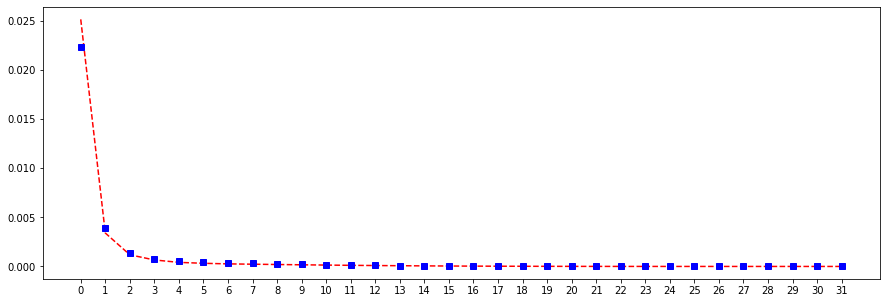

In [25]:
x=dfa.std()
x=x[['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']]
y=dfb.std()
y=y[['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']]
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(x, 'r--',y ,'bs')
plt.show()

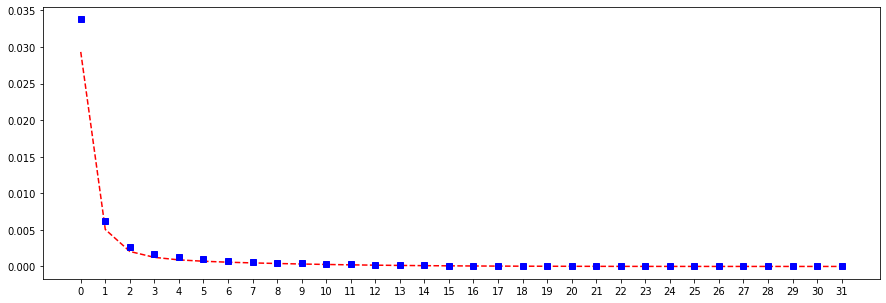

In [26]:
x=dfa.mean()
x=x[['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']]
y=dfb.mean()
y=y[['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']]
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(x, 'r--',y ,'bs')
plt.show()

In [21]:
for x in dfa.columns:
    print(x)

0
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
4
5
6
7
8
9
avBlue
avGreen
avRed
frecbean0pow0
frecbean0pow1
frecbean0pow2
frecbean0pow3
frecbean1pow0
frecbean1pow1
frecbean1pow2
frecbean1pow3
frecbean2pow0
frecbean2pow1
frecbean2pow2
frecbean2pow3
frecbean3pow0
frecbean3pow1
frecbean3pow2
frecbean3pow3
frecbean4pow0
frecbean4pow1
frecbean4pow2
frecbean4pow3
frecbean5pow0
frecbean5pow1
frecbean5pow2
frecbean5pow3
frecbean6pow0
frecbean6pow1
frecbean6pow2
frecbean6pow3
frecbean7pow0
frecbean7pow1
frecbean7pow2
frecbean7pow3
imgSize
maxBlue
maxGreen
maxRed
minBlue
minGreen
minRed
r0g0b0
r0g0b1
r0g0b2
r0g1b0
r0g1b1
r0g1b2
r0g2b0
r0g2b1
r0g2b2
r1g0b0
r1g0b1
r1g0b2
r1g1b0
r1g1b1
r1g1b2
r1g2b0
r1g2b1
r1g2b2
r2g0b0
r2g0b1
r2g0b2
r2g1b0
r2g1b1
r2g1b2
r2g2b0
r2g2b1
r2g2b2
stdBlue
stdGreen
stdRed


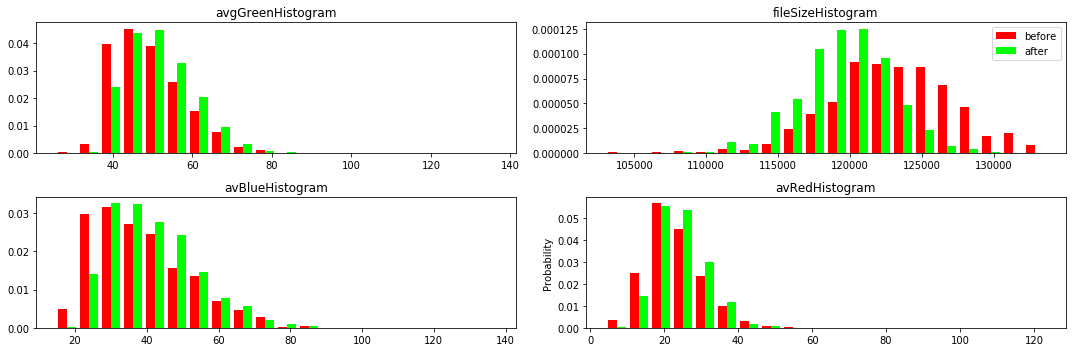

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()
colors = ['red', 'lime']
legend=['before','after']
n_bins=20

ax0.hist([dfb['avGreen'],dfa['avGreen']], n_bins, histtype='bar', color=colors, label=legend,density=True)
ax0.set_title('avgGreenHistogram')

ax1.hist([dfb['imgSize'],dfa['imgSize']], n_bins, histtype='bar', color=colors, label=legend,density=True)
ax1.set_title('fileSizeHistogram')
ax1.legend(prop={'size': 10})


ax2.hist([dfb['avBlue'],dfa['avBlue']], n_bins, histtype='bar', color=colors, label=legend,density=True)
ax2.set_title('avBlueHistogram')

ax3.hist([dfb['avRed'],dfa['avRed']], n_bins, histtype='bar', color=colors, label=legend,density=True)
ax3.set_title('avRedHistogram')


plt.ylabel('Probability');
fig.tight_layout()
plt.show()

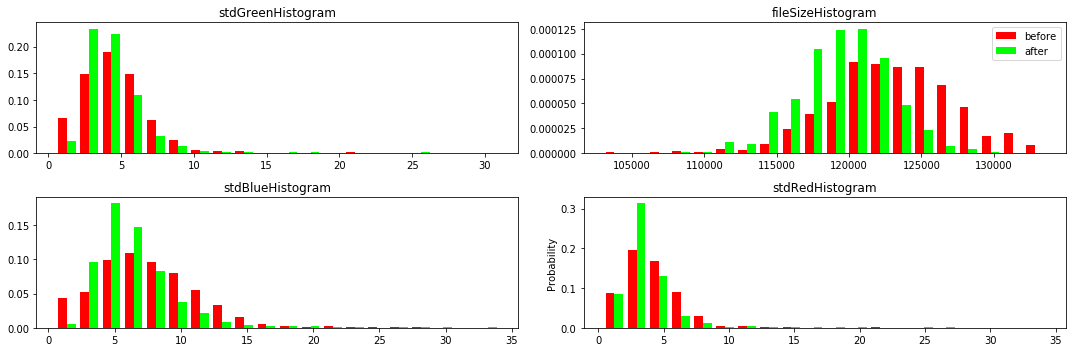

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()
colors = ['red', 'lime']
legend=['before','after']
n_bins=20

ax0.hist([dfb['stdGreen'],dfa['stdGreen']], n_bins, histtype='bar', color=colors, label=legend,density=True)
ax0.set_title('stdGreenHistogram')

ax1.hist([dfb['imgSize'],dfa['imgSize']], n_bins, histtype='bar', color=colors, label=legend,density=True)
ax1.set_title('fileSizeHistogram')
ax1.legend(prop={'size': 10})


ax2.hist([dfb['stdBlue'],dfa['stdBlue']], n_bins, histtype='bar', color=colors, label=legend,density=True)
ax2.set_title('stdBlueHistogram')

ax3.hist([dfb['stdRed'],dfa['stdRed']], n_bins, histtype='bar', color=colors, label=legend,density=True)
ax3.set_title('stdRedHistogram')


plt.ylabel('Probability');
fig.tight_layout()
plt.show()

In [ ]:
#Construyendo un vector de caracteristicas de la imagene para estadistica-analitica descriptiva